# **LSTM Model for feature set 1 dynamic only**

The task is to design an LSTM model using PyTorch to predict extubation failure, a binary classification problem. The approach includes:

Model Design: Create an LSTM model with hyperparameters for dropout rate, activation function, and learning rate of the Adam optimizer.

Cross-Validation: Use 5-fold cross-validation to evaluate model performance based on AUROC.

Data Sampling Strategies: Implement normal sampling, undersampling, and oversampling as hyperparameters to handle class imbalance (70% success, 30% failure).

Weighted Loss: Integrate a weighted loss function as an additional hyperparameter.

Early Stopping and Regularization: Implement techniques to prevent overfitting, such as early stopping and regularization.

Model Checkpoints: Save model snapshots at relevant epochs.

Feature Importance: Conduct an ablation study to identify important features.

Interpretability: Generate SHAP and LIME plots for model interpretation.
Implementation Steps
The implementation steps include:

Data Preparation: Load and preprocess training and test data.
LSTM Model Design: Define the LSTM architecture in PyTorch.

Data Sampling Functions: Implement functions for normal, over, and undersampling.

Cross-Validation Setup: Set up 5-fold cross-validation.

Training Loop: Train the model with early stopping and regularization.

Evaluation: Evaluate the model using AUROC.

Model Checkpoints: Save model states at relevant epochs.

Ablation Study: Conduct ablation study to determine feature importance.

Interpretability: Use SHAP and LIME for model interpretation.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 1 - Prepare the Data**

In [ ]:
class TimeSeriesDataset(Dataset):
  """
  A custom PyTorch Dataset class for time series data.

  Args:
      sequences (numpy.ndarray): A NumPy array containing time series sequences.
      labels (numpy.ndarray): A NumPy array containing the corresponding labels for the sequences.

  Methods:
      __len__(): Returns the number of samples in the dataset.
      __getitem__(idx): Returns a dictionary containing the time series sequence and label for the given index.
  """
  def __init__(self, sequences, labels):
    self.sequences = sequences
    self.labels = labels

  def __len__(self):
    """
    Returns the number of samples in the dataset.
    """
    return len(self.sequences)

  def __getitem__(self, idx):
    """
    Returns a dictionary containing the time series sequence and label for the given index.

    Args:
        idx (int): The index of the sample to retrieve.

    Returns:
        dict: A dictionary with keys 'sequence' and 'label', containing the time series sequence and label tensors, respectively.
    """
    return {
        'sequence': torch.tensor(self.sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
    }

Create a function to generate data loaders for training, validation, and test sets.



In [ ]:
def create_data_loaders(train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, batch_size):
  """
  Creates PyTorch DataLoader objects for training, validation, and test sets.

  Args:
      train_sequences: Training sequences.
      train_labels: Training labels.
      val_sequences: Validation sequences.
      val_labels: Validation labels.
      test_sequences: Test sequences.
      test_labels: Test labels.
      batch_size: Batch size for the DataLoaders.

  Returns:
      tuple: A tuple containing the train, validation, and test DataLoaders.
  """
  train_dataset = TimeSeriesDataset(train_sequences, train_labels)
  val_dataset = TimeSeriesDataset(val_sequences, val_labels)
  test_dataset = TimeSeriesDataset(test_sequences, test_labels)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

**Step 2 - Define Sampling Methods**

Define functions for normal sampling, undersampling, and oversampling using SMOTE.



In [ ]:
# Normal sampling does not require any processing

Undersampling

In [ ]:
def undersample_data(sequences, labels):
  """
  Undersamples the data using RandomUnderSampler.

  Args:
      sequences (numpy.ndarray): Time series sequences.
      labels (numpy.ndarray): Corresponding labels.

  Returns:
      tuple: Undersampled sequences and labels.
  """
  rus = RandomUnderSampler()
  sequences_flat = sequences.reshape(sequences.shape[0], -1)
  sequences_resampled, labels_resampled = rus.fit_resample(sequences_flat, labels)
  sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
  return sequences_resampled, labels_resampled


Oversampling using SMOTE

In [ ]:
def oversample_data(sequences, labels):
  """
  Oversamples the data using SMOTE.

  Args:
      sequences (numpy.ndarray): Time series sequences.
      labels (numpy.ndarray): Corresponding labels.

  Returns:
      tuple: Oversampled sequences and labels.
  """
  smote = SMOTE()
  sequences_flat = sequences.reshape(sequences.shape[0], -1)
  sequences_resampled, labels_resampled = smote.fit_resample(sequences_flat, labels)
  sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
  return sequences_resampled, labels_resampled

**Step 3 - Define the LSTM model**

The model has a simple LSTM layer, fully connected layer and output sigmoid function for binary classification.

In [ ]:
class LSTMModel(nn.Module):
  """
  A simple LSTM model for binary classification.

  Args:
      input_dim (int): The number of features in the input sequence.
      hidden_dim (int): The number of features in the hidden state of the LSTM.
      layer_dim (int): The number of LSTM layers.
      output_dim (int): The number of output classes (1 for binary classification).
      dropout_prob (float): The dropout probability.

  Methods:
      forward(x): Defines the forward pass of the model.
  """
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.layer_dim = layer_dim

    # Dropout requires > 1 layer
    if layer_dim == 1:
      dropout_prob = 0

    self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x (torch.Tensor): The input tensor of shape (batch_size, sequence_length, input_dim).

    Returns:
        torch.Tensor: The output tensor of shape (batch_size, output_dim).
    """
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
    c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    out = self.sigmoid(out)
    return out

**Step 6 - Add Early Stopping and Model Checkpoints**

Add early stopping and model checkpoints to prevent overfitting and save the best model during training.

In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        output_path (str): Path to save the best model checkpoint.
        patience (int, optional): How long to wait after last time validation loss improved. Defaults to 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        """
        Checks the validation AUC and decides whether to stop training.

        Args:
            val_auc (float): Validation AUC score.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model checkpoint.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.output_path)

In [ ]:
def save_training_checkpoint(epoch, model, optimizer, best_auc, checkpoint_path, early_stopping_counter):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_auc': best_auc,
        'early_stopping_counter': early_stopping_counter
    }
    torch.save(checkpoint, checkpoint_path)

def load_training_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_auc = checkpoint['best_auc']
    early_stopping_counter = checkpoint['early_stopping_counter']
    return epoch, best_auc, early_stopping_counter


In [ ]:
class Checkpoint:
    """
    A simple class to save and load model checkpoints.

    Args:
        model_path (str): The path to save or load the checkpoint.
    """
    def __init__(self, model_path):
        self.model_path = model_path
        # Ensure the directory exists
        os.makedirs(os.path.dirname(model_path), exist_ok=True)

    def save(self, model):
        """
        Saves the model state dictionary to the specified path.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.model_path)

    def load(self, model):
        """
        Loads the model state dictionary from the specified path.

        Args:
            model (torch.nn.Module): The model to load the state dictionary into.
        """
        model.load_state_dict(torch.load(self.model_path))

**Step 7 - Training and Evaluation**

Define functions for training and evaluating the model, including cross-validation and hyperparameter tuning.

Training incorporates early stopping and checkpoints.

In [ ]:
def train_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the model with early stopping and logging.

    Parameters:
    model (nn.Module): The LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    # Initialize early stopping and checkpoint utilities

    early_stopping = EarlyStopping(patience=patience, min_delta=0, output_path=output_path) # Min delta value set to 0 to allow model to learn

    # checkpoint = Checkpoint(output_path)

    train_losses = []
    val_losses = []
    val_aucs = []


    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)

            labels = data['label'].to(device).view(-1, 1) # Ensure labels have shape [batch_size, 1]

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(sequences)  # Forward pass

            # Print shapes for debugging
            # print(f"Epoch {epoch} - Train: outputs shape: {outputs.shape}, labels shape: {labels.shape}")

            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            running_loss += loss.item() * sequences.size(0)  # Accumulate loss

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []
        with torch.no_grad():
            for data in val_loader:
                sequences = data['sequence'].to(device)
                labels = data['label'].to(device).view(-1, 1) # Ensure labels have shape [batch_size, 1]
                outputs = model(sequences)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                val_running_loss += loss.item() * sequences.size(0)  # Accumulate loss
                val_outputs.extend(outputs.cpu().numpy())  # Collect outputs
                val_labels.extend(labels.cpu().numpy())  # Collect labels

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)  # Check for early stopping

        # Save the checkpoint every epoch
        # checkpoint.save(model)

        # Check for best performing model
        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # checkpoint.load(model)  # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs


**Step 5 - Implement Cross-Validation and Hyperparameter Search**

Set up a 5-fold cross validation to define a hyperparameter grid to search over.

This will also integrate the normal, under and oversampling methods into the cross-validation loop.

In [ ]:
def shuffle_data(sequences, labels):
    assert len(sequences) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], labels[p]

In [ ]:
def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

There seems to be an issue with KFold function frpom scikit learn so attempting manual cross validation.

In [ ]:
def save_cv_progress(progress, filename):
    """Saves the progress of cross-validation."""
    with open(filename, 'w') as f:
        json.dump(progress, f)

def load_cv_progress(filename):
    """Loads the progress of cross-validation."""
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    else:
        return None

In [ ]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


In [ ]:
def manual_cross_validation(sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):

    # Shuffle and split the data
    sequences, labels = shuffle_data(sequences, labels)
    sequences_folds, labels_folds = split_data_into_folds(sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):

        # Separate into train and validation sets
        val_sequences = sequences_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences, train_labels)
            else:
                train_sequences_resampled, train_labels_resampled = train_sequences, train_labels

            # Create data loaders
            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_labels_resampled,
                val_sequences, val_labels,
                val_sequences, val_labels,
                batch_size=params['batch_size']
            )

            # Initialize the model
            model = LSTMModel(
                input_dim=16,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob']
            ).to(device)

            # Reset the model weights
            reset_model(model)

            # Define the cross-entropy loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
                    outputs = model(sequences)

                    # print(f"Val: outputs shape: {outputs.shape}, labels shape: {labels.shape}")  # Debugging shapes

                    val_outputs.extend(outputs.cpu().numpy().flatten())  # Flatten the output
                    val_labels.extend(labels.cpu().numpy().flatten())  # Flatten the labels

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return best_model, best_hyperparams, best_auc

# **Experiment with Dummy Data**

Before we run our MIMIC data through the model, we will try some dummy code to see if the model components run first.

In [ ]:
# Generate dummy data
np.random.seed(42)
torch.manual_seed(42)

def generate_dummy_data(num_samples, num_features, sequence_length):
    sequences = np.random.rand(num_samples, sequence_length, num_features)
    labels = np.random.randint(0, 2, num_samples)
    return sequences, labels

num_samples = 500
num_features = 14
sequence_length = 13

dummy_sequences, dummy_labels = generate_dummy_data(num_samples, num_features, sequence_length)

# Split dummy data into train and test sets
dummy_train_sequences = dummy_sequences[:400]
dummy_train_labels = dummy_labels[:400]
dummy_test_sequences = dummy_sequences[400:]
dummy_test_labels = dummy_labels[400:]

In [ ]:
# Define a simple hyperparamter grid
dummy_param_grid = {
    'hidden_dim': [32],
    'layer_dim': [1],
    'dropout_prob': [0.2],
    'learning_rate': [0.001],
    'batch_size': [32],
    'num_epochs': [10],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal']
}

dummy_param_combinations = list(itertools.product(*dummy_param_grid.values()))
dummy_hyperparameters = [dict(zip(dummy_param_grid.keys(), params)) for params in dummy_param_combinations]

print(f"Total hyperparameter combinations: {len(dummy_hyperparameters)}")

Total hyperparameter combinations: 3


In [ ]:
# Run the model on the dummy data
dummy_train_loader, _, dummy_test_loader = create_data_loaders(
    dummy_train_sequences, dummy_train_labels,
    dummy_test_sequences, dummy_test_labels,
    dummy_test_sequences, dummy_test_labels,
    batch_size=32
)

Total samples: 400
Fold 1/10
Train indices: [  0   1   2   3   4   5   6   7  10  11  12  13  14  15  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  34  35  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 125 126 127 128 130 131 132 133 134 135
 136 137 138 139 140 141 143 144 145 147 148 150 151 153 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 178 180 181 182 183 184 187 188 189 190 191 194 195 196 197 198 199 200
 201 202 203 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 255 256 257
 258 25

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 6/9, Loss: 0.6828, Val Loss: 0.6801, Val AUC: 0.6036
Epoch 7/9, Loss: 0.6825, Val Loss: 0.6802, Val AUC: 0.6113
Epoch 8/9, Loss: 0.6818, Val Loss: 0.6799, Val AUC: 0.6087
Epoch 9/9, Loss: 0.6815, Val Loss: 0.6797, Val AUC: 0.6215


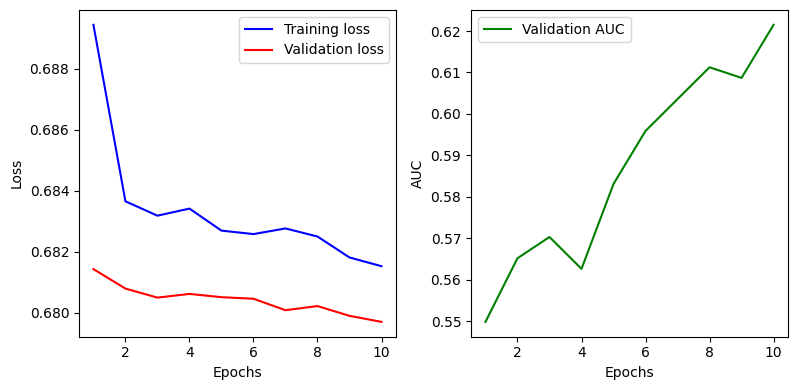

Val: outputs shape: torch.Size([32, 1]), labels shape: torch.Size([32, 1])
Val: outputs shape: torch.Size([8, 1]), labels shape: torch.Size([8, 1])
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.6215
Epoch 0/9, Loss: 0.6949, Val Loss: 0.6882, Val AUC: 0.7417
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6887, Val AUC: 0.7442
Epoch 2/9, Loss: 0.6934, Val Loss: 0.6889, Val AUC: 0.7519
Epoch 3/9, Loss: 0.6930, Val Loss: 0.6890, Val AUC: 0.7647
Epoch 4/9, Loss: 0.6933, Val Loss: 0.6911, Val AUC: 0.7570
Epoch 5/9, Loss: 0.6937, Val Loss: 0.6874, Val AUC: 0.7596
Epoch 6/9, Loss: 0.6923, Val Loss: 0.6877, Val AUC: 0.7442


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 7/9, Loss: 0.6926, Val Loss: 0.6892, Val AUC: 0.7289
Epoch 8/9, Loss: 0.6924, Val Loss: 0.6868, Val AUC: 0.7110
Early stopping


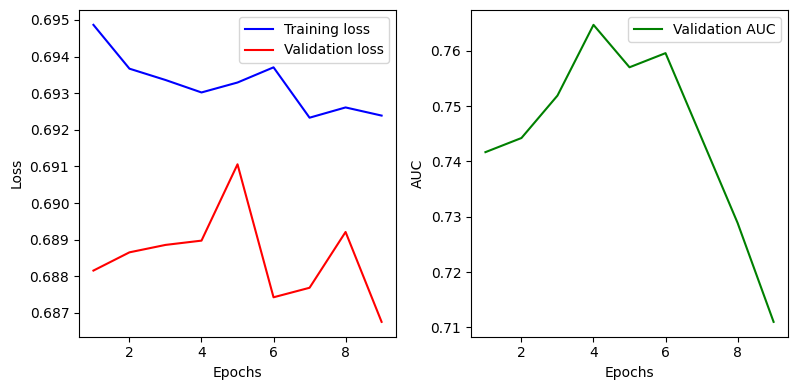

Val: outputs shape: torch.Size([32, 1]), labels shape: torch.Size([32, 1])
Val: outputs shape: torch.Size([8, 1]), labels shape: torch.Size([8, 1])
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.7647
Epoch 0/9, Loss: 0.6940, Val Loss: 0.6937, Val AUC: 0.5703
Epoch 1/9, Loss: 0.6935, Val Loss: 0.6925, Val AUC: 0.5575
Epoch 2/9, Loss: 0.6930, Val Loss: 0.6928, Val AUC: 0.5908
Epoch 3/9, Loss: 0.6930, Val Loss: 0.6918, Val AUC: 0.5780
Epoch 4/9, Loss: 0.6928, Val Loss: 0.6931, Val AUC: 0.5959


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 5/9, Loss: 0.6924, Val Loss: 0.6923, Val AUC: 0.5959
Epoch 6/9, Loss: 0.6920, Val Loss: 0.6906, Val AUC: 0.6010
Epoch 7/9, Loss: 0.6922, Val Loss: 0.6921, Val AUC: 0.6036
Epoch 8/9, Loss: 0.6918, Val Loss: 0.6891, Val AUC: 0.6010
Epoch 9/9, Loss: 0.6909, Val Loss: 0.6903, Val AUC: 0.6113


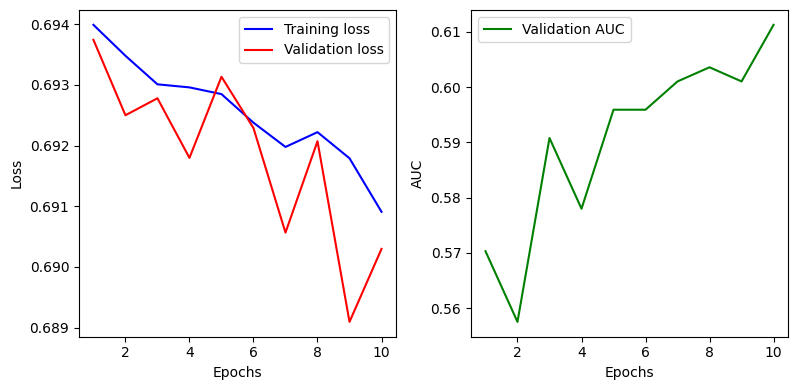

Val: outputs shape: torch.Size([32, 1]), labels shape: torch.Size([32, 1])
Val: outputs shape: torch.Size([8, 1]), labels shape: torch.Size([8, 1])
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.6113
Fold 2/10
Train indices: [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  38  40  41  42  43  45  47  48  49  51  52  53  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 109 110 111 112 113 114 115 117
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 136 137
 138 139 140 141 142 143 144 145 146 148 149 150 152 153 154 155 156 157
 158 159 160 161 162 164 165 166 167 168 169 170 17

IndexError: index 98 is out of bounds for dimension 0 with size 8

In [ ]:
# Run dummy data cross-validation with early stopping and logging
dummy_best_model, dummy_best_hyperparams, dummy_best_auc = cross_validate_model_with_early_stopping_logging(
    dummy_train_sequences, dummy_train_labels,
    dummy_hyperparameters,
    num_folds=5,
    patience=5,
    output_path='dummy_best_model_checkpoint.pth'
)

print(f'Best Hyperparameters: {dummy_best_hyperparams}')
print(f'Best Validation AUC: {dummy_best_auc:.4f}')

Using the manual cross validation.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6932, Val Loss: 0.6942, Val AUC: 0.4205
Epoch 1/9, Loss: 0.6869, Val Loss: 0.6924, Val AUC: 0.4450
Epoch 2/9, Loss: 0.6803, Val Loss: 0.6940, Val AUC: 0.4507
Epoch 3/9, Loss: 0.6791, Val Loss: 0.6955, Val AUC: 0.4444
Epoch 4/9, Loss: 0.6797, Val Loss: 0.6981, Val AUC: 0.4406
Early stopping


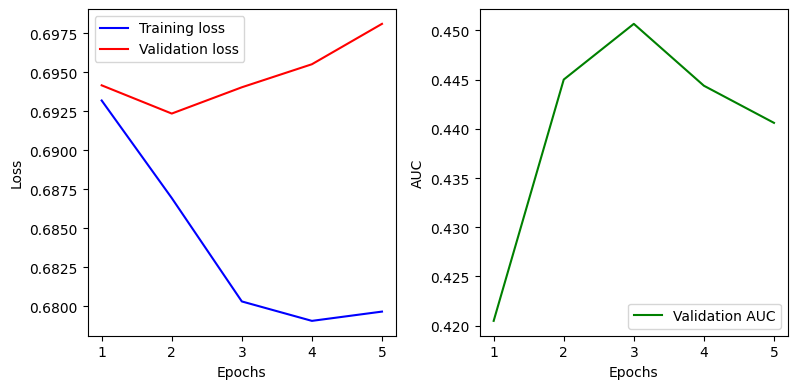

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.4507
Epoch 0/9, Loss: 0.6951, Val Loss: 0.6893, Val AUC: 0.5877
Epoch 1/9, Loss: 0.6933, Val Loss: 0.6912, Val AUC: 0.5795
Epoch 2/9, Loss: 0.6927, Val Loss: 0.6928, Val AUC: 0.5657
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


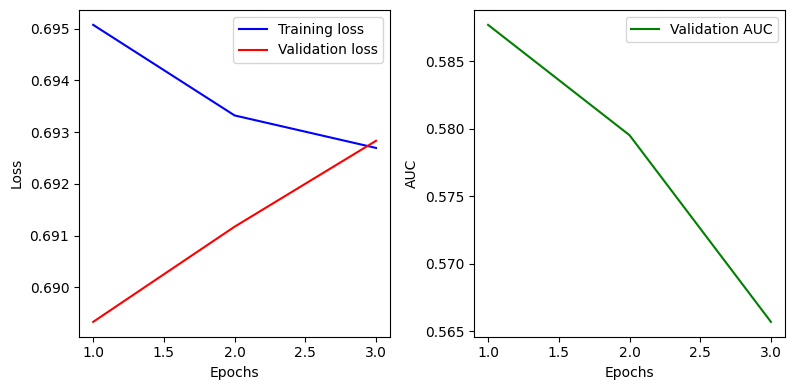

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5877
Epoch 0/9, Loss: 0.6953, Val Loss: 0.6953, Val AUC: 0.5512
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6922, Val AUC: 0.5544
Epoch 2/9, Loss: 0.6925, Val Loss: 0.6933, Val AUC: 0.5443
Epoch 3/9, Loss: 0.6920, Val Loss: 0.6932, Val AUC: 0.5468
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


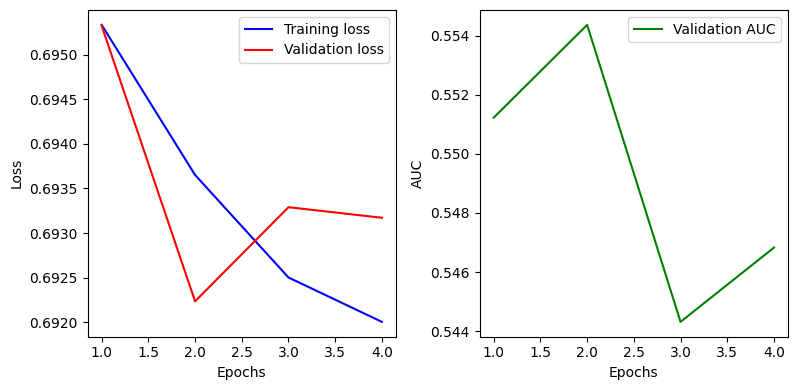

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5544
Epoch 0/9, Loss: 0.6892, Val Loss: 0.6780, Val AUC: 0.6564
Epoch 1/9, Loss: 0.6848, Val Loss: 0.6769, Val AUC: 0.6512
Epoch 2/9, Loss: 0.6849, Val Loss: 0.6776, Val AUC: 0.6428
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


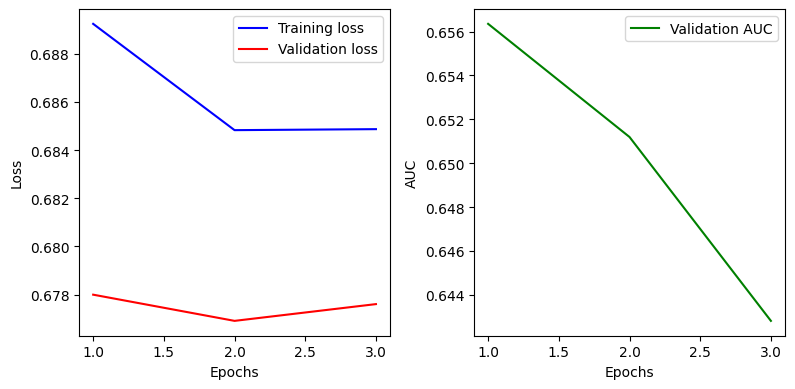

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.6564
Epoch 0/9, Loss: 0.6957, Val Loss: 0.6931, Val AUC: 0.6157
Epoch 1/9, Loss: 0.6947, Val Loss: 0.6946, Val AUC: 0.6209
Epoch 2/9, Loss: 0.6939, Val Loss: 0.6914, Val AUC: 0.6428
Epoch 3/9, Loss: 0.6937, Val Loss: 0.6902, Val AUC: 0.6609
Epoch 4/9, Loss: 0.6933, Val Loss: 0.6901, Val AUC: 0.6680
Epoch 5/9, Loss: 0.6932, Val Loss: 0.6894, Val AUC: 0.6763
Epoch 6/9, Loss: 0.6927, Val Loss: 0.6916, Val AUC: 0.6712


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 7/9, Loss: 0.6924, Val Loss: 0.6916, Val AUC: 0.6570
Early stopping


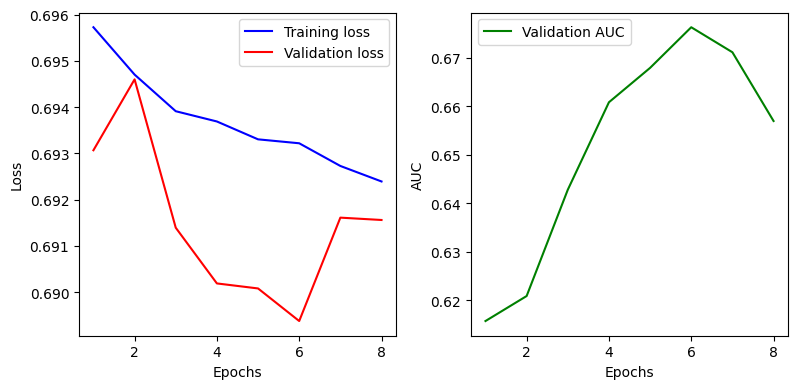

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.6763
Epoch 0/9, Loss: 0.6943, Val Loss: 0.6934, Val AUC: 0.4184
Epoch 1/9, Loss: 0.6935, Val Loss: 0.7006, Val AUC: 0.4023
Epoch 2/9, Loss: 0.6930, Val Loss: 0.7013, Val AUC: 0.4036
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


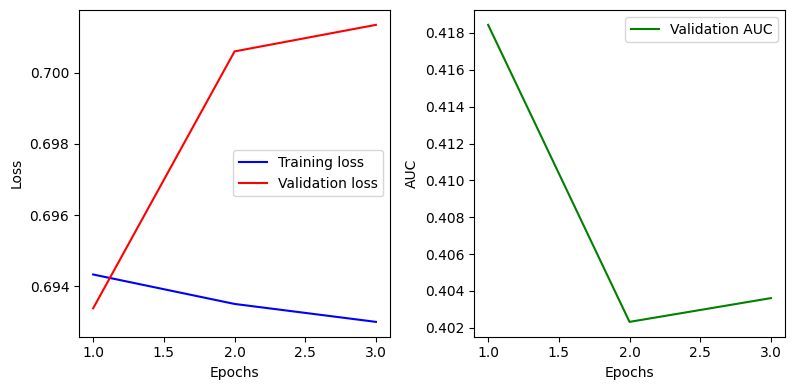

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.4184
Epoch 0/9, Loss: 0.6934, Val Loss: 0.6913, Val AUC: 0.4044
Epoch 1/9, Loss: 0.6864, Val Loss: 0.6871, Val AUC: 0.4133
Epoch 2/9, Loss: 0.6824, Val Loss: 0.6870, Val AUC: 0.4152
Epoch 3/9, Loss: 0.6830, Val Loss: 0.6881, Val AUC: 0.4121
Epoch 4/9, Loss: 0.6831, Val Loss: 0.6885, Val AUC: 0.4178
Epoch 5/9, Loss: 0.6817, Val Loss: 0.6874, Val AUC: 0.4235


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 6/9, Loss: 0.6817, Val Loss: 0.6871, Val AUC: 0.4248
Epoch 7/9, Loss: 0.6817, Val Loss: 0.6872, Val AUC: 0.4267
Epoch 8/9, Loss: 0.6815, Val Loss: 0.6870, Val AUC: 0.4343
Epoch 9/9, Loss: 0.6812, Val Loss: 0.6872, Val AUC: 0.4387


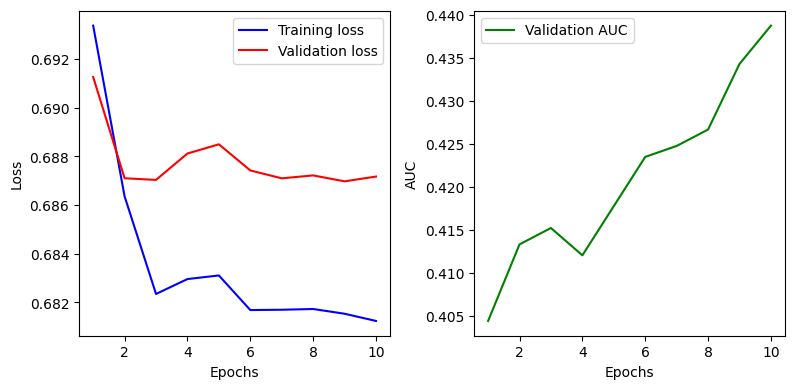

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.4387
Epoch 0/9, Loss: 0.6958, Val Loss: 0.6892, Val AUC: 0.4140
Epoch 1/9, Loss: 0.6942, Val Loss: 0.6912, Val AUC: 0.4273
Epoch 2/9, Loss: 0.6947, Val Loss: 0.6936, Val AUC: 0.4197
Epoch 3/9, Loss: 0.6931, Val Loss: 0.6927, Val AUC: 0.4260
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


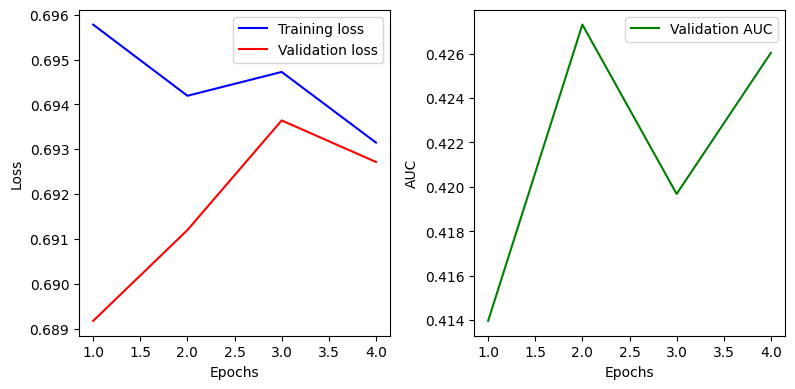

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.4273
Epoch 0/9, Loss: 0.6959, Val Loss: 0.6913, Val AUC: 0.4863
Epoch 1/9, Loss: 0.6936, Val Loss: 0.6923, Val AUC: 0.4851
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6934, Val AUC: 0.4933
Epoch 3/9, Loss: 0.6935, Val Loss: 0.6954, Val AUC: 0.4832
Epoch 4/9, Loss: 0.6930, Val Loss: 0.6946, Val AUC: 0.4838
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


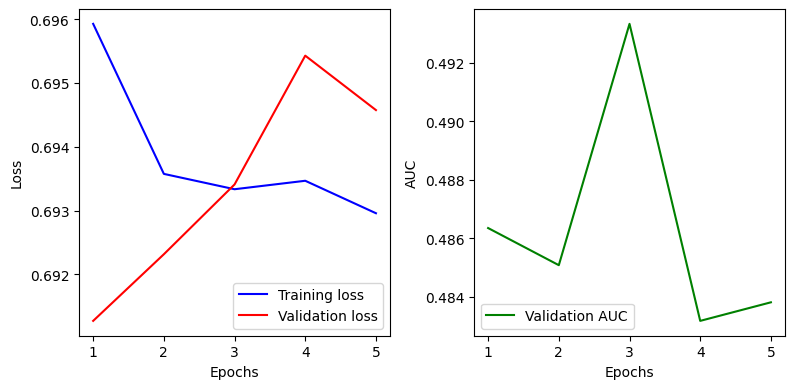

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.4933
Epoch 0/9, Loss: 0.6966, Val Loss: 0.6902, Val AUC: 0.5524
Epoch 1/9, Loss: 0.6876, Val Loss: 0.6837, Val AUC: 0.5518
Epoch 2/9, Loss: 0.6852, Val Loss: 0.6813, Val AUC: 0.5352
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


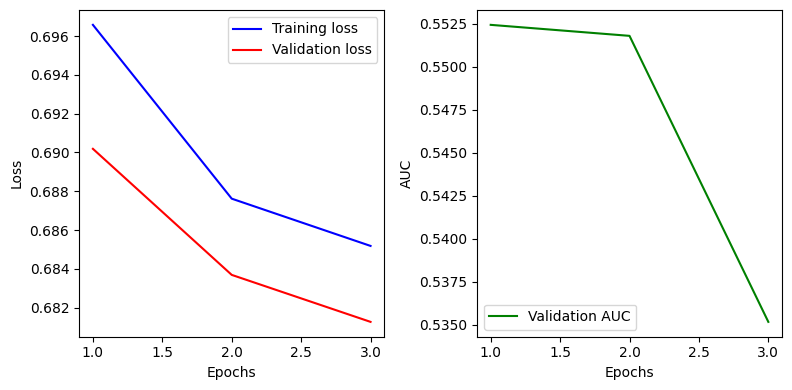

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5524
Epoch 0/9, Loss: 0.6944, Val Loss: 0.6901, Val AUC: 0.4137
Epoch 1/9, Loss: 0.6930, Val Loss: 0.6915, Val AUC: 0.4054
Epoch 2/9, Loss: 0.6927, Val Loss: 0.6936, Val AUC: 0.4035
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


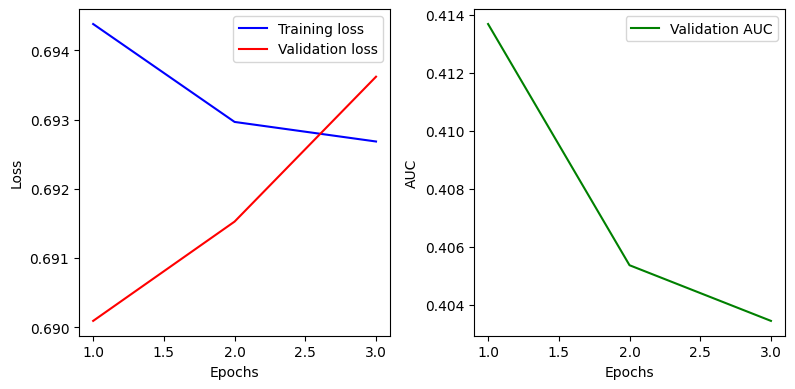

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.4137
Epoch 0/9, Loss: 0.6945, Val Loss: 0.6872, Val AUC: 0.5595
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6919, Val AUC: 0.5550
Epoch 2/9, Loss: 0.6923, Val Loss: 0.6932, Val AUC: 0.5550
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


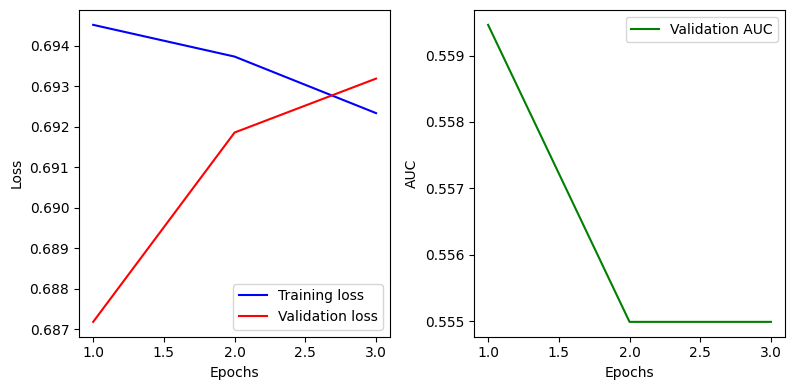

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5595
Epoch 0/9, Loss: 0.6867, Val Loss: 0.6795, Val AUC: 0.5461
Epoch 1/9, Loss: 0.6856, Val Loss: 0.6779, Val AUC: 0.5319
Epoch 2/9, Loss: 0.6847, Val Loss: 0.6780, Val AUC: 0.5293
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


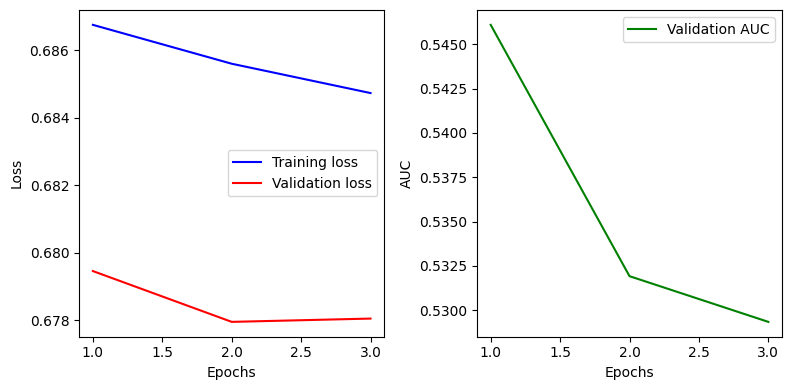

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5461
Epoch 0/9, Loss: 0.6974, Val Loss: 0.6840, Val AUC: 0.6170
Epoch 1/9, Loss: 0.6952, Val Loss: 0.6869, Val AUC: 0.6260
Epoch 2/9, Loss: 0.6945, Val Loss: 0.6895, Val AUC: 0.6235
Epoch 3/9, Loss: 0.6938, Val Loss: 0.6904, Val AUC: 0.6132
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


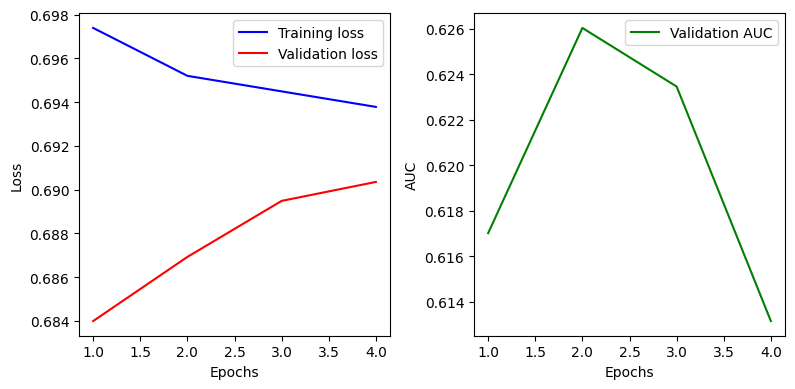

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.6260
Epoch 0/9, Loss: 0.6951, Val Loss: 0.7014, Val AUC: 0.4739
Epoch 1/9, Loss: 0.6923, Val Loss: 0.6945, Val AUC: 0.4384
Epoch 2/9, Loss: 0.6918, Val Loss: 0.6928, Val AUC: 0.4281
Early stopping


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


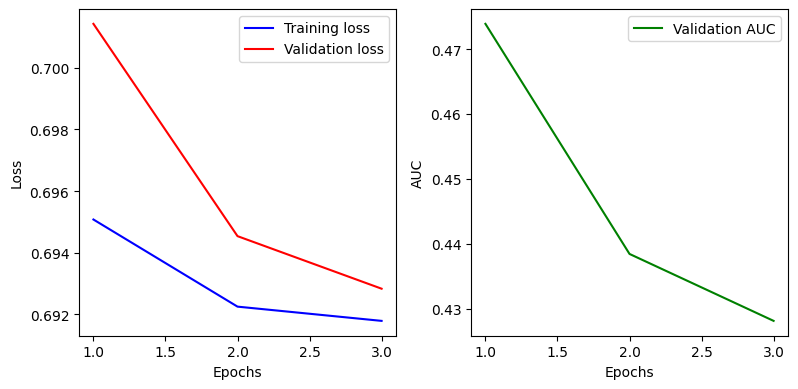

Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.4739
Best Hyperparameters: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}
Best Validation AUC: 0.6763


In [ ]:
# Trying on the manual
dummy_best_model, dummy_best_hyperparams, dummy_best_auc = manual_cross_validate_model(
    dummy_train_sequences, dummy_train_labels,
    dummy_hyperparameters,
    num_folds=5,  # Adjusting folds for smaller dataset
    patience=2,
    output_path='dummy_model_checkpoint.pth'
)

print(f'Best Hyperparameters: {dummy_best_hyperparams}')
print(f'Best Validation AUC: {dummy_best_auc:.4f}')


Removing reliance on sci-kit learn seems to have solved the issue regarding the number of fold and IndexErrors.

# **Experiments with real data**

## **Experiment 1**

Train and test data for feature set 1.

No early stopping.

(In hindsight - data was not fully normalised so results are invalid)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load train and test set
train_sequences = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/train_sequences_v02.npy', allow_pickle=True).astype(np.float32)
train_labels = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/train_labels_v02.npy', allow_pickle=True).astype(np.float32)
test_sequences = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/test_sequences_v02.npy', allow_pickle=True).astype(np.float32)
test_labels = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/test_labels_v02.npy', allow_pickle=True).astype(np.float32)

print(f'Train sequences shape: {train_sequences.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test sequences shape: {test_sequences.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train sequences shape: (3760, 13, 16)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 16)
Test labels shape: (941,)


In [ ]:
# Verify data types
print(train_sequences.dtype)
print(train_labels.dtype)
print(test_sequences.dtype)
print(test_labels.dtype)

float32
float32
float32
float32


In [ ]:
# Create the data loaders to input into the model
train_loader, _ , test_loader = create_data_loaders(
    train_sequences, train_labels,
    test_sequences, test_labels,
    test_sequences, test_labels,
    batch_size=32
)

print(f'Train loader length: {len(train_loader)}')
print(f'Test loader length: {len(test_loader)}')

Train loader length: 118
Test loader length: 30


In [ ]:
import itertools

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'hidden_dim': [32, 64, 128], # Complex data requires more hidden neurons
    'layer_dim': [1, 2], # More layers may improve performance
    'dropout_prob': [0.0, 0.25, 0.5], # Regularization
    'learning_rate': [0.01, 0.001, 0.0001], # Learning rate for Adam optimiser
    'batch_size': [32], # Batch size for training
    'num_epochs': [10, 20], # Number of epochs for training - start smaller to get a sense of performance
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted']
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))

# Convert the combinations to a list of dictionaries
hyperparameters = [dict(zip(param_grid.keys(), params)) for params in param_combinations]

print(f"Total hyperparameter combinations: {len(hyperparameters)}")

Total hyperparameter combinations: 648


Train the model with 5-fold cross validation and initially without early stopping.

In [ ]:
# Save the best hyperparams and best model in a pickle file
import pickle
import json


In [ ]:
output_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_checkpoints_run_1/checkpoint.pth'
os.makedirs(os.path.dirname(output_path), exist_ok=True)

In [ ]:
best_model_no_early_stopping, best_hyperparams_no_early_stopping, best_auc_no_early_stopping = manual_cross_validation(
    train_sequences,
    train_labels,
    hyperparameters,
    num_folds=5,
    patience=5,
    output_path=None
)

print(f'Best Hyperparameters: {best_hyperparams_no_early_stopping}')
print(f'Best Validation AUC: {best_auc_no_early_stopping:.4f}')

# Save the best model in a pickle file
with open('/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/no_early_stopping/best_model_no_early_stopping.pkl', 'wb') as f:
    pickle.dump(best_model_no_early_stopping, f)

# Save the best hyperparams in a json file
with open('/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/no_early_stopping/best_hyperparams_no_early_stopping.json', 'w') as f:
    json.dump(best_hyperparams_no_early_stopping, f)

Output hidden; open in https://colab.research.google.com to view.

The model here was run on data where the Ventlation Mode was not normalised. As such the predictive values output will not be reliable as Gradient Descent is sensitive to feature scaling and larger scale features can dominate the training process.

As such the model will be retrained with fully normalised data.

## **Experiment 2**

Fully normalised train and test data for feature set 1 dynamic data only (ventilation mode now treated as numerical and scaled appropriately).

Early stopping employed to avoid overfitting and training for longer than necessary.

Changed hyperparameter tuning so 'weighted' loss only applies if sampling is 'normal' as it is redundant to apply when over or undersampling is employeded.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import itertools

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'hidden_dim': [32, 64, 128], # Complex data requires more hidden neurons
    'layer_dim': [1, 2], # More layers may improve performance
    'dropout_prob': [0.0, 0.25, 0.5], # Regularization
    'learning_rate': [0.01, 0.001, 0.0001], # Learning rate for Adam optimiser
    'batch_size': [32, 64], # Batch size for training
    'num_epochs': [10, 20], # Number of epochs for training - start smaller to get a sense of performance
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted']
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))

# Convert the combinations to a list of dictionaries
hyperparameters_2 = [dict(zip(param_grid.keys(), params)) for params in param_combinations]

print(f"Total hyperparameter combinations: {len(hyperparameters_2)}")

Total hyperparameter combinations: 1296


In [ ]:
# Load the train and test data fully normalised
train_sequences_2 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/train_sequences_v03.npy', allow_pickle=True).astype(np.float32)
train_labels_2 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/train_labels_v03.npy', allow_pickle=True).astype(np.float32)
test_sequences_2 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/test_sequences_v03.npy', allow_pickle=True).astype(np.float32)
test_labels_2 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/test_labels_v03.npy', allow_pickle=True).astype(np.float32)

print(f'Train sequences shape: {train_sequences_2.shape}')
print(f'Train labels shape: {train_labels_2.shape}')
print(f'Test sequences shape: {test_sequences_2.shape}')
print(f'Test labels shape: {test_labels_2.shape}')

Train sequences shape: (3760, 13, 16)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 16)
Test labels shape: (941,)


In [ ]:
import pickle
import json

In [ ]:
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_checkpoints_run_2/checkpoint.pth'


In [ ]:
# Train the model on the data with five-fold cross validation
best_model_2, best_hyperparams_2, best_auc_2 = manual_cross_validation(
    train_sequences_2,
    train_labels_2,
    hyperparameters_2,
    num_folds=5,
    patience=5,
    output_path=output_dir
)

print(f'Best Hyperparameters: {best_hyperparams_2}')
print(f'Best Validation AUC: {best_auc_2:.4f}')

# Save best model into pickle file
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_2, f)

# Save the best hyperparameters in a json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_2, f)

Epoch 0/9, Loss: 0.6391, Val Loss: 0.6358, Val AUC: 0.5684
Epoch 1/9, Loss: 0.6334, Val Loss: 0.6363, Val AUC: 0.5704
Epoch 2/9, Loss: 0.6346, Val Loss: 0.6351, Val AUC: 0.5614
Epoch 3/9, Loss: 0.6336, Val Loss: 0.6356, Val AUC: 0.5530
Epoch 4/9, Loss: 0.6328, Val Loss: 0.6349, Val AUC: 0.5589
Epoch 5/9, Loss: 0.6335, Val Loss: 0.6349, Val AUC: 0.5496
Epoch 6/9, Loss: 0.6326, Val Loss: 0.6346, Val AUC: 0.5551
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.0, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5551
Epoch 0/9, Loss: 0.8149, Val Loss: 0.8142, Val AUC: 0.5509
Epoch 1/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5528
Epoch 2/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5559
Epoch 3/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5476
Epoch 4/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5537
Epoch 5/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5506
Epoch 6/9, Loss: 0.8125, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6365, Val Loss: 0.6434, Val AUC: 0.5720
Epoch 1/9, Loss: 0.6354, Val Loss: 0.6352, Val AUC: 0.5611
Epoch 2/9, Loss: 0.6337, Val Loss: 0.6394, Val AUC: 0.5521
Epoch 3/9, Loss: 0.6334, Val Loss: 0.6346, Val AUC: 0.5566
Epoch 4/9, Loss: 0.6321, Val Loss: 0.6336, Val AUC: 0.5651
Epoch 5/9, Loss: 0.6326, Val Loss: 0.6329, Val AUC: 0.5673
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5673


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8160, Val Loss: 0.8142, Val AUC: 0.5518
Epoch 1/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5150
Epoch 2/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5433
Epoch 3/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5474
Epoch 4/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5539
Epoch 5/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5546
Epoch 6/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5526
Epoch 7/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5557
Epoch 8/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5576
Epoch 9/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5546
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5546


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6953, Val Loss: 0.6883, Val AUC: 0.5787
Epoch 1/9, Loss: 0.6935, Val Loss: 0.6977, Val AUC: 0.5815
Epoch 2/9, Loss: 0.6937, Val Loss: 0.6905, Val AUC: 0.5824
Epoch 3/9, Loss: 0.6935, Val Loss: 0.6901, Val AUC: 0.5707
Epoch 4/9, Loss: 0.6932, Val Loss: 0.7029, Val AUC: 0.5797
Epoch 5/9, Loss: 0.6929, Val Loss: 0.6838, Val AUC: 0.5774
Epoch 6/9, Loss: 0.6947, Val Loss: 0.6912, Val AUC: 0.5601
Epoch 7/9, Loss: 0.6929, Val Loss: 0.6981, Val AUC: 0.5681
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5681


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6953, Val Loss: 0.6890, Val AUC: 0.5587
Epoch 1/9, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.5652
Epoch 2/9, Loss: 0.6940, Val Loss: 0.7046, Val AUC: 0.5798
Epoch 3/9, Loss: 0.6933, Val Loss: 0.6945, Val AUC: 0.5623
Epoch 4/9, Loss: 0.6932, Val Loss: 0.6935, Val AUC: 0.5647
Epoch 5/9, Loss: 0.6935, Val Loss: 0.6847, Val AUC: 0.5578
Epoch 6/9, Loss: 0.6931, Val Loss: 0.6915, Val AUC: 0.5584
Epoch 7/9, Loss: 0.6934, Val Loss: 0.6798, Val AUC: 0.5577
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5577


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6951, Val Loss: 0.6928, Val AUC: 0.5675
Epoch 1/9, Loss: 0.6931, Val Loss: 0.7109, Val AUC: 0.5730
Epoch 2/9, Loss: 0.6935, Val Loss: 0.7054, Val AUC: 0.5664
Epoch 3/9, Loss: 0.6932, Val Loss: 0.7056, Val AUC: 0.5694
Epoch 4/9, Loss: 0.6931, Val Loss: 0.7106, Val AUC: 0.5725
Epoch 5/9, Loss: 0.6927, Val Loss: 0.7474, Val AUC: 0.5793
Epoch 6/9, Loss: 0.6936, Val Loss: 0.7034, Val AUC: 0.5708
Epoch 7/9, Loss: 0.6929, Val Loss: 0.6855, Val AUC: 0.5694
Epoch 8/9, Loss: 0.6915, Val Loss: 0.6817, Val AUC: 0.5722
Epoch 9/9, Loss: 0.6911, Val Loss: 0.6875, Val AUC: 0.5727
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5727


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6945, Val Loss: 0.6871, Val AUC: 0.5724
Epoch 1/9, Loss: 0.6934, Val Loss: 0.6991, Val AUC: 0.5669
Epoch 2/9, Loss: 0.6937, Val Loss: 0.6971, Val AUC: 0.5709
Epoch 3/9, Loss: 0.6927, Val Loss: 0.7048, Val AUC: 0.5680
Epoch 4/9, Loss: 0.6931, Val Loss: 0.6832, Val AUC: 0.5716
Epoch 5/9, Loss: 0.6932, Val Loss: 0.6953, Val AUC: 0.5641
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5641


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6346, Val Loss: 0.6545, Val AUC: 0.5739
Epoch 1/19, Loss: 0.6332, Val Loss: 0.6455, Val AUC: 0.5671
Epoch 2/19, Loss: 0.6336, Val Loss: 0.6360, Val AUC: 0.5614
Epoch 3/19, Loss: 0.6320, Val Loss: 0.6339, Val AUC: 0.5648
Epoch 4/19, Loss: 0.6312, Val Loss: 0.6337, Val AUC: 0.5590
Epoch 5/19, Loss: 0.6313, Val Loss: 0.6371, Val AUC: 0.5697
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5697


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8165, Val Loss: 0.8143, Val AUC: 0.5578
Epoch 1/19, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5584
Epoch 2/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5584
Epoch 3/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5589
Epoch 4/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5581
Epoch 5/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5576
Epoch 6/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5584
Epoch 7/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5580
Epoch 8/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5570
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5570


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6956, Val Loss: 0.6917, Val AUC: 0.5575
Epoch 1/19, Loss: 0.6942, Val Loss: 0.7032, Val AUC: 0.5554
Epoch 2/19, Loss: 0.6935, Val Loss: 0.6884, Val AUC: 0.5586
Epoch 3/19, Loss: 0.6932, Val Loss: 0.6874, Val AUC: 0.5609
Epoch 4/19, Loss: 0.6935, Val Loss: 0.7054, Val AUC: 0.5645
Epoch 5/19, Loss: 0.6934, Val Loss: 0.6913, Val AUC: 0.5644
Epoch 6/19, Loss: 0.6929, Val Loss: 0.6833, Val AUC: 0.5692
Epoch 7/19, Loss: 0.6917, Val Loss: 0.6751, Val AUC: 0.5743
Epoch 8/19, Loss: 0.6900, Val Loss: 0.6888, Val AUC: 0.5801
Epoch 9/19, Loss: 0.6951, Val Loss: 0.7127, Val AUC: 0.5727
Epoch 10/19, Loss: 0.6906, Val Loss: 0.6783, Val AUC: 0.5785
Epoch 11/19, Loss: 0.6908, Val Loss: 0.6949, Val AUC: 0.5691
Epoch 12/19, Loss: 0.6924, Val Loss: 0.6816, Val AUC: 0.5675
Epoch 13/19, Loss: 0.6920, Val Loss: 0.6810, Val AUC: 0.5659
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6944, Val Loss: 0.7123, Val AUC: 0.5670
Epoch 1/19, Loss: 0.6940, Val Loss: 0.7043, Val AUC: 0.5648
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6973, Val AUC: 0.5673
Epoch 3/19, Loss: 0.6924, Val Loss: 0.6760, Val AUC: 0.5736
Epoch 4/19, Loss: 0.6925, Val Loss: 0.6734, Val AUC: 0.5773
Epoch 5/19, Loss: 0.6913, Val Loss: 0.6745, Val AUC: 0.5727
Epoch 6/19, Loss: 0.6851, Val Loss: 0.6985, Val AUC: 0.5699
Epoch 7/19, Loss: 0.6851, Val Loss: 0.6885, Val AUC: 0.5711
Epoch 8/19, Loss: 0.6845, Val Loss: 0.7108, Val AUC: 0.5786
Epoch 9/19, Loss: 0.6924, Val Loss: 0.6912, Val AUC: 0.5809
Epoch 10/19, Loss: 0.6875, Val Loss: 0.7010, Val AUC: 0.5875
Epoch 11/19, Loss: 0.6864, Val Loss: 0.6831, Val AUC: 0.5864
Epoch 12/19, Loss: 0.6860, Val Loss: 0.7116, Val AUC: 0.5850
Epoch 13/19, Loss: 0.6830, Val Loss: 0.6646, Val AUC: 0.5844
Epoch 14/19, Loss: 0.6828, Val Loss: 0.6939, Val AUC: 0.5847
Epoch 15/19, Loss: 0.6831, Val Loss: 0.7167, Val AUC: 0.5870
Early stopping
Params: {'hidden_di

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6944, Val Loss: 0.6858, Val AUC: 0.5752
Epoch 1/19, Loss: 0.6932, Val Loss: 0.6865, Val AUC: 0.5705
Epoch 2/19, Loss: 0.6934, Val Loss: 0.6962, Val AUC: 0.5744
Epoch 3/19, Loss: 0.6934, Val Loss: 0.6919, Val AUC: 0.5688
Epoch 4/19, Loss: 0.6933, Val Loss: 0.6934, Val AUC: 0.5713
Epoch 5/19, Loss: 0.6931, Val Loss: 0.6814, Val AUC: 0.5717
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5717


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6938, Val Loss: 0.6879, Val AUC: 0.5729
Epoch 1/19, Loss: 0.6932, Val Loss: 0.6963, Val AUC: 0.5737
Epoch 2/19, Loss: 0.6930, Val Loss: 0.7027, Val AUC: 0.5691
Epoch 3/19, Loss: 0.6932, Val Loss: 0.7074, Val AUC: 0.5698
Epoch 4/19, Loss: 0.6924, Val Loss: 0.6866, Val AUC: 0.5670
Epoch 5/19, Loss: 0.6926, Val Loss: 0.6845, Val AUC: 0.5620
Epoch 6/19, Loss: 0.6929, Val Loss: 0.7051, Val AUC: 0.5702
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5702


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6361, Val Loss: 0.6353, Val AUC: 0.5643
Epoch 1/9, Loss: 0.6332, Val Loss: 0.6357, Val AUC: 0.5609
Epoch 2/9, Loss: 0.6334, Val Loss: 0.6373, Val AUC: 0.5608
Epoch 3/9, Loss: 0.6329, Val Loss: 0.6347, Val AUC: 0.5594
Epoch 4/9, Loss: 0.6315, Val Loss: 0.6353, Val AUC: 0.5654
Epoch 5/9, Loss: 0.6317, Val Loss: 0.6342, Val AUC: 0.5676
Epoch 6/9, Loss: 0.6306, Val Loss: 0.6324, Val AUC: 0.5701
Epoch 7/9, Loss: 0.6315, Val Loss: 0.6332, Val AUC: 0.5672
Epoch 8/9, Loss: 0.6297, Val Loss: 0.6311, Val AUC: 0.5732
Epoch 9/9, Loss: 0.6269, Val Loss: 0.6319, Val AUC: 0.5763
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5763


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8184, Val Loss: 0.8143, Val AUC: 0.5627
Epoch 1/9, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5715
Epoch 2/9, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5718
Epoch 3/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5731
Epoch 4/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5726
Epoch 5/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5706
Epoch 6/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5645
Epoch 7/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5639
Epoch 8/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5467
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5467
Epoch 0/9, Loss: 0.6952, Val Loss: 0.7010, Val AUC: 0.5743


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6942, Val Loss: 0.6954, Val AUC: 0.5711
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6955, Val AUC: 0.5684
Epoch 3/9, Loss: 0.6932, Val Loss: 0.6941, Val AUC: 0.5656
Epoch 4/9, Loss: 0.6934, Val Loss: 0.6974, Val AUC: 0.5699
Epoch 5/9, Loss: 0.6927, Val Loss: 0.6942, Val AUC: 0.5689
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5689
Epoch 0/9, Loss: 0.6961, Val Loss: 0.7078, Val AUC: 0.5699


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6933, Val Loss: 0.6908, Val AUC: 0.5770
Epoch 2/9, Loss: 0.6927, Val Loss: 0.6746, Val AUC: 0.5737
Epoch 3/9, Loss: 0.6951, Val Loss: 0.6910, Val AUC: 0.5635
Epoch 4/9, Loss: 0.6938, Val Loss: 0.6920, Val AUC: 0.5626
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6921, Val AUC: 0.5652
Epoch 6/9, Loss: 0.6928, Val Loss: 0.6912, Val AUC: 0.5710
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5710


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6939, Val Loss: 0.6810, Val AUC: 0.5719
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6891, Val AUC: 0.5688
Epoch 2/9, Loss: 0.6936, Val Loss: 0.6882, Val AUC: 0.5651
Epoch 3/9, Loss: 0.6934, Val Loss: 0.6917, Val AUC: 0.5656
Epoch 4/9, Loss: 0.6918, Val Loss: 0.7368, Val AUC: 0.5713
Epoch 5/9, Loss: 0.6917, Val Loss: 0.7210, Val AUC: 0.5815
Epoch 6/9, Loss: 0.6885, Val Loss: 0.6823, Val AUC: 0.5834
Epoch 7/9, Loss: 0.6928, Val Loss: 0.6980, Val AUC: 0.5727
Epoch 8/9, Loss: 0.6895, Val Loss: 0.6817, Val AUC: 0.5774
Epoch 9/9, Loss: 0.6875, Val Loss: 0.6652, Val AUC: 0.5809
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5809


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6938, Val Loss: 0.7085, Val AUC: 0.5788
Epoch 1/9, Loss: 0.6940, Val Loss: 0.6891, Val AUC: 0.5636
Epoch 2/9, Loss: 0.6930, Val Loss: 0.6977, Val AUC: 0.5761
Epoch 3/9, Loss: 0.7040, Val Loss: 0.7011, Val AUC: 0.5093
Epoch 4/9, Loss: 0.6941, Val Loss: 0.7064, Val AUC: 0.5665
Epoch 5/9, Loss: 0.6936, Val Loss: 0.6989, Val AUC: 0.5679
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5679
Epoch 0/19, Loss: 0.6391, Val Loss: 0.6379, Val AUC: 0.5575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6346, Val Loss: 0.6353, Val AUC: 0.5541
Epoch 2/19, Loss: 0.6326, Val Loss: 0.6355, Val AUC: 0.5587
Epoch 3/19, Loss: 0.6329, Val Loss: 0.6346, Val AUC: 0.5559
Epoch 4/19, Loss: 0.6314, Val Loss: 0.6340, Val AUC: 0.5631
Epoch 5/19, Loss: 0.6320, Val Loss: 0.6336, Val AUC: 0.5584
Epoch 6/19, Loss: 0.6321, Val Loss: 0.6332, Val AUC: 0.5578
Epoch 7/19, Loss: 0.6315, Val Loss: 0.6366, Val AUC: 0.5554
Epoch 8/19, Loss: 0.6300, Val Loss: 0.6401, Val AUC: 0.5687
Epoch 9/19, Loss: 0.6336, Val Loss: 0.6364, Val AUC: 0.5482
Epoch 10/19, Loss: 0.6303, Val Loss: 0.6389, Val AUC: 0.5736
Epoch 11/19, Loss: 0.6301, Val Loss: 0.6330, Val AUC: 0.5652
Epoch 12/19, Loss: 0.6300, Val Loss: 0.6327, Val AUC: 0.5686
Epoch 13/19, Loss: 0.6276, Val Loss: 0.6421, Val AUC: 0.5669
Epoch 14/19, Loss: 0.6297, Val Loss: 0.6325, Val AUC: 0.5675
Epoch 15/19, Loss: 0.6245, Val Loss: 0.6501, Val AUC: 0.5764
Epoch 16/19, Loss: 0.6293, Val Loss: 0.6299, Val AUC: 0.5724
Epoch 17/19, Loss: 0.6259, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8166, Val Loss: 0.8143, Val AUC: 0.5589
Epoch 1/19, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5606
Epoch 2/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5642
Epoch 3/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5718
Epoch 4/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5757
Epoch 5/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5776
Epoch 6/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5770
Epoch 7/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5711
Epoch 8/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5669
Epoch 9/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5668
Epoch 10/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5670
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5670
Epoch 0/19, Loss: 0.6952, Val Loss: 0.6926, Val AUC: 0.5737


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6937, Val Loss: 0.7074, Val AUC: 0.5702
Epoch 2/19, Loss: 0.6943, Val Loss: 0.7087, Val AUC: 0.5659
Epoch 3/19, Loss: 0.6937, Val Loss: 0.6918, Val AUC: 0.5677
Epoch 4/19, Loss: 0.6927, Val Loss: 0.6961, Val AUC: 0.5682
Epoch 5/19, Loss: 0.6926, Val Loss: 0.6917, Val AUC: 0.5684
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5684
Epoch 0/19, Loss: 0.6988, Val Loss: 0.6982, Val AUC: 0.5369


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6935, Val Loss: 0.6943, Val AUC: 0.5734
Epoch 2/19, Loss: 0.6931, Val Loss: 0.6897, Val AUC: 0.5720
Epoch 3/19, Loss: 0.6934, Val Loss: 0.7022, Val AUC: 0.5715
Epoch 4/19, Loss: 0.6923, Val Loss: 0.6829, Val AUC: 0.5658
Epoch 5/19, Loss: 0.6904, Val Loss: 0.6540, Val AUC: 0.5749
Epoch 6/19, Loss: 0.6933, Val Loss: 0.7028, Val AUC: 0.5639
Epoch 7/19, Loss: 0.6935, Val Loss: 0.7022, Val AUC: 0.5656
Epoch 8/19, Loss: 0.6924, Val Loss: 0.7044, Val AUC: 0.5745
Epoch 9/19, Loss: 0.6911, Val Loss: 0.7068, Val AUC: 0.5765
Epoch 10/19, Loss: 0.6906, Val Loss: 0.6665, Val AUC: 0.5716
Epoch 11/19, Loss: 0.6909, Val Loss: 0.6804, Val AUC: 0.5678
Epoch 12/19, Loss: 0.6858, Val Loss: 0.6937, Val AUC: 0.5787
Epoch 13/19, Loss: 0.6876, Val Loss: 0.6662, Val AUC: 0.5694
Epoch 14/19, Loss: 0.6906, Val Loss: 0.6830, Val AUC: 0.5689
Epoch 15/19, Loss: 0.6864, Val Loss: 0.7304, Val AUC: 0.5782
Epoch 16/19, Loss: 0.6897, Val Loss: 0.6854, Val AUC: 0.5710
Epoch 17/19, Loss: 0.6880, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6945, Val Loss: 0.6857, Val AUC: 0.5593
Epoch 1/19, Loss: 0.6932, Val Loss: 0.6980, Val AUC: 0.5699
Epoch 2/19, Loss: 0.6931, Val Loss: 0.6900, Val AUC: 0.5656
Epoch 3/19, Loss: 0.6930, Val Loss: 0.6992, Val AUC: 0.5693
Epoch 4/19, Loss: 0.6924, Val Loss: 0.6914, Val AUC: 0.5709
Epoch 5/19, Loss: 0.6928, Val Loss: 0.7009, Val AUC: 0.5711
Epoch 6/19, Loss: 0.6892, Val Loss: 0.6789, Val AUC: 0.5803
Epoch 7/19, Loss: 0.6880, Val Loss: 0.6339, Val AUC: 0.5793
Epoch 8/19, Loss: 0.6872, Val Loss: 0.6520, Val AUC: 0.5841
Epoch 9/19, Loss: 0.6886, Val Loss: 0.7100, Val AUC: 0.5803
Epoch 10/19, Loss: 0.6876, Val Loss: 0.6824, Val AUC: 0.5848
Epoch 11/19, Loss: 0.6835, Val Loss: 0.7422, Val AUC: 0.5865
Epoch 12/19, Loss: 0.6833, Val Loss: 0.7045, Val AUC: 0.5872
Epoch 13/19, Loss: 0.6813, Val Loss: 0.6786, Val AUC: 0.5889
Epoch 14/19, Loss: 0.6832, Val Loss: 0.6949, Val AUC: 0.5867
Epoch 15/19, Loss: 0.6795, Val Loss: 0.6737, Val AUC: 0.5857
Epoch 16/19, Loss: 0.6806, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6945, Val Loss: 0.6999, Val AUC: 0.5740
Epoch 1/19, Loss: 0.6935, Val Loss: 0.6767, Val AUC: 0.5625
Epoch 2/19, Loss: 0.6934, Val Loss: 0.6988, Val AUC: 0.5674
Epoch 3/19, Loss: 0.6929, Val Loss: 0.7006, Val AUC: 0.5659
Epoch 4/19, Loss: 0.6923, Val Loss: 0.6865, Val AUC: 0.5691
Epoch 5/19, Loss: 0.6917, Val Loss: 0.6755, Val AUC: 0.5605
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5605


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6491, Val Loss: 0.6349, Val AUC: 0.5726
Epoch 1/9, Loss: 0.6328, Val Loss: 0.6344, Val AUC: 0.5739
Epoch 2/9, Loss: 0.6314, Val Loss: 0.6348, Val AUC: 0.5751
Epoch 3/9, Loss: 0.6319, Val Loss: 0.6338, Val AUC: 0.5768
Epoch 4/9, Loss: 0.6303, Val Loss: 0.6326, Val AUC: 0.5771
Epoch 5/9, Loss: 0.6302, Val Loss: 0.6340, Val AUC: 0.5781
Epoch 6/9, Loss: 0.6298, Val Loss: 0.6305, Val AUC: 0.5809
Epoch 7/9, Loss: 0.6256, Val Loss: 0.6321, Val AUC: 0.5777
Epoch 8/9, Loss: 0.6296, Val Loss: 0.6266, Val AUC: 0.5807
Epoch 9/9, Loss: 0.6254, Val Loss: 0.6259, Val AUC: 0.5829
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5829


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8413, Val Loss: 0.8163, Val AUC: 0.5433
Epoch 1/9, Loss: 0.8139, Val Loss: 0.8150, Val AUC: 0.5440
Epoch 2/9, Loss: 0.8131, Val Loss: 0.8146, Val AUC: 0.5418
Epoch 3/9, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5448
Epoch 4/9, Loss: 0.8128, Val Loss: 0.8144, Val AUC: 0.5437
Epoch 5/9, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5434
Epoch 6/9, Loss: 0.8127, Val Loss: 0.8143, Val AUC: 0.5431
Epoch 7/9, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5429
Epoch 8/9, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5413
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5413


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6936, Val Loss: 0.6964, Val AUC: 0.5616
Epoch 1/9, Loss: 0.6930, Val Loss: 0.6985, Val AUC: 0.5810
Epoch 2/9, Loss: 0.6930, Val Loss: 0.6895, Val AUC: 0.5809
Epoch 3/9, Loss: 0.6918, Val Loss: 0.6867, Val AUC: 0.5826
Epoch 4/9, Loss: 0.6903, Val Loss: 0.7002, Val AUC: 0.5829
Epoch 5/9, Loss: 0.6868, Val Loss: 0.6546, Val AUC: 0.5860
Epoch 6/9, Loss: 0.6864, Val Loss: 0.6901, Val AUC: 0.5834
Epoch 7/9, Loss: 0.6877, Val Loss: 0.6923, Val AUC: 0.5866
Epoch 8/9, Loss: 0.6830, Val Loss: 0.6538, Val AUC: 0.5863
Epoch 9/9, Loss: 0.6812, Val Loss: 0.6735, Val AUC: 0.5854
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5854


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6934, Val Loss: 0.6931, Val AUC: 0.5776
Epoch 1/9, Loss: 0.6920, Val Loss: 0.7054, Val AUC: 0.5823
Epoch 2/9, Loss: 0.6899, Val Loss: 0.6532, Val AUC: 0.5845
Epoch 3/9, Loss: 0.6850, Val Loss: 0.7586, Val AUC: 0.5822
Epoch 4/9, Loss: 0.6902, Val Loss: 0.6867, Val AUC: 0.5897
Epoch 5/9, Loss: 0.6829, Val Loss: 0.7098, Val AUC: 0.5878
Epoch 6/9, Loss: 0.6854, Val Loss: 0.7115, Val AUC: 0.5900
Epoch 7/9, Loss: 0.6809, Val Loss: 0.7533, Val AUC: 0.5861
Epoch 8/9, Loss: 0.6775, Val Loss: 0.6527, Val AUC: 0.5836
Epoch 9/9, Loss: 0.6799, Val Loss: 0.6869, Val AUC: 0.5886
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5886


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6934, Val Loss: 0.7057, Val AUC: 0.5679
Epoch 1/9, Loss: 0.6909, Val Loss: 0.6598, Val AUC: 0.5861
Epoch 2/9, Loss: 0.6875, Val Loss: 0.6888, Val AUC: 0.5824
Epoch 3/9, Loss: 0.6838, Val Loss: 0.6960, Val AUC: 0.5834
Epoch 4/9, Loss: 0.6831, Val Loss: 0.6949, Val AUC: 0.5862
Epoch 5/9, Loss: 0.6828, Val Loss: 0.6858, Val AUC: 0.5853
Epoch 6/9, Loss: 0.6816, Val Loss: 0.6473, Val AUC: 0.5834
Epoch 7/9, Loss: 0.6798, Val Loss: 0.6587, Val AUC: 0.5845
Epoch 8/9, Loss: 0.6787, Val Loss: 0.7242, Val AUC: 0.5863
Epoch 9/9, Loss: 0.6787, Val Loss: 0.6539, Val AUC: 0.5832
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5832


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6933, Val Loss: 0.6850, Val AUC: 0.5810
Epoch 1/9, Loss: 0.6903, Val Loss: 0.6762, Val AUC: 0.5773
Epoch 2/9, Loss: 0.6863, Val Loss: 0.7982, Val AUC: 0.5774
Epoch 3/9, Loss: 0.6857, Val Loss: 0.6619, Val AUC: 0.5830
Epoch 4/9, Loss: 0.6828, Val Loss: 0.6904, Val AUC: 0.5824
Epoch 5/9, Loss: 0.6833, Val Loss: 0.6710, Val AUC: 0.5840
Epoch 6/9, Loss: 0.6832, Val Loss: 0.6980, Val AUC: 0.5843
Epoch 7/9, Loss: 0.6835, Val Loss: 0.6640, Val AUC: 0.5831
Epoch 8/9, Loss: 0.6839, Val Loss: 0.6814, Val AUC: 0.5871
Epoch 9/9, Loss: 0.6806, Val Loss: 0.7050, Val AUC: 0.5874
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5874


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6415, Val Loss: 0.6347, Val AUC: 0.5649
Epoch 1/19, Loss: 0.6322, Val Loss: 0.6337, Val AUC: 0.5707
Epoch 2/19, Loss: 0.6310, Val Loss: 0.6340, Val AUC: 0.5720
Epoch 3/19, Loss: 0.6303, Val Loss: 0.6339, Val AUC: 0.5747
Epoch 4/19, Loss: 0.6296, Val Loss: 0.6373, Val AUC: 0.5748
Epoch 5/19, Loss: 0.6310, Val Loss: 0.6305, Val AUC: 0.5759
Epoch 6/19, Loss: 0.6285, Val Loss: 0.6286, Val AUC: 0.5779
Epoch 7/19, Loss: 0.6256, Val Loss: 0.6273, Val AUC: 0.5764
Epoch 8/19, Loss: 0.6264, Val Loss: 0.6254, Val AUC: 0.5762
Epoch 9/19, Loss: 0.6220, Val Loss: 0.6245, Val AUC: 0.5747
Epoch 10/19, Loss: 0.6249, Val Loss: 0.6346, Val AUC: 0.5791
Epoch 11/19, Loss: 0.6202, Val Loss: 0.6255, Val AUC: 0.5764
Epoch 12/19, Loss: 0.6263, Val Loss: 0.6271, Val AUC: 0.5817
Epoch 13/19, Loss: 0.6205, Val Loss: 0.6246, Val AUC: 0.5794
Epoch 14/19, Loss: 0.6200, Val Loss: 0.6249, Val AUC: 0.5812
Epoch 15/19, Loss: 0.6206, Val Loss: 0.6310, Val AUC: 0.5818
Epoch 16/19, Loss: 0.6206, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8429, Val Loss: 0.8169, Val AUC: 0.5652
Epoch 1/19, Loss: 0.8142, Val Loss: 0.8152, Val AUC: 0.5636
Epoch 2/19, Loss: 0.8133, Val Loss: 0.8148, Val AUC: 0.5572
Epoch 3/19, Loss: 0.8130, Val Loss: 0.8146, Val AUC: 0.5582
Epoch 4/19, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5584
Epoch 5/19, Loss: 0.8128, Val Loss: 0.8144, Val AUC: 0.5590
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5590


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6942, Val Loss: 0.6885, Val AUC: 0.5685
Epoch 1/19, Loss: 0.6929, Val Loss: 0.6889, Val AUC: 0.5753
Epoch 2/19, Loss: 0.6917, Val Loss: 0.6737, Val AUC: 0.5753
Epoch 3/19, Loss: 0.6882, Val Loss: 0.6519, Val AUC: 0.5724
Epoch 4/19, Loss: 0.6880, Val Loss: 0.6789, Val AUC: 0.5735
Epoch 5/19, Loss: 0.6863, Val Loss: 0.6732, Val AUC: 0.5755
Epoch 6/19, Loss: 0.6846, Val Loss: 0.7133, Val AUC: 0.5773
Epoch 7/19, Loss: 0.6800, Val Loss: 0.7133, Val AUC: 0.5771
Epoch 8/19, Loss: 0.6793, Val Loss: 0.6688, Val AUC: 0.5766
Epoch 9/19, Loss: 0.6836, Val Loss: 0.7072, Val AUC: 0.5776
Epoch 10/19, Loss: 0.6762, Val Loss: 0.6467, Val AUC: 0.5739
Epoch 11/19, Loss: 0.6810, Val Loss: 0.6743, Val AUC: 0.5774
Epoch 12/19, Loss: 0.6810, Val Loss: 0.6711, Val AUC: 0.5759
Epoch 13/19, Loss: 0.6823, Val Loss: 0.6536, Val AUC: 0.5768
Epoch 14/19, Loss: 0.6766, Val Loss: 0.6658, Val AUC: 0.5770
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6940, Val Loss: 0.6954, Val AUC: 0.5697
Epoch 1/19, Loss: 0.6931, Val Loss: 0.6857, Val AUC: 0.5746
Epoch 2/19, Loss: 0.6902, Val Loss: 0.7599, Val AUC: 0.5732
Epoch 3/19, Loss: 0.6946, Val Loss: 0.7090, Val AUC: 0.5780
Epoch 4/19, Loss: 0.6924, Val Loss: 0.6992, Val AUC: 0.5795
Epoch 5/19, Loss: 0.6914, Val Loss: 0.7041, Val AUC: 0.5817
Epoch 6/19, Loss: 0.6900, Val Loss: 0.7270, Val AUC: 0.5816
Epoch 7/19, Loss: 0.6915, Val Loss: 0.6896, Val AUC: 0.5795
Epoch 8/19, Loss: 0.6896, Val Loss: 0.6946, Val AUC: 0.5837
Epoch 9/19, Loss: 0.6883, Val Loss: 0.7107, Val AUC: 0.5851
Epoch 10/19, Loss: 0.6863, Val Loss: 0.7290, Val AUC: 0.5827
Epoch 11/19, Loss: 0.6846, Val Loss: 0.7065, Val AUC: 0.5790
Epoch 12/19, Loss: 0.6858, Val Loss: 0.6895, Val AUC: 0.5842
Epoch 13/19, Loss: 0.6813, Val Loss: 0.6683, Val AUC: 0.5842
Epoch 14/19, Loss: 0.6816, Val Loss: 0.6900, Val AUC: 0.5839
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6934, Val Loss: 0.6777, Val AUC: 0.5797
Epoch 1/19, Loss: 0.6928, Val Loss: 0.6932, Val AUC: 0.5892
Epoch 2/19, Loss: 0.6892, Val Loss: 0.6988, Val AUC: 0.5837
Epoch 3/19, Loss: 0.6848, Val Loss: 0.6629, Val AUC: 0.5805
Epoch 4/19, Loss: 0.6843, Val Loss: 0.6507, Val AUC: 0.5831
Epoch 5/19, Loss: 0.6839, Val Loss: 0.6919, Val AUC: 0.5869
Epoch 6/19, Loss: 0.6826, Val Loss: 0.6822, Val AUC: 0.5863
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5863


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6938, Val Loss: 0.6966, Val AUC: 0.5753
Epoch 1/19, Loss: 0.6920, Val Loss: 0.6770, Val AUC: 0.5808
Epoch 2/19, Loss: 0.6914, Val Loss: 0.6977, Val AUC: 0.5824
Epoch 3/19, Loss: 0.6894, Val Loss: 0.6935, Val AUC: 0.5867
Epoch 4/19, Loss: 0.6832, Val Loss: 0.6763, Val AUC: 0.5837
Epoch 5/19, Loss: 0.6841, Val Loss: 0.6859, Val AUC: 0.5847
Epoch 6/19, Loss: 0.6817, Val Loss: 0.6992, Val AUC: 0.5838
Epoch 7/19, Loss: 0.6792, Val Loss: 0.6481, Val AUC: 0.5839
Epoch 8/19, Loss: 0.6812, Val Loss: 0.6671, Val AUC: 0.5872
Epoch 9/19, Loss: 0.6782, Val Loss: 0.7072, Val AUC: 0.5877
Epoch 10/19, Loss: 0.6764, Val Loss: 0.6885, Val AUC: 0.5860
Epoch 11/19, Loss: 0.6783, Val Loss: 0.6872, Val AUC: 0.5857
Epoch 12/19, Loss: 0.6762, Val Loss: 0.7332, Val AUC: 0.5872
Epoch 13/19, Loss: 0.6751, Val Loss: 0.6711, Val AUC: 0.5847
Epoch 14/19, Loss: 0.6773, Val Loss: 0.6588, Val AUC: 0.5836
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6411, Val Loss: 0.6348, Val AUC: 0.5766
Epoch 1/9, Loss: 0.6323, Val Loss: 0.6344, Val AUC: 0.5808
Epoch 2/9, Loss: 0.6322, Val Loss: 0.6338, Val AUC: 0.5788
Epoch 3/9, Loss: 0.6309, Val Loss: 0.6327, Val AUC: 0.5790
Epoch 4/9, Loss: 0.6291, Val Loss: 0.6301, Val AUC: 0.5837
Epoch 5/9, Loss: 0.6279, Val Loss: 0.6326, Val AUC: 0.5828
Epoch 6/9, Loss: 0.6280, Val Loss: 0.6291, Val AUC: 0.5828
Epoch 7/9, Loss: 0.6234, Val Loss: 0.6288, Val AUC: 0.5797
Epoch 8/9, Loss: 0.6235, Val Loss: 0.6282, Val AUC: 0.5840
Epoch 9/9, Loss: 0.6268, Val Loss: 0.6261, Val AUC: 0.5815
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5815


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8452, Val Loss: 0.8198, Val AUC: 0.5484
Epoch 1/9, Loss: 0.8156, Val Loss: 0.8157, Val AUC: 0.5502
Epoch 2/9, Loss: 0.8138, Val Loss: 0.8151, Val AUC: 0.5533
Epoch 3/9, Loss: 0.8133, Val Loss: 0.8148, Val AUC: 0.5475
Epoch 4/9, Loss: 0.8131, Val Loss: 0.8147, Val AUC: 0.5480
Epoch 5/9, Loss: 0.8130, Val Loss: 0.8146, Val AUC: 0.5469
Epoch 6/9, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5476
Epoch 7/9, Loss: 0.8128, Val Loss: 0.8145, Val AUC: 0.5476
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5476
Epoch 0/9, Loss: 0.6938, Val Loss: 0.6958, Val AUC: 0.5625


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6929, Val Loss: 0.6890, Val AUC: 0.5681
Epoch 2/9, Loss: 0.6926, Val Loss: 0.6913, Val AUC: 0.5672
Epoch 3/9, Loss: 0.6925, Val Loss: 0.6850, Val AUC: 0.5697
Epoch 4/9, Loss: 0.6913, Val Loss: 0.7064, Val AUC: 0.5766
Epoch 5/9, Loss: 0.6894, Val Loss: 0.6737, Val AUC: 0.5717
Epoch 6/9, Loss: 0.6839, Val Loss: 0.7164, Val AUC: 0.5676
Epoch 7/9, Loss: 0.6796, Val Loss: 0.7400, Val AUC: 0.5691
Epoch 8/9, Loss: 0.6792, Val Loss: 0.6751, Val AUC: 0.5700
Epoch 9/9, Loss: 0.6768, Val Loss: 0.6573, Val AUC: 0.5690
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5690
Epoch 0/9, Loss: 0.6932, Val Loss: 0.6873, Val AUC: 0.5775


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6921, Val Loss: 0.6971, Val AUC: 0.5804
Epoch 2/9, Loss: 0.6914, Val Loss: 0.6987, Val AUC: 0.5799
Epoch 3/9, Loss: 0.6897, Val Loss: 0.6816, Val AUC: 0.5787
Epoch 4/9, Loss: 0.6865, Val Loss: 0.6549, Val AUC: 0.5730
Epoch 5/9, Loss: 0.6827, Val Loss: 0.6803, Val AUC: 0.5717
Epoch 6/9, Loss: 0.6834, Val Loss: 0.7031, Val AUC: 0.5726
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5726


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6930, Val Loss: 0.6994, Val AUC: 0.5813
Epoch 1/9, Loss: 0.6923, Val Loss: 0.6885, Val AUC: 0.5793
Epoch 2/9, Loss: 0.6905, Val Loss: 0.6754, Val AUC: 0.5803
Epoch 3/9, Loss: 0.6867, Val Loss: 0.6584, Val AUC: 0.5780
Epoch 4/9, Loss: 0.6858, Val Loss: 0.6766, Val AUC: 0.5774
Epoch 5/9, Loss: 0.6821, Val Loss: 0.6615, Val AUC: 0.5815
Epoch 6/9, Loss: 0.6815, Val Loss: 0.7150, Val AUC: 0.5795
Epoch 7/9, Loss: 0.6819, Val Loss: 0.7025, Val AUC: 0.5815
Epoch 8/9, Loss: 0.6805, Val Loss: 0.6572, Val AUC: 0.5875
Epoch 9/9, Loss: 0.6817, Val Loss: 0.6754, Val AUC: 0.5871
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5871


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6942, Val Loss: 0.6974, Val AUC: 0.5568
Epoch 1/9, Loss: 0.6931, Val Loss: 0.6968, Val AUC: 0.5865
Epoch 2/9, Loss: 0.6918, Val Loss: 0.6611, Val AUC: 0.5851
Epoch 3/9, Loss: 0.6913, Val Loss: 0.7051, Val AUC: 0.5929
Epoch 4/9, Loss: 0.6901, Val Loss: 0.6855, Val AUC: 0.5914
Epoch 5/9, Loss: 0.6853, Val Loss: 0.6895, Val AUC: 0.5907
Epoch 6/9, Loss: 0.6842, Val Loss: 0.6589, Val AUC: 0.5886
Epoch 7/9, Loss: 0.6846, Val Loss: 0.6856, Val AUC: 0.5911
Epoch 8/9, Loss: 0.6832, Val Loss: 0.6958, Val AUC: 0.5927
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5927
Epoch 0/19, Loss: 0.6455, Val Loss: 0.6353, Val AUC: 0.5622


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6324, Val Loss: 0.6349, Val AUC: 0.5672
Epoch 2/19, Loss: 0.6324, Val Loss: 0.6345, Val AUC: 0.5754
Epoch 3/19, Loss: 0.6330, Val Loss: 0.6343, Val AUC: 0.5800
Epoch 4/19, Loss: 0.6318, Val Loss: 0.6337, Val AUC: 0.5808
Epoch 5/19, Loss: 0.6309, Val Loss: 0.6331, Val AUC: 0.5798
Epoch 6/19, Loss: 0.6298, Val Loss: 0.6314, Val AUC: 0.5813
Epoch 7/19, Loss: 0.6280, Val Loss: 0.6293, Val AUC: 0.5814
Epoch 8/19, Loss: 0.6266, Val Loss: 0.6281, Val AUC: 0.5876
Epoch 9/19, Loss: 0.6273, Val Loss: 0.6307, Val AUC: 0.5867
Epoch 10/19, Loss: 0.6255, Val Loss: 0.6298, Val AUC: 0.5825
Epoch 11/19, Loss: 0.6236, Val Loss: 0.6270, Val AUC: 0.5822
Epoch 12/19, Loss: 0.6227, Val Loss: 0.6275, Val AUC: 0.5846
Epoch 13/19, Loss: 0.6207, Val Loss: 0.6275, Val AUC: 0.5847
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5847


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8530, Val Loss: 0.8218, Val AUC: 0.5534
Epoch 1/19, Loss: 0.8162, Val Loss: 0.8158, Val AUC: 0.5473
Epoch 2/19, Loss: 0.8137, Val Loss: 0.8150, Val AUC: 0.5486
Epoch 3/19, Loss: 0.8132, Val Loss: 0.8148, Val AUC: 0.5493
Epoch 4/19, Loss: 0.8130, Val Loss: 0.8146, Val AUC: 0.5508
Epoch 5/19, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5513
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6946, Val Loss: 0.6937, Val AUC: 0.5333
Epoch 1/19, Loss: 0.6928, Val Loss: 0.6939, Val AUC: 0.5690
Epoch 2/19, Loss: 0.6926, Val Loss: 0.6905, Val AUC: 0.5733
Epoch 3/19, Loss: 0.6920, Val Loss: 0.6979, Val AUC: 0.5839
Epoch 4/19, Loss: 0.6917, Val Loss: 0.6979, Val AUC: 0.5887
Epoch 5/19, Loss: 0.6897, Val Loss: 0.6796, Val AUC: 0.5882
Epoch 6/19, Loss: 0.6882, Val Loss: 0.8014, Val AUC: 0.5848
Epoch 7/19, Loss: 0.6895, Val Loss: 0.6786, Val AUC: 0.5909
Epoch 8/19, Loss: 0.6849, Val Loss: 0.6535, Val AUC: 0.5876
Epoch 9/19, Loss: 0.6844, Val Loss: 0.6919, Val AUC: 0.5889
Epoch 10/19, Loss: 0.6802, Val Loss: 0.6817, Val AUC: 0.5866
Epoch 11/19, Loss: 0.6857, Val Loss: 0.6579, Val AUC: 0.5887
Epoch 12/19, Loss: 0.6804, Val Loss: 0.6949, Val AUC: 0.5867
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5867
Epoch 0/

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6931, Val Loss: 0.6942, Val AUC: 0.5811
Epoch 2/19, Loss: 0.6931, Val Loss: 0.6931, Val AUC: 0.5795
Epoch 3/19, Loss: 0.6925, Val Loss: 0.6924, Val AUC: 0.5830
Epoch 4/19, Loss: 0.6916, Val Loss: 0.6890, Val AUC: 0.5880
Epoch 5/19, Loss: 0.6880, Val Loss: 0.6621, Val AUC: 0.5833
Epoch 6/19, Loss: 0.6892, Val Loss: 0.6713, Val AUC: 0.5844
Epoch 7/19, Loss: 0.6851, Val Loss: 0.7028, Val AUC: 0.5820
Epoch 8/19, Loss: 0.6814, Val Loss: 0.6568, Val AUC: 0.5814
Epoch 9/19, Loss: 0.6794, Val Loss: 0.6865, Val AUC: 0.5789
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5789


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6920, Val Loss: 0.6597, Val AUC: 0.5822
Epoch 1/19, Loss: 0.6930, Val Loss: 0.6848, Val AUC: 0.5804
Epoch 2/19, Loss: 0.6907, Val Loss: 0.6595, Val AUC: 0.5823
Epoch 3/19, Loss: 0.6901, Val Loss: 0.7071, Val AUC: 0.5860
Epoch 4/19, Loss: 0.6880, Val Loss: 0.6812, Val AUC: 0.5854
Epoch 5/19, Loss: 0.6850, Val Loss: 0.6943, Val AUC: 0.5854
Epoch 6/19, Loss: 0.6824, Val Loss: 0.6450, Val AUC: 0.5826
Epoch 7/19, Loss: 0.6810, Val Loss: 0.6932, Val AUC: 0.5837
Epoch 8/19, Loss: 0.6791, Val Loss: 0.7435, Val AUC: 0.5862
Epoch 9/19, Loss: 0.6812, Val Loss: 0.7127, Val AUC: 0.5877
Epoch 10/19, Loss: 0.6798, Val Loss: 0.6548, Val AUC: 0.5843
Epoch 11/19, Loss: 0.6811, Val Loss: 0.6644, Val AUC: 0.5844
Epoch 12/19, Loss: 0.6779, Val Loss: 0.7070, Val AUC: 0.5874
Epoch 13/19, Loss: 0.6784, Val Loss: 0.7076, Val AUC: 0.5881
Epoch 14/19, Loss: 0.6773, Val Loss: 0.7104, Val AUC: 0.5875
Epoch 15/19, Loss: 0.6789, Val Loss: 0.6868, Val AUC: 0.5861
Epoch 16/19, Loss: 0.6765, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6933, Val Loss: 0.6929, Val AUC: 0.5752
Epoch 1/19, Loss: 0.6922, Val Loss: 0.6829, Val AUC: 0.5816
Epoch 2/19, Loss: 0.6881, Val Loss: 0.6781, Val AUC: 0.5831
Epoch 3/19, Loss: 0.6840, Val Loss: 0.6536, Val AUC: 0.5809
Epoch 4/19, Loss: 0.6836, Val Loss: 0.6962, Val AUC: 0.5829
Epoch 5/19, Loss: 0.6857, Val Loss: 0.6974, Val AUC: 0.5839
Epoch 6/19, Loss: 0.6838, Val Loss: 0.6911, Val AUC: 0.5844
Epoch 7/19, Loss: 0.6821, Val Loss: 0.6583, Val AUC: 0.5818
Epoch 8/19, Loss: 0.6790, Val Loss: 0.6944, Val AUC: 0.5839
Epoch 9/19, Loss: 0.6803, Val Loss: 0.6893, Val AUC: 0.5873
Epoch 10/19, Loss: 0.6796, Val Loss: 0.6924, Val AUC: 0.5868
Epoch 11/19, Loss: 0.6797, Val Loss: 0.7281, Val AUC: 0.5891
Epoch 12/19, Loss: 0.6772, Val Loss: 0.6380, Val AUC: 0.5849
Epoch 13/19, Loss: 0.6797, Val Loss: 0.7150, Val AUC: 0.5880
Epoch 14/19, Loss: 0.6776, Val Loss: 0.6802, Val AUC: 0.5886
Epoch 15/19, Loss: 0.6788, Val Loss: 0.7162, Val AUC: 0.5903
Epoch 16/19, Loss: 0.6784, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6948, Val Loss: 0.6780, Val AUC: 0.5099
Epoch 1/9, Loss: 0.6609, Val Loss: 0.6466, Val AUC: 0.5403
Epoch 2/9, Loss: 0.6364, Val Loss: 0.6353, Val AUC: 0.5487
Epoch 3/9, Loss: 0.6326, Val Loss: 0.6351, Val AUC: 0.5562
Epoch 4/9, Loss: 0.6324, Val Loss: 0.6350, Val AUC: 0.5598
Epoch 5/9, Loss: 0.6321, Val Loss: 0.6349, Val AUC: 0.5621
Epoch 6/9, Loss: 0.6320, Val Loss: 0.6348, Val AUC: 0.5634
Epoch 7/9, Loss: 0.6321, Val Loss: 0.6347, Val AUC: 0.5627
Epoch 8/9, Loss: 0.6322, Val Loss: 0.6349, Val AUC: 0.5644
Epoch 9/9, Loss: 0.6317, Val Loss: 0.6345, Val AUC: 0.5659
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5659


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8964, Val Loss: 0.8898, Val AUC: 0.4502
Epoch 1/9, Loss: 0.8806, Val Loss: 0.8639, Val AUC: 0.5640
Epoch 2/9, Loss: 0.8469, Val Loss: 0.8344, Val AUC: 0.5863
Epoch 3/9, Loss: 0.8284, Val Loss: 0.8255, Val AUC: 0.5772
Epoch 4/9, Loss: 0.8225, Val Loss: 0.8219, Val AUC: 0.5712
Epoch 5/9, Loss: 0.8196, Val Loss: 0.8199, Val AUC: 0.5768
Epoch 6/9, Loss: 0.8180, Val Loss: 0.8188, Val AUC: 0.5769
Epoch 7/9, Loss: 0.8170, Val Loss: 0.8180, Val AUC: 0.5777
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5777


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6990, Val Loss: 0.6684, Val AUC: 0.4924
Epoch 1/9, Loss: 0.6956, Val Loss: 0.6771, Val AUC: 0.4882
Epoch 2/9, Loss: 0.6941, Val Loss: 0.6829, Val AUC: 0.4905
Epoch 3/9, Loss: 0.6935, Val Loss: 0.6870, Val AUC: 0.4922
Epoch 4/9, Loss: 0.6933, Val Loss: 0.6896, Val AUC: 0.5023
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6905, Val AUC: 0.5118
Epoch 6/9, Loss: 0.6930, Val Loss: 0.6919, Val AUC: 0.5221
Epoch 7/9, Loss: 0.6931, Val Loss: 0.6923, Val AUC: 0.5373
Epoch 8/9, Loss: 0.6930, Val Loss: 0.6929, Val AUC: 0.5465
Epoch 9/9, Loss: 0.6929, Val Loss: 0.6930, Val AUC: 0.5489
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5489


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6950, Val Loss: 0.6786, Val AUC: 0.5081
Epoch 1/9, Loss: 0.6941, Val Loss: 0.6825, Val AUC: 0.5270
Epoch 2/9, Loss: 0.6936, Val Loss: 0.6857, Val AUC: 0.5411
Epoch 3/9, Loss: 0.6933, Val Loss: 0.6881, Val AUC: 0.5540
Epoch 4/9, Loss: 0.6932, Val Loss: 0.6887, Val AUC: 0.5639
Epoch 5/9, Loss: 0.6929, Val Loss: 0.6900, Val AUC: 0.5695
Epoch 6/9, Loss: 0.6929, Val Loss: 0.6924, Val AUC: 0.5686
Epoch 7/9, Loss: 0.6928, Val Loss: 0.6909, Val AUC: 0.5705
Epoch 8/9, Loss: 0.6926, Val Loss: 0.6917, Val AUC: 0.5732
Epoch 9/9, Loss: 0.6925, Val Loss: 0.6910, Val AUC: 0.5678
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5678


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6939, Val Loss: 0.6855, Val AUC: 0.5650
Epoch 1/9, Loss: 0.6928, Val Loss: 0.6910, Val AUC: 0.5673
Epoch 2/9, Loss: 0.6926, Val Loss: 0.6915, Val AUC: 0.5659
Epoch 3/9, Loss: 0.6924, Val Loss: 0.6917, Val AUC: 0.5691
Epoch 4/9, Loss: 0.6922, Val Loss: 0.6930, Val AUC: 0.5719
Epoch 5/9, Loss: 0.6919, Val Loss: 0.6915, Val AUC: 0.5763
Epoch 6/9, Loss: 0.6916, Val Loss: 0.6937, Val AUC: 0.5791
Epoch 7/9, Loss: 0.6911, Val Loss: 0.6872, Val AUC: 0.5818
Epoch 8/9, Loss: 0.6905, Val Loss: 0.6884, Val AUC: 0.5853
Epoch 9/9, Loss: 0.6894, Val Loss: 0.6895, Val AUC: 0.5841
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5841


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6934, Val Loss: 0.6969, Val AUC: 0.4932
Epoch 1/9, Loss: 0.6932, Val Loss: 0.6943, Val AUC: 0.5127
Epoch 2/9, Loss: 0.6931, Val Loss: 0.6935, Val AUC: 0.5288
Epoch 3/9, Loss: 0.6930, Val Loss: 0.6936, Val AUC: 0.5538
Epoch 4/9, Loss: 0.6929, Val Loss: 0.6916, Val AUC: 0.5776
Epoch 5/9, Loss: 0.6928, Val Loss: 0.6920, Val AUC: 0.5776
Epoch 6/9, Loss: 0.6927, Val Loss: 0.6922, Val AUC: 0.5811
Epoch 7/9, Loss: 0.6927, Val Loss: 0.6922, Val AUC: 0.5834
Epoch 8/9, Loss: 0.6925, Val Loss: 0.6923, Val AUC: 0.5833
Epoch 9/9, Loss: 0.6926, Val Loss: 0.6921, Val AUC: 0.5800
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5800


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6759, Val Loss: 0.6613, Val AUC: 0.5628
Epoch 1/19, Loss: 0.6465, Val Loss: 0.6374, Val AUC: 0.5669
Epoch 2/19, Loss: 0.6329, Val Loss: 0.6347, Val AUC: 0.5658
Epoch 3/19, Loss: 0.6319, Val Loss: 0.6346, Val AUC: 0.5693
Epoch 4/19, Loss: 0.6318, Val Loss: 0.6345, Val AUC: 0.5697
Epoch 5/19, Loss: 0.6317, Val Loss: 0.6344, Val AUC: 0.5698
Epoch 6/19, Loss: 0.6313, Val Loss: 0.6344, Val AUC: 0.5702
Epoch 7/19, Loss: 0.6313, Val Loss: 0.6345, Val AUC: 0.5702
Epoch 8/19, Loss: 0.6309, Val Loss: 0.6337, Val AUC: 0.5682
Epoch 9/19, Loss: 0.6309, Val Loss: 0.6337, Val AUC: 0.5681
Epoch 10/19, Loss: 0.6305, Val Loss: 0.6333, Val AUC: 0.5717
Epoch 11/19, Loss: 0.6306, Val Loss: 0.6330, Val AUC: 0.5724
Epoch 12/19, Loss: 0.6299, Val Loss: 0.6326, Val AUC: 0.5742
Epoch 13/19, Loss: 0.6296, Val Loss: 0.6322, Val AUC: 0.5718
Epoch 14/19, Loss: 0.6290, Val Loss: 0.6318, Val AUC: 0.5732
Epoch 15/19, Loss: 0.6283, Val Loss: 0.6313, Val AUC: 0.5705
Epoch 16/19, Loss: 0.6277, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8766, Val Loss: 0.8697, Val AUC: 0.4718
Epoch 1/19, Loss: 0.8601, Val Loss: 0.8468, Val AUC: 0.5336
Epoch 2/19, Loss: 0.8354, Val Loss: 0.8284, Val AUC: 0.5492
Epoch 3/19, Loss: 0.8243, Val Loss: 0.8227, Val AUC: 0.5478
Epoch 4/19, Loss: 0.8201, Val Loss: 0.8202, Val AUC: 0.5503
Epoch 5/19, Loss: 0.8181, Val Loss: 0.8189, Val AUC: 0.5538
Epoch 6/19, Loss: 0.8170, Val Loss: 0.8180, Val AUC: 0.5547
Epoch 7/19, Loss: 0.8162, Val Loss: 0.8174, Val AUC: 0.5537
Epoch 8/19, Loss: 0.8157, Val Loss: 0.8169, Val AUC: 0.5530
Epoch 9/19, Loss: 0.8152, Val Loss: 0.8166, Val AUC: 0.5523
Epoch 10/19, Loss: 0.8149, Val Loss: 0.8163, Val AUC: 0.5527
Epoch 11/19, Loss: 0.8146, Val Loss: 0.8161, Val AUC: 0.5527
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5527


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6949, Val Loss: 0.7077, Val AUC: 0.4509
Epoch 1/19, Loss: 0.6939, Val Loss: 0.7004, Val AUC: 0.4561
Epoch 2/19, Loss: 0.6936, Val Loss: 0.6970, Val AUC: 0.4682
Epoch 3/19, Loss: 0.6935, Val Loss: 0.6956, Val AUC: 0.4818
Epoch 4/19, Loss: 0.6934, Val Loss: 0.6944, Val AUC: 0.4927
Epoch 5/19, Loss: 0.6934, Val Loss: 0.6936, Val AUC: 0.5093
Epoch 6/19, Loss: 0.6932, Val Loss: 0.6941, Val AUC: 0.5146
Epoch 7/19, Loss: 0.6931, Val Loss: 0.6945, Val AUC: 0.5241
Epoch 8/19, Loss: 0.6930, Val Loss: 0.6936, Val AUC: 0.5283
Epoch 9/19, Loss: 0.6930, Val Loss: 0.6918, Val AUC: 0.5397
Epoch 10/19, Loss: 0.6931, Val Loss: 0.6929, Val AUC: 0.5462
Epoch 11/19, Loss: 0.6928, Val Loss: 0.6933, Val AUC: 0.5604
Epoch 12/19, Loss: 0.6929, Val Loss: 0.6924, Val AUC: 0.5665
Epoch 13/19, Loss: 0.6926, Val Loss: 0.6918, Val AUC: 0.5696
Epoch 14/19, Loss: 0.6926, Val Loss: 0.6930, Val AUC: 0.5719
Epoch 15/19, Loss: 0.6924, Val Loss: 0.6921, Val AUC: 0.5783
Epoch 16/19, Loss: 0.6924, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6962, Val Loss: 0.6729, Val AUC: 0.5526
Epoch 1/19, Loss: 0.6946, Val Loss: 0.6798, Val AUC: 0.5459
Epoch 2/19, Loss: 0.6937, Val Loss: 0.6832, Val AUC: 0.5524
Epoch 3/19, Loss: 0.6933, Val Loss: 0.6866, Val AUC: 0.5489
Epoch 4/19, Loss: 0.6931, Val Loss: 0.6911, Val AUC: 0.5521
Epoch 5/19, Loss: 0.6929, Val Loss: 0.6899, Val AUC: 0.5551
Epoch 6/19, Loss: 0.6928, Val Loss: 0.6914, Val AUC: 0.5610
Epoch 7/19, Loss: 0.6928, Val Loss: 0.6920, Val AUC: 0.5639
Epoch 8/19, Loss: 0.6928, Val Loss: 0.6923, Val AUC: 0.5646
Epoch 9/19, Loss: 0.6927, Val Loss: 0.6917, Val AUC: 0.5697
Epoch 10/19, Loss: 0.6926, Val Loss: 0.6916, Val AUC: 0.5700
Epoch 11/19, Loss: 0.6926, Val Loss: 0.6926, Val AUC: 0.5735
Epoch 12/19, Loss: 0.6924, Val Loss: 0.6928, Val AUC: 0.5754
Epoch 13/19, Loss: 0.6923, Val Loss: 0.6934, Val AUC: 0.5775
Epoch 14/19, Loss: 0.6923, Val Loss: 0.6932, Val AUC: 0.5794
Epoch 15/19, Loss: 0.6922, Val Loss: 0.6924, Val AUC: 0.5835
Epoch 16/19, Loss: 0.6920, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6939, Val Loss: 0.6858, Val AUC: 0.5542
Epoch 1/19, Loss: 0.6932, Val Loss: 0.6906, Val AUC: 0.5631
Epoch 2/19, Loss: 0.6929, Val Loss: 0.6916, Val AUC: 0.5652
Epoch 3/19, Loss: 0.6928, Val Loss: 0.6921, Val AUC: 0.5692
Epoch 4/19, Loss: 0.6926, Val Loss: 0.6893, Val AUC: 0.5741
Epoch 5/19, Loss: 0.6924, Val Loss: 0.6913, Val AUC: 0.5767
Epoch 6/19, Loss: 0.6921, Val Loss: 0.6906, Val AUC: 0.5798
Epoch 7/19, Loss: 0.6917, Val Loss: 0.6931, Val AUC: 0.5791
Epoch 8/19, Loss: 0.6911, Val Loss: 0.6880, Val AUC: 0.5814
Epoch 9/19, Loss: 0.6901, Val Loss: 0.6829, Val AUC: 0.5832
Epoch 10/19, Loss: 0.6883, Val Loss: 0.6886, Val AUC: 0.5807
Epoch 11/19, Loss: 0.6854, Val Loss: 0.6885, Val AUC: 0.5800
Epoch 12/19, Loss: 0.6828, Val Loss: 0.6689, Val AUC: 0.5799
Epoch 13/19, Loss: 0.6812, Val Loss: 0.6761, Val AUC: 0.5811
Epoch 14/19, Loss: 0.6823, Val Loss: 0.6798, Val AUC: 0.5812
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6953, Val Loss: 0.6818, Val AUC: 0.4811
Epoch 1/19, Loss: 0.6935, Val Loss: 0.6896, Val AUC: 0.4933
Epoch 2/19, Loss: 0.6930, Val Loss: 0.6921, Val AUC: 0.5330
Epoch 3/19, Loss: 0.6930, Val Loss: 0.6932, Val AUC: 0.5476
Epoch 4/19, Loss: 0.6928, Val Loss: 0.6924, Val AUC: 0.5554
Epoch 5/19, Loss: 0.6928, Val Loss: 0.6906, Val AUC: 0.5562
Epoch 6/19, Loss: 0.6926, Val Loss: 0.6926, Val AUC: 0.5592
Epoch 7/19, Loss: 0.6924, Val Loss: 0.6906, Val AUC: 0.5618
Epoch 8/19, Loss: 0.6922, Val Loss: 0.6910, Val AUC: 0.5625
Epoch 9/19, Loss: 0.6920, Val Loss: 0.6919, Val AUC: 0.5647
Epoch 10/19, Loss: 0.6918, Val Loss: 0.6892, Val AUC: 0.5694
Epoch 11/19, Loss: 0.6915, Val Loss: 0.6931, Val AUC: 0.5724
Epoch 12/19, Loss: 0.6910, Val Loss: 0.6883, Val AUC: 0.5741
Epoch 13/19, Loss: 0.6908, Val Loss: 0.6939, Val AUC: 0.5744
Epoch 14/19, Loss: 0.6899, Val Loss: 0.6868, Val AUC: 0.5758
Epoch 15/19, Loss: 0.6887, Val Loss: 0.6803, Val AUC: 0.5761
Epoch 16/19, Loss: 0.6876, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6933, Val Loss: 0.6848, Val AUC: 0.4613
Epoch 1/9, Loss: 0.6766, Val Loss: 0.6683, Val AUC: 0.5024
Epoch 2/9, Loss: 0.6593, Val Loss: 0.6521, Val AUC: 0.5456
Epoch 3/9, Loss: 0.6437, Val Loss: 0.6393, Val AUC: 0.5543
Epoch 4/9, Loss: 0.6346, Val Loss: 0.6354, Val AUC: 0.5570
Epoch 5/9, Loss: 0.6324, Val Loss: 0.6350, Val AUC: 0.5614
Epoch 6/9, Loss: 0.6322, Val Loss: 0.6350, Val AUC: 0.5645
Epoch 7/9, Loss: 0.6323, Val Loss: 0.6350, Val AUC: 0.5674
Epoch 8/9, Loss: 0.6321, Val Loss: 0.6349, Val AUC: 0.5673
Epoch 9/9, Loss: 0.6321, Val Loss: 0.6348, Val AUC: 0.5683
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5683


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8871, Val Loss: 0.8827, Val AUC: 0.4754
Epoch 1/9, Loss: 0.8799, Val Loss: 0.8746, Val AUC: 0.4977
Epoch 2/9, Loss: 0.8696, Val Loss: 0.8621, Val AUC: 0.5220
Epoch 3/9, Loss: 0.8545, Val Loss: 0.8461, Val AUC: 0.5343
Epoch 4/9, Loss: 0.8399, Val Loss: 0.8348, Val AUC: 0.5469
Epoch 5/9, Loss: 0.8309, Val Loss: 0.8286, Val AUC: 0.5566
Epoch 6/9, Loss: 0.8257, Val Loss: 0.8248, Val AUC: 0.5597
Epoch 7/9, Loss: 0.8225, Val Loss: 0.8224, Val AUC: 0.5619
Epoch 8/9, Loss: 0.8204, Val Loss: 0.8208, Val AUC: 0.5632
Epoch 9/9, Loss: 0.8189, Val Loss: 0.8196, Val AUC: 0.5626
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5626


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6940, Val Loss: 0.6832, Val AUC: 0.5188
Epoch 1/9, Loss: 0.6936, Val Loss: 0.6856, Val AUC: 0.5429
Epoch 2/9, Loss: 0.6934, Val Loss: 0.6869, Val AUC: 0.5424
Epoch 3/9, Loss: 0.6933, Val Loss: 0.6886, Val AUC: 0.5457
Epoch 4/9, Loss: 0.6932, Val Loss: 0.6892, Val AUC: 0.5588
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6904, Val AUC: 0.5628
Epoch 6/9, Loss: 0.6930, Val Loss: 0.6907, Val AUC: 0.5606
Epoch 7/9, Loss: 0.6929, Val Loss: 0.6922, Val AUC: 0.5595
Epoch 8/9, Loss: 0.6928, Val Loss: 0.6919, Val AUC: 0.5596
Epoch 9/9, Loss: 0.6928, Val Loss: 0.6929, Val AUC: 0.5624
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5624


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.7004, Val Loss: 0.6638, Val AUC: 0.4528
Epoch 1/9, Loss: 0.6979, Val Loss: 0.6688, Val AUC: 0.4559
Epoch 2/9, Loss: 0.6962, Val Loss: 0.6734, Val AUC: 0.4557
Epoch 3/9, Loss: 0.6950, Val Loss: 0.6783, Val AUC: 0.4547
Epoch 4/9, Loss: 0.6944, Val Loss: 0.6833, Val AUC: 0.4579
Epoch 5/9, Loss: 0.6937, Val Loss: 0.6857, Val AUC: 0.4749
Epoch 6/9, Loss: 0.6935, Val Loss: 0.6874, Val AUC: 0.4933
Epoch 7/9, Loss: 0.6933, Val Loss: 0.6888, Val AUC: 0.5027
Epoch 8/9, Loss: 0.6931, Val Loss: 0.6901, Val AUC: 0.5296
Epoch 9/9, Loss: 0.6932, Val Loss: 0.6924, Val AUC: 0.5461
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5461


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6932, Val Loss: 0.6935, Val AUC: 0.5127
Epoch 1/9, Loss: 0.6931, Val Loss: 0.6936, Val AUC: 0.5210
Epoch 2/9, Loss: 0.6930, Val Loss: 0.6922, Val AUC: 0.5277
Epoch 3/9, Loss: 0.6930, Val Loss: 0.6937, Val AUC: 0.5340
Epoch 4/9, Loss: 0.6929, Val Loss: 0.6922, Val AUC: 0.5414
Epoch 5/9, Loss: 0.6928, Val Loss: 0.6927, Val AUC: 0.5469
Epoch 6/9, Loss: 0.6927, Val Loss: 0.6926, Val AUC: 0.5601
Epoch 7/9, Loss: 0.6926, Val Loss: 0.6909, Val AUC: 0.5701
Epoch 8/9, Loss: 0.6924, Val Loss: 0.6919, Val AUC: 0.5717
Epoch 9/9, Loss: 0.6923, Val Loss: 0.6935, Val AUC: 0.5752
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5752


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6945, Val Loss: 0.6796, Val AUC: 0.5568
Epoch 1/9, Loss: 0.6934, Val Loss: 0.6847, Val AUC: 0.5574
Epoch 2/9, Loss: 0.6929, Val Loss: 0.6873, Val AUC: 0.5577
Epoch 3/9, Loss: 0.6927, Val Loss: 0.6905, Val AUC: 0.5619
Epoch 4/9, Loss: 0.6927, Val Loss: 0.6903, Val AUC: 0.5624
Epoch 5/9, Loss: 0.6925, Val Loss: 0.6914, Val AUC: 0.5641
Epoch 6/9, Loss: 0.6924, Val Loss: 0.6910, Val AUC: 0.5690
Epoch 7/9, Loss: 0.6923, Val Loss: 0.6925, Val AUC: 0.5703
Epoch 8/9, Loss: 0.6922, Val Loss: 0.6918, Val AUC: 0.5684
Epoch 9/9, Loss: 0.6920, Val Loss: 0.6921, Val AUC: 0.5702
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5702
Epoch 0/19, Loss: 0.6818, Val Loss: 0.6722, Val AUC: 0.5084


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6633, Val Loss: 0.6562, Val AUC: 0.5306
Epoch 2/19, Loss: 0.6483, Val Loss: 0.6440, Val AUC: 0.5484
Epoch 3/19, Loss: 0.6374, Val Loss: 0.6363, Val AUC: 0.5565
Epoch 4/19, Loss: 0.6330, Val Loss: 0.6350, Val AUC: 0.5605
Epoch 5/19, Loss: 0.6320, Val Loss: 0.6348, Val AUC: 0.5617
Epoch 6/19, Loss: 0.6319, Val Loss: 0.6348, Val AUC: 0.5649
Epoch 7/19, Loss: 0.6319, Val Loss: 0.6348, Val AUC: 0.5675
Epoch 8/19, Loss: 0.6317, Val Loss: 0.6346, Val AUC: 0.5716
Epoch 9/19, Loss: 0.6317, Val Loss: 0.6346, Val AUC: 0.5727
Epoch 10/19, Loss: 0.6317, Val Loss: 0.6345, Val AUC: 0.5750
Epoch 11/19, Loss: 0.6317, Val Loss: 0.6344, Val AUC: 0.5745
Epoch 12/19, Loss: 0.6315, Val Loss: 0.6344, Val AUC: 0.5741
Epoch 13/19, Loss: 0.6314, Val Loss: 0.6343, Val AUC: 0.5755
Epoch 14/19, Loss: 0.6313, Val Loss: 0.6342, Val AUC: 0.5768
Epoch 15/19, Loss: 0.6314, Val Loss: 0.6341, Val AUC: 0.5793
Epoch 16/19, Loss: 0.6312, Val Loss: 0.6341, Val AUC: 0.5800
Epoch 17/19, Loss: 0.6311, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8761, Val Loss: 0.8724, Val AUC: 0.5544
Epoch 1/19, Loss: 0.8702, Val Loss: 0.8661, Val AUC: 0.5653
Epoch 2/19, Loss: 0.8625, Val Loss: 0.8572, Val AUC: 0.5693
Epoch 3/19, Loss: 0.8516, Val Loss: 0.8449, Val AUC: 0.5660
Epoch 4/19, Loss: 0.8383, Val Loss: 0.8329, Val AUC: 0.5596
Epoch 5/19, Loss: 0.8281, Val Loss: 0.8257, Val AUC: 0.5547
Epoch 6/19, Loss: 0.8228, Val Loss: 0.8222, Val AUC: 0.5551
Epoch 7/19, Loss: 0.8200, Val Loss: 0.8205, Val AUC: 0.5547
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5547
Epoch 0/19, Loss: 0.6938, Val Loss: 0.6979, Val AUC: 0.4446


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6937, Val Loss: 0.6965, Val AUC: 0.4499
Epoch 2/19, Loss: 0.6936, Val Loss: 0.6952, Val AUC: 0.4543
Epoch 3/19, Loss: 0.6936, Val Loss: 0.6942, Val AUC: 0.4576
Epoch 4/19, Loss: 0.6935, Val Loss: 0.6947, Val AUC: 0.4614
Epoch 5/19, Loss: 0.6934, Val Loss: 0.6934, Val AUC: 0.4577
Epoch 6/19, Loss: 0.6933, Val Loss: 0.6938, Val AUC: 0.4710
Epoch 7/19, Loss: 0.6933, Val Loss: 0.6941, Val AUC: 0.4938
Epoch 8/19, Loss: 0.6933, Val Loss: 0.6942, Val AUC: 0.5255
Epoch 9/19, Loss: 0.6931, Val Loss: 0.6922, Val AUC: 0.5668
Epoch 10/19, Loss: 0.6931, Val Loss: 0.6926, Val AUC: 0.5812
Epoch 11/19, Loss: 0.6930, Val Loss: 0.6923, Val AUC: 0.5821
Epoch 12/19, Loss: 0.6929, Val Loss: 0.6926, Val AUC: 0.5879
Epoch 13/19, Loss: 0.6929, Val Loss: 0.6921, Val AUC: 0.5893
Epoch 14/19, Loss: 0.6928, Val Loss: 0.6925, Val AUC: 0.5899
Epoch 15/19, Loss: 0.6927, Val Loss: 0.6925, Val AUC: 0.5903
Epoch 16/19, Loss: 0.6925, Val Loss: 0.6917, Val AUC: 0.5897
Epoch 17/19, Loss: 0.6924, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6928, Val Loss: 0.6923, Val AUC: 0.5644
Epoch 2/19, Loss: 0.6928, Val Loss: 0.6924, Val AUC: 0.5659
Epoch 3/19, Loss: 0.6927, Val Loss: 0.6933, Val AUC: 0.5684
Epoch 4/19, Loss: 0.6927, Val Loss: 0.6924, Val AUC: 0.5693
Epoch 5/19, Loss: 0.6926, Val Loss: 0.6924, Val AUC: 0.5690
Epoch 6/19, Loss: 0.6925, Val Loss: 0.6920, Val AUC: 0.5682
Epoch 7/19, Loss: 0.6924, Val Loss: 0.6922, Val AUC: 0.5643
Epoch 8/19, Loss: 0.6924, Val Loss: 0.6931, Val AUC: 0.5654
Epoch 9/19, Loss: 0.6922, Val Loss: 0.6921, Val AUC: 0.5675
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5675


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6942, Val Loss: 0.7051, Val AUC: 0.5665
Epoch 1/19, Loss: 0.6930, Val Loss: 0.6982, Val AUC: 0.5728
Epoch 2/19, Loss: 0.6926, Val Loss: 0.6940, Val AUC: 0.5734
Epoch 3/19, Loss: 0.6923, Val Loss: 0.6938, Val AUC: 0.5741
Epoch 4/19, Loss: 0.6921, Val Loss: 0.6925, Val AUC: 0.5736
Epoch 5/19, Loss: 0.6920, Val Loss: 0.6908, Val AUC: 0.5733
Epoch 6/19, Loss: 0.6918, Val Loss: 0.6891, Val AUC: 0.5737
Epoch 7/19, Loss: 0.6916, Val Loss: 0.6890, Val AUC: 0.5741
Epoch 8/19, Loss: 0.6913, Val Loss: 0.6884, Val AUC: 0.5735
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5735


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6933, Val Loss: 0.6971, Val AUC: 0.5488
Epoch 1/19, Loss: 0.6931, Val Loss: 0.6961, Val AUC: 0.5756
Epoch 2/19, Loss: 0.6930, Val Loss: 0.6944, Val AUC: 0.5775
Epoch 3/19, Loss: 0.6929, Val Loss: 0.6947, Val AUC: 0.5780
Epoch 4/19, Loss: 0.6929, Val Loss: 0.6943, Val AUC: 0.5791
Epoch 5/19, Loss: 0.6928, Val Loss: 0.6926, Val AUC: 0.5766
Epoch 6/19, Loss: 0.6927, Val Loss: 0.6935, Val AUC: 0.5768
Epoch 7/19, Loss: 0.6926, Val Loss: 0.6936, Val AUC: 0.5766
Epoch 8/19, Loss: 0.6925, Val Loss: 0.6911, Val AUC: 0.5757
Epoch 9/19, Loss: 0.6924, Val Loss: 0.6929, Val AUC: 0.5766
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5766


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6389, Val Loss: 0.6362, Val AUC: 0.5732
Epoch 1/9, Loss: 0.6356, Val Loss: 0.6352, Val AUC: 0.5601
Epoch 2/9, Loss: 0.6333, Val Loss: 0.6434, Val AUC: 0.5507
Epoch 3/9, Loss: 0.6349, Val Loss: 0.6352, Val AUC: 0.5604
Epoch 4/9, Loss: 0.6322, Val Loss: 0.6354, Val AUC: 0.5699
Epoch 5/9, Loss: 0.6327, Val Loss: 0.6350, Val AUC: 0.5480
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5480


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8154, Val Loss: 0.8143, Val AUC: 0.5563
Epoch 1/9, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5641
Epoch 2/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5555
Epoch 3/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5548
Epoch 4/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5547
Epoch 5/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5596
Epoch 6/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5631
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5631


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6934, Val Loss: 0.7125, Val AUC: 0.5643
Epoch 1/9, Loss: 0.6931, Val Loss: 0.6958, Val AUC: 0.5729
Epoch 2/9, Loss: 0.6936, Val Loss: 0.6888, Val AUC: 0.5694
Epoch 3/9, Loss: 0.6928, Val Loss: 0.7040, Val AUC: 0.5736
Epoch 4/9, Loss: 0.6920, Val Loss: 0.7086, Val AUC: 0.5813
Epoch 5/9, Loss: 0.6874, Val Loss: 0.6927, Val AUC: 0.5819
Epoch 6/9, Loss: 0.6946, Val Loss: 0.6916, Val AUC: 0.5766
Epoch 7/9, Loss: 0.6936, Val Loss: 0.6877, Val AUC: 0.5624
Epoch 8/9, Loss: 0.6936, Val Loss: 0.6885, Val AUC: 0.5680
Epoch 9/9, Loss: 0.6933, Val Loss: 0.6995, Val AUC: 0.5680
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5680


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6942, Val Loss: 0.6901, Val AUC: 0.5600
Epoch 1/9, Loss: 0.6934, Val Loss: 0.6894, Val AUC: 0.5614
Epoch 2/9, Loss: 0.6939, Val Loss: 0.6872, Val AUC: 0.5679
Epoch 3/9, Loss: 0.6930, Val Loss: 0.6832, Val AUC: 0.5642
Epoch 4/9, Loss: 0.6928, Val Loss: 0.6943, Val AUC: 0.5663
Epoch 5/9, Loss: 0.6925, Val Loss: 0.6797, Val AUC: 0.5660
Epoch 6/9, Loss: 0.6930, Val Loss: 0.6749, Val AUC: 0.5662
Epoch 7/9, Loss: 0.6915, Val Loss: 0.6697, Val AUC: 0.5735
Epoch 8/9, Loss: 0.6888, Val Loss: 0.6850, Val AUC: 0.5766
Epoch 9/9, Loss: 0.6903, Val Loss: 0.7058, Val AUC: 0.5731
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5731


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6949, Val Loss: 0.6910, Val AUC: 0.5668
Epoch 1/9, Loss: 0.6936, Val Loss: 0.6906, Val AUC: 0.5690
Epoch 2/9, Loss: 0.6932, Val Loss: 0.7033, Val AUC: 0.5704
Epoch 3/9, Loss: 0.6930, Val Loss: 0.6897, Val AUC: 0.5658
Epoch 4/9, Loss: 0.6925, Val Loss: 0.6747, Val AUC: 0.5677
Epoch 5/9, Loss: 0.6929, Val Loss: 0.6865, Val AUC: 0.5651
Epoch 6/9, Loss: 0.6908, Val Loss: 0.6798, Val AUC: 0.5689
Epoch 7/9, Loss: 0.6926, Val Loss: 0.6849, Val AUC: 0.5703
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5703


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6946, Val Loss: 0.6902, Val AUC: 0.5750
Epoch 1/9, Loss: 0.6934, Val Loss: 0.6868, Val AUC: 0.5715
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6916, Val AUC: 0.5744
Epoch 3/9, Loss: 0.6932, Val Loss: 0.6908, Val AUC: 0.5716
Epoch 4/9, Loss: 0.6931, Val Loss: 0.6969, Val AUC: 0.5726
Epoch 5/9, Loss: 0.6931, Val Loss: 0.7022, Val AUC: 0.5689
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5689


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6356, Val Loss: 0.6363, Val AUC: 0.5578
Epoch 1/19, Loss: 0.6335, Val Loss: 0.6346, Val AUC: 0.5601
Epoch 2/19, Loss: 0.6338, Val Loss: 0.6372, Val AUC: 0.5522
Epoch 3/19, Loss: 0.6334, Val Loss: 0.6346, Val AUC: 0.5431
Epoch 4/19, Loss: 0.6339, Val Loss: 0.6364, Val AUC: 0.5465
Epoch 5/19, Loss: 0.6328, Val Loss: 0.6337, Val AUC: 0.5474
Epoch 6/19, Loss: 0.6314, Val Loss: 0.6327, Val AUC: 0.5575
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5575


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8142, Val Loss: 0.8142, Val AUC: 0.5641
Epoch 1/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5563
Epoch 2/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5605
Epoch 3/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5613
Epoch 4/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5622
Epoch 5/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5624
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5624


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6944, Val Loss: 0.7071, Val AUC: 0.5652
Epoch 1/19, Loss: 0.6937, Val Loss: 0.7018, Val AUC: 0.5640
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6942, Val AUC: 0.5681
Epoch 3/19, Loss: 0.6928, Val Loss: 0.7049, Val AUC: 0.5633
Epoch 4/19, Loss: 0.6943, Val Loss: 0.6947, Val AUC: 0.5703
Epoch 5/19, Loss: 0.6932, Val Loss: 0.6886, Val AUC: 0.5724
Epoch 6/19, Loss: 0.6927, Val Loss: 0.6813, Val AUC: 0.5734
Epoch 7/19, Loss: 0.6942, Val Loss: 0.6904, Val AUC: 0.5700
Epoch 8/19, Loss: 0.6924, Val Loss: 0.6929, Val AUC: 0.5761
Epoch 9/19, Loss: 0.6922, Val Loss: 0.7872, Val AUC: 0.5883
Epoch 10/19, Loss: 0.6935, Val Loss: 0.6809, Val AUC: 0.5721
Epoch 11/19, Loss: 0.6901, Val Loss: 0.7228, Val AUC: 0.5770
Epoch 12/19, Loss: 0.6926, Val Loss: 0.7017, Val AUC: 0.5515
Epoch 13/19, Loss: 0.6918, Val Loss: 0.6790, Val AUC: 0.5752
Epoch 14/19, Loss: 0.6892, Val Loss: 0.8247, Val AUC: 0.5822
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate':

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6939, Val Loss: 0.7089, Val AUC: 0.5682
Epoch 1/19, Loss: 0.6942, Val Loss: 0.6983, Val AUC: 0.5654
Epoch 2/19, Loss: 0.6934, Val Loss: 0.7042, Val AUC: 0.5693
Epoch 3/19, Loss: 0.6934, Val Loss: 0.6944, Val AUC: 0.5666
Epoch 4/19, Loss: 0.6926, Val Loss: 0.6772, Val AUC: 0.5686
Epoch 5/19, Loss: 0.6933, Val Loss: 0.6938, Val AUC: 0.5691
Epoch 6/19, Loss: 0.6931, Val Loss: 0.6964, Val AUC: 0.5691
Epoch 7/19, Loss: 0.6923, Val Loss: 0.7029, Val AUC: 0.5800
Epoch 8/19, Loss: 0.6917, Val Loss: 0.7098, Val AUC: 0.5770
Epoch 9/19, Loss: 0.6911, Val Loss: 0.6942, Val AUC: 0.5819
Epoch 10/19, Loss: 0.6939, Val Loss: 0.6731, Val AUC: 0.5697
Epoch 11/19, Loss: 0.6904, Val Loss: 0.6641, Val AUC: 0.5712
Epoch 12/19, Loss: 0.6884, Val Loss: 0.6866, Val AUC: 0.5680
Epoch 13/19, Loss: 0.6845, Val Loss: 0.7428, Val AUC: 0.5857
Epoch 14/19, Loss: 0.6908, Val Loss: 0.6997, Val AUC: 0.5623
Epoch 15/19, Loss: 0.6862, Val Loss: 0.6935, Val AUC: 0.5415
Epoch 16/19, Loss: 0.6888, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6946, Val Loss: 0.6971, Val AUC: 0.5628
Epoch 1/19, Loss: 0.6937, Val Loss: 0.7041, Val AUC: 0.5692
Epoch 2/19, Loss: 0.6933, Val Loss: 0.6905, Val AUC: 0.5667
Epoch 3/19, Loss: 0.6938, Val Loss: 0.6862, Val AUC: 0.5608
Epoch 4/19, Loss: 0.6933, Val Loss: 0.6891, Val AUC: 0.5659
Epoch 5/19, Loss: 0.6922, Val Loss: 0.6968, Val AUC: 0.5678
Epoch 6/19, Loss: 0.6934, Val Loss: 0.6839, Val AUC: 0.5628
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5628


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6943, Val Loss: 0.7080, Val AUC: 0.5677
Epoch 1/19, Loss: 0.6933, Val Loss: 0.6897, Val AUC: 0.5708
Epoch 2/19, Loss: 0.6935, Val Loss: 0.6833, Val AUC: 0.5709
Epoch 3/19, Loss: 0.6931, Val Loss: 0.7002, Val AUC: 0.5683
Epoch 4/19, Loss: 0.6933, Val Loss: 0.6953, Val AUC: 0.5677
Epoch 5/19, Loss: 0.6923, Val Loss: 0.6787, Val AUC: 0.5731
Epoch 6/19, Loss: 0.6922, Val Loss: 0.7019, Val AUC: 0.5765
Epoch 7/19, Loss: 0.6922, Val Loss: 0.6834, Val AUC: 0.5760
Epoch 8/19, Loss: 0.6920, Val Loss: 0.6903, Val AUC: 0.5695
Epoch 9/19, Loss: 0.6908, Val Loss: 0.6633, Val AUC: 0.5807
Epoch 10/19, Loss: 0.6910, Val Loss: 0.6927, Val AUC: 0.5796
Epoch 11/19, Loss: 0.6876, Val Loss: 0.6961, Val AUC: 0.5829
Epoch 12/19, Loss: 0.6842, Val Loss: 0.7019, Val AUC: 0.5842
Epoch 13/19, Loss: 0.6842, Val Loss: 0.7003, Val AUC: 0.5825
Epoch 14/19, Loss: 0.6831, Val Loss: 0.6530, Val AUC: 0.5790
Epoch 15/19, Loss: 0.6826, Val Loss: 0.7136, Val AUC: 0.5853
Epoch 16/19, Loss: 0.6822, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6376, Val Loss: 0.6380, Val AUC: 0.5673
Epoch 1/9, Loss: 0.6328, Val Loss: 0.6357, Val AUC: 0.5610
Epoch 2/9, Loss: 0.6346, Val Loss: 0.6397, Val AUC: 0.5577
Epoch 3/9, Loss: 0.6337, Val Loss: 0.6353, Val AUC: 0.5559
Epoch 4/9, Loss: 0.6330, Val Loss: 0.6352, Val AUC: 0.5583
Epoch 5/9, Loss: 0.6318, Val Loss: 0.6342, Val AUC: 0.5617
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5617


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8185, Val Loss: 0.8143, Val AUC: 0.5502
Epoch 1/9, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5484
Epoch 2/9, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5505
Epoch 3/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5505
Epoch 4/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5533
Epoch 5/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5518
Epoch 6/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5499
Epoch 7/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5492
Epoch 8/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5516
Epoch 9/9, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5513
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5513


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6937, Val Loss: 0.6745, Val AUC: 0.5670
Epoch 1/9, Loss: 0.6938, Val Loss: 0.7031, Val AUC: 0.5726
Epoch 2/9, Loss: 0.6928, Val Loss: 0.6880, Val AUC: 0.5699
Epoch 3/9, Loss: 0.6928, Val Loss: 0.7240, Val AUC: 0.5789
Epoch 4/9, Loss: 0.6934, Val Loss: 0.6899, Val AUC: 0.5660
Epoch 5/9, Loss: 0.6940, Val Loss: 0.6861, Val AUC: 0.5687
Epoch 6/9, Loss: 0.6925, Val Loss: 0.6839, Val AUC: 0.5716
Epoch 7/9, Loss: 0.6929, Val Loss: 0.6962, Val AUC: 0.5720
Epoch 8/9, Loss: 0.6919, Val Loss: 0.6878, Val AUC: 0.5683
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5683
Epoch 0/9, Loss: 0.6946, Val Loss: 0.6977, Val AUC: 0.5658


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6940, Val Loss: 0.7030, Val AUC: 0.5607
Epoch 2/9, Loss: 0.6931, Val Loss: 0.6882, Val AUC: 0.5620
Epoch 3/9, Loss: 0.6924, Val Loss: 0.6762, Val AUC: 0.5704
Epoch 4/9, Loss: 0.6930, Val Loss: 0.6850, Val AUC: 0.5737
Epoch 5/9, Loss: 0.6933, Val Loss: 0.6899, Val AUC: 0.5754
Epoch 6/9, Loss: 0.6923, Val Loss: 0.6907, Val AUC: 0.5803
Epoch 7/9, Loss: 0.6944, Val Loss: 0.6913, Val AUC: 0.5776
Epoch 8/9, Loss: 0.6919, Val Loss: 0.7111, Val AUC: 0.5874
Epoch 9/9, Loss: 0.6895, Val Loss: 0.6814, Val AUC: 0.5885
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5885


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6951, Val Loss: 0.6798, Val AUC: 0.5617
Epoch 1/9, Loss: 0.6931, Val Loss: 0.6785, Val AUC: 0.5697
Epoch 2/9, Loss: 0.6934, Val Loss: 0.6886, Val AUC: 0.5725
Epoch 3/9, Loss: 0.6926, Val Loss: 0.6883, Val AUC: 0.5747
Epoch 4/9, Loss: 0.6918, Val Loss: 0.7074, Val AUC: 0.5793
Epoch 5/9, Loss: 0.6918, Val Loss: 0.6904, Val AUC: 0.5762
Epoch 6/9, Loss: 0.6918, Val Loss: 0.6941, Val AUC: 0.5764
Epoch 7/9, Loss: 0.6887, Val Loss: 0.7838, Val AUC: 0.5825
Epoch 8/9, Loss: 0.6907, Val Loss: 0.7024, Val AUC: 0.5818
Epoch 9/9, Loss: 0.6875, Val Loss: 0.6569, Val AUC: 0.5802
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5802


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6945, Val Loss: 0.6982, Val AUC: 0.5756
Epoch 1/9, Loss: 0.6932, Val Loss: 0.6819, Val AUC: 0.5743
Epoch 2/9, Loss: 0.6923, Val Loss: 0.7147, Val AUC: 0.5771
Epoch 3/9, Loss: 0.6941, Val Loss: 0.6866, Val AUC: 0.5730
Epoch 4/9, Loss: 0.6898, Val Loss: 0.6327, Val AUC: 0.5725
Epoch 5/9, Loss: 0.6987, Val Loss: 0.6695, Val AUC: 0.5690
Epoch 6/9, Loss: 0.6910, Val Loss: 0.6596, Val AUC: 0.5774
Epoch 7/9, Loss: 0.6908, Val Loss: 0.6787, Val AUC: 0.5791
Epoch 8/9, Loss: 0.6875, Val Loss: 0.6662, Val AUC: 0.5825
Epoch 9/9, Loss: 0.6858, Val Loss: 0.6619, Val AUC: 0.5848
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5848


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6382, Val Loss: 0.6368, Val AUC: 0.5763
Epoch 1/19, Loss: 0.6340, Val Loss: 0.6368, Val AUC: 0.5687
Epoch 2/19, Loss: 0.6330, Val Loss: 0.6369, Val AUC: 0.5683
Epoch 3/19, Loss: 0.6349, Val Loss: 0.6348, Val AUC: 0.5615
Epoch 4/19, Loss: 0.6322, Val Loss: 0.6338, Val AUC: 0.5657
Epoch 5/19, Loss: 0.6309, Val Loss: 0.6325, Val AUC: 0.5682
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5682


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8191, Val Loss: 0.8143, Val AUC: 0.5534
Epoch 1/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5548
Epoch 2/19, Loss: 0.8126, Val Loss: 0.8142, Val AUC: 0.5545
Epoch 3/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5605
Epoch 4/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5615
Epoch 5/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5632
Epoch 6/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5619
Epoch 7/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5598
Epoch 8/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5595
Epoch 9/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5569
Epoch 10/19, Loss: 0.8125, Val Loss: 0.8142, Val AUC: 0.5560
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5560
Epoch 0/19, Loss: 0.6992, Val Loss: 0.6856, Val AUC: 0.4990


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6936, Val Loss: 0.6944, Val AUC: 0.5570
Epoch 2/19, Loss: 0.6934, Val Loss: 0.6955, Val AUC: 0.5636
Epoch 3/19, Loss: 0.6934, Val Loss: 0.6968, Val AUC: 0.5671
Epoch 4/19, Loss: 0.6929, Val Loss: 0.6882, Val AUC: 0.5667
Epoch 5/19, Loss: 0.6936, Val Loss: 0.6980, Val AUC: 0.5704
Epoch 6/19, Loss: 0.6929, Val Loss: 0.6898, Val AUC: 0.5723
Epoch 7/19, Loss: 0.6933, Val Loss: 0.6912, Val AUC: 0.5718
Epoch 8/19, Loss: 0.6928, Val Loss: 0.6862, Val AUC: 0.5736
Epoch 9/19, Loss: 0.6936, Val Loss: 0.7006, Val AUC: 0.5722
Epoch 10/19, Loss: 0.6916, Val Loss: 0.6761, Val AUC: 0.5766
Epoch 11/19, Loss: 0.6909, Val Loss: 0.6585, Val AUC: 0.5768
Epoch 12/19, Loss: 0.6890, Val Loss: 0.6810, Val AUC: 0.5706
Epoch 13/19, Loss: 0.6908, Val Loss: 0.7025, Val AUC: 0.5724
Epoch 14/19, Loss: 0.6915, Val Loss: 0.7034, Val AUC: 0.5727
Epoch 15/19, Loss: 0.6880, Val Loss: 0.6957, Val AUC: 0.5766
Epoch 16/19, Loss: 0.6850, Val Loss: 0.6893, Val AUC: 0.5833
Epoch 17/19, Loss: 0.6828, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6936, Val Loss: 0.6896, Val AUC: 0.5743
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6958, Val AUC: 0.5651
Epoch 3/19, Loss: 0.6931, Val Loss: 0.6900, Val AUC: 0.5648
Epoch 4/19, Loss: 0.6931, Val Loss: 0.7049, Val AUC: 0.5629
Epoch 5/19, Loss: 0.6932, Val Loss: 0.6940, Val AUC: 0.5666
Epoch 6/19, Loss: 0.6925, Val Loss: 0.6903, Val AUC: 0.5693
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5693


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6935, Val Loss: 0.6942, Val AUC: 0.5666
Epoch 1/19, Loss: 0.6930, Val Loss: 0.7108, Val AUC: 0.5778
Epoch 2/19, Loss: 0.6929, Val Loss: 0.7001, Val AUC: 0.5743
Epoch 3/19, Loss: 0.6923, Val Loss: 0.7070, Val AUC: 0.5750
Epoch 4/19, Loss: 0.6921, Val Loss: 0.6844, Val AUC: 0.5711
Epoch 5/19, Loss: 0.6925, Val Loss: 0.6669, Val AUC: 0.5756
Epoch 6/19, Loss: 0.6893, Val Loss: 0.6593, Val AUC: 0.5838
Epoch 7/19, Loss: 0.6927, Val Loss: 0.6931, Val AUC: 0.5693
Epoch 8/19, Loss: 0.6898, Val Loss: 0.7228, Val AUC: 0.5735
Epoch 9/19, Loss: 0.6907, Val Loss: 0.6731, Val AUC: 0.5829
Epoch 10/19, Loss: 0.6849, Val Loss: 0.6549, Val AUC: 0.5840
Epoch 11/19, Loss: 0.6917, Val Loss: 0.6951, Val AUC: 0.5833
Epoch 12/19, Loss: 0.6844, Val Loss: 0.7287, Val AUC: 0.5866
Epoch 13/19, Loss: 0.6885, Val Loss: 0.6692, Val AUC: 0.5857
Epoch 14/19, Loss: 0.6831, Val Loss: 0.6713, Val AUC: 0.5864
Epoch 15/19, Loss: 0.6825, Val Loss: 0.6759, Val AUC: 0.5861
Epoch 16/19, Loss: 0.6788, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6950, Val Loss: 0.6955, Val AUC: 0.5650
Epoch 1/19, Loss: 0.6928, Val Loss: 0.6877, Val AUC: 0.5708
Epoch 2/19, Loss: 0.6928, Val Loss: 0.7064, Val AUC: 0.5674
Epoch 3/19, Loss: 0.6919, Val Loss: 0.7020, Val AUC: 0.5717
Epoch 4/19, Loss: 0.6902, Val Loss: 0.7112, Val AUC: 0.5718
Epoch 5/19, Loss: 0.6895, Val Loss: 0.6984, Val AUC: 0.5771
Epoch 6/19, Loss: 0.6864, Val Loss: 0.7062, Val AUC: 0.5833
Epoch 7/19, Loss: 0.6858, Val Loss: 0.6993, Val AUC: 0.5779
Epoch 8/19, Loss: 0.6860, Val Loss: 0.7062, Val AUC: 0.5853
Epoch 9/19, Loss: 0.6840, Val Loss: 0.6481, Val AUC: 0.5865
Epoch 10/19, Loss: 0.6804, Val Loss: 0.6596, Val AUC: 0.5875
Epoch 11/19, Loss: 0.6776, Val Loss: 0.6729, Val AUC: 0.5863
Epoch 12/19, Loss: 0.6787, Val Loss: 0.7347, Val AUC: 0.5896
Epoch 13/19, Loss: 0.6782, Val Loss: 0.6686, Val AUC: 0.5880
Epoch 14/19, Loss: 0.6752, Val Loss: 0.6813, Val AUC: 0.5901
Epoch 15/19, Loss: 0.6758, Val Loss: 0.6594, Val AUC: 0.5866
Epoch 16/19, Loss: 0.6801, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6448, Val Loss: 0.6355, Val AUC: 0.5406
Epoch 1/9, Loss: 0.6330, Val Loss: 0.6348, Val AUC: 0.5676
Epoch 2/9, Loss: 0.6329, Val Loss: 0.6342, Val AUC: 0.5713
Epoch 3/9, Loss: 0.6322, Val Loss: 0.6333, Val AUC: 0.5704
Epoch 4/9, Loss: 0.6303, Val Loss: 0.6300, Val AUC: 0.5799
Epoch 5/9, Loss: 0.6285, Val Loss: 0.6345, Val AUC: 0.5772
Epoch 6/9, Loss: 0.6280, Val Loss: 0.6263, Val AUC: 0.5789
Epoch 7/9, Loss: 0.6282, Val Loss: 0.6307, Val AUC: 0.5834
Epoch 8/9, Loss: 0.6249, Val Loss: 0.6256, Val AUC: 0.5810
Epoch 9/9, Loss: 0.6233, Val Loss: 0.6258, Val AUC: 0.5793
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5793


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8455, Val Loss: 0.8168, Val AUC: 0.5526
Epoch 1/9, Loss: 0.8140, Val Loss: 0.8150, Val AUC: 0.5563
Epoch 2/9, Loss: 0.8132, Val Loss: 0.8147, Val AUC: 0.5578
Epoch 3/9, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5571
Epoch 4/9, Loss: 0.8128, Val Loss: 0.8144, Val AUC: 0.5563
Epoch 5/9, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5544
Epoch 6/9, Loss: 0.8127, Val Loss: 0.8143, Val AUC: 0.5539
Epoch 7/9, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5533
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5533


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6940, Val Loss: 0.6968, Val AUC: 0.5478
Epoch 1/9, Loss: 0.6930, Val Loss: 0.6904, Val AUC: 0.5686
Epoch 2/9, Loss: 0.6930, Val Loss: 0.7159, Val AUC: 0.5753
Epoch 3/9, Loss: 0.6921, Val Loss: 0.6731, Val AUC: 0.5823
Epoch 4/9, Loss: 0.6905, Val Loss: 0.6654, Val AUC: 0.5845
Epoch 5/9, Loss: 0.6893, Val Loss: 0.6740, Val AUC: 0.5846
Epoch 6/9, Loss: 0.6895, Val Loss: 0.6896, Val AUC: 0.5813
Epoch 7/9, Loss: 0.6874, Val Loss: 0.6777, Val AUC: 0.5827
Epoch 8/9, Loss: 0.6852, Val Loss: 0.6569, Val AUC: 0.5811
Epoch 9/9, Loss: 0.6854, Val Loss: 0.7057, Val AUC: 0.5853
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5853


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6930, Val Loss: 0.6809, Val AUC: 0.5781
Epoch 1/9, Loss: 0.6928, Val Loss: 0.7144, Val AUC: 0.5823
Epoch 2/9, Loss: 0.6920, Val Loss: 0.6954, Val AUC: 0.5851
Epoch 3/9, Loss: 0.6907, Val Loss: 0.6763, Val AUC: 0.5866
Epoch 4/9, Loss: 0.6914, Val Loss: 0.6845, Val AUC: 0.5855
Epoch 5/9, Loss: 0.6894, Val Loss: 0.6628, Val AUC: 0.5872
Epoch 6/9, Loss: 0.6886, Val Loss: 0.6833, Val AUC: 0.5872
Epoch 7/9, Loss: 0.6871, Val Loss: 0.6607, Val AUC: 0.5875
Epoch 8/9, Loss: 0.6867, Val Loss: 0.6854, Val AUC: 0.5899
Epoch 9/9, Loss: 0.6846, Val Loss: 0.6942, Val AUC: 0.5913
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5913


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6932, Val Loss: 0.6905, Val AUC: 0.5774
Epoch 1/9, Loss: 0.6924, Val Loss: 0.6817, Val AUC: 0.5816
Epoch 2/9, Loss: 0.6913, Val Loss: 0.6621, Val AUC: 0.5874
Epoch 3/9, Loss: 0.6872, Val Loss: 0.6704, Val AUC: 0.5886
Epoch 4/9, Loss: 0.6824, Val Loss: 0.6971, Val AUC: 0.5909
Epoch 5/9, Loss: 0.6840, Val Loss: 0.6670, Val AUC: 0.5885
Epoch 6/9, Loss: 0.6835, Val Loss: 0.7130, Val AUC: 0.5881
Epoch 7/9, Loss: 0.6824, Val Loss: 0.6794, Val AUC: 0.5899
Epoch 8/9, Loss: 0.6815, Val Loss: 0.7068, Val AUC: 0.5894
Epoch 9/9, Loss: 0.6818, Val Loss: 0.7232, Val AUC: 0.5909
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5909


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6936, Val Loss: 0.7106, Val AUC: 0.5748
Epoch 1/9, Loss: 0.6922, Val Loss: 0.7172, Val AUC: 0.5856
Epoch 2/9, Loss: 0.6874, Val Loss: 0.7218, Val AUC: 0.5877
Epoch 3/9, Loss: 0.6852, Val Loss: 0.6541, Val AUC: 0.5863
Epoch 4/9, Loss: 0.6877, Val Loss: 0.6882, Val AUC: 0.5913
Epoch 5/9, Loss: 0.6819, Val Loss: 0.6890, Val AUC: 0.5890
Epoch 6/9, Loss: 0.6837, Val Loss: 0.6967, Val AUC: 0.5889
Epoch 7/9, Loss: 0.6792, Val Loss: 0.6959, Val AUC: 0.5870
Epoch 8/9, Loss: 0.6788, Val Loss: 0.6539, Val AUC: 0.5875
Epoch 9/9, Loss: 0.6802, Val Loss: 0.6566, Val AUC: 0.5888
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5888


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6413, Val Loss: 0.6348, Val AUC: 0.5748
Epoch 1/19, Loss: 0.6320, Val Loss: 0.6344, Val AUC: 0.5839
Epoch 2/19, Loss: 0.6310, Val Loss: 0.6301, Val AUC: 0.5946
Epoch 3/19, Loss: 0.6291, Val Loss: 0.6309, Val AUC: 0.5868
Epoch 4/19, Loss: 0.6256, Val Loss: 0.6229, Val AUC: 0.5957
Epoch 5/19, Loss: 0.6273, Val Loss: 0.6357, Val AUC: 0.5805
Epoch 6/19, Loss: 0.6282, Val Loss: 0.6294, Val AUC: 0.5928
Epoch 7/19, Loss: 0.6224, Val Loss: 0.6333, Val AUC: 0.5813
Epoch 8/19, Loss: 0.6253, Val Loss: 0.6267, Val AUC: 0.5862
Epoch 9/19, Loss: 0.6224, Val Loss: 0.6247, Val AUC: 0.5894
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5894


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8378, Val Loss: 0.8162, Val AUC: 0.5512
Epoch 1/19, Loss: 0.8138, Val Loss: 0.8150, Val AUC: 0.5591
Epoch 2/19, Loss: 0.8131, Val Loss: 0.8147, Val AUC: 0.5605
Epoch 3/19, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5615
Epoch 4/19, Loss: 0.8128, Val Loss: 0.8144, Val AUC: 0.5630
Epoch 5/19, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5625
Epoch 6/19, Loss: 0.8127, Val Loss: 0.8143, Val AUC: 0.5626
Epoch 7/19, Loss: 0.8127, Val Loss: 0.8143, Val AUC: 0.5638
Epoch 8/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5638
Epoch 9/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5634
Epoch 10/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5637
Epoch 11/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5635
Epoch 12/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5635
Epoch 13/19, Loss: 0.8126, Val Loss: 0.8143, Val AUC: 0.5633
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6945, Val Loss: 0.6906, Val AUC: 0.4833
Epoch 1/19, Loss: 0.6937, Val Loss: 0.6969, Val AUC: 0.5263
Epoch 2/19, Loss: 0.6931, Val Loss: 0.6823, Val AUC: 0.5743
Epoch 3/19, Loss: 0.6923, Val Loss: 0.6886, Val AUC: 0.5762
Epoch 4/19, Loss: 0.6920, Val Loss: 0.7262, Val AUC: 0.5804
Epoch 5/19, Loss: 0.6909, Val Loss: 0.6998, Val AUC: 0.5810
Epoch 6/19, Loss: 0.6900, Val Loss: 0.6684, Val AUC: 0.5826
Epoch 7/19, Loss: 0.6870, Val Loss: 0.6970, Val AUC: 0.5751
Epoch 8/19, Loss: 0.6828, Val Loss: 0.7492, Val AUC: 0.5767
Epoch 9/19, Loss: 0.6844, Val Loss: 0.6563, Val AUC: 0.5836
Epoch 10/19, Loss: 0.6843, Val Loss: 0.6830, Val AUC: 0.5789
Epoch 11/19, Loss: 0.6825, Val Loss: 0.7064, Val AUC: 0.5796
Epoch 12/19, Loss: 0.6822, Val Loss: 0.6988, Val AUC: 0.5817
Epoch 13/19, Loss: 0.6860, Val Loss: 0.6740, Val AUC: 0.5844
Epoch 14/19, Loss: 0.6823, Val Loss: 0.6672, Val AUC: 0.5836
Epoch 15/19, Loss: 0.6811, Val Loss: 0.6893, Val AUC: 0.5836
Epoch 16/19, Loss: 0.6783, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6938, Val Loss: 0.6965, Val AUC: 0.5317
Epoch 1/19, Loss: 0.6931, Val Loss: 0.6924, Val AUC: 0.5737
Epoch 2/19, Loss: 0.6929, Val Loss: 0.6723, Val AUC: 0.5829
Epoch 3/19, Loss: 0.6919, Val Loss: 0.7054, Val AUC: 0.5852
Epoch 4/19, Loss: 0.6908, Val Loss: 0.7108, Val AUC: 0.5851
Epoch 5/19, Loss: 0.6918, Val Loss: 0.7044, Val AUC: 0.5855
Epoch 6/19, Loss: 0.6889, Val Loss: 0.6628, Val AUC: 0.5878
Epoch 7/19, Loss: 0.6865, Val Loss: 0.6978, Val AUC: 0.5893
Epoch 8/19, Loss: 0.6848, Val Loss: 0.6796, Val AUC: 0.5864
Epoch 9/19, Loss: 0.6827, Val Loss: 0.6614, Val AUC: 0.5892
Epoch 10/19, Loss: 0.6842, Val Loss: 0.6875, Val AUC: 0.5891
Epoch 11/19, Loss: 0.6800, Val Loss: 0.6561, Val AUC: 0.5859
Epoch 12/19, Loss: 0.6810, Val Loss: 0.6614, Val AUC: 0.5870
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5870


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6928, Val Loss: 0.6906, Val AUC: 0.5807
Epoch 1/19, Loss: 0.6919, Val Loss: 0.6730, Val AUC: 0.5809
Epoch 2/19, Loss: 0.6897, Val Loss: 0.6689, Val AUC: 0.5815
Epoch 3/19, Loss: 0.6825, Val Loss: 0.7019, Val AUC: 0.5776
Epoch 4/19, Loss: 0.6878, Val Loss: 0.6811, Val AUC: 0.5855
Epoch 5/19, Loss: 0.6833, Val Loss: 0.6806, Val AUC: 0.5815
Epoch 6/19, Loss: 0.6810, Val Loss: 0.6949, Val AUC: 0.5842
Epoch 7/19, Loss: 0.6799, Val Loss: 0.6841, Val AUC: 0.5810
Epoch 8/19, Loss: 0.6801, Val Loss: 0.6588, Val AUC: 0.5847
Epoch 9/19, Loss: 0.6805, Val Loss: 0.6699, Val AUC: 0.5823
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5823


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6932, Val Loss: 0.7064, Val AUC: 0.5791
Epoch 1/19, Loss: 0.6927, Val Loss: 0.7030, Val AUC: 0.5805
Epoch 2/19, Loss: 0.6914, Val Loss: 0.6803, Val AUC: 0.5869
Epoch 3/19, Loss: 0.6863, Val Loss: 0.6726, Val AUC: 0.5849
Epoch 4/19, Loss: 0.6847, Val Loss: 0.6798, Val AUC: 0.5811
Epoch 5/19, Loss: 0.6837, Val Loss: 0.7040, Val AUC: 0.5823
Epoch 6/19, Loss: 0.6827, Val Loss: 0.7165, Val AUC: 0.5816
Epoch 7/19, Loss: 0.6802, Val Loss: 0.6711, Val AUC: 0.5828
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5828


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6593, Val Loss: 0.6356, Val AUC: 0.5476
Epoch 1/9, Loss: 0.6328, Val Loss: 0.6354, Val AUC: 0.5661
Epoch 2/9, Loss: 0.6328, Val Loss: 0.6352, Val AUC: 0.5834
Epoch 3/9, Loss: 0.6324, Val Loss: 0.6347, Val AUC: 0.5826
Epoch 4/9, Loss: 0.6318, Val Loss: 0.6345, Val AUC: 0.5780
Epoch 5/9, Loss: 0.6317, Val Loss: 0.6337, Val AUC: 0.5786
Epoch 6/9, Loss: 0.6308, Val Loss: 0.6361, Val AUC: 0.5776
Epoch 7/9, Loss: 0.6323, Val Loss: 0.6329, Val AUC: 0.5781
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5781


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8555, Val Loss: 0.8213, Val AUC: 0.5169
Epoch 1/9, Loss: 0.8163, Val Loss: 0.8159, Val AUC: 0.5435
Epoch 2/9, Loss: 0.8139, Val Loss: 0.8152, Val AUC: 0.5382
Epoch 3/9, Loss: 0.8134, Val Loss: 0.8149, Val AUC: 0.5466
Epoch 4/9, Loss: 0.8131, Val Loss: 0.8147, Val AUC: 0.5474
Epoch 5/9, Loss: 0.8130, Val Loss: 0.8146, Val AUC: 0.5463
Epoch 6/9, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5455
Epoch 7/9, Loss: 0.8128, Val Loss: 0.8145, Val AUC: 0.5453
Epoch 8/9, Loss: 0.8128, Val Loss: 0.8144, Val AUC: 0.5440
Epoch 9/9, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5430
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5430


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6937, Val Loss: 0.6940, Val AUC: 0.5556
Epoch 1/9, Loss: 0.6927, Val Loss: 0.6882, Val AUC: 0.5616
Epoch 2/9, Loss: 0.6938, Val Loss: 0.6835, Val AUC: 0.5667
Epoch 3/9, Loss: 0.6923, Val Loss: 0.6884, Val AUC: 0.5646
Epoch 4/9, Loss: 0.6909, Val Loss: 0.7000, Val AUC: 0.5628
Epoch 5/9, Loss: 0.6886, Val Loss: 0.6931, Val AUC: 0.5623
Epoch 6/9, Loss: 0.6832, Val Loss: 0.6536, Val AUC: 0.5684
Epoch 7/9, Loss: 0.6874, Val Loss: 0.6631, Val AUC: 0.5764
Epoch 8/9, Loss: 0.6899, Val Loss: 0.6893, Val AUC: 0.5767
Epoch 9/9, Loss: 0.6860, Val Loss: 0.6899, Val AUC: 0.5718
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5718


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6942, Val Loss: 0.6882, Val AUC: 0.5637
Epoch 1/9, Loss: 0.6932, Val Loss: 0.6915, Val AUC: 0.5699
Epoch 2/9, Loss: 0.6936, Val Loss: 0.6977, Val AUC: 0.5727
Epoch 3/9, Loss: 0.6928, Val Loss: 0.6876, Val AUC: 0.5735
Epoch 4/9, Loss: 0.6922, Val Loss: 0.6859, Val AUC: 0.5774
Epoch 5/9, Loss: 0.6899, Val Loss: 0.6610, Val AUC: 0.5763
Epoch 6/9, Loss: 0.6908, Val Loss: 0.6949, Val AUC: 0.5790
Epoch 7/9, Loss: 0.6856, Val Loss: 0.6920, Val AUC: 0.5788
Epoch 8/9, Loss: 0.6855, Val Loss: 0.7094, Val AUC: 0.5785
Epoch 9/9, Loss: 0.6797, Val Loss: 0.6500, Val AUC: 0.5753
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5753


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6935, Val Loss: 0.6949, Val AUC: 0.5673
Epoch 1/9, Loss: 0.6926, Val Loss: 0.7021, Val AUC: 0.5730
Epoch 2/9, Loss: 0.6911, Val Loss: 0.6992, Val AUC: 0.5778
Epoch 3/9, Loss: 0.6897, Val Loss: 0.6835, Val AUC: 0.5813
Epoch 4/9, Loss: 0.6831, Val Loss: 0.6582, Val AUC: 0.5805
Epoch 5/9, Loss: 0.6855, Val Loss: 0.7002, Val AUC: 0.5798
Epoch 6/9, Loss: 0.6838, Val Loss: 0.6736, Val AUC: 0.5807
Epoch 7/9, Loss: 0.6809, Val Loss: 0.7106, Val AUC: 0.5782
Epoch 8/9, Loss: 0.6800, Val Loss: 0.6561, Val AUC: 0.5827
Epoch 9/9, Loss: 0.6807, Val Loss: 0.6797, Val AUC: 0.5811
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5811


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6934, Val Loss: 0.6956, Val AUC: 0.5684
Epoch 1/9, Loss: 0.6922, Val Loss: 0.7043, Val AUC: 0.5746
Epoch 2/9, Loss: 0.6906, Val Loss: 0.6825, Val AUC: 0.5784
Epoch 3/9, Loss: 0.6891, Val Loss: 0.6785, Val AUC: 0.5820
Epoch 4/9, Loss: 0.6914, Val Loss: 0.6833, Val AUC: 0.5799
Epoch 5/9, Loss: 0.6863, Val Loss: 0.6736, Val AUC: 0.5832
Epoch 6/9, Loss: 0.6871, Val Loss: 0.7024, Val AUC: 0.5820
Epoch 7/9, Loss: 0.6850, Val Loss: 0.6904, Val AUC: 0.5845
Epoch 8/9, Loss: 0.6814, Val Loss: 0.7068, Val AUC: 0.5846
Epoch 9/9, Loss: 0.6796, Val Loss: 0.6692, Val AUC: 0.5864
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5864
Epoch 0/19, Loss: 0.6462, Val Loss: 0.6356, Val AUC: 0.5612


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6345, Val Loss: 0.6351, Val AUC: 0.5791
Epoch 2/19, Loss: 0.6324, Val Loss: 0.6347, Val AUC: 0.5763
Epoch 3/19, Loss: 0.6321, Val Loss: 0.6346, Val AUC: 0.5738
Epoch 4/19, Loss: 0.6316, Val Loss: 0.6346, Val AUC: 0.5757
Epoch 5/19, Loss: 0.6313, Val Loss: 0.6340, Val AUC: 0.5761
Epoch 6/19, Loss: 0.6310, Val Loss: 0.6330, Val AUC: 0.5780
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5780


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8667, Val Loss: 0.8254, Val AUC: 0.4986
Epoch 1/19, Loss: 0.8171, Val Loss: 0.8163, Val AUC: 0.5257
Epoch 2/19, Loss: 0.8142, Val Loss: 0.8154, Val AUC: 0.5320
Epoch 3/19, Loss: 0.8136, Val Loss: 0.8151, Val AUC: 0.5374
Epoch 4/19, Loss: 0.8133, Val Loss: 0.8149, Val AUC: 0.5393
Epoch 5/19, Loss: 0.8131, Val Loss: 0.8147, Val AUC: 0.5404
Epoch 6/19, Loss: 0.8130, Val Loss: 0.8146, Val AUC: 0.5417
Epoch 7/19, Loss: 0.8129, Val Loss: 0.8146, Val AUC: 0.5426
Epoch 8/19, Loss: 0.8129, Val Loss: 0.8145, Val AUC: 0.5429
Epoch 9/19, Loss: 0.8128, Val Loss: 0.8145, Val AUC: 0.5421
Epoch 10/19, Loss: 0.8128, Val Loss: 0.8144, Val AUC: 0.5418
Epoch 11/19, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5420
Epoch 12/19, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5420
Epoch 13/19, Loss: 0.8127, Val Loss: 0.8144, Val AUC: 0.5420
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method'

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6936, Val Loss: 0.6965, Val AUC: 0.5583
Epoch 1/19, Loss: 0.6929, Val Loss: 0.6930, Val AUC: 0.5767
Epoch 2/19, Loss: 0.6920, Val Loss: 0.6834, Val AUC: 0.5846
Epoch 3/19, Loss: 0.6890, Val Loss: 0.7216, Val AUC: 0.5808
Epoch 4/19, Loss: 0.6882, Val Loss: 0.6504, Val AUC: 0.5845
Epoch 5/19, Loss: 0.6891, Val Loss: 0.6874, Val AUC: 0.5849
Epoch 6/19, Loss: 0.6813, Val Loss: 0.6470, Val AUC: 0.5842
Epoch 7/19, Loss: 0.6837, Val Loss: 0.7262, Val AUC: 0.5775
Epoch 8/19, Loss: 0.6802, Val Loss: 0.6568, Val AUC: 0.5831
Epoch 9/19, Loss: 0.6801, Val Loss: 0.7046, Val AUC: 0.5788
Epoch 10/19, Loss: 0.6772, Val Loss: 0.6910, Val AUC: 0.5795
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5795
Epoch 0/19, Loss: 0.6938, Val Loss: 0.6925, Val AUC: 0.5654


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6929, Val Loss: 0.6909, Val AUC: 0.5784
Epoch 2/19, Loss: 0.6927, Val Loss: 0.6914, Val AUC: 0.5907
Epoch 3/19, Loss: 0.6918, Val Loss: 0.6923, Val AUC: 0.5928
Epoch 4/19, Loss: 0.6917, Val Loss: 0.6858, Val AUC: 0.5953
Epoch 5/19, Loss: 0.6891, Val Loss: 0.6771, Val AUC: 0.5917
Epoch 6/19, Loss: 0.6859, Val Loss: 0.7311, Val AUC: 0.5927
Epoch 7/19, Loss: 0.6916, Val Loss: 0.7138, Val AUC: 0.5925
Epoch 8/19, Loss: 0.6897, Val Loss: 0.6773, Val AUC: 0.5924
Epoch 9/19, Loss: 0.6842, Val Loss: 0.6695, Val AUC: 0.5914
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5914


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6937, Val Loss: 0.6934, Val AUC: 0.5762
Epoch 1/19, Loss: 0.6921, Val Loss: 0.7018, Val AUC: 0.5807
Epoch 2/19, Loss: 0.6910, Val Loss: 0.6808, Val AUC: 0.5824
Epoch 3/19, Loss: 0.6873, Val Loss: 0.6620, Val AUC: 0.5807
Epoch 4/19, Loss: 0.6883, Val Loss: 0.6945, Val AUC: 0.5875
Epoch 5/19, Loss: 0.6832, Val Loss: 0.6741, Val AUC: 0.5801
Epoch 6/19, Loss: 0.6836, Val Loss: 0.6943, Val AUC: 0.5845
Epoch 7/19, Loss: 0.6827, Val Loss: 0.7002, Val AUC: 0.5834
Epoch 8/19, Loss: 0.6825, Val Loss: 0.6787, Val AUC: 0.5817
Epoch 9/19, Loss: 0.6796, Val Loss: 0.6891, Val AUC: 0.5821
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5821


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6936, Val Loss: 0.7027, Val AUC: 0.4756
Epoch 1/19, Loss: 0.6937, Val Loss: 0.6872, Val AUC: 0.5700
Epoch 2/19, Loss: 0.6931, Val Loss: 0.6840, Val AUC: 0.5700
Epoch 3/19, Loss: 0.6925, Val Loss: 0.6969, Val AUC: 0.5766
Epoch 4/19, Loss: 0.6880, Val Loss: 0.7263, Val AUC: 0.5747
Epoch 5/19, Loss: 0.6878, Val Loss: 0.7080, Val AUC: 0.5814
Epoch 6/19, Loss: 0.6836, Val Loss: 0.6819, Val AUC: 0.5813
Epoch 7/19, Loss: 0.6800, Val Loss: 0.6861, Val AUC: 0.5801
Epoch 8/19, Loss: 0.6789, Val Loss: 0.6710, Val AUC: 0.5813
Epoch 9/19, Loss: 0.6802, Val Loss: 0.6544, Val AUC: 0.5834
Epoch 10/19, Loss: 0.6801, Val Loss: 0.6579, Val AUC: 0.5831
Epoch 11/19, Loss: 0.6778, Val Loss: 0.6619, Val AUC: 0.5840
Epoch 12/19, Loss: 0.6786, Val Loss: 0.6416, Val AUC: 0.5804
Epoch 13/19, Loss: 0.6790, Val Loss: 0.6578, Val AUC: 0.5833
Epoch 14/19, Loss: 0.6801, Val Loss: 0.6434, Val AUC: 0.5784
Epoch 15/19, Loss: 0.6816, Val Loss: 0.7043, Val AUC: 0.5867
Epoch 16/19, Loss: 0.6751, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6650, Val Loss: 0.6516, Val AUC: 0.5738
Epoch 1/9, Loss: 0.6410, Val Loss: 0.6364, Val AUC: 0.5720
Epoch 2/9, Loss: 0.6330, Val Loss: 0.6346, Val AUC: 0.5716
Epoch 3/9, Loss: 0.6321, Val Loss: 0.6344, Val AUC: 0.5756
Epoch 4/9, Loss: 0.6319, Val Loss: 0.6344, Val AUC: 0.5779
Epoch 5/9, Loss: 0.6319, Val Loss: 0.6343, Val AUC: 0.5754
Epoch 6/9, Loss: 0.6317, Val Loss: 0.6341, Val AUC: 0.5769
Epoch 7/9, Loss: 0.6317, Val Loss: 0.6340, Val AUC: 0.5783
Epoch 8/9, Loss: 0.6314, Val Loss: 0.6339, Val AUC: 0.5773
Epoch 9/9, Loss: 0.6315, Val Loss: 0.6338, Val AUC: 0.5732
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5732


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.8829, Val Loss: 0.8747, Val AUC: 0.5271
Epoch 1/9, Loss: 0.8644, Val Loss: 0.8499, Val AUC: 0.5454
Epoch 2/9, Loss: 0.8369, Val Loss: 0.8281, Val AUC: 0.5589
Epoch 3/9, Loss: 0.8236, Val Loss: 0.8221, Val AUC: 0.5625
Epoch 4/9, Loss: 0.8197, Val Loss: 0.8200, Val AUC: 0.5633
Epoch 5/9, Loss: 0.8179, Val Loss: 0.8187, Val AUC: 0.5652
Epoch 6/9, Loss: 0.8168, Val Loss: 0.8178, Val AUC: 0.5672
Epoch 7/9, Loss: 0.8160, Val Loss: 0.8171, Val AUC: 0.5700
Epoch 8/9, Loss: 0.8154, Val Loss: 0.8166, Val AUC: 0.5720
Epoch 9/9, Loss: 0.8149, Val Loss: 0.8162, Val AUC: 0.5716
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5716


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6973, Val Loss: 0.7196, Val AUC: 0.4905
Epoch 1/9, Loss: 0.6951, Val Loss: 0.7102, Val AUC: 0.5119
Epoch 2/9, Loss: 0.6939, Val Loss: 0.7038, Val AUC: 0.5425
Epoch 3/9, Loss: 0.6935, Val Loss: 0.6994, Val AUC: 0.5588
Epoch 4/9, Loss: 0.6931, Val Loss: 0.6958, Val AUC: 0.5633
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6944, Val AUC: 0.5651
Epoch 6/9, Loss: 0.6930, Val Loss: 0.6933, Val AUC: 0.5672
Epoch 7/9, Loss: 0.6929, Val Loss: 0.6927, Val AUC: 0.5747
Epoch 8/9, Loss: 0.6927, Val Loss: 0.6923, Val AUC: 0.5735
Epoch 9/9, Loss: 0.6927, Val Loss: 0.6916, Val AUC: 0.5788
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5788


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6970, Val Loss: 0.7217, Val AUC: 0.5543
Epoch 1/9, Loss: 0.6950, Val Loss: 0.7124, Val AUC: 0.5615
Epoch 2/9, Loss: 0.6938, Val Loss: 0.7033, Val AUC: 0.5659
Epoch 3/9, Loss: 0.6931, Val Loss: 0.7005, Val AUC: 0.5696
Epoch 4/9, Loss: 0.6927, Val Loss: 0.6951, Val AUC: 0.5719
Epoch 5/9, Loss: 0.6926, Val Loss: 0.6938, Val AUC: 0.5768
Epoch 6/9, Loss: 0.6925, Val Loss: 0.6929, Val AUC: 0.5789
Epoch 7/9, Loss: 0.6924, Val Loss: 0.6913, Val AUC: 0.5800
Epoch 8/9, Loss: 0.6923, Val Loss: 0.6909, Val AUC: 0.5808
Epoch 9/9, Loss: 0.6923, Val Loss: 0.6908, Val AUC: 0.5805
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5805


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6937, Val Loss: 0.6979, Val AUC: 0.4554
Epoch 1/9, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.5041
Epoch 2/9, Loss: 0.6930, Val Loss: 0.6931, Val AUC: 0.5309
Epoch 3/9, Loss: 0.6929, Val Loss: 0.6932, Val AUC: 0.5419
Epoch 4/9, Loss: 0.6926, Val Loss: 0.6925, Val AUC: 0.5450
Epoch 5/9, Loss: 0.6924, Val Loss: 0.6921, Val AUC: 0.5505
Epoch 6/9, Loss: 0.6919, Val Loss: 0.6896, Val AUC: 0.5544
Epoch 7/9, Loss: 0.6912, Val Loss: 0.6959, Val AUC: 0.5604
Epoch 8/9, Loss: 0.6905, Val Loss: 0.6903, Val AUC: 0.5635
Epoch 9/9, Loss: 0.6894, Val Loss: 0.6786, Val AUC: 0.5639
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5639


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6935, Val Loss: 0.6905, Val AUC: 0.4522
Epoch 1/9, Loss: 0.6933, Val Loss: 0.6918, Val AUC: 0.4818
Epoch 2/9, Loss: 0.6932, Val Loss: 0.6902, Val AUC: 0.5164
Epoch 3/9, Loss: 0.6931, Val Loss: 0.6906, Val AUC: 0.5379
Epoch 4/9, Loss: 0.6929, Val Loss: 0.6926, Val AUC: 0.5485
Epoch 5/9, Loss: 0.6928, Val Loss: 0.6932, Val AUC: 0.5610
Epoch 6/9, Loss: 0.6927, Val Loss: 0.6922, Val AUC: 0.5647
Epoch 7/9, Loss: 0.6925, Val Loss: 0.6918, Val AUC: 0.5661
Epoch 8/9, Loss: 0.6923, Val Loss: 0.6910, Val AUC: 0.5668
Epoch 9/9, Loss: 0.6919, Val Loss: 0.6933, Val AUC: 0.5706
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5706


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6716, Val Loss: 0.6584, Val AUC: 0.5213
Epoch 1/19, Loss: 0.6473, Val Loss: 0.6411, Val AUC: 0.5383
Epoch 2/19, Loss: 0.6355, Val Loss: 0.6357, Val AUC: 0.5418
Epoch 3/19, Loss: 0.6324, Val Loss: 0.6352, Val AUC: 0.5479
Epoch 4/19, Loss: 0.6320, Val Loss: 0.6352, Val AUC: 0.5557
Epoch 5/19, Loss: 0.6319, Val Loss: 0.6351, Val AUC: 0.5576
Epoch 6/19, Loss: 0.6319, Val Loss: 0.6351, Val AUC: 0.5609
Epoch 7/19, Loss: 0.6319, Val Loss: 0.6350, Val AUC: 0.5636
Epoch 8/19, Loss: 0.6317, Val Loss: 0.6349, Val AUC: 0.5692
Epoch 9/19, Loss: 0.6316, Val Loss: 0.6349, Val AUC: 0.5701
Epoch 10/19, Loss: 0.6315, Val Loss: 0.6346, Val AUC: 0.5688
Epoch 11/19, Loss: 0.6313, Val Loss: 0.6345, Val AUC: 0.5688
Epoch 12/19, Loss: 0.6313, Val Loss: 0.6344, Val AUC: 0.5675
Epoch 13/19, Loss: 0.6311, Val Loss: 0.6343, Val AUC: 0.5676
Epoch 14/19, Loss: 0.6310, Val Loss: 0.6340, Val AUC: 0.5711
Epoch 15/19, Loss: 0.6308, Val Loss: 0.6339, Val AUC: 0.5683
Epoch 16/19, Loss: 0.6305, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8811, Val Loss: 0.8730, Val AUC: 0.5657
Epoch 1/19, Loss: 0.8643, Val Loss: 0.8528, Val AUC: 0.5700
Epoch 2/19, Loss: 0.8413, Val Loss: 0.8321, Val AUC: 0.5665
Epoch 3/19, Loss: 0.8257, Val Loss: 0.8226, Val AUC: 0.5691
Epoch 4/19, Loss: 0.8196, Val Loss: 0.8193, Val AUC: 0.5621
Epoch 5/19, Loss: 0.8172, Val Loss: 0.8179, Val AUC: 0.5601
Epoch 6/19, Loss: 0.8160, Val Loss: 0.8170, Val AUC: 0.5588
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5588


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6985, Val Loss: 0.6688, Val AUC: 0.4587
Epoch 1/19, Loss: 0.6959, Val Loss: 0.6753, Val AUC: 0.4568
Epoch 2/19, Loss: 0.6945, Val Loss: 0.6814, Val AUC: 0.4552
Epoch 3/19, Loss: 0.6938, Val Loss: 0.6857, Val AUC: 0.4576
Epoch 4/19, Loss: 0.6935, Val Loss: 0.6875, Val AUC: 0.4706
Epoch 5/19, Loss: 0.6933, Val Loss: 0.6909, Val AUC: 0.4785
Epoch 6/19, Loss: 0.6932, Val Loss: 0.6914, Val AUC: 0.4860
Epoch 7/19, Loss: 0.6930, Val Loss: 0.6929, Val AUC: 0.4954
Epoch 8/19, Loss: 0.6931, Val Loss: 0.6932, Val AUC: 0.5019
Epoch 9/19, Loss: 0.6930, Val Loss: 0.6921, Val AUC: 0.5086
Epoch 10/19, Loss: 0.6928, Val Loss: 0.6927, Val AUC: 0.5176
Epoch 11/19, Loss: 0.6927, Val Loss: 0.6942, Val AUC: 0.5258
Epoch 12/19, Loss: 0.6927, Val Loss: 0.6933, Val AUC: 0.5421
Epoch 13/19, Loss: 0.6925, Val Loss: 0.6929, Val AUC: 0.5462
Epoch 14/19, Loss: 0.6925, Val Loss: 0.6909, Val AUC: 0.5579
Epoch 15/19, Loss: 0.6923, Val Loss: 0.6901, Val AUC: 0.5591
Epoch 16/19, Loss: 0.6921, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6977, Val Loss: 0.6704, Val AUC: 0.5006
Epoch 1/19, Loss: 0.6954, Val Loss: 0.6769, Val AUC: 0.5105
Epoch 2/19, Loss: 0.6941, Val Loss: 0.6820, Val AUC: 0.5188
Epoch 3/19, Loss: 0.6935, Val Loss: 0.6857, Val AUC: 0.5309
Epoch 4/19, Loss: 0.6931, Val Loss: 0.6897, Val AUC: 0.5415
Epoch 5/19, Loss: 0.6930, Val Loss: 0.6908, Val AUC: 0.5524
Epoch 6/19, Loss: 0.6928, Val Loss: 0.6917, Val AUC: 0.5575
Epoch 7/19, Loss: 0.6927, Val Loss: 0.6919, Val AUC: 0.5584
Epoch 8/19, Loss: 0.6926, Val Loss: 0.6934, Val AUC: 0.5614
Epoch 9/19, Loss: 0.6924, Val Loss: 0.6922, Val AUC: 0.5650
Epoch 10/19, Loss: 0.6923, Val Loss: 0.6932, Val AUC: 0.5692
Epoch 11/19, Loss: 0.6922, Val Loss: 0.6917, Val AUC: 0.5691
Epoch 12/19, Loss: 0.6920, Val Loss: 0.6937, Val AUC: 0.5718
Epoch 13/19, Loss: 0.6921, Val Loss: 0.6919, Val AUC: 0.5763
Epoch 14/19, Loss: 0.6917, Val Loss: 0.6927, Val AUC: 0.5800
Epoch 15/19, Loss: 0.6913, Val Loss: 0.6928, Val AUC: 0.5827
Epoch 16/19, Loss: 0.6912, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6935, Val Loss: 0.6991, Val AUC: 0.5585
Epoch 1/19, Loss: 0.6929, Val Loss: 0.6935, Val AUC: 0.5701
Epoch 2/19, Loss: 0.6926, Val Loss: 0.6919, Val AUC: 0.5747
Epoch 3/19, Loss: 0.6924, Val Loss: 0.6917, Val AUC: 0.5747
Epoch 4/19, Loss: 0.6920, Val Loss: 0.6897, Val AUC: 0.5754
Epoch 5/19, Loss: 0.6915, Val Loss: 0.6861, Val AUC: 0.5783
Epoch 6/19, Loss: 0.6908, Val Loss: 0.6880, Val AUC: 0.5727
Epoch 7/19, Loss: 0.6889, Val Loss: 0.6833, Val AUC: 0.5716
Epoch 8/19, Loss: 0.6859, Val Loss: 0.6708, Val AUC: 0.5737
Epoch 9/19, Loss: 0.6816, Val Loss: 0.6853, Val AUC: 0.5715
Epoch 10/19, Loss: 0.6812, Val Loss: 0.6584, Val AUC: 0.5708
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5708


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6974, Val Loss: 0.6760, Val AUC: 0.4340
Epoch 1/19, Loss: 0.6940, Val Loss: 0.6874, Val AUC: 0.4576
Epoch 2/19, Loss: 0.6933, Val Loss: 0.6932, Val AUC: 0.4868
Epoch 3/19, Loss: 0.6932, Val Loss: 0.6914, Val AUC: 0.5259
Epoch 4/19, Loss: 0.6931, Val Loss: 0.6922, Val AUC: 0.5394
Epoch 5/19, Loss: 0.6929, Val Loss: 0.6949, Val AUC: 0.5461
Epoch 6/19, Loss: 0.6927, Val Loss: 0.6914, Val AUC: 0.5612
Epoch 7/19, Loss: 0.6927, Val Loss: 0.6914, Val AUC: 0.5636
Epoch 8/19, Loss: 0.6924, Val Loss: 0.6955, Val AUC: 0.5699
Epoch 9/19, Loss: 0.6921, Val Loss: 0.6925, Val AUC: 0.5742
Epoch 10/19, Loss: 0.6918, Val Loss: 0.6942, Val AUC: 0.5770
Epoch 11/19, Loss: 0.6910, Val Loss: 0.6935, Val AUC: 0.5729
Epoch 12/19, Loss: 0.6897, Val Loss: 0.6900, Val AUC: 0.5746
Epoch 13/19, Loss: 0.6875, Val Loss: 0.6878, Val AUC: 0.5744
Epoch 14/19, Loss: 0.6847, Val Loss: 0.6982, Val AUC: 0.5720
Epoch 15/19, Loss: 0.6836, Val Loss: 0.6667, Val AUC: 0.5751
Early stopping
Params: {'hidden_di

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.7203, Val Loss: 0.7058, Val AUC: 0.5685
Epoch 1/9, Loss: 0.6928, Val Loss: 0.6793, Val AUC: 0.5706
Epoch 2/9, Loss: 0.6666, Val Loss: 0.6555, Val AUC: 0.5723
Epoch 3/9, Loss: 0.6457, Val Loss: 0.6394, Val AUC: 0.5736
Epoch 4/9, Loss: 0.6343, Val Loss: 0.6345, Val AUC: 0.5734
Epoch 5/9, Loss: 0.6312, Val Loss: 0.6338, Val AUC: 0.5733
Epoch 6/9, Loss: 0.6309, Val Loss: 0.6337, Val AUC: 0.5725
Epoch 7/9, Loss: 0.6308, Val Loss: 0.6337, Val AUC: 0.5708
Epoch 8/9, Loss: 0.6307, Val Loss: 0.6335, Val AUC: 0.5717
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5717
Epoch 0/9, Loss: 0.9015, Val Loss: 0.8973, Val AUC: 0.4303


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.8954, Val Loss: 0.8906, Val AUC: 0.4314
Epoch 2/9, Loss: 0.8869, Val Loss: 0.8798, Val AUC: 0.4412
Epoch 3/9, Loss: 0.8727, Val Loss: 0.8619, Val AUC: 0.4595
Epoch 4/9, Loss: 0.8508, Val Loss: 0.8394, Val AUC: 0.4928
Epoch 5/9, Loss: 0.8325, Val Loss: 0.8285, Val AUC: 0.5018
Epoch 6/9, Loss: 0.8252, Val Loss: 0.8241, Val AUC: 0.5025
Epoch 7/9, Loss: 0.8219, Val Loss: 0.8220, Val AUC: 0.4987
Epoch 8/9, Loss: 0.8200, Val Loss: 0.8206, Val AUC: 0.5009
Epoch 9/9, Loss: 0.8188, Val Loss: 0.8196, Val AUC: 0.5051
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5051
Epoch 0/9, Loss: 0.6940, Val Loss: 0.6823, Val AUC: 0.5128


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6936, Val Loss: 0.6855, Val AUC: 0.5188
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6876, Val AUC: 0.5282
Epoch 3/9, Loss: 0.6932, Val Loss: 0.6893, Val AUC: 0.5339
Epoch 4/9, Loss: 0.6931, Val Loss: 0.6897, Val AUC: 0.5398
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6904, Val AUC: 0.5434
Epoch 6/9, Loss: 0.6931, Val Loss: 0.6909, Val AUC: 0.5511
Epoch 7/9, Loss: 0.6930, Val Loss: 0.6915, Val AUC: 0.5534
Epoch 8/9, Loss: 0.6930, Val Loss: 0.6903, Val AUC: 0.5535
Epoch 9/9, Loss: 0.6929, Val Loss: 0.6920, Val AUC: 0.5552
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5552
Epoch 0/9, Loss: 0.6940, Val Loss: 0.7030, Val AUC: 0.5002


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6935, Val Loss: 0.7023, Val AUC: 0.5137
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6994, Val AUC: 0.5389
Epoch 3/9, Loss: 0.6931, Val Loss: 0.6973, Val AUC: 0.5538
Epoch 4/9, Loss: 0.6930, Val Loss: 0.6962, Val AUC: 0.5587
Epoch 5/9, Loss: 0.6929, Val Loss: 0.6952, Val AUC: 0.5617
Epoch 6/9, Loss: 0.6928, Val Loss: 0.6942, Val AUC: 0.5665
Epoch 7/9, Loss: 0.6927, Val Loss: 0.6919, Val AUC: 0.5696
Epoch 8/9, Loss: 0.6926, Val Loss: 0.6928, Val AUC: 0.5682
Epoch 9/9, Loss: 0.6925, Val Loss: 0.6920, Val AUC: 0.5688
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'weighted'}, Val AUC: 0.5688


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6950, Val Loss: 0.7068, Val AUC: 0.4735
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6992, Val AUC: 0.4877
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6941, Val AUC: 0.5022
Epoch 3/9, Loss: 0.6932, Val Loss: 0.6938, Val AUC: 0.5074
Epoch 4/9, Loss: 0.6931, Val Loss: 0.6928, Val AUC: 0.5154
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6940, Val AUC: 0.5216
Epoch 6/9, Loss: 0.6930, Val Loss: 0.6923, Val AUC: 0.5385
Epoch 7/9, Loss: 0.6930, Val Loss: 0.6916, Val AUC: 0.5469
Epoch 8/9, Loss: 0.6929, Val Loss: 0.6909, Val AUC: 0.5548
Epoch 9/9, Loss: 0.6929, Val Loss: 0.6912, Val AUC: 0.5600
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal'}, Val AUC: 0.5600


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6947, Val Loss: 0.7048, Val AUC: 0.5729
Epoch 1/9, Loss: 0.6932, Val Loss: 0.6979, Val AUC: 0.5812
Epoch 2/9, Loss: 0.6928, Val Loss: 0.6935, Val AUC: 0.5840
Epoch 3/9, Loss: 0.6925, Val Loss: 0.6916, Val AUC: 0.5857
Epoch 4/9, Loss: 0.6924, Val Loss: 0.6918, Val AUC: 0.5826
Epoch 5/9, Loss: 0.6923, Val Loss: 0.6899, Val AUC: 0.5839
Epoch 6/9, Loss: 0.6921, Val Loss: 0.6900, Val AUC: 0.5846
Epoch 7/9, Loss: 0.6919, Val Loss: 0.6888, Val AUC: 0.5842
Epoch 8/9, Loss: 0.6917, Val Loss: 0.6892, Val AUC: 0.5831
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5831


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.7001, Val Loss: 0.6883, Val AUC: 0.4867
Epoch 1/19, Loss: 0.6768, Val Loss: 0.6648, Val AUC: 0.5432
Epoch 2/19, Loss: 0.6534, Val Loss: 0.6440, Val AUC: 0.5497
Epoch 3/19, Loss: 0.6369, Val Loss: 0.6357, Val AUC: 0.5462
Epoch 4/19, Loss: 0.6324, Val Loss: 0.6351, Val AUC: 0.5487
Epoch 5/19, Loss: 0.6325, Val Loss: 0.6351, Val AUC: 0.5536
Epoch 6/19, Loss: 0.6323, Val Loss: 0.6350, Val AUC: 0.5573
Epoch 7/19, Loss: 0.6324, Val Loss: 0.6351, Val AUC: 0.5582
Epoch 8/19, Loss: 0.6321, Val Loss: 0.6348, Val AUC: 0.5623
Epoch 9/19, Loss: 0.6322, Val Loss: 0.6347, Val AUC: 0.5631
Epoch 10/19, Loss: 0.6320, Val Loss: 0.6346, Val AUC: 0.5644
Epoch 11/19, Loss: 0.6319, Val Loss: 0.6345, Val AUC: 0.5663
Epoch 12/19, Loss: 0.6318, Val Loss: 0.6345, Val AUC: 0.5688
Epoch 13/19, Loss: 0.6317, Val Loss: 0.6343, Val AUC: 0.5723
Epoch 14/19, Loss: 0.6317, Val Loss: 0.6343, Val AUC: 0.5742
Epoch 15/19, Loss: 0.6315, Val Loss: 0.6341, Val AUC: 0.5756
Epoch 16/19, Loss: 0.6315, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8804, Val Loss: 0.8763, Val AUC: 0.4576
Epoch 1/19, Loss: 0.8739, Val Loss: 0.8698, Val AUC: 0.4917
Epoch 2/19, Loss: 0.8666, Val Loss: 0.8617, Val AUC: 0.5428
Epoch 3/19, Loss: 0.8568, Val Loss: 0.8506, Val AUC: 0.5551
Epoch 4/19, Loss: 0.8442, Val Loss: 0.8377, Val AUC: 0.5505
Epoch 5/19, Loss: 0.8327, Val Loss: 0.8290, Val AUC: 0.5482
Epoch 6/19, Loss: 0.8256, Val Loss: 0.8245, Val AUC: 0.5486
Epoch 7/19, Loss: 0.8219, Val Loss: 0.8217, Val AUC: 0.5514
Epoch 8/19, Loss: 0.8197, Val Loss: 0.8203, Val AUC: 0.5543
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5543


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6937, Val Loss: 0.7044, Val AUC: 0.5573
Epoch 1/19, Loss: 0.6934, Val Loss: 0.7010, Val AUC: 0.5653
Epoch 2/19, Loss: 0.6931, Val Loss: 0.6993, Val AUC: 0.5638
Epoch 3/19, Loss: 0.6930, Val Loss: 0.6961, Val AUC: 0.5630
Epoch 4/19, Loss: 0.6928, Val Loss: 0.6947, Val AUC: 0.5656
Epoch 5/19, Loss: 0.6927, Val Loss: 0.6945, Val AUC: 0.5645
Epoch 6/19, Loss: 0.6927, Val Loss: 0.6924, Val AUC: 0.5663
Epoch 7/19, Loss: 0.6926, Val Loss: 0.6925, Val AUC: 0.5677
Epoch 8/19, Loss: 0.6926, Val Loss: 0.6927, Val AUC: 0.5684
Epoch 9/19, Loss: 0.6925, Val Loss: 0.6924, Val AUC: 0.5705
Epoch 10/19, Loss: 0.6924, Val Loss: 0.6909, Val AUC: 0.5727
Epoch 11/19, Loss: 0.6924, Val Loss: 0.6894, Val AUC: 0.5729
Epoch 12/19, Loss: 0.6922, Val Loss: 0.6916, Val AUC: 0.5747
Epoch 13/19, Loss: 0.6921, Val Loss: 0.6912, Val AUC: 0.5733
Epoch 14/19, Loss: 0.6920, Val Loss: 0.6904, Val AUC: 0.5740
Epoch 15/19, Loss: 0.6920, Val Loss: 0.6891, Val AUC: 0.5746
Epoch 16/19, Loss: 0.6917, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6933, Val Loss: 0.6846, Val AUC: 0.5650
Epoch 1/19, Loss: 0.6929, Val Loss: 0.6859, Val AUC: 0.5668
Epoch 2/19, Loss: 0.6928, Val Loss: 0.6873, Val AUC: 0.5672
Epoch 3/19, Loss: 0.6927, Val Loss: 0.6884, Val AUC: 0.5686
Epoch 4/19, Loss: 0.6926, Val Loss: 0.6888, Val AUC: 0.5708
Epoch 5/19, Loss: 0.6926, Val Loss: 0.6901, Val AUC: 0.5710
Epoch 6/19, Loss: 0.6925, Val Loss: 0.6907, Val AUC: 0.5738
Epoch 7/19, Loss: 0.6924, Val Loss: 0.6909, Val AUC: 0.5740
Epoch 8/19, Loss: 0.6924, Val Loss: 0.6903, Val AUC: 0.5749
Epoch 9/19, Loss: 0.6923, Val Loss: 0.6913, Val AUC: 0.5748
Epoch 10/19, Loss: 0.6923, Val Loss: 0.6912, Val AUC: 0.5759
Epoch 11/19, Loss: 0.6922, Val Loss: 0.6912, Val AUC: 0.5746
Epoch 12/19, Loss: 0.6922, Val Loss: 0.6900, Val AUC: 0.5757
Epoch 13/19, Loss: 0.6921, Val Loss: 0.6916, Val AUC: 0.5750
Epoch 14/19, Loss: 0.6920, Val Loss: 0.6916, Val AUC: 0.5759
Epoch 15/19, Loss: 0.6919, Val Loss: 0.6901, Val AUC: 0.5776
Epoch 16/19, Loss: 0.6918, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6939, Val Loss: 0.6863, Val AUC: 0.4614
Epoch 1/19, Loss: 0.6935, Val Loss: 0.6879, Val AUC: 0.4861
Epoch 2/19, Loss: 0.6933, Val Loss: 0.6902, Val AUC: 0.5167
Epoch 3/19, Loss: 0.6932, Val Loss: 0.6902, Val AUC: 0.5384
Epoch 4/19, Loss: 0.6930, Val Loss: 0.6919, Val AUC: 0.5594
Epoch 5/19, Loss: 0.6929, Val Loss: 0.6913, Val AUC: 0.5671
Epoch 6/19, Loss: 0.6928, Val Loss: 0.6925, Val AUC: 0.5766
Epoch 7/19, Loss: 0.6927, Val Loss: 0.6926, Val AUC: 0.5801
Epoch 8/19, Loss: 0.6926, Val Loss: 0.6929, Val AUC: 0.5827
Epoch 9/19, Loss: 0.6924, Val Loss: 0.6936, Val AUC: 0.5829
Epoch 10/19, Loss: 0.6922, Val Loss: 0.6944, Val AUC: 0.5830
Epoch 11/19, Loss: 0.6920, Val Loss: 0.6919, Val AUC: 0.5853
Epoch 12/19, Loss: 0.6917, Val Loss: 0.6922, Val AUC: 0.5854
Epoch 13/19, Loss: 0.6913, Val Loss: 0.6931, Val AUC: 0.5869
Epoch 14/19, Loss: 0.6905, Val Loss: 0.6981, Val AUC: 0.5874
Epoch 15/19, Loss: 0.6890, Val Loss: 0.6906, Val AUC: 0.5914
Epoch 16/19, Loss: 0.6860, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6933, Val Loss: 0.6974, Val AUC: 0.5416
Epoch 1/19, Loss: 0.6930, Val Loss: 0.6941, Val AUC: 0.5555
Epoch 2/19, Loss: 0.6929, Val Loss: 0.6927, Val AUC: 0.5639
Epoch 3/19, Loss: 0.6929, Val Loss: 0.6934, Val AUC: 0.5681
Epoch 4/19, Loss: 0.6927, Val Loss: 0.6922, Val AUC: 0.5734
Epoch 5/19, Loss: 0.6925, Val Loss: 0.6933, Val AUC: 0.5786
Epoch 6/19, Loss: 0.6925, Val Loss: 0.6939, Val AUC: 0.5798
Epoch 7/19, Loss: 0.6923, Val Loss: 0.6920, Val AUC: 0.5810
Epoch 8/19, Loss: 0.6921, Val Loss: 0.6910, Val AUC: 0.5768
Epoch 9/19, Loss: 0.6918, Val Loss: 0.6905, Val AUC: 0.5770
Epoch 10/19, Loss: 0.6915, Val Loss: 0.6890, Val AUC: 0.5737
Epoch 11/19, Loss: 0.6910, Val Loss: 0.6895, Val AUC: 0.5751
Epoch 12/19, Loss: 0.6905, Val Loss: 0.6857, Val AUC: 0.5738
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'weighted'}, Val AUC: 0.5738
Epoch 0

KeyboardInterrupt: 

**Experiment 2 - Random Search**

We want to narrow down our hyperparameter space.

Given the large space that we wan to explore, a comprehensive Grid Search will take a long time to execute. As such, we will initially employ Random Search to efficiently search through the parameter space and see where to set the bounds for the full Grid Search.

The drawback of this is that combinations are chosen completely at random and so there will be some combinations not chosen. However, this is not used as the final hyperparamter tuning but more to guide the value bounds for the full Grid Search.

We will not be looking at sampling or loss as these need to be incorporated.



In [ ]:
from sklearn.model_selection import ParameterSampler

In [ ]:
# Define the hyperparameter grid
full_param_grid = {
    'hidden_dim': [32, 64, 128, 256], # Complex data requires more hidden neurons
    'layer_dim': [1, 2, 3, 4], # More layers may improve performance
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # Regularization
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001], # Learning rate for Adam optimiser
    'batch_size': [32, 64, 128], # Batch size for training
    'num_epochs': [10, 20, 30], # Number of epochs for training - start smaller to get a sense of performance
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted']
}

In [ ]:
n_iter_search = 100
random_search = list(ParameterSampler(full_param_grid, n_iter=n_iter_search, random_state=42))

print(f"Total hyperparameter combinations: {len(random_search)}")

Total hyperparameter combinations: 100


Random Search - Run 1

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6937, Val Loss: 0.6997, Val AUC: 0.3968
Epoch 1/29, Loss: 0.6937, Val Loss: 0.6994, Val AUC: 0.3970
Epoch 2/29, Loss: 0.6937, Val Loss: 0.6992, Val AUC: 0.3972
Epoch 3/29, Loss: 0.6937, Val Loss: 0.6989, Val AUC: 0.3964
Epoch 4/29, Loss: 0.6937, Val Loss: 0.6987, Val AUC: 0.3970
Epoch 5/29, Loss: 0.6936, Val Loss: 0.6986, Val AUC: 0.3971
Epoch 6/29, Loss: 0.6936, Val Loss: 0.6983, Val AUC: 0.3971
Epoch 7/29, Loss: 0.6936, Val Loss: 0.6982, Val AUC: 0.3981
Epoch 8/29, Loss: 0.6936, Val Loss: 0.6978, Val AUC: 0.3978
Epoch 9/29, Loss: 0.6936, Val Loss: 0.6976, Val AUC: 0.3989
Epoch 10/29, Loss: 0.6936, Val Loss: 0.6973, Val AUC: 0.3994
Epoch 11/29, Loss: 0.6936, Val Loss: 0.6972, Val AUC: 0.3998
Epoch 12/29, Loss: 0.6936, Val Loss: 0.6971, Val AUC: 0.4002
Epoch 13/29, Loss: 0.6935, Val Loss: 0.6971, Val AUC: 0.4004
Epoch 14/29, Loss: 0.6935, Val Loss: 0.6970, Val AUC: 0.4007
Epoch 15/29, Loss: 0.6935, Val Loss: 0.6966, Val AUC: 0.4008
Epoch 16/29, Loss: 0.6935, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6933, Val Loss: 0.6947, Val AUC: 0.5487
Epoch 1/29, Loss: 0.6932, Val Loss: 0.6918, Val AUC: 0.5855
Epoch 2/29, Loss: 0.6930, Val Loss: 0.6921, Val AUC: 0.5948
Epoch 3/29, Loss: 0.6930, Val Loss: 0.6914, Val AUC: 0.6036
Epoch 4/29, Loss: 0.6929, Val Loss: 0.6941, Val AUC: 0.6095
Epoch 5/29, Loss: 0.6927, Val Loss: 0.6922, Val AUC: 0.6100
Epoch 6/29, Loss: 0.6927, Val Loss: 0.6909, Val AUC: 0.6141
Epoch 7/29, Loss: 0.6926, Val Loss: 0.6886, Val AUC: 0.6143
Epoch 8/29, Loss: 0.6923, Val Loss: 0.6904, Val AUC: 0.6152
Epoch 9/29, Loss: 0.6923, Val Loss: 0.6930, Val AUC: 0.6160
Epoch 10/29, Loss: 0.6918, Val Loss: 0.6888, Val AUC: 0.6158
Epoch 11/29, Loss: 0.6914, Val Loss: 0.6881, Val AUC: 0.6174
Epoch 12/29, Loss: 0.6904, Val Loss: 0.6916, Val AUC: 0.6205
Epoch 13/29, Loss: 0.6900, Val Loss: 0.6924, Val AUC: 0.6220
Epoch 14/29, Loss: 0.6879, Val Loss: 0.6894, Val AUC: 0.6212
Epoch 15/29, Loss: 0.6842, Val Loss: 0.6959, Val AUC: 0.6197
Epoch 16/29, Loss: 0.6823, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6945, Val Loss: 0.7092, Val AUC: 0.4727
Epoch 2/9, Loss: 0.6939, Val Loss: 0.7054, Val AUC: 0.4909
Epoch 3/9, Loss: 0.6935, Val Loss: 0.7008, Val AUC: 0.5167
Epoch 4/9, Loss: 0.6934, Val Loss: 0.6978, Val AUC: 0.5463
Epoch 5/9, Loss: 0.6933, Val Loss: 0.6966, Val AUC: 0.5583
Epoch 6/9, Loss: 0.6932, Val Loss: 0.6961, Val AUC: 0.5612
Epoch 7/9, Loss: 0.6932, Val Loss: 0.6943, Val AUC: 0.5651
Epoch 8/9, Loss: 0.6930, Val Loss: 0.6939, Val AUC: 0.5676
Epoch 9/9, Loss: 0.6930, Val Loss: 0.6920, Val AUC: 0.5709
Params: {'sampling_method': 'undersample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5709
Epoch 0/19, Loss: 0.7031, Val Loss: 0.7022, Val AUC: 0.6038
Epoch 1/19, Loss: 0.7000, Val Loss: 0.6991, Val AUC: 0.6046
Epoch 2/19, Loss: 0.6972, Val Loss: 0.6960, Val AUC: 0.6016
Epoch 3/19, Loss: 0.6946, Val Loss: 0.6928, Val AUC: 0.5984
Epoch 4/19, Loss: 0.6913, Val Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6933, Val Loss: 0.7138, Val AUC: 0.6124
Epoch 1/19, Loss: 0.6921, Val Loss: 0.6824, Val AUC: 0.6095
Epoch 2/19, Loss: 0.6894, Val Loss: 0.7487, Val AUC: 0.6147
Epoch 3/19, Loss: 0.6845, Val Loss: 0.6747, Val AUC: 0.6096
Epoch 4/19, Loss: 0.6844, Val Loss: 0.6365, Val AUC: 0.6067
Epoch 5/19, Loss: 0.6834, Val Loss: 0.6564, Val AUC: 0.6092
Epoch 6/19, Loss: 0.6825, Val Loss: 0.6811, Val AUC: 0.6100
Epoch 7/19, Loss: 0.6818, Val Loss: 0.6579, Val AUC: 0.6106
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.6106
Epoch 0/9, Loss: 0.6950, Val Loss: 0.6785, Val AUC: 0.5849
Epoch 1/9, Loss: 0.6944, Val Loss: 0.6977, Val AUC: 0.4904
Epoch 2/9, Loss: 0.6938, Val Loss: 0.6965, Val AUC: 0.6238
Epoch 3/9, Loss: 0.6938, Val Loss: 0.6927, Val AUC: 0.6092
Epoch 4/9, Loss: 0.6936, Val Loss: 0.6935, Val AUC: 0.6111
Epoch 5/9, Loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6827, Val Loss: 0.6796, Val AUC: 0.4909
Epoch 1/29, Loss: 0.6791, Val Loss: 0.6758, Val AUC: 0.4956
Epoch 2/29, Loss: 0.6757, Val Loss: 0.6720, Val AUC: 0.5040
Epoch 3/29, Loss: 0.6723, Val Loss: 0.6681, Val AUC: 0.5441
Epoch 4/29, Loss: 0.6688, Val Loss: 0.6642, Val AUC: 0.5680
Epoch 5/29, Loss: 0.6652, Val Loss: 0.6601, Val AUC: 0.5824
Epoch 6/29, Loss: 0.6616, Val Loss: 0.6558, Val AUC: 0.5866
Epoch 7/29, Loss: 0.6578, Val Loss: 0.6515, Val AUC: 0.5883
Epoch 8/29, Loss: 0.6540, Val Loss: 0.6468, Val AUC: 0.5896
Epoch 9/29, Loss: 0.6501, Val Loss: 0.6422, Val AUC: 0.5928
Epoch 10/29, Loss: 0.6462, Val Loss: 0.6378, Val AUC: 0.5943
Epoch 11/29, Loss: 0.6427, Val Loss: 0.6335, Val AUC: 0.5944
Epoch 12/29, Loss: 0.6397, Val Loss: 0.6301, Val AUC: 0.5939
Epoch 13/29, Loss: 0.6375, Val Loss: 0.6275, Val AUC: 0.5931
Epoch 14/29, Loss: 0.6362, Val Loss: 0.6257, Val AUC: 0.5927
Epoch 15/29, Loss: 0.6355, Val Loss: 0.6249, Val AUC: 0.5925
Epoch 16/29, Loss: 0.6352, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6938, Val Loss: 0.6990, Val AUC: 0.6200
Epoch 1/29, Loss: 0.6925, Val Loss: 0.7079, Val AUC: 0.6234
Epoch 2/29, Loss: 0.6908, Val Loss: 0.6552, Val AUC: 0.6208
Epoch 3/29, Loss: 0.6915, Val Loss: 0.7024, Val AUC: 0.6138
Epoch 4/29, Loss: 0.6920, Val Loss: 0.6935, Val AUC: 0.6178
Epoch 5/29, Loss: 0.6890, Val Loss: 0.6609, Val AUC: 0.6202
Epoch 6/29, Loss: 0.6878, Val Loss: 0.6938, Val AUC: 0.6200
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.6200
Epoch 0/19, Loss: 0.6952, Val Loss: 0.7179, Val AUC: 0.5286
Epoch 1/19, Loss: 0.6951, Val Loss: 0.7173, Val AUC: 0.5302
Epoch 2/19, Loss: 0.6950, Val Loss: 0.7167, Val AUC: 0.5348
Epoch 3/19, Loss: 0.6949, Val Loss: 0.7160, Val AUC: 0.5362
Epoch 4/19, Loss: 0.6948, Val Loss: 0.7155, Val AUC: 0.5371
Epoch 5/19, Loss: 0.6948, Val Loss: 0.7150, Val AUC: 0.5413
Epoch 6/19,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6945, Val Loss: 0.6896, Val AUC: 0.6091
Epoch 1/19, Loss: 0.6929, Val Loss: 0.6998, Val AUC: 0.6095
Epoch 2/19, Loss: 0.6934, Val Loss: 0.6779, Val AUC: 0.6057
Epoch 3/19, Loss: 0.6926, Val Loss: 0.6916, Val AUC: 0.6054
Epoch 4/19, Loss: 0.6928, Val Loss: 0.6978, Val AUC: 0.6022
Epoch 5/19, Loss: 0.6907, Val Loss: 0.7079, Val AUC: 0.6168
Epoch 6/19, Loss: 0.6885, Val Loss: 0.6820, Val AUC: 0.6080
Epoch 7/19, Loss: 0.6888, Val Loss: 0.6776, Val AUC: 0.6152
Epoch 8/19, Loss: 0.6922, Val Loss: 0.7036, Val AUC: 0.6086
Epoch 9/19, Loss: 0.6888, Val Loss: 0.6845, Val AUC: 0.6087
Epoch 10/19, Loss: 0.6864, Val Loss: 0.6700, Val AUC: 0.5924
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5924
Epoch 0/9, Loss: 0.6949, Val Loss: 0.6908, Val AUC: 0.5153
Epoch 1/9, Loss: 0.6936, Val Loss: 0.6949, Val AUC: 0.4715
Epoch 2/9

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6925, Val Loss: 0.6960, Val AUC: 0.6101
Epoch 2/29, Loss: 0.6919, Val Loss: 0.6945, Val AUC: 0.6147
Epoch 3/29, Loss: 0.6915, Val Loss: 0.6696, Val AUC: 0.6089
Epoch 4/29, Loss: 0.6913, Val Loss: 0.6813, Val AUC: 0.6116
Epoch 5/29, Loss: 0.6904, Val Loss: 0.6532, Val AUC: 0.6067
Epoch 6/29, Loss: 0.6923, Val Loss: 0.6875, Val AUC: 0.6115
Epoch 7/29, Loss: 0.6887, Val Loss: 0.6812, Val AUC: 0.6127
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.6127


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6924, Val Loss: 0.6735, Val AUC: 0.6128
Epoch 1/9, Loss: 0.6918, Val Loss: 0.7160, Val AUC: 0.6238
Epoch 2/9, Loss: 0.6873, Val Loss: 0.6742, Val AUC: 0.6173
Epoch 3/9, Loss: 0.6862, Val Loss: 0.6684, Val AUC: 0.6233
Epoch 4/9, Loss: 0.6831, Val Loss: 0.7185, Val AUC: 0.6248
Epoch 5/9, Loss: 0.6845, Val Loss: 0.6930, Val AUC: 0.6223
Epoch 6/9, Loss: 0.6814, Val Loss: 0.6732, Val AUC: 0.6198
Epoch 7/9, Loss: 0.6788, Val Loss: 0.6585, Val AUC: 0.6172
Epoch 8/9, Loss: 0.6805, Val Loss: 0.7085, Val AUC: 0.6139
Epoch 9/9, Loss: 0.6822, Val Loss: 0.6683, Val AUC: 0.6134
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6134
Epoch 0/19, Loss: 0.7228, Val Loss: 0.7244, Val AUC: 0.5263
Epoch 1/19, Loss: 0.7215, Val Loss: 0.7229, Val AUC: 0.5333
Epoch 2/19, Loss: 0.7200, Val Loss: 0.7214, Val AUC: 0.5424
Epoch 3/19, Loss: 0.718

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6934, Val Loss: 0.7026, Val AUC: 0.5649
Epoch 2/19, Loss: 0.6933, Val Loss: 0.7018, Val AUC: 0.5733
Epoch 3/19, Loss: 0.6932, Val Loss: 0.7008, Val AUC: 0.5986
Epoch 4/19, Loss: 0.6932, Val Loss: 0.7001, Val AUC: 0.6006
Epoch 5/19, Loss: 0.6931, Val Loss: 0.6993, Val AUC: 0.6044
Epoch 6/19, Loss: 0.6931, Val Loss: 0.6989, Val AUC: 0.6061
Epoch 7/19, Loss: 0.6931, Val Loss: 0.6987, Val AUC: 0.6058
Epoch 8/19, Loss: 0.6930, Val Loss: 0.6982, Val AUC: 0.6046
Epoch 9/19, Loss: 0.6930, Val Loss: 0.6975, Val AUC: 0.6039
Epoch 10/19, Loss: 0.6930, Val Loss: 0.6970, Val AUC: 0.6056
Epoch 11/19, Loss: 0.6929, Val Loss: 0.6963, Val AUC: 0.6064
Epoch 12/19, Loss: 0.6929, Val Loss: 0.6959, Val AUC: 0.6068
Epoch 13/19, Loss: 0.6929, Val Loss: 0.6957, Val AUC: 0.6073
Epoch 14/19, Loss: 0.6929, Val Loss: 0.6954, Val AUC: 0.6068
Epoch 15/19, Loss: 0.6929, Val Loss: 0.6950, Val AUC: 0.6074
Epoch 16/19, Loss: 0.6928, Val Loss: 0.6952, Val AUC: 0.6075
Epoch 17/19, Loss: 0.6928, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8612, Val Loss: 0.8151, Val AUC: 0.5426
Epoch 1/19, Loss: 0.8132, Val Loss: 0.8058, Val AUC: 0.5703
Epoch 2/19, Loss: 0.8105, Val Loss: 0.8050, Val AUC: 0.5822
Epoch 3/19, Loss: 0.8102, Val Loss: 0.8048, Val AUC: 0.5901
Epoch 4/19, Loss: 0.8101, Val Loss: 0.8047, Val AUC: 0.5975
Epoch 5/19, Loss: 0.8100, Val Loss: 0.8046, Val AUC: 0.6009
Epoch 6/19, Loss: 0.8099, Val Loss: 0.8046, Val AUC: 0.5995
Epoch 7/19, Loss: 0.8099, Val Loss: 0.8046, Val AUC: 0.5934
Epoch 8/19, Loss: 0.8099, Val Loss: 0.8045, Val AUC: 0.5870
Epoch 9/19, Loss: 0.8099, Val Loss: 0.8045, Val AUC: 0.5860
Epoch 10/19, Loss: 0.8098, Val Loss: 0.8045, Val AUC: 0.5844
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.5844
Epoch 0/29, Loss: 0.8161, Val Loss: 0.8044, Val AUC: 0.5320
Epoch 1/29, Loss: 0.8097, Val Loss: 0.8044, Val AUC: 0.5330
Epoch 2/29, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6939, Val Loss: 0.7010, Val AUC: 0.6172
Epoch 1/19, Loss: 0.6925, Val Loss: 0.6673, Val AUC: 0.6185
Epoch 2/19, Loss: 0.6899, Val Loss: 0.6622, Val AUC: 0.6216
Epoch 3/19, Loss: 0.6900, Val Loss: 0.7023, Val AUC: 0.6217
Epoch 4/19, Loss: 0.6900, Val Loss: 0.6831, Val AUC: 0.6182
Epoch 5/19, Loss: 0.6898, Val Loss: 0.6941, Val AUC: 0.6222
Epoch 6/19, Loss: 0.6866, Val Loss: 0.6729, Val AUC: 0.6234
Epoch 7/19, Loss: 0.6852, Val Loss: 0.7148, Val AUC: 0.6234
Epoch 8/19, Loss: 0.6825, Val Loss: 0.7426, Val AUC: 0.6258
Epoch 9/19, Loss: 0.6853, Val Loss: 0.6729, Val AUC: 0.6222
Epoch 10/19, Loss: 0.6825, Val Loss: 0.6941, Val AUC: 0.6240
Epoch 11/19, Loss: 0.6808, Val Loss: 0.6862, Val AUC: 0.6226
Epoch 12/19, Loss: 0.6823, Val Loss: 0.6466, Val AUC: 0.6157
Epoch 13/19, Loss: 0.6875, Val Loss: 0.7120, Val AUC: 0.6224
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 32, 'dro

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6983, Val Loss: 0.6616, Val AUC: 0.5195
Epoch 1/29, Loss: 0.6980, Val Loss: 0.6622, Val AUC: 0.5208
Epoch 2/29, Loss: 0.6978, Val Loss: 0.6629, Val AUC: 0.5195
Epoch 3/29, Loss: 0.6975, Val Loss: 0.6636, Val AUC: 0.5185
Epoch 4/29, Loss: 0.6973, Val Loss: 0.6643, Val AUC: 0.5172
Epoch 5/29, Loss: 0.6971, Val Loss: 0.6649, Val AUC: 0.5163
Epoch 6/29, Loss: 0.6969, Val Loss: 0.6655, Val AUC: 0.5168
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 30, 'loss': 'weighted', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.5168
Epoch 0/29, Loss: 0.8837, Val Loss: 0.8864, Val AUC: 0.5679
Epoch 1/29, Loss: 0.8821, Val Loss: 0.8846, Val AUC: 0.5667
Epoch 2/29, Loss: 0.8803, Val Loss: 0.8825, Val AUC: 0.5698
Epoch 3/29, Loss: 0.8782, Val Loss: 0.8800, Val AUC: 0.5694
Epoch 4/29, Loss: 0.8757, Val Loss: 0.8767, Val AUC: 0.5660
Epoch 5/29, Loss: 0.8722, Val Loss: 0.8724, Val AUC: 0.5656
Epoch 6/2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6932, Val Loss: 0.6859, Val AUC: 0.5300
Epoch 1/29, Loss: 0.6932, Val Loss: 0.6862, Val AUC: 0.5293
Epoch 2/29, Loss: 0.6932, Val Loss: 0.6863, Val AUC: 0.5292
Epoch 3/29, Loss: 0.6931, Val Loss: 0.6866, Val AUC: 0.5305
Epoch 4/29, Loss: 0.6931, Val Loss: 0.6869, Val AUC: 0.5316
Epoch 5/29, Loss: 0.6931, Val Loss: 0.6871, Val AUC: 0.5319
Epoch 6/29, Loss: 0.6931, Val Loss: 0.6873, Val AUC: 0.5336
Epoch 7/29, Loss: 0.6931, Val Loss: 0.6875, Val AUC: 0.5349
Epoch 8/29, Loss: 0.6930, Val Loss: 0.6877, Val AUC: 0.5352
Epoch 9/29, Loss: 0.6930, Val Loss: 0.6878, Val AUC: 0.5354
Epoch 10/29, Loss: 0.6930, Val Loss: 0.6881, Val AUC: 0.5347
Epoch 11/29, Loss: 0.6930, Val Loss: 0.6882, Val AUC: 0.5357
Epoch 12/29, Loss: 0.6930, Val Loss: 0.6885, Val AUC: 0.5364
Epoch 13/29, Loss: 0.6930, Val Loss: 0.6885, Val AUC: 0.5349
Epoch 14/29, Loss: 0.6929, Val Loss: 0.6887, Val AUC: 0.5348
Epoch 15/29, Loss: 0.6929, Val Loss: 0.6888, Val AUC: 0.5346
Epoch 16/29, Loss: 0.6929, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6930, Val Loss: 0.6915, Val AUC: 0.5468
Epoch 2/29, Loss: 0.6926, Val Loss: 0.6903, Val AUC: 0.5521
Epoch 3/29, Loss: 0.6924, Val Loss: 0.6908, Val AUC: 0.5527
Epoch 4/29, Loss: 0.6922, Val Loss: 0.6917, Val AUC: 0.5562
Epoch 5/29, Loss: 0.6921, Val Loss: 0.6958, Val AUC: 0.5551
Epoch 6/29, Loss: 0.6918, Val Loss: 0.6922, Val AUC: 0.5578
Epoch 7/29, Loss: 0.6914, Val Loss: 0.6905, Val AUC: 0.5593
Epoch 8/29, Loss: 0.6910, Val Loss: 0.6897, Val AUC: 0.5591
Epoch 9/29, Loss: 0.6900, Val Loss: 0.6904, Val AUC: 0.5540
Epoch 10/29, Loss: 0.6884, Val Loss: 0.6849, Val AUC: 0.5522
Epoch 11/29, Loss: 0.6858, Val Loss: 0.6780, Val AUC: 0.5458
Epoch 12/29, Loss: 0.6822, Val Loss: 0.6741, Val AUC: 0.5446
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'weighted', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 128}, Val AUC: 0.5446
Epoch 0/9, Loss: 0.6936, Val Loss: 0.6988, Val AUC: 0.5508
Epoc

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6933, Val Loss: 0.6930, Val AUC: 0.4906
Epoch 2/9, Loss: 0.6933, Val Loss: 0.6930, Val AUC: 0.4967
Epoch 3/9, Loss: 0.6932, Val Loss: 0.6926, Val AUC: 0.5036
Epoch 4/9, Loss: 0.6931, Val Loss: 0.6921, Val AUC: 0.4995
Epoch 5/9, Loss: 0.6931, Val Loss: 0.6914, Val AUC: 0.5192
Epoch 6/9, Loss: 0.6930, Val Loss: 0.6916, Val AUC: 0.5274
Epoch 7/9, Loss: 0.6930, Val Loss: 0.6914, Val AUC: 0.5331
Epoch 8/9, Loss: 0.6930, Val Loss: 0.6930, Val AUC: 0.5409
Epoch 9/9, Loss: 0.6929, Val Loss: 0.6918, Val AUC: 0.5459
Params: {'sampling_method': 'undersample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5459
Epoch 0/19, Loss: 0.7216, Val Loss: 0.7190, Val AUC: 0.5018
Epoch 1/19, Loss: 0.7182, Val Loss: 0.7160, Val AUC: 0.5056
Epoch 2/19, Loss: 0.7151, Val Loss: 0.7130, Val AUC: 0.5065
Epoch 3/19, Loss: 0.7122, Val Loss: 0.7100, Val AUC: 0.5161
Epoch 4/19, Loss: 0.7090, Val Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6935, Val Loss: 0.6975, Val AUC: 0.5367
Epoch 1/19, Loss: 0.6925, Val Loss: 0.6987, Val AUC: 0.5555
Epoch 2/19, Loss: 0.6899, Val Loss: 0.6777, Val AUC: 0.5512
Epoch 3/19, Loss: 0.6852, Val Loss: 0.6949, Val AUC: 0.5438
Epoch 4/19, Loss: 0.6815, Val Loss: 0.6721, Val AUC: 0.5421
Epoch 5/19, Loss: 0.6800, Val Loss: 0.6746, Val AUC: 0.5438
Epoch 6/19, Loss: 0.6774, Val Loss: 0.7055, Val AUC: 0.5454
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5454
Epoch 0/9, Loss: 0.6946, Val Loss: 0.6822, Val AUC: 0.5466
Epoch 1/9, Loss: 0.6942, Val Loss: 0.6935, Val AUC: 0.5467
Epoch 2/9, Loss: 0.6938, Val Loss: 0.6921, Val AUC: 0.5425
Epoch 3/9, Loss: 0.6936, Val Loss: 0.6876, Val AUC: 0.5460
Epoch 4/9, Loss: 0.6940, Val Loss: 0.6887, Val AUC: 0.5534
Epoch 5/9, Loss: 0.6934, Val Loss: 0.6892, Val AUC: 0.5504
Epoch 6/9, Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6924, Val Loss: 0.6902, Val AUC: 0.5482
Epoch 1/29, Loss: 0.6880, Val Loss: 0.6860, Val AUC: 0.5509
Epoch 2/29, Loss: 0.6838, Val Loss: 0.6818, Val AUC: 0.5501
Epoch 3/29, Loss: 0.6794, Val Loss: 0.6778, Val AUC: 0.5548
Epoch 4/29, Loss: 0.6750, Val Loss: 0.6736, Val AUC: 0.5549
Epoch 5/29, Loss: 0.6705, Val Loss: 0.6691, Val AUC: 0.5555
Epoch 6/29, Loss: 0.6658, Val Loss: 0.6644, Val AUC: 0.5579
Epoch 7/29, Loss: 0.6608, Val Loss: 0.6596, Val AUC: 0.5574
Epoch 8/29, Loss: 0.6556, Val Loss: 0.6548, Val AUC: 0.5572
Epoch 9/29, Loss: 0.6503, Val Loss: 0.6498, Val AUC: 0.5575
Epoch 10/29, Loss: 0.6450, Val Loss: 0.6452, Val AUC: 0.5548
Epoch 11/29, Loss: 0.6402, Val Loss: 0.6409, Val AUC: 0.5511
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 64}, Val AUC: 0.5511
Epoch 0/19, Loss: 0.6380, Val Loss: 0.6370, Val AUC: 0.5509
Epoch 1/19, L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6942, Val Loss: 0.6906, Val AUC: 0.5457
Epoch 1/29, Loss: 0.6912, Val Loss: 0.6693, Val AUC: 0.5437
Epoch 2/29, Loss: 0.6868, Val Loss: 0.7160, Val AUC: 0.5398
Epoch 3/29, Loss: 0.6859, Val Loss: 0.6934, Val AUC: 0.5384
Epoch 4/29, Loss: 0.6789, Val Loss: 0.7156, Val AUC: 0.5363
Epoch 5/29, Loss: 0.6882, Val Loss: 0.7030, Val AUC: 0.5463
Epoch 6/29, Loss: 0.6793, Val Loss: 0.6728, Val AUC: 0.5432
Epoch 7/29, Loss: 0.6777, Val Loss: 0.7082, Val AUC: 0.5389
Epoch 8/29, Loss: 0.6819, Val Loss: 0.6598, Val AUC: 0.5439
Epoch 9/29, Loss: 0.6809, Val Loss: 0.6573, Val AUC: 0.5438
Epoch 10/29, Loss: 0.6795, Val Loss: 0.6701, Val AUC: 0.5430
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.5430
Epoch 0/19, Loss: 0.7000, Val Loss: 0.7385, Val AUC: 0.4873
Epoch 1/19, Loss: 0.6998, Val Loss: 0.7377, Val AUC: 0.4882
Epoch 2/19

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6941, Val Loss: 0.7061, Val AUC: 0.5501
Epoch 1/19, Loss: 0.6945, Val Loss: 0.6945, Val AUC: 0.5538
Epoch 2/19, Loss: 0.6931, Val Loss: 0.7021, Val AUC: 0.5505
Epoch 3/19, Loss: 0.6926, Val Loss: 0.7113, Val AUC: 0.5522
Epoch 4/19, Loss: 0.6947, Val Loss: 0.6939, Val AUC: 0.5567
Epoch 5/19, Loss: 0.6932, Val Loss: 0.6849, Val AUC: 0.5561
Epoch 6/19, Loss: 0.6928, Val Loss: 0.6852, Val AUC: 0.5559
Epoch 7/19, Loss: 0.6923, Val Loss: 0.6864, Val AUC: 0.5528
Epoch 8/19, Loss: 0.6922, Val Loss: 0.6827, Val AUC: 0.5567
Epoch 9/19, Loss: 0.6921, Val Loss: 0.6865, Val AUC: 0.5543
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5543
Epoch 0/9, Loss: 0.6943, Val Loss: 0.6990, Val AUC: 0.4792
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6934, Val AUC: 0.4391
Epoch 2/9, Loss: 0.6940, Val Loss: 0.6936, Val AUC: 0.4633
Epoch 3/9, 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6941, Val Loss: 0.6864, Val AUC: 0.5595
Epoch 1/29, Loss: 0.6930, Val Loss: 0.6830, Val AUC: 0.5513
Epoch 2/29, Loss: 0.6906, Val Loss: 0.6662, Val AUC: 0.5474
Epoch 3/29, Loss: 0.6926, Val Loss: 0.6859, Val AUC: 0.5518
Epoch 4/29, Loss: 0.6908, Val Loss: 0.6895, Val AUC: 0.5512
Epoch 5/29, Loss: 0.6863, Val Loss: 0.7406, Val AUC: 0.5458
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5458


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6923, Val Loss: 0.6540, Val AUC: 0.5521
Epoch 1/9, Loss: 0.6910, Val Loss: 0.6768, Val AUC: 0.5543
Epoch 2/9, Loss: 0.6857, Val Loss: 0.6844, Val AUC: 0.5514
Epoch 3/9, Loss: 0.6830, Val Loss: 0.6980, Val AUC: 0.5495
Epoch 4/9, Loss: 0.6805, Val Loss: 0.6787, Val AUC: 0.5523
Epoch 5/9, Loss: 0.6782, Val Loss: 0.6598, Val AUC: 0.5476
Epoch 6/9, Loss: 0.6793, Val Loss: 0.7034, Val AUC: 0.5533
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5533
Epoch 0/19, Loss: 0.7518, Val Loss: 0.7490, Val AUC: 0.4779
Epoch 1/19, Loss: 0.7491, Val Loss: 0.7462, Val AUC: 0.4842
Epoch 2/19, Loss: 0.7463, Val Loss: 0.7435, Val AUC: 0.4921
Epoch 3/19, Loss: 0.7438, Val Loss: 0.7410, Val AUC: 0.4948
Epoch 4/19, Loss: 0.7410, Val Loss: 0.7384, Val AUC: 0.5070
Epoch 5/19, Loss: 0.7384, Val Loss: 0.7359, Val AUC: 0.5151
Epoch 6/19, Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6930, Val Loss: 0.6948, Val AUC: 0.5651
Epoch 2/19, Loss: 0.6930, Val Loss: 0.6947, Val AUC: 0.5629
Epoch 3/19, Loss: 0.6929, Val Loss: 0.6945, Val AUC: 0.5613
Epoch 4/19, Loss: 0.6929, Val Loss: 0.6944, Val AUC: 0.5577
Epoch 5/19, Loss: 0.6929, Val Loss: 0.6941, Val AUC: 0.5554
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5554
Epoch 0/19, Loss: 0.6934, Val Loss: 0.6893, Val AUC: 0.5589
Epoch 1/19, Loss: 0.6934, Val Loss: 0.6919, Val AUC: 0.5594
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6924, Val AUC: 0.5564
Epoch 3/19, Loss: 0.6931, Val Loss: 0.6920, Val AUC: 0.5562
Epoch 4/19, Loss: 0.6931, Val Loss: 0.6964, Val AUC: 0.5539
Epoch 5/19, Loss: 0.6928, Val Loss: 0.6921, Val AUC: 0.5523
Epoch 6/19, Loss: 0.6918, Val Loss: 0.6900, Val AUC: 0.5452
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8616, Val Loss: 0.8236, Val AUC: 0.5038
Epoch 1/19, Loss: 0.8153, Val Loss: 0.8159, Val AUC: 0.5041
Epoch 2/19, Loss: 0.8134, Val Loss: 0.8155, Val AUC: 0.5035
Epoch 3/19, Loss: 0.8131, Val Loss: 0.8154, Val AUC: 0.5059
Epoch 4/19, Loss: 0.8130, Val Loss: 0.8153, Val AUC: 0.5046
Epoch 5/19, Loss: 0.8130, Val Loss: 0.8152, Val AUC: 0.5052
Epoch 6/19, Loss: 0.8129, Val Loss: 0.8152, Val AUC: 0.5056
Epoch 7/19, Loss: 0.8129, Val Loss: 0.8152, Val AUC: 0.5055
Epoch 8/19, Loss: 0.8129, Val Loss: 0.8152, Val AUC: 0.5045
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.5045
Epoch 0/29, Loss: 0.8216, Val Loss: 0.8151, Val AUC: 0.4952
Epoch 1/29, Loss: 0.8127, Val Loss: 0.8151, Val AUC: 0.5069
Epoch 2/29, Loss: 0.8127, Val Loss: 0.8151, Val AUC: 0.4939
Epoch 3/29, Loss: 0.8127, Val Loss: 0.8151, Val AUC: 0.4973
Epoch 4/29, L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6935, Val Loss: 0.6872, Val AUC: 0.5611
Epoch 1/19, Loss: 0.6927, Val Loss: 0.7214, Val AUC: 0.5484
Epoch 2/19, Loss: 0.6921, Val Loss: 0.6971, Val AUC: 0.5422
Epoch 3/19, Loss: 0.6863, Val Loss: 0.6860, Val AUC: 0.5463
Epoch 4/19, Loss: 0.6853, Val Loss: 0.6978, Val AUC: 0.5480
Epoch 5/19, Loss: 0.6837, Val Loss: 0.6967, Val AUC: 0.5485
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5485


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6939, Val Loss: 0.6935, Val AUC: 0.4539
Epoch 1/29, Loss: 0.6939, Val Loss: 0.6934, Val AUC: 0.4539
Epoch 2/29, Loss: 0.6939, Val Loss: 0.6933, Val AUC: 0.4539
Epoch 3/29, Loss: 0.6938, Val Loss: 0.6933, Val AUC: 0.4548
Epoch 4/29, Loss: 0.6938, Val Loss: 0.6934, Val AUC: 0.4553
Epoch 5/29, Loss: 0.6938, Val Loss: 0.6933, Val AUC: 0.4543
Epoch 6/29, Loss: 0.6938, Val Loss: 0.6932, Val AUC: 0.4544
Epoch 7/29, Loss: 0.6938, Val Loss: 0.6932, Val AUC: 0.4545
Epoch 8/29, Loss: 0.6938, Val Loss: 0.6933, Val AUC: 0.4544
Epoch 9/29, Loss: 0.6938, Val Loss: 0.6931, Val AUC: 0.4544
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 30, 'loss': 'weighted', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.4544
Epoch 0/29, Loss: 0.8928, Val Loss: 0.8905, Val AUC: 0.5443
Epoch 1/29, Loss: 0.8912, Val Loss: 0.8889, Val AUC: 0.5456
Epoch 2/29, Loss: 0.8896, Val Loss: 0.8871, Val AUC: 0.5475
Epoch 3/2

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6932, Val Loss: 0.6974, Val AUC: 0.5284
Epoch 1/29, Loss: 0.6931, Val Loss: 0.6970, Val AUC: 0.5328
Epoch 2/29, Loss: 0.6931, Val Loss: 0.6967, Val AUC: 0.5350
Epoch 3/29, Loss: 0.6931, Val Loss: 0.6965, Val AUC: 0.5360
Epoch 4/29, Loss: 0.6931, Val Loss: 0.6963, Val AUC: 0.5333
Epoch 5/29, Loss: 0.6931, Val Loss: 0.6960, Val AUC: 0.5371
Epoch 6/29, Loss: 0.6930, Val Loss: 0.6959, Val AUC: 0.5393
Epoch 7/29, Loss: 0.6930, Val Loss: 0.6958, Val AUC: 0.5408
Epoch 8/29, Loss: 0.6930, Val Loss: 0.6956, Val AUC: 0.5384
Epoch 9/29, Loss: 0.6930, Val Loss: 0.6954, Val AUC: 0.5393
Epoch 10/29, Loss: 0.6930, Val Loss: 0.6951, Val AUC: 0.5393
Epoch 11/29, Loss: 0.6930, Val Loss: 0.6949, Val AUC: 0.5451
Epoch 12/29, Loss: 0.6930, Val Loss: 0.6948, Val AUC: 0.5468
Epoch 13/29, Loss: 0.6930, Val Loss: 0.6950, Val AUC: 0.5469
Epoch 14/29, Loss: 0.6930, Val Loss: 0.6949, Val AUC: 0.5460
Epoch 15/29, Loss: 0.6929, Val Loss: 0.6947, Val AUC: 0.5479
Epoch 16/29, Loss: 0.6929, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6934, Val Loss: 0.6896, Val AUC: 0.5599
Epoch 1/29, Loss: 0.6932, Val Loss: 0.6945, Val AUC: 0.5751
Epoch 2/29, Loss: 0.6929, Val Loss: 0.6943, Val AUC: 0.5798
Epoch 3/29, Loss: 0.6927, Val Loss: 0.6901, Val AUC: 0.5808
Epoch 4/29, Loss: 0.6927, Val Loss: 0.6890, Val AUC: 0.5864
Epoch 5/29, Loss: 0.6925, Val Loss: 0.6922, Val AUC: 0.5835
Epoch 6/29, Loss: 0.6924, Val Loss: 0.6948, Val AUC: 0.5848
Epoch 7/29, Loss: 0.6922, Val Loss: 0.6927, Val AUC: 0.5841
Epoch 8/29, Loss: 0.6920, Val Loss: 0.6950, Val AUC: 0.5851
Epoch 9/29, Loss: 0.6917, Val Loss: 0.6890, Val AUC: 0.5893
Epoch 10/29, Loss: 0.6909, Val Loss: 0.6926, Val AUC: 0.5879
Epoch 11/29, Loss: 0.6903, Val Loss: 0.6883, Val AUC: 0.5895
Epoch 12/29, Loss: 0.6881, Val Loss: 0.6866, Val AUC: 0.5948
Epoch 13/29, Loss: 0.6853, Val Loss: 0.6952, Val AUC: 0.5943
Epoch 14/29, Loss: 0.6807, Val Loss: 0.7055, Val AUC: 0.5961
Epoch 15/29, Loss: 0.6797, Val Loss: 0.6890, Val AUC: 0.5941
Epoch 16/29, Loss: 0.6795, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6932, Val Loss: 0.6998, Val AUC: 0.5553
Epoch 2/9, Loss: 0.6930, Val Loss: 0.6973, Val AUC: 0.5527
Epoch 3/9, Loss: 0.6928, Val Loss: 0.6952, Val AUC: 0.5602
Epoch 4/9, Loss: 0.6928, Val Loss: 0.6942, Val AUC: 0.5641
Epoch 5/9, Loss: 0.6927, Val Loss: 0.6943, Val AUC: 0.5643
Epoch 6/9, Loss: 0.6926, Val Loss: 0.6937, Val AUC: 0.5644
Epoch 7/9, Loss: 0.6926, Val Loss: 0.6921, Val AUC: 0.5653
Epoch 8/9, Loss: 0.6925, Val Loss: 0.6925, Val AUC: 0.5682
Epoch 9/9, Loss: 0.6924, Val Loss: 0.6929, Val AUC: 0.5686
Params: {'sampling_method': 'undersample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5686
Epoch 0/19, Loss: 0.7106, Val Loss: 0.7073, Val AUC: 0.4493
Epoch 1/19, Loss: 0.7070, Val Loss: 0.7040, Val AUC: 0.4503
Epoch 2/19, Loss: 0.7034, Val Loss: 0.7008, Val AUC: 0.4532
Epoch 3/19, Loss: 0.6999, Val Loss: 0.6974, Val AUC: 0.4542
Epoch 4/19, Loss: 0.6961, Val Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6923, Val Loss: 0.6780, Val AUC: 0.5811
Epoch 1/19, Loss: 0.6879, Val Loss: 0.6855, Val AUC: 0.5963
Epoch 2/19, Loss: 0.6830, Val Loss: 0.6984, Val AUC: 0.5969
Epoch 3/19, Loss: 0.6824, Val Loss: 0.6582, Val AUC: 0.5985
Epoch 4/19, Loss: 0.6827, Val Loss: 0.6907, Val AUC: 0.5996
Epoch 5/19, Loss: 0.6823, Val Loss: 0.6961, Val AUC: 0.5992
Epoch 6/19, Loss: 0.6811, Val Loss: 0.6884, Val AUC: 0.5997
Epoch 7/19, Loss: 0.6836, Val Loss: 0.6984, Val AUC: 0.5980
Epoch 8/19, Loss: 0.6818, Val Loss: 0.7248, Val AUC: 0.5928
Epoch 9/19, Loss: 0.6824, Val Loss: 0.6634, Val AUC: 0.5983
Epoch 10/19, Loss: 0.6837, Val Loss: 0.7029, Val AUC: 0.5955
Epoch 11/19, Loss: 0.6791, Val Loss: 0.6699, Val AUC: 0.5975
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5975
Epoch 0/9, Loss: 0.6948, Val Loss: 0.6831, Val AUC: 0.5695
Epoch 1/9

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6942, Val Loss: 0.6917, Val AUC: 0.5159
Epoch 1/29, Loss: 0.6890, Val Loss: 0.6872, Val AUC: 0.5262
Epoch 2/29, Loss: 0.6841, Val Loss: 0.6829, Val AUC: 0.5345
Epoch 3/29, Loss: 0.6794, Val Loss: 0.6788, Val AUC: 0.5323
Epoch 4/29, Loss: 0.6747, Val Loss: 0.6748, Val AUC: 0.5336
Epoch 5/29, Loss: 0.6702, Val Loss: 0.6708, Val AUC: 0.5445
Epoch 6/29, Loss: 0.6656, Val Loss: 0.6669, Val AUC: 0.5513
Epoch 7/29, Loss: 0.6611, Val Loss: 0.6631, Val AUC: 0.5499
Epoch 8/29, Loss: 0.6565, Val Loss: 0.6591, Val AUC: 0.5510
Epoch 9/29, Loss: 0.6519, Val Loss: 0.6553, Val AUC: 0.5527
Epoch 10/29, Loss: 0.6473, Val Loss: 0.6518, Val AUC: 0.5537
Epoch 11/29, Loss: 0.6430, Val Loss: 0.6484, Val AUC: 0.5532
Epoch 12/29, Loss: 0.6389, Val Loss: 0.6456, Val AUC: 0.5528
Epoch 13/29, Loss: 0.6355, Val Loss: 0.6436, Val AUC: 0.5537
Epoch 14/29, Loss: 0.6330, Val Loss: 0.6426, Val AUC: 0.5532
Epoch 15/29, Loss: 0.6313, Val Loss: 0.6422, Val AUC: 0.5530
Epoch 16/29, Loss: 0.6305, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6927, Val Loss: 0.7031, Val AUC: 0.5810
Epoch 1/29, Loss: 0.6907, Val Loss: 0.7004, Val AUC: 0.5847
Epoch 2/29, Loss: 0.6903, Val Loss: 0.6873, Val AUC: 0.5860
Epoch 3/29, Loss: 0.6856, Val Loss: 0.6652, Val AUC: 0.5888
Epoch 4/29, Loss: 0.6838, Val Loss: 0.6720, Val AUC: 0.5874
Epoch 5/29, Loss: 0.6839, Val Loss: 0.6782, Val AUC: 0.5891
Epoch 6/29, Loss: 0.6855, Val Loss: 0.6739, Val AUC: 0.5955
Epoch 7/29, Loss: 0.6822, Val Loss: 0.7068, Val AUC: 0.5949
Epoch 8/29, Loss: 0.6825, Val Loss: 0.6640, Val AUC: 0.5940
Epoch 9/29, Loss: 0.6840, Val Loss: 0.6584, Val AUC: 0.5960
Epoch 10/29, Loss: 0.6782, Val Loss: 0.6885, Val AUC: 0.5958
Epoch 11/29, Loss: 0.6814, Val Loss: 0.6615, Val AUC: 0.5992
Epoch 12/29, Loss: 0.6803, Val Loss: 0.6880, Val AUC: 0.5978
Epoch 13/29, Loss: 0.6781, Val Loss: 0.7098, Val AUC: 0.6014
Epoch 14/29, Loss: 0.6779, Val Loss: 0.6656, Val AUC: 0.6009
Epoch 15/29, Loss: 0.6800, Val Loss: 0.6943, Val AUC: 0.5976
Epoch 16/29, Loss: 0.6780, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6945, Val Loss: 0.6886, Val AUC: 0.5753
Epoch 1/19, Loss: 0.6935, Val Loss: 0.6973, Val AUC: 0.5798
Epoch 2/19, Loss: 0.6921, Val Loss: 0.6869, Val AUC: 0.5863
Epoch 3/19, Loss: 0.6913, Val Loss: 0.6790, Val AUC: 0.5876
Epoch 4/19, Loss: 0.6921, Val Loss: 0.6759, Val AUC: 0.5822
Epoch 5/19, Loss: 0.6906, Val Loss: 0.6943, Val AUC: 0.5878
Epoch 6/19, Loss: 0.6892, Val Loss: 0.6973, Val AUC: 0.5835
Epoch 7/19, Loss: 0.6865, Val Loss: 0.6809, Val AUC: 0.5906
Epoch 8/19, Loss: 0.6932, Val Loss: 0.6913, Val AUC: 0.5817
Epoch 9/19, Loss: 0.6915, Val Loss: 0.7120, Val AUC: 0.5926
Epoch 10/19, Loss: 0.6911, Val Loss: 0.7003, Val AUC: 0.5880
Epoch 11/19, Loss: 0.6893, Val Loss: 0.6892, Val AUC: 0.5887
Epoch 12/19, Loss: 0.6861, Val Loss: 0.6680, Val AUC: 0.5871
Epoch 13/19, Loss: 0.6848, Val Loss: 0.6646, Val AUC: 0.5887
Epoch 14/19, Loss: 0.6838, Val Loss: 0.6546, Val AUC: 0.5851
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted',

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6928, Val Loss: 0.6902, Val AUC: 0.5771
Epoch 2/29, Loss: 0.6923, Val Loss: 0.7087, Val AUC: 0.5816
Epoch 3/29, Loss: 0.6925, Val Loss: 0.6963, Val AUC: 0.5808
Epoch 4/29, Loss: 0.6899, Val Loss: 0.6737, Val AUC: 0.5876
Epoch 5/29, Loss: 0.6913, Val Loss: 0.6968, Val AUC: 0.5837
Epoch 6/29, Loss: 0.6867, Val Loss: 0.6828, Val AUC: 0.5902
Epoch 7/29, Loss: 0.6910, Val Loss: 0.6734, Val AUC: 0.5796
Epoch 8/29, Loss: 0.6904, Val Loss: 0.6885, Val AUC: 0.5817
Epoch 9/29, Loss: 0.6878, Val Loss: 0.6815, Val AUC: 0.5874
Epoch 10/29, Loss: 0.6862, Val Loss: 0.6678, Val AUC: 0.5837
Epoch 11/29, Loss: 0.6881, Val Loss: 0.6982, Val AUC: 0.5841
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5841


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6925, Val Loss: 0.6734, Val AUC: 0.5879
Epoch 1/9, Loss: 0.6924, Val Loss: 0.6926, Val AUC: 0.5881
Epoch 2/9, Loss: 0.6907, Val Loss: 0.6822, Val AUC: 0.5874
Epoch 3/9, Loss: 0.6885, Val Loss: 0.6502, Val AUC: 0.5900
Epoch 4/9, Loss: 0.6861, Val Loss: 0.6749, Val AUC: 0.5877
Epoch 5/9, Loss: 0.6844, Val Loss: 0.6742, Val AUC: 0.5986
Epoch 6/9, Loss: 0.6847, Val Loss: 0.6789, Val AUC: 0.5954
Epoch 7/9, Loss: 0.6814, Val Loss: 0.6578, Val AUC: 0.5975
Epoch 8/9, Loss: 0.6814, Val Loss: 0.6926, Val AUC: 0.6013
Epoch 9/9, Loss: 0.6798, Val Loss: 0.7418, Val AUC: 0.6045
Params: {'sampling_method': 'oversample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6045
Epoch 0/19, Loss: 0.7234, Val Loss: 0.7197, Val AUC: 0.4318
Epoch 1/19, Loss: 0.7213, Val Loss: 0.7178, Val AUC: 0.4295
Epoch 2/19, Loss: 0.7194, Val Loss: 0.7161, Val AUC: 0.4289
Epoch 3/19, Loss: 0.7174, Val Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6933, Val Loss: 0.7020, Val AUC: 0.5620
Epoch 2/19, Loss: 0.6933, Val Loss: 0.7011, Val AUC: 0.5671
Epoch 3/19, Loss: 0.6932, Val Loss: 0.7007, Val AUC: 0.5686
Epoch 4/19, Loss: 0.6932, Val Loss: 0.7000, Val AUC: 0.5671
Epoch 5/19, Loss: 0.6931, Val Loss: 0.6996, Val AUC: 0.5666
Epoch 6/19, Loss: 0.6931, Val Loss: 0.6991, Val AUC: 0.5677
Epoch 7/19, Loss: 0.6930, Val Loss: 0.6987, Val AUC: 0.5699
Epoch 8/19, Loss: 0.6930, Val Loss: 0.6982, Val AUC: 0.5728
Epoch 9/19, Loss: 0.6929, Val Loss: 0.6977, Val AUC: 0.5741
Epoch 10/19, Loss: 0.6929, Val Loss: 0.6969, Val AUC: 0.5766
Epoch 11/19, Loss: 0.6929, Val Loss: 0.6969, Val AUC: 0.5771
Epoch 12/19, Loss: 0.6929, Val Loss: 0.6968, Val AUC: 0.5790
Epoch 13/19, Loss: 0.6928, Val Loss: 0.6963, Val AUC: 0.5799
Epoch 14/19, Loss: 0.6928, Val Loss: 0.6961, Val AUC: 0.5799
Epoch 15/19, Loss: 0.6928, Val Loss: 0.6958, Val AUC: 0.5809
Epoch 16/19, Loss: 0.6928, Val Loss: 0.6957, Val AUC: 0.5781
Epoch 17/19, Loss: 0.6928, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8600, Val Loss: 0.8271, Val AUC: 0.5576
Epoch 1/19, Loss: 0.8167, Val Loss: 0.8215, Val AUC: 0.5585
Epoch 2/19, Loss: 0.8148, Val Loss: 0.8213, Val AUC: 0.5537
Epoch 3/19, Loss: 0.8147, Val Loss: 0.8212, Val AUC: 0.5528
Epoch 4/19, Loss: 0.8146, Val Loss: 0.8212, Val AUC: 0.5533
Epoch 5/19, Loss: 0.8146, Val Loss: 0.8212, Val AUC: 0.5534
Epoch 6/19, Loss: 0.8145, Val Loss: 0.8212, Val AUC: 0.5533
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.5533
Epoch 0/29, Loss: 0.8232, Val Loss: 0.8211, Val AUC: 0.5091
Epoch 1/29, Loss: 0.8144, Val Loss: 0.8211, Val AUC: 0.5173
Epoch 2/29, Loss: 0.8144, Val Loss: 0.8211, Val AUC: 0.5062
Epoch 3/29, Loss: 0.8144, Val Loss: 0.8211, Val AUC: 0.5045
Epoch 4/29, Loss: 0.8144, Val Loss: 0.8211, Val AUC: 0.5046
Epoch 5/29, Loss: 0.8144, Val Loss: 0.8211, Val AUC: 0.5025
Epoch 6/29, L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6939, Val Loss: 0.6828, Val AUC: 0.5680
Epoch 1/19, Loss: 0.6925, Val Loss: 0.6892, Val AUC: 0.5768
Epoch 2/19, Loss: 0.6925, Val Loss: 0.6862, Val AUC: 0.5722
Epoch 3/19, Loss: 0.6909, Val Loss: 0.6780, Val AUC: 0.5801
Epoch 4/19, Loss: 0.6885, Val Loss: 0.6898, Val AUC: 0.5798
Epoch 5/19, Loss: 0.6897, Val Loss: 0.6993, Val AUC: 0.5741
Epoch 6/19, Loss: 0.6886, Val Loss: 0.6761, Val AUC: 0.5815
Epoch 7/19, Loss: 0.6856, Val Loss: 0.6872, Val AUC: 0.5805
Epoch 8/19, Loss: 0.6869, Val Loss: 0.6830, Val AUC: 0.5735
Epoch 9/19, Loss: 0.6885, Val Loss: 0.6923, Val AUC: 0.5782
Epoch 10/19, Loss: 0.6859, Val Loss: 0.7053, Val AUC: 0.5826
Epoch 11/19, Loss: 0.6851, Val Loss: 0.6886, Val AUC: 0.5860
Epoch 12/19, Loss: 0.6820, Val Loss: 0.6628, Val AUC: 0.5861
Epoch 13/19, Loss: 0.6832, Val Loss: 0.6647, Val AUC: 0.5876
Epoch 14/19, Loss: 0.6811, Val Loss: 0.6894, Val AUC: 0.5905
Epoch 15/19, Loss: 0.6798, Val Loss: 0.6879, Val AUC: 0.5919
Epoch 16/19, Loss: 0.6792, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6933, Val Loss: 0.6992, Val AUC: 0.5100
Epoch 1/29, Loss: 0.6933, Val Loss: 0.6991, Val AUC: 0.5144
Epoch 2/29, Loss: 0.6933, Val Loss: 0.6988, Val AUC: 0.5155
Epoch 3/29, Loss: 0.6933, Val Loss: 0.6985, Val AUC: 0.5179
Epoch 4/29, Loss: 0.6932, Val Loss: 0.6983, Val AUC: 0.5207
Epoch 5/29, Loss: 0.6932, Val Loss: 0.6981, Val AUC: 0.5232
Epoch 6/29, Loss: 0.6932, Val Loss: 0.6979, Val AUC: 0.5249
Epoch 7/29, Loss: 0.6932, Val Loss: 0.6977, Val AUC: 0.5280
Epoch 8/29, Loss: 0.6932, Val Loss: 0.6975, Val AUC: 0.5305
Epoch 9/29, Loss: 0.6932, Val Loss: 0.6973, Val AUC: 0.5311
Epoch 10/29, Loss: 0.6932, Val Loss: 0.6971, Val AUC: 0.5319
Epoch 11/29, Loss: 0.6932, Val Loss: 0.6969, Val AUC: 0.5318
Epoch 12/29, Loss: 0.6931, Val Loss: 0.6968, Val AUC: 0.5341
Epoch 13/29, Loss: 0.6931, Val Loss: 0.6965, Val AUC: 0.5364
Epoch 14/29, Loss: 0.6931, Val Loss: 0.6964, Val AUC: 0.5396
Epoch 15/29, Loss: 0.6931, Val Loss: 0.6962, Val AUC: 0.5406
Epoch 16/29, Loss: 0.6931, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6945, Val Loss: 0.6767, Val AUC: 0.5826
Epoch 1/29, Loss: 0.6943, Val Loss: 0.6775, Val AUC: 0.5809
Epoch 2/29, Loss: 0.6942, Val Loss: 0.6783, Val AUC: 0.5798
Epoch 3/29, Loss: 0.6941, Val Loss: 0.6791, Val AUC: 0.5783
Epoch 4/29, Loss: 0.6939, Val Loss: 0.6796, Val AUC: 0.5805
Epoch 5/29, Loss: 0.6938, Val Loss: 0.6802, Val AUC: 0.5808
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'weighted', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5808
Epoch 0/19, Loss: 0.6937, Val Loss: 0.7040, Val AUC: 0.5038
Epoch 1/19, Loss: 0.6936, Val Loss: 0.7019, Val AUC: 0.5446
Epoch 2/19, Loss: 0.6935, Val Loss: 0.7004, Val AUC: 0.5613
Epoch 3/19, Loss: 0.6934, Val Loss: 0.6988, Val AUC: 0.5715
Epoch 4/19, Loss: 0.6933, Val Loss: 0.6980, Val AUC: 0.5753
Epoch 5/19, Loss: 0.6932, Val Loss: 0.6971, Val AUC: 0.5788
Epoch 6/19, Loss: 0.6932, Val Loss: 0.6963, Val AUC: 0.5802
Epoch 7/19

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6936, Val Loss: 0.6963, Val AUC: 0.4711
Epoch 1/29, Loss: 0.6933, Val Loss: 0.6948, Val AUC: 0.5208
Epoch 2/29, Loss: 0.6931, Val Loss: 0.6930, Val AUC: 0.5725
Epoch 3/29, Loss: 0.6930, Val Loss: 0.6938, Val AUC: 0.5807
Epoch 4/29, Loss: 0.6929, Val Loss: 0.6921, Val AUC: 0.5868
Epoch 5/29, Loss: 0.6928, Val Loss: 0.6905, Val AUC: 0.5906
Epoch 6/29, Loss: 0.6927, Val Loss: 0.6935, Val AUC: 0.5892
Epoch 7/29, Loss: 0.6926, Val Loss: 0.6892, Val AUC: 0.5905
Epoch 8/29, Loss: 0.6922, Val Loss: 0.6907, Val AUC: 0.5913
Epoch 9/29, Loss: 0.6918, Val Loss: 0.6919, Val AUC: 0.5958
Epoch 10/29, Loss: 0.6913, Val Loss: 0.6900, Val AUC: 0.5967
Epoch 11/29, Loss: 0.6904, Val Loss: 0.6861, Val AUC: 0.5938
Epoch 12/29, Loss: 0.6897, Val Loss: 0.6933, Val AUC: 0.5944
Epoch 13/29, Loss: 0.6892, Val Loss: 0.6892, Val AUC: 0.5945
Epoch 14/29, Loss: 0.6862, Val Loss: 0.6876, Val AUC: 0.5917
Epoch 15/29, Loss: 0.6837, Val Loss: 0.6675, Val AUC: 0.5928
Early stopping
Params: {'sampling_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6941, Val Loss: 0.7067, Val AUC: 0.5655
Epoch 2/9, Loss: 0.6935, Val Loss: 0.7026, Val AUC: 0.5718
Epoch 3/9, Loss: 0.6931, Val Loss: 0.6995, Val AUC: 0.5778
Epoch 4/9, Loss: 0.6929, Val Loss: 0.6968, Val AUC: 0.5807
Epoch 5/9, Loss: 0.6927, Val Loss: 0.6955, Val AUC: 0.5869
Epoch 6/9, Loss: 0.6926, Val Loss: 0.6928, Val AUC: 0.5909
Epoch 7/9, Loss: 0.6924, Val Loss: 0.6928, Val AUC: 0.5932
Epoch 8/9, Loss: 0.6924, Val Loss: 0.6919, Val AUC: 0.5917
Epoch 9/9, Loss: 0.6923, Val Loss: 0.6924, Val AUC: 0.5917
Params: {'sampling_method': 'undersample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5917
Epoch 0/19, Loss: 0.6575, Val Loss: 0.6585, Val AUC: 0.5074
Epoch 1/19, Loss: 0.6556, Val Loss: 0.6567, Val AUC: 0.5053
Epoch 2/19, Loss: 0.6538, Val Loss: 0.6550, Val AUC: 0.5122
Epoch 3/19, Loss: 0.6519, Val Loss: 0.6534, Val AUC: 0.5153
Epoch 4/19, Loss: 0.6502, Val Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6920, Val Loss: 0.6698, Val AUC: 0.5990
Epoch 1/19, Loss: 0.6926, Val Loss: 0.6801, Val AUC: 0.5981
Epoch 2/19, Loss: 0.6909, Val Loss: 0.7088, Val AUC: 0.6047
Epoch 3/19, Loss: 0.6882, Val Loss: 0.6837, Val AUC: 0.6071
Epoch 4/19, Loss: 0.6859, Val Loss: 0.6627, Val AUC: 0.6054
Epoch 5/19, Loss: 0.6838, Val Loss: 0.6609, Val AUC: 0.6062
Epoch 6/19, Loss: 0.6827, Val Loss: 0.6539, Val AUC: 0.6064
Epoch 7/19, Loss: 0.6833, Val Loss: 0.6607, Val AUC: 0.6068
Epoch 8/19, Loss: 0.6825, Val Loss: 0.6751, Val AUC: 0.6080
Epoch 9/19, Loss: 0.6806, Val Loss: 0.6895, Val AUC: 0.6041
Epoch 10/19, Loss: 0.6806, Val Loss: 0.6825, Val AUC: 0.6062
Epoch 11/19, Loss: 0.6823, Val Loss: 0.6596, Val AUC: 0.6072
Epoch 12/19, Loss: 0.6816, Val Loss: 0.6888, Val AUC: 0.6055
Epoch 13/19, Loss: 0.6811, Val Loss: 0.6798, Val AUC: 0.6089
Epoch 14/19, Loss: 0.6806, Val Loss: 0.6496, Val AUC: 0.6062
Epoch 15/19, Loss: 0.6795, Val Loss: 0.6616, Val AUC: 0.6102
Epoch 16/19, Loss: 0.6783, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6810, Val Loss: 0.6798, Val AUC: 0.5781
Epoch 1/29, Loss: 0.6772, Val Loss: 0.6762, Val AUC: 0.5836
Epoch 2/29, Loss: 0.6735, Val Loss: 0.6727, Val AUC: 0.5821
Epoch 3/29, Loss: 0.6698, Val Loss: 0.6692, Val AUC: 0.5826
Epoch 4/29, Loss: 0.6660, Val Loss: 0.6657, Val AUC: 0.5857
Epoch 5/29, Loss: 0.6622, Val Loss: 0.6620, Val AUC: 0.5874
Epoch 6/29, Loss: 0.6583, Val Loss: 0.6584, Val AUC: 0.5881
Epoch 7/29, Loss: 0.6543, Val Loss: 0.6545, Val AUC: 0.5846
Epoch 8/29, Loss: 0.6502, Val Loss: 0.6508, Val AUC: 0.5823
Epoch 9/29, Loss: 0.6461, Val Loss: 0.6469, Val AUC: 0.5830
Epoch 10/29, Loss: 0.6419, Val Loss: 0.6435, Val AUC: 0.5776
Epoch 11/29, Loss: 0.6382, Val Loss: 0.6404, Val AUC: 0.5753
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 64}, Val AUC: 0.5753
Epoch 0/19, Loss: 0.6358, Val Loss: 0.6401, Val AUC: 0.5845
Epoch 1/19, L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6935, Val Loss: 0.6741, Val AUC: 0.5714
Epoch 1/29, Loss: 0.6916, Val Loss: 0.7260, Val AUC: 0.5937
Epoch 2/29, Loss: 0.6908, Val Loss: 0.7375, Val AUC: 0.5975
Epoch 3/29, Loss: 0.6927, Val Loss: 0.6878, Val AUC: 0.5819
Epoch 4/29, Loss: 0.6885, Val Loss: 0.7498, Val AUC: 0.5954
Epoch 5/29, Loss: 0.6900, Val Loss: 0.6807, Val AUC: 0.5928
Epoch 6/29, Loss: 0.6832, Val Loss: 0.6646, Val AUC: 0.5976
Epoch 7/29, Loss: 0.6834, Val Loss: 0.6635, Val AUC: 0.5975
Epoch 8/29, Loss: 0.6799, Val Loss: 0.6915, Val AUC: 0.6003
Epoch 9/29, Loss: 0.6798, Val Loss: 0.6969, Val AUC: 0.5996
Epoch 10/29, Loss: 0.6796, Val Loss: 0.6688, Val AUC: 0.6057
Epoch 11/29, Loss: 0.6848, Val Loss: 0.6664, Val AUC: 0.5970
Epoch 12/29, Loss: 0.6818, Val Loss: 0.6587, Val AUC: 0.6090
Epoch 13/29, Loss: 0.6802, Val Loss: 0.6686, Val AUC: 0.6064
Epoch 14/29, Loss: 0.6779, Val Loss: 0.6577, Val AUC: 0.6027
Epoch 15/29, Loss: 0.6782, Val Loss: 0.6716, Val AUC: 0.6065
Epoch 16/29, Loss: 0.6766, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6953, Val Loss: 0.6840, Val AUC: 0.5858
Epoch 1/19, Loss: 0.6936, Val Loss: 0.6837, Val AUC: 0.5805
Epoch 2/19, Loss: 0.6924, Val Loss: 0.7039, Val AUC: 0.5917
Epoch 3/19, Loss: 0.6915, Val Loss: 0.6990, Val AUC: 0.5888
Epoch 4/19, Loss: 0.6920, Val Loss: 0.6911, Val AUC: 0.5885
Epoch 5/19, Loss: 0.6907, Val Loss: 0.6637, Val AUC: 0.5845
Epoch 6/19, Loss: 0.6927, Val Loss: 0.6960, Val AUC: 0.5860
Epoch 7/19, Loss: 0.6922, Val Loss: 0.6896, Val AUC: 0.5898
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5898
Epoch 0/9, Loss: 0.6942, Val Loss: 0.6950, Val AUC: 0.5046
Epoch 1/9, Loss: 0.6937, Val Loss: 0.6906, Val AUC: 0.5734
Epoch 2/9, Loss: 0.6939, Val Loss: 0.6797, Val AUC: 0.5417
Epoch 3/9, Loss: 0.6938, Val Loss: 0.6938, Val AUC: 0.5649
Epoch 4/9, Loss: 0.6934, Val Loss: 0.6970, Val AUC: 0.5526
Epoch 5/9, Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6930, Val Loss: 0.6899, Val AUC: 0.6073
Epoch 2/29, Loss: 0.6945, Val Loss: 0.6957, Val AUC: 0.6000
Epoch 3/29, Loss: 0.6920, Val Loss: 0.6875, Val AUC: 0.5980
Epoch 4/29, Loss: 0.6890, Val Loss: 0.8148, Val AUC: 0.6084
Epoch 5/29, Loss: 0.6905, Val Loss: 0.7028, Val AUC: 0.6050
Epoch 6/29, Loss: 0.6875, Val Loss: 0.6980, Val AUC: 0.6072
Epoch 7/29, Loss: 0.6901, Val Loss: 0.6943, Val AUC: 0.6020
Epoch 8/29, Loss: 0.6879, Val Loss: 0.6970, Val AUC: 0.6039
Epoch 9/29, Loss: 0.6862, Val Loss: 0.6885, Val AUC: 0.6051
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.6051


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6935, Val Loss: 0.6954, Val AUC: 0.5972
Epoch 1/9, Loss: 0.6921, Val Loss: 0.6794, Val AUC: 0.6044
Epoch 2/9, Loss: 0.6909, Val Loss: 0.6830, Val AUC: 0.6046
Epoch 3/9, Loss: 0.6871, Val Loss: 0.7207, Val AUC: 0.6056
Epoch 4/9, Loss: 0.6839, Val Loss: 0.7251, Val AUC: 0.6087
Epoch 5/9, Loss: 0.6825, Val Loss: 0.6927, Val AUC: 0.6082
Epoch 6/9, Loss: 0.6856, Val Loss: 0.6450, Val AUC: 0.6046
Epoch 7/9, Loss: 0.6828, Val Loss: 0.7112, Val AUC: 0.6094
Epoch 8/9, Loss: 0.6818, Val Loss: 0.6710, Val AUC: 0.6070
Epoch 9/9, Loss: 0.6814, Val Loss: 0.6798, Val AUC: 0.6095
Params: {'sampling_method': 'oversample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6095
Epoch 0/19, Loss: 0.6829, Val Loss: 0.6827, Val AUC: 0.4762
Epoch 1/19, Loss: 0.6815, Val Loss: 0.6814, Val AUC: 0.4764
Epoch 2/19, Loss: 0.6803, Val Loss: 0.6803, Val AUC: 0.4783
Epoch 3/19, Loss: 0.6791, Val Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6935, Val Loss: 0.7002, Val AUC: 0.4854
Epoch 2/19, Loss: 0.6934, Val Loss: 0.6995, Val AUC: 0.4910
Epoch 3/19, Loss: 0.6934, Val Loss: 0.6989, Val AUC: 0.5014
Epoch 4/19, Loss: 0.6933, Val Loss: 0.6989, Val AUC: 0.5148
Epoch 5/19, Loss: 0.6933, Val Loss: 0.6986, Val AUC: 0.5246
Epoch 6/19, Loss: 0.6933, Val Loss: 0.6981, Val AUC: 0.5346
Epoch 7/19, Loss: 0.6933, Val Loss: 0.6977, Val AUC: 0.5397
Epoch 8/19, Loss: 0.6932, Val Loss: 0.6973, Val AUC: 0.5435
Epoch 9/19, Loss: 0.6932, Val Loss: 0.6970, Val AUC: 0.5539
Epoch 10/19, Loss: 0.6932, Val Loss: 0.6967, Val AUC: 0.5577
Epoch 11/19, Loss: 0.6932, Val Loss: 0.6965, Val AUC: 0.5602
Epoch 12/19, Loss: 0.6931, Val Loss: 0.6963, Val AUC: 0.5626
Epoch 13/19, Loss: 0.6931, Val Loss: 0.6959, Val AUC: 0.5658
Epoch 14/19, Loss: 0.6931, Val Loss: 0.6958, Val AUC: 0.5676
Epoch 15/19, Loss: 0.6931, Val Loss: 0.6953, Val AUC: 0.5665
Epoch 16/19, Loss: 0.6931, Val Loss: 0.6952, Val AUC: 0.5670
Epoch 17/19, Loss: 0.6930, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8603, Val Loss: 0.8234, Val AUC: 0.5655
Epoch 1/19, Loss: 0.8160, Val Loss: 0.8168, Val AUC: 0.5449
Epoch 2/19, Loss: 0.8137, Val Loss: 0.8164, Val AUC: 0.5434
Epoch 3/19, Loss: 0.8134, Val Loss: 0.8162, Val AUC: 0.5440
Epoch 4/19, Loss: 0.8133, Val Loss: 0.8161, Val AUC: 0.5368
Epoch 5/19, Loss: 0.8132, Val Loss: 0.8161, Val AUC: 0.5408
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.5408
Epoch 0/29, Loss: 0.8195, Val Loss: 0.8159, Val AUC: 0.5446
Epoch 1/29, Loss: 0.8130, Val Loss: 0.8159, Val AUC: 0.5138
Epoch 2/29, Loss: 0.8130, Val Loss: 0.8159, Val AUC: 0.5435
Epoch 3/29, Loss: 0.8130, Val Loss: 0.8159, Val AUC: 0.5098
Epoch 4/29, Loss: 0.8130, Val Loss: 0.8159, Val AUC: 0.5147
Epoch 5/29, Loss: 0.8130, Val Loss: 0.8159, Val AUC: 0.5121
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 30, 'l

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6925, Val Loss: 0.7125, Val AUC: 0.5855
Epoch 1/19, Loss: 0.6925, Val Loss: 0.6835, Val AUC: 0.5848
Epoch 2/19, Loss: 0.6916, Val Loss: 0.6849, Val AUC: 0.5919
Epoch 3/19, Loss: 0.6897, Val Loss: 0.7137, Val AUC: 0.5989
Epoch 4/19, Loss: 0.6924, Val Loss: 0.6824, Val AUC: 0.5893
Epoch 5/19, Loss: 0.6892, Val Loss: 0.6493, Val AUC: 0.5997
Epoch 6/19, Loss: 0.6901, Val Loss: 0.6805, Val AUC: 0.5916
Epoch 7/19, Loss: 0.6825, Val Loss: 0.7975, Val AUC: 0.5991
Epoch 8/19, Loss: 0.6933, Val Loss: 0.7039, Val AUC: 0.5896
Epoch 9/19, Loss: 0.6876, Val Loss: 0.6757, Val AUC: 0.5928
Epoch 10/19, Loss: 0.6829, Val Loss: 0.6815, Val AUC: 0.6006
Epoch 11/19, Loss: 0.6822, Val Loss: 0.6632, Val AUC: 0.6062
Epoch 12/19, Loss: 0.6798, Val Loss: 0.6825, Val AUC: 0.6065
Epoch 13/19, Loss: 0.6783, Val Loss: 0.6979, Val AUC: 0.5994
Epoch 14/19, Loss: 0.6803, Val Loss: 0.6669, Val AUC: 0.6066
Epoch 15/19, Loss: 0.6792, Val Loss: 0.6649, Val AUC: 0.6050
Epoch 16/19, Loss: 0.6761, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6953, Val Loss: 0.6756, Val AUC: 0.4498
Epoch 1/29, Loss: 0.6951, Val Loss: 0.6761, Val AUC: 0.4508
Epoch 2/29, Loss: 0.6950, Val Loss: 0.6766, Val AUC: 0.4520
Epoch 3/29, Loss: 0.6949, Val Loss: 0.6772, Val AUC: 0.4532
Epoch 4/29, Loss: 0.6948, Val Loss: 0.6778, Val AUC: 0.4523
Epoch 5/29, Loss: 0.6947, Val Loss: 0.6784, Val AUC: 0.4524
Epoch 6/29, Loss: 0.6946, Val Loss: 0.6789, Val AUC: 0.4524
Epoch 7/29, Loss: 0.6945, Val Loss: 0.6794, Val AUC: 0.4541
Epoch 8/29, Loss: 0.6944, Val Loss: 0.6798, Val AUC: 0.4556
Epoch 9/29, Loss: 0.6944, Val Loss: 0.6803, Val AUC: 0.4558
Epoch 10/29, Loss: 0.6943, Val Loss: 0.6809, Val AUC: 0.4568
Epoch 11/29, Loss: 0.6942, Val Loss: 0.6814, Val AUC: 0.4556
Epoch 12/29, Loss: 0.6941, Val Loss: 0.6820, Val AUC: 0.4577
Epoch 13/29, Loss: 0.6941, Val Loss: 0.6824, Val AUC: 0.4577
Epoch 14/29, Loss: 0.6940, Val Loss: 0.6828, Val AUC: 0.4587
Epoch 15/29, Loss: 0.6940, Val Loss: 0.6832, Val AUC: 0.4602
Epoch 16/29, Loss: 0.6939, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6942, Val Loss: 0.6804, Val AUC: 0.4028
Epoch 2/29, Loss: 0.6941, Val Loss: 0.6810, Val AUC: 0.4046
Epoch 3/29, Loss: 0.6941, Val Loss: 0.6816, Val AUC: 0.4049
Epoch 4/29, Loss: 0.6940, Val Loss: 0.6822, Val AUC: 0.4060
Epoch 5/29, Loss: 0.6939, Val Loss: 0.6828, Val AUC: 0.4077
Epoch 6/29, Loss: 0.6939, Val Loss: 0.6833, Val AUC: 0.4086
Epoch 7/29, Loss: 0.6938, Val Loss: 0.6837, Val AUC: 0.4087
Epoch 8/29, Loss: 0.6938, Val Loss: 0.6838, Val AUC: 0.4083
Epoch 9/29, Loss: 0.6938, Val Loss: 0.6842, Val AUC: 0.4095
Epoch 10/29, Loss: 0.6938, Val Loss: 0.6846, Val AUC: 0.4110
Epoch 11/29, Loss: 0.6937, Val Loss: 0.6850, Val AUC: 0.4115
Epoch 12/29, Loss: 0.6937, Val Loss: 0.6851, Val AUC: 0.4129
Epoch 13/29, Loss: 0.6937, Val Loss: 0.6856, Val AUC: 0.4129
Epoch 14/29, Loss: 0.6937, Val Loss: 0.6857, Val AUC: 0.4132
Epoch 15/29, Loss: 0.6936, Val Loss: 0.6860, Val AUC: 0.4132
Epoch 16/29, Loss: 0.6936, Val Loss: 0.6861, Val AUC: 0.4146
Epoch 17/29, Loss: 0.6936, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6931, Val Loss: 0.6925, Val AUC: 0.5719
Epoch 2/29, Loss: 0.6930, Val Loss: 0.6924, Val AUC: 0.5788
Epoch 3/29, Loss: 0.6928, Val Loss: 0.6918, Val AUC: 0.5821
Epoch 4/29, Loss: 0.6928, Val Loss: 0.6913, Val AUC: 0.5825
Epoch 5/29, Loss: 0.6926, Val Loss: 0.6892, Val AUC: 0.5822
Epoch 6/29, Loss: 0.6923, Val Loss: 0.6921, Val AUC: 0.5855
Epoch 7/29, Loss: 0.6920, Val Loss: 0.6899, Val AUC: 0.5848
Epoch 8/29, Loss: 0.6914, Val Loss: 0.6928, Val AUC: 0.5870
Epoch 9/29, Loss: 0.6907, Val Loss: 0.6958, Val AUC: 0.5871
Epoch 10/29, Loss: 0.6889, Val Loss: 0.6844, Val AUC: 0.5857
Epoch 11/29, Loss: 0.6858, Val Loss: 0.6570, Val AUC: 0.5882
Epoch 12/29, Loss: 0.6862, Val Loss: 0.6875, Val AUC: 0.5888
Epoch 13/29, Loss: 0.6830, Val Loss: 0.6898, Val AUC: 0.5890
Epoch 14/29, Loss: 0.6803, Val Loss: 0.6860, Val AUC: 0.5891
Epoch 15/29, Loss: 0.6804, Val Loss: 0.7275, Val AUC: 0.5904
Epoch 16/29, Loss: 0.6812, Val Loss: 0.6845, Val AUC: 0.5883
Epoch 17/29, Loss: 0.6802, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6940, Val Loss: 0.7052, Val AUC: 0.4400
Epoch 2/9, Loss: 0.6936, Val Loss: 0.7017, Val AUC: 0.4500
Epoch 3/9, Loss: 0.6934, Val Loss: 0.6985, Val AUC: 0.4623
Epoch 4/9, Loss: 0.6933, Val Loss: 0.6969, Val AUC: 0.4678
Epoch 5/9, Loss: 0.6932, Val Loss: 0.6951, Val AUC: 0.4806
Epoch 6/9, Loss: 0.6932, Val Loss: 0.6962, Val AUC: 0.4884
Epoch 7/9, Loss: 0.6932, Val Loss: 0.6961, Val AUC: 0.4920
Epoch 8/9, Loss: 0.6931, Val Loss: 0.6946, Val AUC: 0.4981
Epoch 9/9, Loss: 0.6931, Val Loss: 0.6931, Val AUC: 0.5015
Params: {'sampling_method': 'undersample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5015
Epoch 0/19, Loss: 0.6732, Val Loss: 0.6698, Val AUC: 0.4556
Epoch 1/19, Loss: 0.6710, Val Loss: 0.6676, Val AUC: 0.4515
Epoch 2/19, Loss: 0.6696, Val Loss: 0.6656, Val AUC: 0.4490
Epoch 3/19, Loss: 0.6678, Val Loss: 0.6636, Val AUC: 0.4407
Epoch 4/19, Loss: 0.6660, Val Loss:

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6942, Val Loss: 0.7031, Val AUC: 0.5746
Epoch 1/19, Loss: 0.6932, Val Loss: 0.7056, Val AUC: 0.5963
Epoch 2/19, Loss: 0.6923, Val Loss: 0.6841, Val AUC: 0.5919
Epoch 3/19, Loss: 0.6895, Val Loss: 0.6851, Val AUC: 0.5939
Epoch 4/19, Loss: 0.6846, Val Loss: 0.6361, Val AUC: 0.5921
Epoch 5/19, Loss: 0.6820, Val Loss: 0.6515, Val AUC: 0.5933
Epoch 6/19, Loss: 0.6815, Val Loss: 0.6574, Val AUC: 0.5939
Early stopping
Params: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5939
Epoch 0/9, Loss: 0.6950, Val Loss: 0.6891, Val AUC: 0.5948
Epoch 1/9, Loss: 0.6948, Val Loss: 0.6901, Val AUC: 0.4263
Epoch 2/9, Loss: 0.6932, Val Loss: 0.7019, Val AUC: 0.5907
Epoch 3/9, Loss: 0.6940, Val Loss: 0.6913, Val AUC: 0.5860
Epoch 4/9, Loss: 0.6935, Val Loss: 0.6986, Val AUC: 0.5886
Epoch 5/9, Loss: 0.6936, Val Loss: 0.6947, Val AUC: 0.5870
Early stopping
P

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6865, Val Loss: 0.6836, Val AUC: 0.4219
Epoch 1/29, Loss: 0.6826, Val Loss: 0.6794, Val AUC: 0.4338
Epoch 2/29, Loss: 0.6788, Val Loss: 0.6753, Val AUC: 0.4453
Epoch 3/29, Loss: 0.6751, Val Loss: 0.6711, Val AUC: 0.4467
Epoch 4/29, Loss: 0.6714, Val Loss: 0.6668, Val AUC: 0.4556
Epoch 5/29, Loss: 0.6675, Val Loss: 0.6626, Val AUC: 0.4685
Epoch 6/29, Loss: 0.6636, Val Loss: 0.6580, Val AUC: 0.4745
Epoch 7/29, Loss: 0.6596, Val Loss: 0.6533, Val AUC: 0.4832
Epoch 8/29, Loss: 0.6556, Val Loss: 0.6484, Val AUC: 0.4915
Epoch 9/29, Loss: 0.6514, Val Loss: 0.6436, Val AUC: 0.5033
Epoch 10/29, Loss: 0.6474, Val Loss: 0.6386, Val AUC: 0.5148
Epoch 11/29, Loss: 0.6435, Val Loss: 0.6342, Val AUC: 0.5204
Epoch 12/29, Loss: 0.6402, Val Loss: 0.6303, Val AUC: 0.5250
Epoch 13/29, Loss: 0.6377, Val Loss: 0.6273, Val AUC: 0.5286
Epoch 14/29, Loss: 0.6361, Val Loss: 0.6255, Val AUC: 0.5316
Epoch 15/29, Loss: 0.6354, Val Loss: 0.6244, Val AUC: 0.5352
Epoch 16/29, Loss: 0.6350, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6931, Val Loss: 0.7084, Val AUC: 0.5869
Epoch 1/29, Loss: 0.6912, Val Loss: 0.6715, Val AUC: 0.5853
Epoch 2/29, Loss: 0.6909, Val Loss: 0.6753, Val AUC: 0.5810
Epoch 3/29, Loss: 0.6884, Val Loss: 0.6572, Val AUC: 0.5844
Epoch 4/29, Loss: 0.6823, Val Loss: 0.7134, Val AUC: 0.5905
Epoch 5/29, Loss: 0.6873, Val Loss: 0.7048, Val AUC: 0.5904
Epoch 6/29, Loss: 0.6853, Val Loss: 0.6898, Val AUC: 0.5902
Epoch 7/29, Loss: 0.6826, Val Loss: 0.6758, Val AUC: 0.5898
Epoch 8/29, Loss: 0.6795, Val Loss: 0.6288, Val AUC: 0.5907
Epoch 9/29, Loss: 0.6855, Val Loss: 0.6773, Val AUC: 0.5924
Epoch 10/29, Loss: 0.6799, Val Loss: 0.6804, Val AUC: 0.5922
Epoch 11/29, Loss: 0.6813, Val Loss: 0.6410, Val AUC: 0.5930
Epoch 12/29, Loss: 0.6807, Val Loss: 0.6773, Val AUC: 0.5951
Epoch 13/29, Loss: 0.6809, Val Loss: 0.6564, Val AUC: 0.5944
Epoch 14/29, Loss: 0.6794, Val Loss: 0.6844, Val AUC: 0.5981
Epoch 15/29, Loss: 0.6774, Val Loss: 0.6834, Val AUC: 0.5959
Epoch 16/29, Loss: 0.6772, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6936, Val Loss: 0.7238, Val AUC: 0.6081
Epoch 1/19, Loss: 0.6938, Val Loss: 0.7027, Val AUC: 0.5950
Epoch 2/19, Loss: 0.6933, Val Loss: 0.6841, Val AUC: 0.5956
Epoch 3/19, Loss: 0.6923, Val Loss: 0.6824, Val AUC: 0.6010
Epoch 4/19, Loss: 0.6925, Val Loss: 0.6990, Val AUC: 0.6021
Epoch 5/19, Loss: 0.6910, Val Loss: 0.7112, Val AUC: 0.6037
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.6037
Epoch 0/9, Loss: 0.6953, Val Loss: 0.6943, Val AUC: 0.5558
Epoch 1/9, Loss: 0.6938, Val Loss: 0.6970, Val AUC: 0.5581
Epoch 2/9, Loss: 0.6936, Val Loss: 0.6884, Val AUC: 0.5290
Epoch 3/9, Loss: 0.6935, Val Loss: 0.7058, Val AUC: 0.3952
Epoch 4/9, Loss: 0.6935, Val Loss: 0.6943, Val AUC: 0.5746
Epoch 5/9, Loss: 0.6934, Val Loss: 0.6923, Val AUC: 0.5758
Epoch 6/9, Loss: 0.6934, Val Loss: 0.6936, Val AUC: 0.3956
Epoch 7/9, Loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/29, Loss: 0.6925, Val Loss: 0.6863, Val AUC: 0.5853
Epoch 2/29, Loss: 0.6910, Val Loss: 0.6681, Val AUC: 0.5875
Epoch 3/29, Loss: 0.6894, Val Loss: 0.6711, Val AUC: 0.5885
Epoch 4/29, Loss: 0.6870, Val Loss: 0.6949, Val AUC: 0.5925
Epoch 5/29, Loss: 0.6898, Val Loss: 0.6957, Val AUC: 0.5933
Epoch 6/29, Loss: 0.6857, Val Loss: 0.6870, Val AUC: 0.5933
Epoch 7/29, Loss: 0.6851, Val Loss: 0.6795, Val AUC: 0.5920
Epoch 8/29, Loss: 0.6831, Val Loss: 0.6741, Val AUC: 0.5943
Epoch 9/29, Loss: 0.6822, Val Loss: 0.6561, Val AUC: 0.5926
Epoch 10/29, Loss: 0.6839, Val Loss: 0.7201, Val AUC: 0.5950
Epoch 11/29, Loss: 0.6844, Val Loss: 0.6607, Val AUC: 0.5961
Epoch 12/29, Loss: 0.6896, Val Loss: 0.6885, Val AUC: 0.5993
Epoch 13/29, Loss: 0.6827, Val Loss: 0.7047, Val AUC: 0.5967
Epoch 14/29, Loss: 0.6844, Val Loss: 0.6814, Val AUC: 0.5973
Epoch 15/29, Loss: 0.6917, Val Loss: 0.6860, Val AUC: 0.5989
Epoch 16/29, Loss: 0.6831, Val Loss: 0.6861, Val AUC: 0.5960
Epoch 17/29, Loss: 0.6778, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6923, Val Loss: 0.6683, Val AUC: 0.5905
Epoch 1/9, Loss: 0.6930, Val Loss: 0.6945, Val AUC: 0.5889
Epoch 2/9, Loss: 0.6905, Val Loss: 0.6730, Val AUC: 0.5918
Epoch 3/9, Loss: 0.6881, Val Loss: 0.6806, Val AUC: 0.5908
Epoch 4/9, Loss: 0.6840, Val Loss: 0.7163, Val AUC: 0.5943
Epoch 5/9, Loss: 0.6850, Val Loss: 0.6983, Val AUC: 0.5912
Epoch 6/9, Loss: 0.6829, Val Loss: 0.7081, Val AUC: 0.5916
Epoch 7/9, Loss: 0.6846, Val Loss: 0.6521, Val AUC: 0.5945
Epoch 8/9, Loss: 0.6807, Val Loss: 0.7009, Val AUC: 0.5951
Epoch 9/9, Loss: 0.6792, Val Loss: 0.6649, Val AUC: 0.5952
Params: {'sampling_method': 'oversample', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5952
Epoch 0/19, Loss: 0.7135, Val Loss: 0.7145, Val AUC: 0.5208
Epoch 1/19, Loss: 0.7116, Val Loss: 0.7126, Val AUC: 0.5269
Epoch 2/19, Loss: 0.7101, Val Loss: 0.7107, Val AUC: 0.5277
Epoch 3/19, Loss: 0.7085, Val Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6929, Val Loss: 0.6949, Val AUC: 0.5879
Epoch 2/19, Loss: 0.6929, Val Loss: 0.6945, Val AUC: 0.5876
Epoch 3/19, Loss: 0.6929, Val Loss: 0.6948, Val AUC: 0.5869
Epoch 4/19, Loss: 0.6929, Val Loss: 0.6948, Val AUC: 0.5847
Epoch 5/19, Loss: 0.6929, Val Loss: 0.6941, Val AUC: 0.5843
Epoch 6/19, Loss: 0.6929, Val Loss: 0.6940, Val AUC: 0.5868
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 1e-05, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5868
Epoch 0/19, Loss: 0.6936, Val Loss: 0.6870, Val AUC: 0.6225
Epoch 1/19, Loss: 0.6933, Val Loss: 0.6914, Val AUC: 0.6080
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6918, Val AUC: 0.6032
Epoch 3/19, Loss: 0.6933, Val Loss: 0.6917, Val AUC: 0.5959
Epoch 4/19, Loss: 0.6930, Val Loss: 0.6934, Val AUC: 0.5941
Epoch 5/19, Loss: 0.6927, Val Loss: 0.6902, Val AUC: 0.5922
Early stopping
Params: {'sampling_method': 'undersample', 'num_epochs

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.8601, Val Loss: 0.8145, Val AUC: 0.5433
Epoch 1/19, Loss: 0.8133, Val Loss: 0.8052, Val AUC: 0.5141
Epoch 2/19, Loss: 0.8105, Val Loss: 0.8045, Val AUC: 0.5130
Epoch 3/19, Loss: 0.8101, Val Loss: 0.8042, Val AUC: 0.5136
Epoch 4/19, Loss: 0.8100, Val Loss: 0.8040, Val AUC: 0.5172
Epoch 5/19, Loss: 0.8099, Val Loss: 0.8039, Val AUC: 0.5198
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 128}, Val AUC: 0.5198
Epoch 0/29, Loss: 0.8164, Val Loss: 0.8036, Val AUC: 0.5298
Epoch 1/29, Loss: 0.8095, Val Loss: 0.8036, Val AUC: 0.5401
Epoch 2/29, Loss: 0.8095, Val Loss: 0.8036, Val AUC: 0.5515
Epoch 3/29, Loss: 0.8095, Val Loss: 0.8036, Val AUC: 0.5358
Epoch 4/29, Loss: 0.8095, Val Loss: 0.8036, Val AUC: 0.5332
Epoch 5/29, Loss: 0.8095, Val Loss: 0.8036, Val AUC: 0.5320
Epoch 6/29, Loss: 0.8095, Val Loss: 0.8036, Val AUC: 0.5439
Epoch 7/29, L

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6930, Val Loss: 0.6863, Val AUC: 0.5885
Epoch 1/19, Loss: 0.6906, Val Loss: 0.6603, Val AUC: 0.5846
Epoch 2/19, Loss: 0.6938, Val Loss: 0.6749, Val AUC: 0.5874
Epoch 3/19, Loss: 0.6894, Val Loss: 0.7101, Val AUC: 0.5973
Epoch 4/19, Loss: 0.6864, Val Loss: 0.6820, Val AUC: 0.6006
Epoch 5/19, Loss: 0.6855, Val Loss: 0.6572, Val AUC: 0.5966
Epoch 6/19, Loss: 0.6899, Val Loss: 0.6715, Val AUC: 0.5928
Epoch 7/19, Loss: 0.6866, Val Loss: 0.6867, Val AUC: 0.5982
Epoch 8/19, Loss: 0.6840, Val Loss: 0.7116, Val AUC: 0.6018
Epoch 9/19, Loss: 0.6847, Val Loss: 0.6656, Val AUC: 0.6005
Epoch 10/19, Loss: 0.6858, Val Loss: 0.6947, Val AUC: 0.5993
Epoch 11/19, Loss: 0.6860, Val Loss: 0.6815, Val AUC: 0.5998
Epoch 12/19, Loss: 0.6794, Val Loss: 0.7547, Val AUC: 0.6023
Epoch 13/19, Loss: 0.6862, Val Loss: 0.6877, Val AUC: 0.6022
Epoch 14/19, Loss: 0.6866, Val Loss: 0.6983, Val AUC: 0.6025
Epoch 15/19, Loss: 0.6831, Val Loss: 0.7032, Val AUC: 0.6010
Epoch 16/19, Loss: 0.6834, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6956, Val Loss: 0.6702, Val AUC: 0.5070
Epoch 1/29, Loss: 0.6954, Val Loss: 0.6709, Val AUC: 0.5076
Epoch 2/29, Loss: 0.6953, Val Loss: 0.6716, Val AUC: 0.5095
Epoch 3/29, Loss: 0.6951, Val Loss: 0.6723, Val AUC: 0.5106
Epoch 4/29, Loss: 0.6950, Val Loss: 0.6729, Val AUC: 0.5113
Epoch 5/29, Loss: 0.6949, Val Loss: 0.6736, Val AUC: 0.5123
Epoch 6/29, Loss: 0.6947, Val Loss: 0.6743, Val AUC: 0.5119
Epoch 7/29, Loss: 0.6946, Val Loss: 0.6748, Val AUC: 0.5120
Epoch 8/29, Loss: 0.6945, Val Loss: 0.6754, Val AUC: 0.5120
Epoch 9/29, Loss: 0.6944, Val Loss: 0.6760, Val AUC: 0.5119
Epoch 10/29, Loss: 0.6943, Val Loss: 0.6767, Val AUC: 0.5147
Epoch 11/29, Loss: 0.6942, Val Loss: 0.6772, Val AUC: 0.5188
Epoch 12/29, Loss: 0.6942, Val Loss: 0.6777, Val AUC: 0.5193
Epoch 13/29, Loss: 0.6941, Val Loss: 0.6783, Val AUC: 0.5210
Epoch 14/29, Loss: 0.6940, Val Loss: 0.6788, Val AUC: 0.5219
Epoch 15/29, Loss: 0.6940, Val Loss: 0.6791, Val AUC: 0.5241
Epoch 16/29, Loss: 0.6939, Val Los

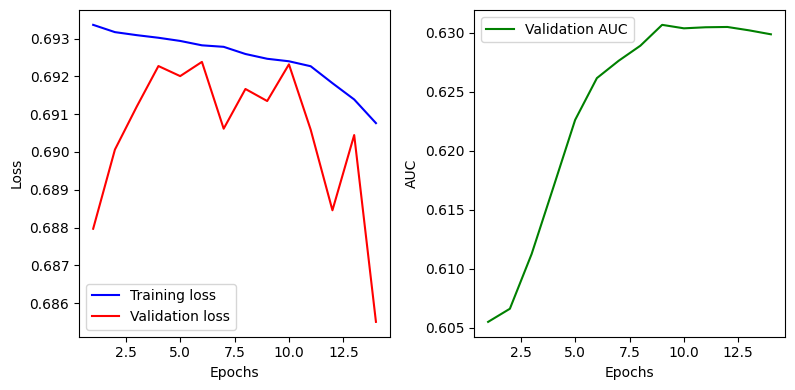

Best Hyperparameters: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.0, 'batch_size': 64}
Best Validation AUC: 0.6298


NameError: name 'best_model_2' is not defined

In [ ]:
# Train the model on the randomised parameter combinations
best_model_2_random, best_hyperparams_2_random, best_auc_2_random = manual_cross_validation(
    train_sequences_2,
    train_labels_2,
    random_search,
    num_folds=5,
    patience=5,
    output_path=output_dir
)

print(f'Best Hyperparameters: {best_hyperparams_2_random}')
print(f'Best Validation AUC: {best_auc_2_random:.4f}')

In [ ]:
# Save best model into pickle file
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_2_random, f)

# Save the best hyperparameters in a json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_2_random, f)

`Best Hyperparameters: {'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.0, 'batch_size': 64}`


We will run the Random Search three times with 50 iterations to see what hyperparameters seem to be best performing.

**Random Search - Run 2**

We will fix the sampling method and loss function to 'normal' for both for now as we do not need to test these parameters.

In [ ]:
n_iter_search = 50
random_search_2 = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

print(f"Total hyperparameter combinations: {len(random_search_2)}")

Total hyperparameter combinations: 50


In [ ]:
random_search_2[0]

{'sampling_method': 'normal',
 'num_epochs': 30,
 'loss': 'normal',
 'learning_rate': 0.0001,
 'layer_dim': 1,
 'hidden_dim': 128,
 'dropout_prob': 0.0,
 'batch_size': 128}

Epoch 0/29, Loss: 0.6776, Val Loss: 0.6687, Val AUC: 0.5609
Epoch 1/29, Loss: 0.6573, Val Loss: 0.6504, Val AUC: 0.5479
Epoch 2/29, Loss: 0.6377, Val Loss: 0.6379, Val AUC: 0.5331
Epoch 3/29, Loss: 0.6314, Val Loss: 0.6385, Val AUC: 0.5337
Epoch 4/29, Loss: 0.6308, Val Loss: 0.6378, Val AUC: 0.5389
Epoch 5/29, Loss: 0.6306, Val Loss: 0.6378, Val AUC: 0.5426
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.0, 'batch_size': 128}, Val AUC: 0.5426
Epoch 0/19, Loss: 0.6364, Val Loss: 0.6453, Val AUC: 0.5676
Epoch 1/19, Loss: 0.6341, Val Loss: 0.6379, Val AUC: 0.5749
Epoch 2/19, Loss: 0.6334, Val Loss: 0.6377, Val AUC: 0.5799
Epoch 3/19, Loss: 0.6324, Val Loss: 0.6391, Val AUC: 0.5767
Epoch 4/19, Loss: 0.6326, Val Loss: 0.6403, Val AUC: 0.5785
Epoch 5/19, Loss: 0.6325, Val Loss: 0.6379, Val AUC: 0.5816
Epoch 6/19, Loss: 0.6332, Val Loss: 0.6379, Val AUC: 0.5842
Epoch 7/19, Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6800, Val Loss: 0.6674, Val AUC: 0.4262
Epoch 1/9, Loss: 0.6543, Val Loss: 0.6474, Val AUC: 0.4821
Epoch 2/9, Loss: 0.6371, Val Loss: 0.6385, Val AUC: 0.4964
Epoch 3/9, Loss: 0.6318, Val Loss: 0.6386, Val AUC: 0.4999
Epoch 4/9, Loss: 0.6314, Val Loss: 0.6382, Val AUC: 0.5059
Epoch 5/9, Loss: 0.6315, Val Loss: 0.6383, Val AUC: 0.5088
Epoch 6/9, Loss: 0.6311, Val Loss: 0.6381, Val AUC: 0.5134
Epoch 7/9, Loss: 0.6312, Val Loss: 0.6380, Val AUC: 0.5177
Epoch 8/9, Loss: 0.6311, Val Loss: 0.6382, Val AUC: 0.5218
Epoch 9/9, Loss: 0.6311, Val Loss: 0.6380, Val AUC: 0.5267
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.5267
Epoch 0/19, Loss: 0.6918, Val Loss: 0.6901, Val AUC: 0.5617
Epoch 1/19, Loss: 0.6884, Val Loss: 0.6868, Val AUC: 0.5576
Epoch 2/19, Loss: 0.6848, Val Loss: 0.6834, Val AUC: 0.5559
Epoch 3/19, Loss: 0.6813, Val Loss: 0.68

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6546, Val Loss: 0.6520, Val AUC: 0.4825
Epoch 1/19, Loss: 0.6436, Val Loss: 0.6439, Val AUC: 0.4918
Epoch 2/19, Loss: 0.6362, Val Loss: 0.6397, Val AUC: 0.5020
Epoch 3/19, Loss: 0.6326, Val Loss: 0.6386, Val AUC: 0.5031
Epoch 4/19, Loss: 0.6319, Val Loss: 0.6386, Val AUC: 0.5057
Epoch 5/19, Loss: 0.6317, Val Loss: 0.6385, Val AUC: 0.5152
Epoch 6/19, Loss: 0.6315, Val Loss: 0.6386, Val AUC: 0.5207
Epoch 7/19, Loss: 0.6314, Val Loss: 0.6386, Val AUC: 0.5255
Epoch 8/19, Loss: 0.6315, Val Loss: 0.6384, Val AUC: 0.5287
Epoch 9/19, Loss: 0.6314, Val Loss: 0.6384, Val AUC: 0.5307
Epoch 10/19, Loss: 0.6313, Val Loss: 0.6384, Val AUC: 0.5349
Epoch 11/19, Loss: 0.6312, Val Loss: 0.6384, Val AUC: 0.5379
Epoch 12/19, Loss: 0.6312, Val Loss: 0.6383, Val AUC: 0.5400
Epoch 13/19, Loss: 0.6312, Val Loss: 0.6382, Val AUC: 0.5415
Epoch 14/19, Loss: 0.6314, Val Loss: 0.6382, Val AUC: 0.5418
Epoch 15/19, Loss: 0.6310, Val Loss: 0.6381, Val AUC: 0.5465
Epoch 16/19, Loss: 0.6309, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6700, Val Loss: 0.6485, Val AUC: 0.5405
Epoch 1/29, Loss: 0.6340, Val Loss: 0.6379, Val AUC: 0.5342
Epoch 2/29, Loss: 0.6307, Val Loss: 0.6385, Val AUC: 0.5402
Epoch 3/29, Loss: 0.6306, Val Loss: 0.6379, Val AUC: 0.5468
Epoch 4/29, Loss: 0.6304, Val Loss: 0.6369, Val AUC: 0.5526
Epoch 5/29, Loss: 0.6298, Val Loss: 0.6382, Val AUC: 0.5582
Epoch 6/29, Loss: 0.6300, Val Loss: 0.6368, Val AUC: 0.5674
Epoch 7/29, Loss: 0.6294, Val Loss: 0.6360, Val AUC: 0.5734
Epoch 8/29, Loss: 0.6285, Val Loss: 0.6353, Val AUC: 0.5816
Epoch 9/29, Loss: 0.6277, Val Loss: 0.6339, Val AUC: 0.5839
Epoch 10/29, Loss: 0.6264, Val Loss: 0.6337, Val AUC: 0.5893
Epoch 11/29, Loss: 0.6250, Val Loss: 0.6322, Val AUC: 0.5883
Epoch 12/29, Loss: 0.6249, Val Loss: 0.6307, Val AUC: 0.5878
Epoch 13/29, Loss: 0.6224, Val Loss: 0.6334, Val AUC: 0.5875
Epoch 14/29, Loss: 0.6223, Val Loss: 0.6294, Val AUC: 0.5880
Epoch 15/29, Loss: 0.6212, Val Loss: 0.6303, Val AUC: 0.5892
Early stopping
Params: {'sampling_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6343, Val Loss: 0.6387, Val AUC: 0.5598
Epoch 2/9, Loss: 0.6318, Val Loss: 0.6387, Val AUC: 0.5593
Epoch 3/9, Loss: 0.6323, Val Loss: 0.6398, Val AUC: 0.5681
Epoch 4/9, Loss: 0.6319, Val Loss: 0.6381, Val AUC: 0.5689
Epoch 5/9, Loss: 0.6317, Val Loss: 0.6379, Val AUC: 0.5701
Epoch 6/9, Loss: 0.6319, Val Loss: 0.6377, Val AUC: 0.5715
Epoch 7/9, Loss: 0.6316, Val Loss: 0.6375, Val AUC: 0.5735
Epoch 8/9, Loss: 0.6314, Val Loss: 0.6371, Val AUC: 0.5761
Epoch 9/9, Loss: 0.6313, Val Loss: 0.6366, Val AUC: 0.5773
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5773
Epoch 0/9, Loss: 0.6845, Val Loss: 0.6840, Val AUC: 0.4419
Epoch 1/9, Loss: 0.6825, Val Loss: 0.6821, Val AUC: 0.4635
Epoch 2/9, Loss: 0.6804, Val Loss: 0.6801, Val AUC: 0.4712
Epoch 3/9, Loss: 0.6782, Val Loss: 0.6780, Val AUC: 0.4690
Epoch 4/9, Loss: 0.6759, Val Loss: 0.6757, V

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6355, Val Loss: 0.6386, Val AUC: 0.5630
Epoch 1/19, Loss: 0.6335, Val Loss: 0.6378, Val AUC: 0.5730
Epoch 2/19, Loss: 0.6316, Val Loss: 0.6372, Val AUC: 0.5736
Epoch 3/19, Loss: 0.6313, Val Loss: 0.6442, Val AUC: 0.5754
Epoch 4/19, Loss: 0.6325, Val Loss: 0.6364, Val AUC: 0.5782
Epoch 5/19, Loss: 0.6306, Val Loss: 0.6338, Val AUC: 0.5828
Epoch 6/19, Loss: 0.6339, Val Loss: 0.6362, Val AUC: 0.5878
Epoch 7/19, Loss: 0.6296, Val Loss: 0.6349, Val AUC: 0.5882
Epoch 8/19, Loss: 0.6291, Val Loss: 0.6354, Val AUC: 0.5864
Epoch 9/19, Loss: 0.6292, Val Loss: 0.6348, Val AUC: 0.5925
Epoch 10/19, Loss: 0.6266, Val Loss: 0.6300, Val AUC: 0.5915
Epoch 11/19, Loss: 0.6282, Val Loss: 0.6340, Val AUC: 0.5967
Epoch 12/19, Loss: 0.6255, Val Loss: 0.6304, Val AUC: 0.5885
Epoch 13/19, Loss: 0.6272, Val Loss: 0.6330, Val AUC: 0.5977
Epoch 14/19, Loss: 0.6263, Val Loss: 0.6301, Val AUC: 0.5989
Epoch 15/19, Loss: 0.6255, Val Loss: 0.6313, Val AUC: 0.5977
Epoch 16/19, Loss: 0.6246, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6390, Val Loss: 0.6389, Val AUC: 0.5458
Epoch 1/9, Loss: 0.6332, Val Loss: 0.6389, Val AUC: 0.5328
Epoch 2/9, Loss: 0.6327, Val Loss: 0.6381, Val AUC: 0.5445
Epoch 3/9, Loss: 0.6327, Val Loss: 0.6376, Val AUC: 0.5448
Epoch 4/9, Loss: 0.6328, Val Loss: 0.6398, Val AUC: 0.5392
Epoch 5/9, Loss: 0.6313, Val Loss: 0.6394, Val AUC: 0.5517
Epoch 6/9, Loss: 0.6318, Val Loss: 0.6358, Val AUC: 0.5791
Epoch 7/9, Loss: 0.6309, Val Loss: 0.6369, Val AUC: 0.5392
Epoch 8/9, Loss: 0.6315, Val Loss: 0.6365, Val AUC: 0.5616
Epoch 9/9, Loss: 0.6300, Val Loss: 0.6362, Val AUC: 0.5814
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5814
Epoch 0/9, Loss: 0.6780, Val Loss: 0.6539, Val AUC: 0.5041
Epoch 1/9, Loss: 0.6373, Val Loss: 0.6390, Val AUC: 0.5084
Epoch 2/9, Loss: 0.6320, Val Loss: 0.6385, Val AUC: 0.5214
Epoch 3/9, Loss: 0.6319, Val Loss: 0.6380, Val

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6720, Val Loss: 0.6639, Val AUC: 0.5063
Epoch 1/9, Loss: 0.6532, Val Loss: 0.6471, Val AUC: 0.4972
Epoch 2/9, Loss: 0.6363, Val Loss: 0.6382, Val AUC: 0.5004
Epoch 3/9, Loss: 0.6313, Val Loss: 0.6383, Val AUC: 0.5075
Epoch 4/9, Loss: 0.6310, Val Loss: 0.6381, Val AUC: 0.5073
Epoch 5/9, Loss: 0.6311, Val Loss: 0.6384, Val AUC: 0.5107
Epoch 6/9, Loss: 0.6310, Val Loss: 0.6377, Val AUC: 0.5185
Epoch 7/9, Loss: 0.6306, Val Loss: 0.6380, Val AUC: 0.5231
Epoch 8/9, Loss: 0.6306, Val Loss: 0.6380, Val AUC: 0.5264
Epoch 9/9, Loss: 0.6305, Val Loss: 0.6375, Val AUC: 0.5298
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 128}, Val AUC: 0.5298
Epoch 0/9, Loss: 0.6596, Val Loss: 0.6512, Val AUC: 0.5283
Epoch 1/9, Loss: 0.6394, Val Loss: 0.6385, Val AUC: 0.5242
Epoch 2/9, Loss: 0.6319, Val Loss: 0.6384, Val AUC: 0.5247
Epoch 3/9, Loss: 0.6325, Val Loss: 0.6381

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6741, Val Loss: 0.6651, Val AUC: 0.5519
Epoch 2/19, Loss: 0.6517, Val Loss: 0.6441, Val AUC: 0.5403
Epoch 3/19, Loss: 0.6332, Val Loss: 0.6390, Val AUC: 0.5362
Epoch 4/19, Loss: 0.6310, Val Loss: 0.6381, Val AUC: 0.5451
Epoch 5/19, Loss: 0.6308, Val Loss: 0.6379, Val AUC: 0.5465
Epoch 6/19, Loss: 0.6308, Val Loss: 0.6381, Val AUC: 0.5512
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5512
Epoch 0/29, Loss: 0.6887, Val Loss: 0.6393, Val AUC: 0.4712
Epoch 1/29, Loss: 0.6341, Val Loss: 0.6386, Val AUC: 0.5478
Epoch 2/29, Loss: 0.6339, Val Loss: 0.6436, Val AUC: 0.5753
Epoch 3/29, Loss: 0.6337, Val Loss: 0.6496, Val AUC: 0.5882
Epoch 4/29, Loss: 0.6341, Val Loss: 0.6398, Val AUC: 0.5924
Epoch 5/29, Loss: 0.6324, Val Loss: 0.6387, Val AUC: 0.5945
Epoch 6/29, Loss: 0.6329, Val Loss: 0.6391, Val AUC: 0.5924
Epoch 7/29, Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6378, Val Loss: 0.6377, Val AUC: 0.5592
Epoch 1/9, Loss: 0.6311, Val Loss: 0.6372, Val AUC: 0.5692
Epoch 2/9, Loss: 0.6313, Val Loss: 0.6362, Val AUC: 0.5735
Epoch 3/9, Loss: 0.6317, Val Loss: 0.6358, Val AUC: 0.5769
Epoch 4/9, Loss: 0.6307, Val Loss: 0.6361, Val AUC: 0.5793
Epoch 5/9, Loss: 0.6298, Val Loss: 0.6344, Val AUC: 0.5842
Epoch 6/9, Loss: 0.6266, Val Loss: 0.6290, Val AUC: 0.5892
Epoch 7/9, Loss: 0.6258, Val Loss: 0.6403, Val AUC: 0.5858
Epoch 8/9, Loss: 0.6287, Val Loss: 0.6282, Val AUC: 0.5872
Epoch 9/9, Loss: 0.6244, Val Loss: 0.6266, Val AUC: 0.5905
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5905
Epoch 0/29, Loss: 0.6437, Val Loss: 0.6389, Val AUC: 0.5330
Epoch 1/29, Loss: 0.6337, Val Loss: 0.6390, Val AUC: 0.5462
Epoch 2/29, Loss: 0.6324, Val Loss: 0.6385, Val AUC: 0.5589
Epoch 3/29, Loss: 0.6322, Val Loss: 0.6418

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6659, Val Loss: 0.6495, Val AUC: 0.4699
Epoch 1/19, Loss: 0.6357, Val Loss: 0.6386, Val AUC: 0.4887
Epoch 2/19, Loss: 0.6318, Val Loss: 0.6387, Val AUC: 0.5020
Epoch 3/19, Loss: 0.6315, Val Loss: 0.6388, Val AUC: 0.5092
Epoch 4/19, Loss: 0.6315, Val Loss: 0.6382, Val AUC: 0.5214
Epoch 5/19, Loss: 0.6314, Val Loss: 0.6384, Val AUC: 0.5252
Epoch 6/19, Loss: 0.6314, Val Loss: 0.6381, Val AUC: 0.5371
Epoch 7/19, Loss: 0.6312, Val Loss: 0.6380, Val AUC: 0.5389
Epoch 8/19, Loss: 0.6307, Val Loss: 0.6375, Val AUC: 0.5488
Epoch 9/19, Loss: 0.6309, Val Loss: 0.6373, Val AUC: 0.5535
Epoch 10/19, Loss: 0.6310, Val Loss: 0.6382, Val AUC: 0.5535
Epoch 11/19, Loss: 0.6298, Val Loss: 0.6369, Val AUC: 0.5577
Epoch 12/19, Loss: 0.6296, Val Loss: 0.6377, Val AUC: 0.5606
Epoch 13/19, Loss: 0.6292, Val Loss: 0.6371, Val AUC: 0.5631
Epoch 14/19, Loss: 0.6288, Val Loss: 0.6353, Val AUC: 0.5651
Epoch 15/19, Loss: 0.6274, Val Loss: 0.6345, Val AUC: 0.5686
Epoch 16/19, Loss: 0.6260, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6844, Val Loss: 0.6747, Val AUC: 0.4766
Epoch 1/9, Loss: 0.6599, Val Loss: 0.6567, Val AUC: 0.5349
Epoch 2/9, Loss: 0.6382, Val Loss: 0.6460, Val AUC: 0.5372
Epoch 3/9, Loss: 0.6294, Val Loss: 0.6477, Val AUC: 0.5399
Epoch 4/9, Loss: 0.6293, Val Loss: 0.6477, Val AUC: 0.5443
Epoch 5/9, Loss: 0.6289, Val Loss: 0.6468, Val AUC: 0.5491
Epoch 6/9, Loss: 0.6288, Val Loss: 0.6466, Val AUC: 0.5507
Epoch 7/9, Loss: 0.6288, Val Loss: 0.6461, Val AUC: 0.5563
Epoch 8/9, Loss: 0.6286, Val Loss: 0.6470, Val AUC: 0.5573
Epoch 9/9, Loss: 0.6285, Val Loss: 0.6460, Val AUC: 0.5575
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.5575
Epoch 0/19, Loss: 0.6771, Val Loss: 0.6785, Val AUC: 0.5358
Epoch 1/19, Loss: 0.6746, Val Loss: 0.6765, Val AUC: 0.5379
Epoch 2/19, Loss: 0.6727, Val Loss: 0.6746, Val AUC: 0.5404
Epoch 3/19, Loss: 0.6701, Val Loss: 0.67

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.7154, Val Loss: 0.7035, Val AUC: 0.4332
Epoch 1/19, Loss: 0.6957, Val Loss: 0.6872, Val AUC: 0.4571
Epoch 2/19, Loss: 0.6758, Val Loss: 0.6697, Val AUC: 0.4860
Epoch 3/19, Loss: 0.6547, Val Loss: 0.6530, Val AUC: 0.4980
Epoch 4/19, Loss: 0.6360, Val Loss: 0.6464, Val AUC: 0.4974
Epoch 5/19, Loss: 0.6306, Val Loss: 0.6470, Val AUC: 0.5055
Epoch 6/19, Loss: 0.6295, Val Loss: 0.6475, Val AUC: 0.5092
Epoch 7/19, Loss: 0.6294, Val Loss: 0.6473, Val AUC: 0.5141
Epoch 8/19, Loss: 0.6293, Val Loss: 0.6477, Val AUC: 0.5165
Epoch 9/19, Loss: 0.6293, Val Loss: 0.6475, Val AUC: 0.5183
Epoch 10/19, Loss: 0.6292, Val Loss: 0.6474, Val AUC: 0.5199
Epoch 11/19, Loss: 0.6292, Val Loss: 0.6475, Val AUC: 0.5227
Epoch 12/19, Loss: 0.6292, Val Loss: 0.6471, Val AUC: 0.5245
Epoch 13/19, Loss: 0.6292, Val Loss: 0.6473, Val AUC: 0.5294
Epoch 14/19, Loss: 0.6290, Val Loss: 0.6466, Val AUC: 0.5315
Epoch 15/19, Loss: 0.6289, Val Loss: 0.6471, Val AUC: 0.5324
Epoch 16/19, Loss: 0.6289, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6792, Val Loss: 0.6577, Val AUC: 0.5162
Epoch 1/29, Loss: 0.6337, Val Loss: 0.6480, Val AUC: 0.5279
Epoch 2/29, Loss: 0.6294, Val Loss: 0.6488, Val AUC: 0.5386
Epoch 3/29, Loss: 0.6293, Val Loss: 0.6474, Val AUC: 0.5423
Epoch 4/29, Loss: 0.6293, Val Loss: 0.6456, Val AUC: 0.5473
Epoch 5/29, Loss: 0.6289, Val Loss: 0.6474, Val AUC: 0.5511
Epoch 6/29, Loss: 0.6289, Val Loss: 0.6466, Val AUC: 0.5571
Epoch 7/29, Loss: 0.6284, Val Loss: 0.6457, Val AUC: 0.5596
Epoch 8/29, Loss: 0.6284, Val Loss: 0.6465, Val AUC: 0.5632
Epoch 9/29, Loss: 0.6278, Val Loss: 0.6461, Val AUC: 0.5677
Epoch 10/29, Loss: 0.6278, Val Loss: 0.6452, Val AUC: 0.5713
Epoch 11/29, Loss: 0.6274, Val Loss: 0.6438, Val AUC: 0.5709
Epoch 12/29, Loss: 0.6274, Val Loss: 0.6442, Val AUC: 0.5700
Epoch 13/29, Loss: 0.6261, Val Loss: 0.6448, Val AUC: 0.5741
Epoch 14/29, Loss: 0.6254, Val Loss: 0.6433, Val AUC: 0.5753
Epoch 15/29, Loss: 0.6249, Val Loss: 0.6409, Val AUC: 0.5740
Epoch 16/29, Loss: 0.6239, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6307, Val Loss: 0.6466, Val AUC: 0.5467
Epoch 2/9, Loss: 0.6299, Val Loss: 0.6465, Val AUC: 0.5490
Epoch 3/9, Loss: 0.6306, Val Loss: 0.6468, Val AUC: 0.5520
Epoch 4/9, Loss: 0.6301, Val Loss: 0.6459, Val AUC: 0.5492
Epoch 5/9, Loss: 0.6293, Val Loss: 0.6457, Val AUC: 0.5519
Epoch 6/9, Loss: 0.6301, Val Loss: 0.6453, Val AUC: 0.5532
Epoch 7/9, Loss: 0.6304, Val Loss: 0.6459, Val AUC: 0.5475
Epoch 8/9, Loss: 0.6290, Val Loss: 0.6484, Val AUC: 0.5519
Epoch 9/9, Loss: 0.6282, Val Loss: 0.6440, Val AUC: 0.5551
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5551
Epoch 0/9, Loss: 0.6802, Val Loss: 0.6812, Val AUC: 0.5417
Epoch 1/9, Loss: 0.6782, Val Loss: 0.6796, Val AUC: 0.5389
Epoch 2/9, Loss: 0.6763, Val Loss: 0.6781, Val AUC: 0.5444
Epoch 3/9, Loss: 0.6745, Val Loss: 0.6765, Val AUC: 0.5423
Epoch 4/9, Loss: 0.6726, Val Loss: 0.6748, V

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6322, Val Loss: 0.6476, Val AUC: 0.5472
Epoch 1/19, Loss: 0.6307, Val Loss: 0.6455, Val AUC: 0.5503
Epoch 2/19, Loss: 0.6308, Val Loss: 0.6457, Val AUC: 0.5470
Epoch 3/19, Loss: 0.6298, Val Loss: 0.6445, Val AUC: 0.5513
Epoch 4/19, Loss: 0.6277, Val Loss: 0.6568, Val AUC: 0.5497
Epoch 5/19, Loss: 0.6318, Val Loss: 0.6454, Val AUC: 0.5512
Epoch 6/19, Loss: 0.6299, Val Loss: 0.6487, Val AUC: 0.5497
Epoch 7/19, Loss: 0.6265, Val Loss: 0.6423, Val AUC: 0.5646
Epoch 8/19, Loss: 0.6252, Val Loss: 0.6476, Val AUC: 0.5672
Epoch 9/19, Loss: 0.6258, Val Loss: 0.6402, Val AUC: 0.5674
Epoch 10/19, Loss: 0.6240, Val Loss: 0.6373, Val AUC: 0.5676
Epoch 11/19, Loss: 0.6251, Val Loss: 0.6424, Val AUC: 0.5616
Epoch 12/19, Loss: 0.6237, Val Loss: 0.6406, Val AUC: 0.5639
Epoch 13/19, Loss: 0.6254, Val Loss: 0.6404, Val AUC: 0.5659
Epoch 14/19, Loss: 0.6234, Val Loss: 0.6475, Val AUC: 0.5635
Epoch 15/19, Loss: 0.6212, Val Loss: 0.6402, Val AUC: 0.5653
Early stopping
Params: {'sampling_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6335, Val Loss: 0.6470, Val AUC: 0.5360
Epoch 1/9, Loss: 0.6307, Val Loss: 0.6467, Val AUC: 0.5364
Epoch 2/9, Loss: 0.6303, Val Loss: 0.6494, Val AUC: 0.5421
Epoch 3/9, Loss: 0.6296, Val Loss: 0.6479, Val AUC: 0.5418
Epoch 4/9, Loss: 0.6289, Val Loss: 0.6465, Val AUC: 0.5484
Epoch 5/9, Loss: 0.6323, Val Loss: 0.6477, Val AUC: 0.5300
Epoch 6/9, Loss: 0.6296, Val Loss: 0.6438, Val AUC: 0.5498
Epoch 7/9, Loss: 0.6278, Val Loss: 0.6446, Val AUC: 0.5447
Epoch 8/9, Loss: 0.6279, Val Loss: 0.6460, Val AUC: 0.5560
Epoch 9/9, Loss: 0.6288, Val Loss: 0.6432, Val AUC: 0.5585
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5585
Epoch 0/9, Loss: 0.6722, Val Loss: 0.6581, Val AUC: 0.5466
Epoch 1/9, Loss: 0.6351, Val Loss: 0.6509, Val AUC: 0.5427
Epoch 2/9, Loss: 0.6293, Val Loss: 0.6474, Val AUC: 0.5492
Epoch 3/9, Loss: 0.6284, Val Loss: 0.6457, Val

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6492, Val Loss: 0.6508, Val AUC: 0.5453
Epoch 2/9, Loss: 0.6347, Val Loss: 0.6459, Val AUC: 0.5484
Epoch 3/9, Loss: 0.6292, Val Loss: 0.6472, Val AUC: 0.5542
Epoch 4/9, Loss: 0.6286, Val Loss: 0.6462, Val AUC: 0.5575
Epoch 5/9, Loss: 0.6286, Val Loss: 0.6469, Val AUC: 0.5586
Epoch 6/9, Loss: 0.6287, Val Loss: 0.6468, Val AUC: 0.5578
Epoch 7/9, Loss: 0.6285, Val Loss: 0.6468, Val AUC: 0.5578
Epoch 8/9, Loss: 0.6281, Val Loss: 0.6457, Val AUC: 0.5578
Epoch 9/9, Loss: 0.6281, Val Loss: 0.6462, Val AUC: 0.5600
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 128}, Val AUC: 0.5600
Epoch 0/9, Loss: 0.6956, Val Loss: 0.6786, Val AUC: 0.5474
Epoch 1/9, Loss: 0.6489, Val Loss: 0.6462, Val AUC: 0.5486
Epoch 2/9, Loss: 0.6292, Val Loss: 0.6476, Val AUC: 0.5489
Epoch 3/9, Loss: 0.6303, Val Loss: 0.6464, Val AUC: 0.5501
Epoch 4/9, Loss: 0.6295, Val Loss: 0.6491

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6617, Val Loss: 0.6573, Val AUC: 0.5425
Epoch 2/19, Loss: 0.6394, Val Loss: 0.6453, Val AUC: 0.5473
Epoch 3/19, Loss: 0.6285, Val Loss: 0.6485, Val AUC: 0.5507
Epoch 4/19, Loss: 0.6284, Val Loss: 0.6456, Val AUC: 0.5523
Epoch 5/19, Loss: 0.6285, Val Loss: 0.6466, Val AUC: 0.5579
Epoch 6/19, Loss: 0.6287, Val Loss: 0.6460, Val AUC: 0.5607
Epoch 7/19, Loss: 0.6285, Val Loss: 0.6468, Val AUC: 0.5635
Epoch 8/19, Loss: 0.6282, Val Loss: 0.6451, Val AUC: 0.5608
Epoch 9/19, Loss: 0.6276, Val Loss: 0.6466, Val AUC: 0.5702
Epoch 10/19, Loss: 0.6280, Val Loss: 0.6459, Val AUC: 0.5722
Epoch 11/19, Loss: 0.6273, Val Loss: 0.6451, Val AUC: 0.5720
Epoch 12/19, Loss: 0.6276, Val Loss: 0.6450, Val AUC: 0.5733
Epoch 13/19, Loss: 0.6272, Val Loss: 0.6449, Val AUC: 0.5748
Epoch 14/19, Loss: 0.6266, Val Loss: 0.6451, Val AUC: 0.5752
Epoch 15/19, Loss: 0.6268, Val Loss: 0.6444, Val AUC: 0.5755
Epoch 16/19, Loss: 0.6266, Val Loss: 0.6444, Val AUC: 0.5765
Epoch 17/19, Loss: 0.6262, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6335, Val Loss: 0.6453, Val AUC: 0.5477
Epoch 1/9, Loss: 0.6312, Val Loss: 0.6502, Val AUC: 0.5554
Epoch 2/9, Loss: 0.6298, Val Loss: 0.6485, Val AUC: 0.5588
Epoch 3/9, Loss: 0.6292, Val Loss: 0.6459, Val AUC: 0.5642
Epoch 4/9, Loss: 0.6277, Val Loss: 0.6498, Val AUC: 0.5672
Epoch 5/9, Loss: 0.6259, Val Loss: 0.6416, Val AUC: 0.5691
Epoch 6/9, Loss: 0.6253, Val Loss: 0.6395, Val AUC: 0.5702
Epoch 7/9, Loss: 0.6227, Val Loss: 0.6418, Val AUC: 0.5721
Epoch 8/9, Loss: 0.6217, Val Loss: 0.6363, Val AUC: 0.5761
Epoch 9/9, Loss: 0.6196, Val Loss: 0.6349, Val AUC: 0.5766
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5766
Epoch 0/29, Loss: 0.6369, Val Loss: 0.6523, Val AUC: 0.5592
Epoch 1/29, Loss: 0.6307, Val Loss: 0.6473, Val AUC: 0.5786
Epoch 2/29, Loss: 0.6304, Val Loss: 0.6461, Val AUC: 0.5764
Epoch 3/29, Loss: 0.6302, Val Loss: 0.6488

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6719, Val Loss: 0.6525, Val AUC: 0.5429
Epoch 1/19, Loss: 0.6324, Val Loss: 0.6457, Val AUC: 0.5489
Epoch 2/19, Loss: 0.6285, Val Loss: 0.6451, Val AUC: 0.5489
Epoch 3/19, Loss: 0.6282, Val Loss: 0.6465, Val AUC: 0.5536
Epoch 4/19, Loss: 0.6281, Val Loss: 0.6458, Val AUC: 0.5523
Epoch 5/19, Loss: 0.6281, Val Loss: 0.6456, Val AUC: 0.5527
Epoch 6/19, Loss: 0.6275, Val Loss: 0.6448, Val AUC: 0.5601
Epoch 7/19, Loss: 0.6278, Val Loss: 0.6440, Val AUC: 0.5638
Epoch 8/19, Loss: 0.6271, Val Loss: 0.6445, Val AUC: 0.5649
Epoch 9/19, Loss: 0.6263, Val Loss: 0.6446, Val AUC: 0.5656
Epoch 10/19, Loss: 0.6264, Val Loss: 0.6424, Val AUC: 0.5687
Epoch 11/19, Loss: 0.6250, Val Loss: 0.6427, Val AUC: 0.5700
Epoch 12/19, Loss: 0.6243, Val Loss: 0.6408, Val AUC: 0.5700
Epoch 13/19, Loss: 0.6243, Val Loss: 0.6402, Val AUC: 0.5722
Epoch 14/19, Loss: 0.6225, Val Loss: 0.6457, Val AUC: 0.5720
Epoch 15/19, Loss: 0.6222, Val Loss: 0.6422, Val AUC: 0.5727
Epoch 16/19, Loss: 0.6209, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6740, Val Loss: 0.6644, Val AUC: 0.5409
Epoch 1/9, Loss: 0.6520, Val Loss: 0.6447, Val AUC: 0.5494
Epoch 2/9, Loss: 0.6338, Val Loss: 0.6376, Val AUC: 0.5567
Epoch 3/9, Loss: 0.6313, Val Loss: 0.6372, Val AUC: 0.5591
Epoch 4/9, Loss: 0.6310, Val Loss: 0.6370, Val AUC: 0.5609
Epoch 5/9, Loss: 0.6308, Val Loss: 0.6369, Val AUC: 0.5620
Epoch 6/9, Loss: 0.6308, Val Loss: 0.6368, Val AUC: 0.5635
Epoch 7/9, Loss: 0.6306, Val Loss: 0.6366, Val AUC: 0.5673
Epoch 8/9, Loss: 0.6307, Val Loss: 0.6366, Val AUC: 0.5690
Epoch 9/9, Loss: 0.6305, Val Loss: 0.6365, Val AUC: 0.5693
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.5693
Epoch 0/19, Loss: 0.7256, Val Loss: 0.7225, Val AUC: 0.5570
Epoch 1/19, Loss: 0.7220, Val Loss: 0.7191, Val AUC: 0.5619
Epoch 2/19, Loss: 0.7185, Val Loss: 0.7157, Val AUC: 0.5649
Epoch 3/19, Loss: 0.7151, Val Loss: 0.71

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6682, Val Loss: 0.6627, Val AUC: 0.4784
Epoch 1/19, Loss: 0.6555, Val Loss: 0.6520, Val AUC: 0.5113
Epoch 2/19, Loss: 0.6450, Val Loss: 0.6439, Val AUC: 0.5361
Epoch 3/19, Loss: 0.6373, Val Loss: 0.6387, Val AUC: 0.5516
Epoch 4/19, Loss: 0.6332, Val Loss: 0.6372, Val AUC: 0.5588
Epoch 5/19, Loss: 0.6320, Val Loss: 0.6372, Val AUC: 0.5618
Epoch 6/19, Loss: 0.6318, Val Loss: 0.6371, Val AUC: 0.5647
Epoch 7/19, Loss: 0.6317, Val Loss: 0.6371, Val AUC: 0.5707
Epoch 8/19, Loss: 0.6316, Val Loss: 0.6370, Val AUC: 0.5744
Epoch 9/19, Loss: 0.6316, Val Loss: 0.6368, Val AUC: 0.5790
Epoch 10/19, Loss: 0.6315, Val Loss: 0.6368, Val AUC: 0.5818
Epoch 11/19, Loss: 0.6314, Val Loss: 0.6367, Val AUC: 0.5863
Epoch 12/19, Loss: 0.6313, Val Loss: 0.6366, Val AUC: 0.5854
Epoch 13/19, Loss: 0.6314, Val Loss: 0.6366, Val AUC: 0.5849
Epoch 14/19, Loss: 0.6311, Val Loss: 0.6364, Val AUC: 0.5823
Epoch 15/19, Loss: 0.6310, Val Loss: 0.6362, Val AUC: 0.5835
Epoch 16/19, Loss: 0.6307, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6727, Val Loss: 0.6434, Val AUC: 0.5582
Epoch 1/29, Loss: 0.6324, Val Loss: 0.6374, Val AUC: 0.5603
Epoch 2/29, Loss: 0.6319, Val Loss: 0.6369, Val AUC: 0.5661
Epoch 3/29, Loss: 0.6314, Val Loss: 0.6367, Val AUC: 0.5718
Epoch 4/29, Loss: 0.6315, Val Loss: 0.6366, Val AUC: 0.5724
Epoch 5/29, Loss: 0.6314, Val Loss: 0.6365, Val AUC: 0.5710
Epoch 6/29, Loss: 0.6307, Val Loss: 0.6363, Val AUC: 0.5742
Epoch 7/29, Loss: 0.6306, Val Loss: 0.6361, Val AUC: 0.5767
Epoch 8/29, Loss: 0.6303, Val Loss: 0.6362, Val AUC: 0.5770
Epoch 9/29, Loss: 0.6301, Val Loss: 0.6360, Val AUC: 0.5764
Epoch 10/29, Loss: 0.6295, Val Loss: 0.6352, Val AUC: 0.5767
Epoch 11/29, Loss: 0.6297, Val Loss: 0.6351, Val AUC: 0.5755
Epoch 12/29, Loss: 0.6287, Val Loss: 0.6342, Val AUC: 0.5804
Epoch 13/29, Loss: 0.6278, Val Loss: 0.6334, Val AUC: 0.5811
Epoch 14/29, Loss: 0.6271, Val Loss: 0.6328, Val AUC: 0.5795
Epoch 15/29, Loss: 0.6258, Val Loss: 0.6314, Val AUC: 0.5789
Epoch 16/29, Loss: 0.6244, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6353, Val Loss: 0.6388, Val AUC: 0.5663
Epoch 2/9, Loss: 0.6327, Val Loss: 0.6373, Val AUC: 0.5642
Epoch 3/9, Loss: 0.6322, Val Loss: 0.6399, Val AUC: 0.5670
Epoch 4/9, Loss: 0.6327, Val Loss: 0.6372, Val AUC: 0.5679
Epoch 5/9, Loss: 0.6322, Val Loss: 0.6403, Val AUC: 0.5674
Epoch 6/9, Loss: 0.6312, Val Loss: 0.6366, Val AUC: 0.5638
Epoch 7/9, Loss: 0.6328, Val Loss: 0.6366, Val AUC: 0.5583
Epoch 8/9, Loss: 0.6313, Val Loss: 0.6369, Val AUC: 0.5624
Epoch 9/9, Loss: 0.6309, Val Loss: 0.6374, Val AUC: 0.5654
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5654
Epoch 0/9, Loss: 0.6779, Val Loss: 0.6778, Val AUC: 0.5042
Epoch 1/9, Loss: 0.6762, Val Loss: 0.6762, Val AUC: 0.5182
Epoch 2/9, Loss: 0.6745, Val Loss: 0.6746, Val AUC: 0.5380
Epoch 3/9, Loss: 0.6728, Val Loss: 0.6729, Val AUC: 0.5513
Epoch 4/9, Loss: 0.6710, Val 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6352, Val Loss: 0.6375, Val AUC: 0.5681
Epoch 1/19, Loss: 0.6347, Val Loss: 0.6371, Val AUC: 0.5607
Epoch 2/19, Loss: 0.6322, Val Loss: 0.6389, Val AUC: 0.5708
Epoch 3/19, Loss: 0.6327, Val Loss: 0.6367, Val AUC: 0.5653
Epoch 4/19, Loss: 0.6315, Val Loss: 0.6389, Val AUC: 0.5672
Epoch 5/19, Loss: 0.6309, Val Loss: 0.6371, Val AUC: 0.5559
Epoch 6/19, Loss: 0.6303, Val Loss: 0.6370, Val AUC: 0.5699
Epoch 7/19, Loss: 0.6304, Val Loss: 0.6365, Val AUC: 0.5623
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5623
Epoch 0/9, Loss: 0.6428, Val Loss: 0.6414, Val AUC: 0.5728
Epoch 1/9, Loss: 0.6335, Val Loss: 0.6372, Val AUC: 0.5727
Epoch 2/9, Loss: 0.6316, Val Loss: 0.6389, Val AUC: 0.5720
Epoch 3/9, Loss: 0.6303, Val Loss: 0.6339, Val AUC: 0.5740
Epoch 4/9, Loss: 0.6257, Val Loss: 0.6627, Val AUC: 0.5723
Epoch 5/9, Loss: 0.6295

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6369, Val Loss: 0.6396, Val AUC: 0.5542
Epoch 1/9, Loss: 0.6332, Val Loss: 0.6402, Val AUC: 0.5575
Epoch 2/9, Loss: 0.6329, Val Loss: 0.6372, Val AUC: 0.5619
Epoch 3/9, Loss: 0.6322, Val Loss: 0.6366, Val AUC: 0.5563
Epoch 4/9, Loss: 0.6329, Val Loss: 0.6402, Val AUC: 0.5506
Epoch 5/9, Loss: 0.6313, Val Loss: 0.6363, Val AUC: 0.5649
Epoch 6/9, Loss: 0.6331, Val Loss: 0.6366, Val AUC: 0.5611
Epoch 7/9, Loss: 0.6315, Val Loss: 0.6359, Val AUC: 0.5541
Epoch 8/9, Loss: 0.6305, Val Loss: 0.6356, Val AUC: 0.5643
Epoch 9/9, Loss: 0.6308, Val Loss: 0.6369, Val AUC: 0.5545
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5545
Epoch 0/9, Loss: 0.6757, Val Loss: 0.6544, Val AUC: 0.5468
Epoch 1/9, Loss: 0.6400, Val Loss: 0.6377, Val AUC: 0.5542
Epoch 2/9, Loss: 0.6323, Val Loss: 0.6374, Val AUC: 0.5597
Epoch 3/9, Loss: 0.6318, Val Loss: 0.6374, Val

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6538, Val Loss: 0.6488, Val AUC: 0.5621
Epoch 2/9, Loss: 0.6383, Val Loss: 0.6373, Val AUC: 0.5643
Epoch 3/9, Loss: 0.6316, Val Loss: 0.6373, Val AUC: 0.5641
Epoch 4/9, Loss: 0.6312, Val Loss: 0.6370, Val AUC: 0.5669
Epoch 5/9, Loss: 0.6311, Val Loss: 0.6369, Val AUC: 0.5700
Epoch 6/9, Loss: 0.6309, Val Loss: 0.6369, Val AUC: 0.5707
Epoch 7/9, Loss: 0.6309, Val Loss: 0.6367, Val AUC: 0.5693
Epoch 8/9, Loss: 0.6308, Val Loss: 0.6369, Val AUC: 0.5697
Epoch 9/9, Loss: 0.6308, Val Loss: 0.6367, Val AUC: 0.5707
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 128}, Val AUC: 0.5707
Epoch 0/9, Loss: 0.6749, Val Loss: 0.6623, Val AUC: 0.5187
Epoch 1/9, Loss: 0.6460, Val Loss: 0.6377, Val AUC: 0.5539
Epoch 2/9, Loss: 0.6323, Val Loss: 0.6376, Val AUC: 0.5586
Epoch 3/9, Loss: 0.6322, Val Loss: 0.6378, Val AUC: 0.5658
Epoch 4/9, Loss: 0.6314, Val Loss: 0.6376

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6647, Val Loss: 0.6558, Val AUC: 0.5671
Epoch 2/19, Loss: 0.6433, Val Loss: 0.6384, Val AUC: 0.5627
Epoch 3/19, Loss: 0.6316, Val Loss: 0.6385, Val AUC: 0.5651
Epoch 4/19, Loss: 0.6313, Val Loss: 0.6368, Val AUC: 0.5658
Epoch 5/19, Loss: 0.6314, Val Loss: 0.6370, Val AUC: 0.5673
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5673
Epoch 0/29, Loss: 0.6874, Val Loss: 0.6385, Val AUC: 0.5582
Epoch 1/29, Loss: 0.6354, Val Loss: 0.6383, Val AUC: 0.5503
Epoch 2/29, Loss: 0.6328, Val Loss: 0.6393, Val AUC: 0.5586
Epoch 3/29, Loss: 0.6326, Val Loss: 0.6423, Val AUC: 0.5593
Epoch 4/29, Loss: 0.6333, Val Loss: 0.6375, Val AUC: 0.5623
Epoch 5/29, Loss: 0.6336, Val Loss: 0.6380, Val AUC: 0.5590
Epoch 6/29, Loss: 0.6326, Val Loss: 0.6376, Val AUC: 0.5644
Epoch 7/29, Loss: 0.6326, Val Loss: 0.6376, Val AUC: 0.5751
Epoch 8/29, Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6409, Val Loss: 0.6371, Val AUC: 0.5722
Epoch 1/9, Loss: 0.6309, Val Loss: 0.6398, Val AUC: 0.5742
Epoch 2/9, Loss: 0.6330, Val Loss: 0.6457, Val AUC: 0.5735
Epoch 3/9, Loss: 0.6327, Val Loss: 0.6369, Val AUC: 0.5724
Epoch 4/9, Loss: 0.6302, Val Loss: 0.6350, Val AUC: 0.5760
Epoch 5/9, Loss: 0.6305, Val Loss: 0.6342, Val AUC: 0.5761
Epoch 6/9, Loss: 0.6274, Val Loss: 0.6349, Val AUC: 0.5788
Epoch 7/9, Loss: 0.6237, Val Loss: 0.6325, Val AUC: 0.5779
Epoch 8/9, Loss: 0.6278, Val Loss: 0.6326, Val AUC: 0.5789
Epoch 9/9, Loss: 0.6238, Val Loss: 0.6319, Val AUC: 0.5798
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5798
Epoch 0/29, Loss: 0.6540, Val Loss: 0.6379, Val AUC: 0.5553
Epoch 1/29, Loss: 0.6331, Val Loss: 0.6382, Val AUC: 0.5634
Epoch 2/29, Loss: 0.6324, Val Loss: 0.6393, Val AUC: 0.5650
Epoch 3/29, Loss: 0.6326, Val Loss: 0.6376

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6779, Val Loss: 0.6543, Val AUC: 0.5687
Epoch 1/19, Loss: 0.6369, Val Loss: 0.6367, Val AUC: 0.5712
Epoch 2/19, Loss: 0.6317, Val Loss: 0.6367, Val AUC: 0.5784
Epoch 3/19, Loss: 0.6312, Val Loss: 0.6364, Val AUC: 0.5819
Epoch 4/19, Loss: 0.6312, Val Loss: 0.6365, Val AUC: 0.5846
Epoch 5/19, Loss: 0.6311, Val Loss: 0.6363, Val AUC: 0.5822
Epoch 6/19, Loss: 0.6311, Val Loss: 0.6359, Val AUC: 0.5815
Epoch 7/19, Loss: 0.6309, Val Loss: 0.6366, Val AUC: 0.5822
Epoch 8/19, Loss: 0.6300, Val Loss: 0.6355, Val AUC: 0.5783
Epoch 9/19, Loss: 0.6300, Val Loss: 0.6352, Val AUC: 0.5796
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5796
Epoch 0/9, Loss: 0.7257, Val Loss: 0.7150, Val AUC: 0.5045
Epoch 1/9, Loss: 0.7060, Val Loss: 0.6938, Val AUC: 0.5285
Epoch 2/9, Loss: 0.6769, Val Loss: 0.6588, Val AUC: 0.5530
Epoch 3/9, Loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6753, Val Loss: 0.6627, Val AUC: 0.5958
Epoch 1/9, Loss: 0.6521, Val Loss: 0.6399, Val AUC: 0.5910
Epoch 2/9, Loss: 0.6348, Val Loss: 0.6319, Val AUC: 0.5870
Epoch 3/9, Loss: 0.6321, Val Loss: 0.6318, Val AUC: 0.5906
Epoch 4/9, Loss: 0.6320, Val Loss: 0.6317, Val AUC: 0.5941
Epoch 5/9, Loss: 0.6320, Val Loss: 0.6315, Val AUC: 0.5975
Epoch 6/9, Loss: 0.6320, Val Loss: 0.6315, Val AUC: 0.5989
Epoch 7/9, Loss: 0.6316, Val Loss: 0.6313, Val AUC: 0.6000
Epoch 8/9, Loss: 0.6320, Val Loss: 0.6313, Val AUC: 0.5995
Epoch 9/9, Loss: 0.6315, Val Loss: 0.6310, Val AUC: 0.6006
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.6006
Epoch 0/19, Loss: 0.7007, Val Loss: 0.6991, Val AUC: 0.4822
Epoch 1/19, Loss: 0.6976, Val Loss: 0.6959, Val AUC: 0.4851
Epoch 2/19, Loss: 0.6943, Val Loss: 0.6927, Val AUC: 0.4900
Epoch 3/19, Loss: 0.6911, Val Loss: 0.68

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6724, Val Loss: 0.6647, Val AUC: 0.5931
Epoch 1/19, Loss: 0.6580, Val Loss: 0.6508, Val AUC: 0.5958
Epoch 2/19, Loss: 0.6449, Val Loss: 0.6390, Val AUC: 0.5969
Epoch 3/19, Loss: 0.6355, Val Loss: 0.6330, Val AUC: 0.5949
Epoch 4/19, Loss: 0.6326, Val Loss: 0.6320, Val AUC: 0.6015
Epoch 5/19, Loss: 0.6325, Val Loss: 0.6320, Val AUC: 0.6042
Epoch 6/19, Loss: 0.6323, Val Loss: 0.6318, Val AUC: 0.6063
Epoch 7/19, Loss: 0.6324, Val Loss: 0.6318, Val AUC: 0.6077
Epoch 8/19, Loss: 0.6322, Val Loss: 0.6317, Val AUC: 0.6086
Epoch 9/19, Loss: 0.6321, Val Loss: 0.6316, Val AUC: 0.6095
Epoch 10/19, Loss: 0.6322, Val Loss: 0.6315, Val AUC: 0.6110
Epoch 11/19, Loss: 0.6322, Val Loss: 0.6314, Val AUC: 0.6109
Epoch 12/19, Loss: 0.6322, Val Loss: 0.6313, Val AUC: 0.6097
Epoch 13/19, Loss: 0.6319, Val Loss: 0.6312, Val AUC: 0.6103
Epoch 14/19, Loss: 0.6319, Val Loss: 0.6311, Val AUC: 0.6097
Epoch 15/19, Loss: 0.6317, Val Loss: 0.6310, Val AUC: 0.6091
Early stopping
Params: {'sampling_

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6632, Val Loss: 0.6448, Val AUC: 0.5146
Epoch 1/29, Loss: 0.6354, Val Loss: 0.6327, Val AUC: 0.5558
Epoch 2/29, Loss: 0.6329, Val Loss: 0.6325, Val AUC: 0.5606
Epoch 3/29, Loss: 0.6327, Val Loss: 0.6323, Val AUC: 0.5685
Epoch 4/29, Loss: 0.6326, Val Loss: 0.6322, Val AUC: 0.5718
Epoch 5/29, Loss: 0.6323, Val Loss: 0.6319, Val AUC: 0.5745
Epoch 6/29, Loss: 0.6320, Val Loss: 0.6317, Val AUC: 0.5776
Epoch 7/29, Loss: 0.6319, Val Loss: 0.6315, Val AUC: 0.5843
Epoch 8/29, Loss: 0.6319, Val Loss: 0.6312, Val AUC: 0.5926
Epoch 9/29, Loss: 0.6318, Val Loss: 0.6310, Val AUC: 0.5959
Epoch 10/29, Loss: 0.6310, Val Loss: 0.6306, Val AUC: 0.6007
Epoch 11/29, Loss: 0.6309, Val Loss: 0.6301, Val AUC: 0.6028
Epoch 12/29, Loss: 0.6306, Val Loss: 0.6296, Val AUC: 0.6050
Epoch 13/29, Loss: 0.6299, Val Loss: 0.6294, Val AUC: 0.6069
Epoch 14/29, Loss: 0.6293, Val Loss: 0.6289, Val AUC: 0.6050
Epoch 15/29, Loss: 0.6290, Val Loss: 0.6274, Val AUC: 0.6089
Epoch 16/29, Loss: 0.6279, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6349, Val Loss: 0.6328, Val AUC: 0.6056
Epoch 2/9, Loss: 0.6334, Val Loss: 0.6328, Val AUC: 0.6033
Epoch 3/9, Loss: 0.6338, Val Loss: 0.6322, Val AUC: 0.6067
Epoch 4/9, Loss: 0.6326, Val Loss: 0.6346, Val AUC: 0.6031
Epoch 5/9, Loss: 0.6323, Val Loss: 0.6316, Val AUC: 0.6055
Epoch 6/9, Loss: 0.6336, Val Loss: 0.6336, Val AUC: 0.6027
Epoch 7/9, Loss: 0.6381, Val Loss: 0.6330, Val AUC: 0.6057
Epoch 8/9, Loss: 0.6341, Val Loss: 0.6336, Val AUC: 0.5970
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5970
Epoch 0/9, Loss: 0.6673, Val Loss: 0.6665, Val AUC: 0.4262
Epoch 1/9, Loss: 0.6658, Val Loss: 0.6649, Val AUC: 0.4476
Epoch 2/9, Loss: 0.6642, Val Loss: 0.6634, Val AUC: 0.4575
Epoch 3/9, Loss: 0.6627, Val Loss: 0.6619, Val AUC: 0.4746
Epoch 4/9, Loss: 0.6611, Val Loss: 0.6603, Val AUC: 0.4854
Epoch 5/9, Loss: 0.6596, Val 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6380, Val Loss: 0.6330, Val AUC: 0.6043
Epoch 1/19, Loss: 0.6335, Val Loss: 0.6354, Val AUC: 0.6024
Epoch 2/19, Loss: 0.6340, Val Loss: 0.6313, Val AUC: 0.6046
Epoch 3/19, Loss: 0.6355, Val Loss: 0.6315, Val AUC: 0.5990
Epoch 4/19, Loss: 0.6323, Val Loss: 0.6357, Val AUC: 0.6116
Epoch 5/19, Loss: 0.6338, Val Loss: 0.6309, Val AUC: 0.5684
Epoch 6/19, Loss: 0.6346, Val Loss: 0.6315, Val AUC: 0.5713
Epoch 7/19, Loss: 0.6315, Val Loss: 0.6353, Val AUC: 0.5972
Epoch 8/19, Loss: 0.6310, Val Loss: 0.6287, Val AUC: 0.6074
Epoch 9/19, Loss: 0.6319, Val Loss: 0.6292, Val AUC: 0.6115
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6115
Epoch 0/9, Loss: 0.6473, Val Loss: 0.6343, Val AUC: 0.5741
Epoch 1/9, Loss: 0.6339, Val Loss: 0.6330, Val AUC: 0.5993
Epoch 2/9, Loss: 0.6348, Val Loss: 0.6320, Val AUC: 0.6091
Epoch 3/9, Loss: 0.63

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6388, Val Loss: 0.6354, Val AUC: 0.5962
Epoch 1/9, Loss: 0.6341, Val Loss: 0.6332, Val AUC: 0.5840
Epoch 2/9, Loss: 0.6349, Val Loss: 0.6357, Val AUC: 0.5817
Epoch 3/9, Loss: 0.6330, Val Loss: 0.6331, Val AUC: 0.5950
Epoch 4/9, Loss: 0.6329, Val Loss: 0.6309, Val AUC: 0.6033
Epoch 5/9, Loss: 0.6325, Val Loss: 0.6307, Val AUC: 0.6110
Epoch 6/9, Loss: 0.6318, Val Loss: 0.6312, Val AUC: 0.6107
Epoch 7/9, Loss: 0.6316, Val Loss: 0.6296, Val AUC: 0.6117
Epoch 8/9, Loss: 0.6305, Val Loss: 0.6278, Val AUC: 0.6191
Epoch 9/9, Loss: 0.6291, Val Loss: 0.6272, Val AUC: 0.6244
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6244
Epoch 0/9, Loss: 0.6744, Val Loss: 0.6555, Val AUC: 0.5533
Epoch 1/9, Loss: 0.6414, Val Loss: 0.6335, Val AUC: 0.5626
Epoch 2/9, Loss: 0.6332, Val Loss: 0.6326, Val AUC: 0.5712
Epoch 3/9, Loss: 0.6330, Val Loss: 0.6324, Val

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6654, Val Loss: 0.6560, Val AUC: 0.5127
Epoch 2/9, Loss: 0.6468, Val Loss: 0.6376, Val AUC: 0.5466
Epoch 3/9, Loss: 0.6347, Val Loss: 0.6338, Val AUC: 0.5556
Epoch 4/9, Loss: 0.6334, Val Loss: 0.6329, Val AUC: 0.5674
Epoch 5/9, Loss: 0.6331, Val Loss: 0.6327, Val AUC: 0.5772
Epoch 6/9, Loss: 0.6328, Val Loss: 0.6325, Val AUC: 0.5810
Epoch 7/9, Loss: 0.6327, Val Loss: 0.6324, Val AUC: 0.5827
Epoch 8/9, Loss: 0.6326, Val Loss: 0.6322, Val AUC: 0.5859
Epoch 9/9, Loss: 0.6325, Val Loss: 0.6320, Val AUC: 0.5865
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 128}, Val AUC: 0.5865
Epoch 0/9, Loss: 0.6817, Val Loss: 0.6650, Val AUC: 0.5847
Epoch 1/9, Loss: 0.6492, Val Loss: 0.6354, Val AUC: 0.5837
Epoch 2/9, Loss: 0.6340, Val Loss: 0.6324, Val AUC: 0.5845
Epoch 3/9, Loss: 0.6341, Val Loss: 0.6323, Val AUC: 0.5876
Epoch 4/9, Loss: 0.6332, Val Loss: 0.6322

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6571, Val Loss: 0.6470, Val AUC: 0.5809
Epoch 2/19, Loss: 0.6384, Val Loss: 0.6329, Val AUC: 0.5780
Epoch 3/19, Loss: 0.6330, Val Loss: 0.6323, Val AUC: 0.5792
Epoch 4/19, Loss: 0.6331, Val Loss: 0.6322, Val AUC: 0.5861
Epoch 5/19, Loss: 0.6323, Val Loss: 0.6320, Val AUC: 0.5853
Epoch 6/19, Loss: 0.6322, Val Loss: 0.6318, Val AUC: 0.5901
Epoch 7/19, Loss: 0.6320, Val Loss: 0.6317, Val AUC: 0.5932
Epoch 8/19, Loss: 0.6319, Val Loss: 0.6315, Val AUC: 0.5960
Epoch 9/19, Loss: 0.6321, Val Loss: 0.6315, Val AUC: 0.5996
Epoch 10/19, Loss: 0.6317, Val Loss: 0.6312, Val AUC: 0.6001
Epoch 11/19, Loss: 0.6328, Val Loss: 0.6313, Val AUC: 0.6032
Epoch 12/19, Loss: 0.6317, Val Loss: 0.6309, Val AUC: 0.6045
Epoch 13/19, Loss: 0.6313, Val Loss: 0.6307, Val AUC: 0.6063
Epoch 14/19, Loss: 0.6312, Val Loss: 0.6304, Val AUC: 0.6070
Epoch 15/19, Loss: 0.6311, Val Loss: 0.6302, Val AUC: 0.6072
Epoch 16/19, Loss: 0.6317, Val Loss: 0.6299, Val AUC: 0.6097
Epoch 17/19, Loss: 0.6306, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6378, Val Loss: 0.6327, Val AUC: 0.5774
Epoch 1/9, Loss: 0.6334, Val Loss: 0.6334, Val AUC: 0.5962
Epoch 2/9, Loss: 0.6327, Val Loss: 0.6313, Val AUC: 0.6014
Epoch 3/9, Loss: 0.6327, Val Loss: 0.6313, Val AUC: 0.6068
Epoch 4/9, Loss: 0.6325, Val Loss: 0.6321, Val AUC: 0.6052
Epoch 5/9, Loss: 0.6318, Val Loss: 0.6294, Val AUC: 0.6081
Epoch 6/9, Loss: 0.6308, Val Loss: 0.6286, Val AUC: 0.6102
Epoch 7/9, Loss: 0.6301, Val Loss: 0.6313, Val AUC: 0.6154
Epoch 8/9, Loss: 0.6273, Val Loss: 0.6244, Val AUC: 0.6185
Epoch 9/9, Loss: 0.6286, Val Loss: 0.6264, Val AUC: 0.6095
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6095
Epoch 0/29, Loss: 0.6404, Val Loss: 0.6330, Val AUC: 0.5783
Epoch 1/29, Loss: 0.6341, Val Loss: 0.6329, Val AUC: 0.5957
Epoch 2/29, Loss: 0.6339, Val Loss: 0.6338, Val AUC: 0.6064
Epoch 3/29, Loss: 0.6337, Val Loss: 0.6328

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6504, Val Loss: 0.6383, Val AUC: 0.5405
Epoch 1/19, Loss: 0.6348, Val Loss: 0.6330, Val AUC: 0.5487
Epoch 2/19, Loss: 0.6331, Val Loss: 0.6327, Val AUC: 0.5579
Epoch 3/19, Loss: 0.6327, Val Loss: 0.6326, Val AUC: 0.5626
Epoch 4/19, Loss: 0.6327, Val Loss: 0.6325, Val AUC: 0.5652
Epoch 5/19, Loss: 0.6325, Val Loss: 0.6323, Val AUC: 0.5672
Epoch 6/19, Loss: 0.6323, Val Loss: 0.6322, Val AUC: 0.5719
Epoch 7/19, Loss: 0.6323, Val Loss: 0.6320, Val AUC: 0.5720
Epoch 8/19, Loss: 0.6319, Val Loss: 0.6321, Val AUC: 0.5757
Epoch 9/19, Loss: 0.6319, Val Loss: 0.6317, Val AUC: 0.5746
Epoch 10/19, Loss: 0.6319, Val Loss: 0.6314, Val AUC: 0.5780
Epoch 11/19, Loss: 0.6314, Val Loss: 0.6313, Val AUC: 0.5788
Epoch 12/19, Loss: 0.6312, Val Loss: 0.6307, Val AUC: 0.5817
Epoch 13/19, Loss: 0.6304, Val Loss: 0.6308, Val AUC: 0.5806
Epoch 14/19, Loss: 0.6301, Val Loss: 0.6299, Val AUC: 0.5825
Epoch 15/19, Loss: 0.6301, Val Loss: 0.6295, Val AUC: 0.5830
Epoch 16/19, Loss: 0.6286, Val Los

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.75 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6801, Val Loss: 0.6614, Val AUC: 0.4727
Epoch 1/9, Loss: 0.6590, Val Loss: 0.6328, Val AUC: 0.5213
Epoch 2/9, Loss: 0.6427, Val Loss: 0.6121, Val AUC: 0.5552
Epoch 3/9, Loss: 0.6395, Val Loss: 0.6100, Val AUC: 0.5635
Epoch 4/9, Loss: 0.6396, Val Loss: 0.6082, Val AUC: 0.5762
Epoch 5/9, Loss: 0.6391, Val Loss: 0.6105, Val AUC: 0.5853
Epoch 6/9, Loss: 0.6392, Val Loss: 0.6100, Val AUC: 0.5853
Epoch 7/9, Loss: 0.6389, Val Loss: 0.6102, Val AUC: 0.5896
Epoch 8/9, Loss: 0.6389, Val Loss: 0.6094, Val AUC: 0.5943
Epoch 9/9, Loss: 0.6386, Val Loss: 0.6093, Val AUC: 0.5951
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.75, 'batch_size': 64}, Val AUC: 0.5951
Epoch 0/19, Loss: 0.6856, Val Loss: 0.6819, Val AUC: 0.4153
Epoch 1/19, Loss: 0.6832, Val Loss: 0.6788, Val AUC: 0.4153
Epoch 2/19, Loss: 0.6807, Val Loss: 0.6758, Val AUC: 0.4181
Epoch 3/19, Loss: 0.6785, Val Loss: 0.67

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6769, Val Loss: 0.6642, Val AUC: 0.5435
Epoch 1/19, Loss: 0.6651, Val Loss: 0.6479, Val AUC: 0.5599
Epoch 2/19, Loss: 0.6531, Val Loss: 0.6299, Val AUC: 0.5818
Epoch 3/19, Loss: 0.6431, Val Loss: 0.6158, Val AUC: 0.5973
Epoch 4/19, Loss: 0.6392, Val Loss: 0.6110, Val AUC: 0.5916
Epoch 5/19, Loss: 0.6385, Val Loss: 0.6100, Val AUC: 0.5896
Epoch 6/19, Loss: 0.6383, Val Loss: 0.6091, Val AUC: 0.5884
Epoch 7/19, Loss: 0.6383, Val Loss: 0.6097, Val AUC: 0.5856
Epoch 8/19, Loss: 0.6382, Val Loss: 0.6096, Val AUC: 0.5871
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5871


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/29, Loss: 0.6655, Val Loss: 0.6297, Val AUC: 0.5810
Epoch 1/29, Loss: 0.6406, Val Loss: 0.6097, Val AUC: 0.5881
Epoch 2/29, Loss: 0.6384, Val Loss: 0.6103, Val AUC: 0.5877
Epoch 3/29, Loss: 0.6384, Val Loss: 0.6073, Val AUC: 0.5910
Epoch 4/29, Loss: 0.6381, Val Loss: 0.6083, Val AUC: 0.5890
Epoch 5/29, Loss: 0.6377, Val Loss: 0.6075, Val AUC: 0.5874
Epoch 6/29, Loss: 0.6377, Val Loss: 0.6082, Val AUC: 0.5866
Epoch 7/29, Loss: 0.6375, Val Loss: 0.6060, Val AUC: 0.5867
Epoch 8/29, Loss: 0.6365, Val Loss: 0.6105, Val AUC: 0.5849
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5849
Epoch 0/9, Loss: 0.6470, Val Loss: 0.6116, Val AUC: 0.5845


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6395, Val Loss: 0.6128, Val AUC: 0.5742
Epoch 2/9, Loss: 0.6391, Val Loss: 0.6069, Val AUC: 0.5746
Epoch 3/9, Loss: 0.6388, Val Loss: 0.6070, Val AUC: 0.5681
Epoch 4/9, Loss: 0.6396, Val Loss: 0.6239, Val AUC: 0.5684
Epoch 5/9, Loss: 0.6404, Val Loss: 0.6132, Val AUC: 0.5680
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.5680
Epoch 0/9, Loss: 0.6834, Val Loss: 0.6795, Val AUC: 0.4465
Epoch 1/9, Loss: 0.6816, Val Loss: 0.6773, Val AUC: 0.4500
Epoch 2/9, Loss: 0.6798, Val Loss: 0.6749, Val AUC: 0.4597
Epoch 3/9, Loss: 0.6780, Val Loss: 0.6725, Val AUC: 0.4696
Epoch 4/9, Loss: 0.6762, Val Loss: 0.6700, Val AUC: 0.4798
Epoch 5/9, Loss: 0.6742, Val Loss: 0.6674, Val AUC: 0.4919
Epoch 6/9, Loss: 0.6722, Val Loss: 0.6646, Val AUC: 0.5050
Epoch 7/9, Loss: 0.6700, Val Loss: 0.6615, Val AUC: 0.5139
Epoch 8/9, Loss: 0.6677, Val 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6429, Val Loss: 0.6199, Val AUC: 0.5644
Epoch 1/19, Loss: 0.6414, Val Loss: 0.6081, Val AUC: 0.5688
Epoch 2/19, Loss: 0.6393, Val Loss: 0.6141, Val AUC: 0.5689
Epoch 3/19, Loss: 0.6406, Val Loss: 0.6151, Val AUC: 0.5329
Epoch 4/19, Loss: 0.6379, Val Loss: 0.6092, Val AUC: 0.5562
Epoch 5/19, Loss: 0.6393, Val Loss: 0.6101, Val AUC: 0.5617
Epoch 6/19, Loss: 0.6389, Val Loss: 0.6052, Val AUC: 0.5411
Epoch 7/19, Loss: 0.6386, Val Loss: 0.6072, Val AUC: 0.5657
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5657
Epoch 0/9, Loss: 0.6513, Val Loss: 0.6218, Val AUC: 0.5923
Epoch 1/9, Loss: 0.6407, Val Loss: 0.6083, Val AUC: 0.5970
Epoch 2/9, Loss: 0.6386, Val Loss: 0.6054, Val AUC: 0.6024
Epoch 3/9, Loss: 0.6403, Val Loss: 0.6062, Val AUC: 0.5955
Epoch 4/9, Loss: 0.6377, Val Loss: 0.6010, Val AUC: 0.5971
Epoch 5/9, Loss: 0.6399

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6426, Val Loss: 0.6113, Val AUC: 0.5705
Epoch 1/9, Loss: 0.6400, Val Loss: 0.6152, Val AUC: 0.5772
Epoch 2/9, Loss: 0.6385, Val Loss: 0.6145, Val AUC: 0.5811
Epoch 3/9, Loss: 0.6381, Val Loss: 0.6056, Val AUC: 0.5763
Epoch 4/9, Loss: 0.6371, Val Loss: 0.6058, Val AUC: 0.5731
Epoch 5/9, Loss: 0.6366, Val Loss: 0.6037, Val AUC: 0.5661
Epoch 6/9, Loss: 0.6358, Val Loss: 0.6101, Val AUC: 0.5731
Epoch 7/9, Loss: 0.6356, Val Loss: 0.6006, Val AUC: 0.5769
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.01, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5769
Epoch 0/9, Loss: 0.6698, Val Loss: 0.6362, Val AUC: 0.5805
Epoch 1/9, Loss: 0.6415, Val Loss: 0.6072, Val AUC: 0.5927
Epoch 2/9, Loss: 0.6395, Val Loss: 0.6099, Val AUC: 0.6007
Epoch 3/9, Loss: 0.6391, Val Loss: 0.6086, Val AUC: 0.6101
Epoch 4/9, Loss: 0.6396, Val Loss: 0.6080, Val AUC: 0.6131
Epoch 5/9, Loss: 0.6393, Val Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/9, Loss: 0.6585, Val Loss: 0.6355, Val AUC: 0.5819
Epoch 2/9, Loss: 0.6446, Val Loss: 0.6140, Val AUC: 0.5952
Epoch 3/9, Loss: 0.6390, Val Loss: 0.6081, Val AUC: 0.5969
Epoch 4/9, Loss: 0.6388, Val Loss: 0.6107, Val AUC: 0.5986
Epoch 5/9, Loss: 0.6384, Val Loss: 0.6093, Val AUC: 0.5986
Epoch 6/9, Loss: 0.6387, Val Loss: 0.6092, Val AUC: 0.5973
Epoch 7/9, Loss: 0.6384, Val Loss: 0.6105, Val AUC: 0.5978
Epoch 8/9, Loss: 0.6382, Val Loss: 0.6090, Val AUC: 0.5970
Epoch 9/9, Loss: 0.6381, Val Loss: 0.6080, Val AUC: 0.5985
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.25, 'batch_size': 128}, Val AUC: 0.5985
Epoch 0/9, Loss: 0.6837, Val Loss: 0.6629, Val AUC: 0.5895
Epoch 1/9, Loss: 0.6527, Val Loss: 0.6128, Val AUC: 0.6119
Epoch 2/9, Loss: 0.6381, Val Loss: 0.6079, Val AUC: 0.6130
Epoch 3/9, Loss: 0.6384, Val Loss: 0.6079, Val AUC: 0.6133
Epoch 4/9, Loss: 0.6388, Val Loss: 0.6087

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/19, Loss: 0.6732, Val Loss: 0.6531, Val AUC: 0.5879
Epoch 2/19, Loss: 0.6537, Val Loss: 0.6231, Val AUC: 0.6009
Epoch 3/19, Loss: 0.6393, Val Loss: 0.6080, Val AUC: 0.6102
Epoch 4/19, Loss: 0.6383, Val Loss: 0.6083, Val AUC: 0.6087
Epoch 5/19, Loss: 0.6381, Val Loss: 0.6099, Val AUC: 0.6086
Epoch 6/19, Loss: 0.6379, Val Loss: 0.6084, Val AUC: 0.6080
Epoch 7/19, Loss: 0.6377, Val Loss: 0.6079, Val AUC: 0.6083
Epoch 8/19, Loss: 0.6376, Val Loss: 0.6090, Val AUC: 0.6082
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 128, 'dropout_prob': 0.5, 'batch_size': 128}, Val AUC: 0.6082
Epoch 0/29, Loss: 0.6583, Val Loss: 0.6189, Val AUC: 0.6052
Epoch 1/29, Loss: 0.6415, Val Loss: 0.6208, Val AUC: 0.5909
Epoch 2/29, Loss: 0.6400, Val Loss: 0.6119, Val AUC: 0.5844
Epoch 3/29, Loss: 0.6398, Val Loss: 0.6091, Val AUC: 0.5836
Epoch 4/29, Loss: 0.6396, Val Loss: 0.6100, Val AUC: 0.5813
Epoch 5/29, Lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/9, Loss: 0.6472, Val Loss: 0.6143, Val AUC: 0.5941
Epoch 1/9, Loss: 0.6400, Val Loss: 0.6136, Val AUC: 0.5957
Epoch 2/9, Loss: 0.6379, Val Loss: 0.6136, Val AUC: 0.5864
Epoch 3/9, Loss: 0.6376, Val Loss: 0.6061, Val AUC: 0.5843
Epoch 4/9, Loss: 0.6381, Val Loss: 0.6147, Val AUC: 0.5797
Epoch 5/9, Loss: 0.6365, Val Loss: 0.6257, Val AUC: 0.5733
Epoch 6/9, Loss: 0.6358, Val Loss: 0.6024, Val AUC: 0.5825
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.5825
Epoch 0/29, Loss: 0.6472, Val Loss: 0.6155, Val AUC: 0.6016
Epoch 1/29, Loss: 0.6420, Val Loss: 0.6111, Val AUC: 0.6008
Epoch 2/29, Loss: 0.6396, Val Loss: 0.6093, Val AUC: 0.5972
Epoch 3/29, Loss: 0.6393, Val Loss: 0.6067, Val AUC: 0.5890
Epoch 4/29, Loss: 0.6395, Val Loss: 0.6075, Val AUC: 0.5868
Epoch 5/29, Loss: 0.6364, Val Loss: 0.6029, Val AUC: 0.5846
Early stopping
Params: {

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 0/19, Loss: 0.6659, Val Loss: 0.6339, Val AUC: 0.5888
Epoch 1/19, Loss: 0.6420, Val Loss: 0.6103, Val AUC: 0.5952
Epoch 2/19, Loss: 0.6386, Val Loss: 0.6106, Val AUC: 0.5949
Epoch 3/19, Loss: 0.6384, Val Loss: 0.6106, Val AUC: 0.5909
Epoch 4/19, Loss: 0.6384, Val Loss: 0.6096, Val AUC: 0.5892
Epoch 5/19, Loss: 0.6380, Val Loss: 0.6088, Val AUC: 0.5910
Epoch 6/19, Loss: 0.6381, Val Loss: 0.6096, Val AUC: 0.5903
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 64, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5903
Epoch 0/9, Loss: 0.6730, Val Loss: 0.6599, Val AUC: 0.5283
Epoch 1/9, Loss: 0.6616, Val Loss: 0.6412, Val AUC: 0.5815
Epoch 2/9, Loss: 0.6475, Val Loss: 0.6172, Val AUC: 0.5855
Epoch 3/9, Loss: 0.6392, Val Loss: 0.6102, Val AUC: 0.5935
Epoch 4/9, Loss: 0.6393, Val Loss: 0.6101, Val AUC: 0.6032
Epoch 5/9, Loss: 0.6391, Val Loss: 0.6102, Val AUC: 0.6061
Epoch 6/9, Loss: 0.63

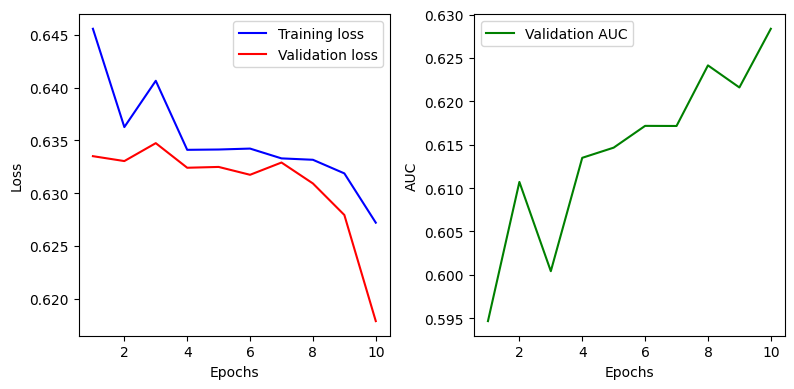

Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 128, 'dropout_prob': 0.75, 'batch_size': 64}
Best Validation AUC: 0.6284


In [ ]:
# Train the model on the randomised parameter combinations
best_model_2_random_2, best_hyperparams_2_random_2, best_auc_2_random_2 = manual_cross_validation(
    train_sequences_2,
    train_labels_2,
    random_search_2,
    num_folds=5,
    patience=5,
    output_path=output_dir
)

print(f'Best Hyperparameters: {best_hyperparams_2_random_2}')
print(f'Best Validation AUC: {best_auc_2_random_2:.4f}')

# Save best model into pickle file
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model_random_2.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_2_random_2, f)

# Save the best hyperparameters in a json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams_random_2.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_2_random_2, f)



Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 128, 'dropout_prob': 0.75, 'batch_size': 64}

Best Validation AUC: 0.6284


**Random Search - Run 3**

So far there does not seem to be a consistent pattern in parameter values so we will try again.

In [ ]:
random_search_3 = list(ParameterSampler(param_grid, n_iter=n_iter_search)) # Random state removed to allow the random number generator to use the current state, which will be different each time you run the code

print(f"Total hyperparameter combinations: {len(random_search_3)}")

Total hyperparameter combinations: 50


In [ ]:
random_search_3[0]

{'sampling_method': 'normal',
 'num_epochs': 10,
 'loss': 'normal',
 'learning_rate': 0.001,
 'layer_dim': 4,
 'hidden_dim': 256,
 'dropout_prob': 0.5,
 'batch_size': 32}

Epoch 0/9, Loss: 0.6362, Val Loss: 0.6476, Val AUC: 0.6144
Epoch 1/9, Loss: 0.6319, Val Loss: 0.6448, Val AUC: 0.6170
Epoch 2/9, Loss: 0.6311, Val Loss: 0.6463, Val AUC: 0.6159
Epoch 3/9, Loss: 0.6339, Val Loss: 0.6493, Val AUC: 0.6157
Epoch 4/9, Loss: 0.6317, Val Loss: 0.6456, Val AUC: 0.6176
Epoch 5/9, Loss: 0.6317, Val Loss: 0.6449, Val AUC: 0.6145
Epoch 6/9, Loss: 0.6311, Val Loss: 0.6455, Val AUC: 0.6170
Epoch 7/9, Loss: 0.6311, Val Loss: 0.6462, Val AUC: 0.6118
Epoch 8/9, Loss: 0.6308, Val Loss: 0.6471, Val AUC: 0.6163
Epoch 9/9, Loss: 0.6308, Val Loss: 0.6468, Val AUC: 0.6226
Params: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 4, 'hidden_dim': 256, 'dropout_prob': 0.5, 'batch_size': 32}, Val AUC: 0.6226
Epoch 0/19, Loss: 0.7021, Val Loss: 0.6992, Val AUC: 0.4497
Epoch 1/19, Loss: 0.6980, Val Loss: 0.6954, Val AUC: 0.5149
Epoch 2/19, Loss: 0.6938, Val Loss: 0.6915, Val AUC: 0.5488
Epoch 3/19, Loss: 0.6891, Val Loss: 0.687

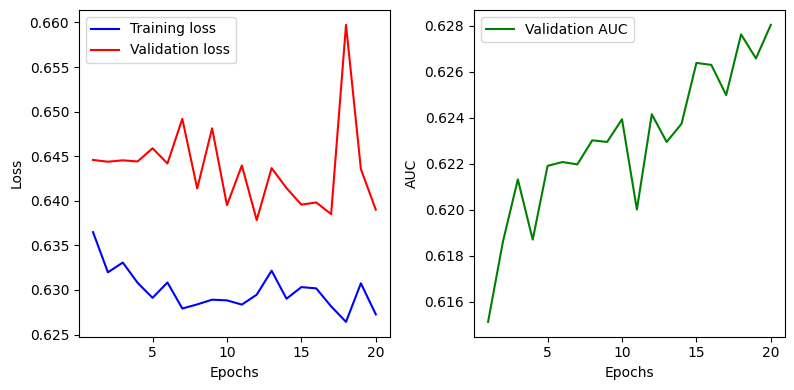

Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 256, 'dropout_prob': 0.5, 'batch_size': 32}
Best Validation AUC: 0.6280


In [ ]:
best_model_2_random_3, best_hyperparams_2_random_3, best_auc_2_random_3 = manual_cross_validation(
    train_sequences_2,
    train_labels_2,
    random_search_3,
    num_folds=5,
    patience=5,
    output_path=output_dir
)

print(f'Best Hyperparameters: {best_hyperparams_2_random_3}')
print(f'Best Validation AUC: {best_auc_2_random_3:.4f}')

# Save best model to pickle file
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model_random_3.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_2_random_3, f)

# Save best hyperparameters to json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams_random_3.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_2_random_3, f)

Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 256, 'dropout_prob': 0.5, 'batch_size': 32}


**Random Search - Run 4**

We will run this one more time on 50 iterations and analyse the best hyperparameters to narrow down our hyperparameter space.

In [ ]:
random_search_4 = list(ParameterSampler(param_grid, n_iter=n_iter_search))

print(f"Total hyperparameter combinations: {len(random_search_4)}")

Total hyperparameter combinations: 50


In [ ]:
random_search_4[0]

{'sampling_method': 'normal',
 'num_epochs': 30,
 'loss': 'normal',
 'learning_rate': 0.001,
 'layer_dim': 3,
 'hidden_dim': 256,
 'dropout_prob': 0.25,
 'batch_size': 32}

Epoch 0/29, Loss: 0.6349, Val Loss: 0.6400, Val AUC: 0.5827
Epoch 1/29, Loss: 0.6321, Val Loss: 0.6385, Val AUC: 0.5847
Epoch 2/29, Loss: 0.6337, Val Loss: 0.6401, Val AUC: 0.5868
Epoch 3/29, Loss: 0.6329, Val Loss: 0.6402, Val AUC: 0.5918
Epoch 4/29, Loss: 0.6313, Val Loss: 0.6408, Val AUC: 0.5860
Epoch 5/29, Loss: 0.6305, Val Loss: 0.6392, Val AUC: 0.5890
Epoch 6/29, Loss: 0.6291, Val Loss: 0.6401, Val AUC: 0.5908
Epoch 7/29, Loss: 0.6277, Val Loss: 0.6308, Val AUC: 0.5930
Epoch 8/29, Loss: 0.6254, Val Loss: 0.6374, Val AUC: 0.5901
Epoch 9/29, Loss: 0.6260, Val Loss: 0.6296, Val AUC: 0.5915
Epoch 10/29, Loss: 0.6264, Val Loss: 0.6327, Val AUC: 0.5882
Epoch 11/29, Loss: 0.6207, Val Loss: 0.6294, Val AUC: 0.5900
Epoch 12/29, Loss: 0.6231, Val Loss: 0.6319, Val AUC: 0.5867
Early stopping
Params: {'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}, Val AUC: 0.5867
Epoch 0/19, 

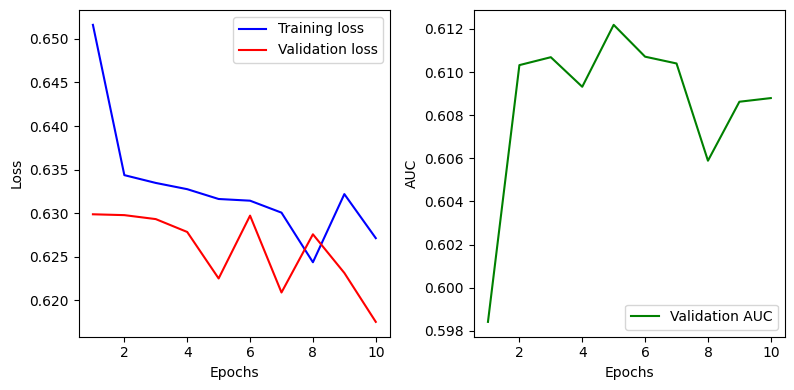

Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 128}
Best Validation AUC: 0.6088


In [ ]:
best_model_2_random_4, best_hyperparams_2_random_4, best_auc_2_random_4 = manual_cross_validation(
    train_sequences_2,
    train_labels_2,
    random_search_4,
    num_folds=5,
    patience=5,
    output_path=output_dir
)

print(f'Best Hyperparameters: {best_hyperparams_2_random_4}')
print(f'Best Validation AUC: {best_auc_2_random_4:.4f}')

model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model_random_4.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_2_random_4, f)

params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams_random_4.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_2_random_4, f)

Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 128}


**Analysis of Random Search best hyperparameters**

Looking only at the 50 iteration runs with sampling set to normal.

Run 2: Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 10, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 128, 'dropout_prob': 0.75, 'batch_size': 64}

Run 3: Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 256, 'dropout_prob': 0.5, 'batch_size': 32}

Run 4: Best Hyperparameters: {'sampling_method': 'normal', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 128}

Unfortunately, there does not seem to be a clear consensus regarding the optimal hyperparameters. This is likely influenced by the random nature of the random search not looking at all possible options.

Generally, the learning rate of 0.001 and layer_dim = 3 seem to be favourable. A dropout probability of > 0.5 also seems to be helpful. The rest of the parameters are more mixed. It also seems that 10/20 epochs is sufficient so we can keep these.

As such in our hyperparameter grid, we will focus on higher number of layers, learning rates aorund 0.001, layer_dim around 3 and dropout probabilities at least > 0.

**Refined hyperparameter tuning**

We can now define our refined hyperparameter grid.

In [ ]:
import itertools

In [ ]:
refined_param_grid = {
    'hidden_dim': [32, 64, 128], # Explore around optimal values
    'layer_dim': [2, 3, 4], # Explore layers arond 3
    'dropout_prob': [0.25, 0.5, 0.75], # Regularization not including 0
    'learning_rate': [0.001, 0.0005, 0.0001], # Explore rates around 0.001
    'batch_size': [32, 64], # Batch size for training remain the same
    'num_epochs': [10, 20], # 10 to 20 epochs seemed sufficient
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted']
}

refined_param_combinations = list(itertools.product(*refined_param_grid.values()))

refined_param_combinations = [dict(zip(refined_param_grid.keys(), params)) for params in refined_param_combinations]

print(f"Total hyperparameter combinations: {len(refined_param_combinations)}")

Total hyperparameter combinations: 1944


In [ ]:
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_checkpoints_run_2_refined/checkpoint.pth'

### **Experiment 2 - MAIN RUN**

Streaming output truncated to the last 5000 lines.
Early stopping
Params: {'hidden_dim': 128, 'layer_dim': 3, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5825
Epoch 0/19, Loss: 0.6941, Val Loss: 0.6901, Val AUC: 0.5810
Epoch 1/19, Loss: 0.6937, Val Loss: 0.6837, Val AUC: 0.5816
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6920, Val AUC: 0.5858
Epoch 3/19, Loss: 0.6926, Val Loss: 0.6995, Val AUC: 0.5869
Epoch 4/19, Loss: 0.6912, Val Loss: 0.6906, Val AUC: 0.5873
Epoch 5/19, Loss: 0.6908, Val Loss: 0.6640, Val AUC: 0.5912
Epoch 6/19, Loss: 0.6920, Val Loss: 0.6892, Val AUC: 0.5850
Epoch 7/19, Loss: 0.6900, Val Loss: 0.6871, Val AUC: 0.5898
Epoch 8/19, Loss: 0.6863, Val Loss: 0.6756, Val AUC: 0.5908
Epoch 9/19, Loss: 0.6870, Val Loss: 0.6892, Val AUC: 0.5917
Epoch 10/19, Loss: 0.6861, Val Loss: 0.6630, Val AUC: 0.5906
Epoch 11/19, Loss: 0.6900, Val Loss: 0.6656, Val AUC: 0.5853
Epoch 12/19, Loss

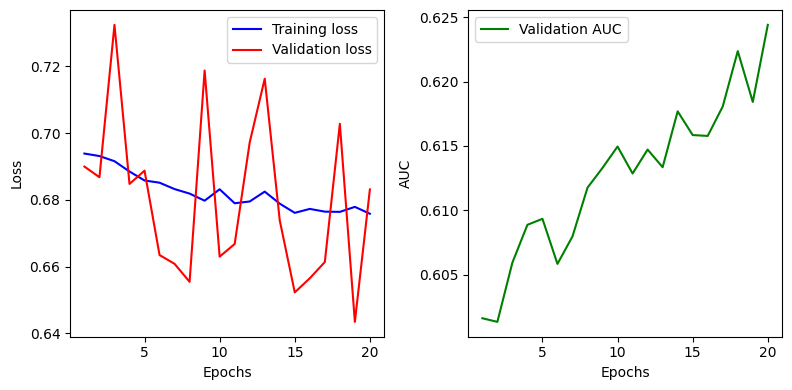

Best Hyperparameters: {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'oversample', 'loss': 'weighted'}
Best Validation AUC: 0.6244


In [ ]:
best_model_2, best_hyperparams_2, best_auc_2 = manual_cross_validation(
    train_sequences_2,
    train_labels_2,
    refined_param_combinations,
    num_folds=5,
    patience=5,
    output_path=output_dir
)

print(f'Best Hyperparameters: {best_hyperparams_2}')
print(f'Best Validation AUC: {best_auc_2:.4f}')

model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model_2_refined.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_2, f)

params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams_2_refined.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_2, f)

The model does not seem to be generalising well do the validation data. Generally it is trending downwards but the validation loss is too erratic. Furthermore, the validation AUC should be ideally higher.

Some reasons as to why the model may have been performing like this are:
- Potential overfitting in relation to the validation loss being high and fluctuating a lot (maybe can look at also adding L2 regularization)
- The training and validation loss are both quite high which could also indicate underfitting (we can try adding more epochs as an option but prior random search indicated 20 was sufficient)
- Learning rate may be too high (but we are experimenting with different rates and Adam optimizer)
- Data Issues: data is likley poor quality given the amount of preprocessing and resampling that was required - as such the data is likley poor quality (we could try padding and packing but that would end up filling the data with several zeroes for a number of features which is meaningless).
- Feature Engineering: by creating more specific features (ratios) which are clinically used but even this did not help. These features are clinically informative and popular in the literature so should be sufficient.
- Data Imbalance: this is being handled by having over, under and normal sampling as a hyperparameter

I will continue evaluating this best model but we may need to try an alternative interpolation technique for the Data to try and improve the quality.

First, this best model will be evaluated, feature ablation run and post-hoc interpretability techniques of SHAP and LIME incoporated.

Then we will try and train this model again, with different hyperparameters:
- try larger range of epochs
- try fewer layer dim of 1 to 3
- more hidden dim given the preference of 128 dim being the highest performer
- Incorporate L2 regularisation

A consideration is to use other Imputation techniques but the following thoughts are:
- KNN imputation could be useful but it is not ideal for time series data as each patient is unique so using neares neighbours might diminish temporal relationships (hence why we used linear interpolation in the first place as this maintains some temporal pattern even if the data is imputed)
- More elaborate options are Kalman filters and ARIMA models but these are computationally expensive and
- Model based interpolations will be more computationally complex as well as require a whole round of hyperparameter tuning themselves (there is also risk of overfitting etc. so no guarantee of imporved data quality)

This study is focusing on the development of interpretable ML models that can predict based on dynamic/time-series data so using models to imporve the Data Quality is out of the scope of this study and is a necessity of further work.

**Experiment 2 - Evaluate the best model on the test set**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
# Function to evaluate test dataset on best model and calculate evaluation metrics
def evaluate_model(model, test_loader, device):
    model.eval()
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1) # Ensure labels have shape [batch_size, 1]
            outputs = model(sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, roc_auc, specificity

Load the model and hyperparameters

In [ ]:
# Load the best model and best hyperparameters
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_model_2_refined.pkl'
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiement_2/best_hyperparams_2_refined.json'

with open(model_path, 'rb') as f:
    best_model_2 = pickle.load(f)

with open(params_path, 'r') as f:
    best_hyperparams_2 = json.load(f)

In [ ]:
best_hyperparams_2

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.25,
 'learning_rate': 0.0005,
 'batch_size': 32,
 'num_epochs': 20,
 'sampling_method': 'oversample',
 'loss': 'weighted'}

In [ ]:
best_model_2

LSTMModel(
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Create the test data loader
_, _, test_loader = create_data_loaders(
    test_sequences_2, test_labels_2,
    test_sequences_2, test_labels_2,
    test_sequences_2, test_labels_2,
    batch_size=best_hyperparams_2['batch_size']
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
best_model_2.to(device)

LSTMModel(
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Run the model evaluation.

In [ ]:
# Evaluate the model on the test data
evaluate_model(best_model_2, test_loader, device)

Accuracy: 0.4793
Precision: 0.3528
Recall (Sensitivity): 0.7078
F1 Score: 0.4708
ROC AUC: 0.5566
Specificity: 0.3681


(0.47927736450584485,
 0.35275080906148865,
 0.7077922077922078,
 0.47084233261339087,
 0.5566284031923842,
 0.36808846761453395)

The evaluation on the test set indicates there is room for imporvement.

The high recall/sensitivity is notable as that means the model can identify 71% of the actual extubation failures. High recall is crucial when predicting in medical contexts to ensure the majority of instances are captured.

Generally there seems to be a high rate of false positives (low precision and low specificity).

ROC AUC score above 0.5 indicates the model is only slightly better than random guessing so gas poor discriminatory power.

High Recall, Low Precision: The model is good at identifying true positives (failures) but also predicts a lot of false positives. This is indicated by high recall and low precision.

Low Specificity: The model is not good at correctly identifying true negatives (successes), leading to a high number of false positives.

Low ROC AUC: The model is only slightly better than random guessing in distinguishing between failures and successes.

Overall Low Accuracy: The overall accuracy is quite low, which, combined with the other metrics, suggests that the model is not well-calibrated for this task.


**Improvements**
- Class imbalance is being handled
- Features have been created
- We have done hyperparameter tuning
- We can change the model complexity
- We can add regularisation

**Experiment 2 - Feature ablation**

We will now carry out feature ablation on this model and see how the each feature influences model performance.

Definition - A perturbation based approach to computing attribution, involving replacing each input feature with a given baseline / reference, and computing the difference in output (https://captum.ai/api/feature_ablation.html)

Feature ablation is carried out by removing the feature and training the model and seeing how that impacts evaluation scores. The other method of just setting the value to 0 is not being considered as this is more comprehensive.



In [ ]:
def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
# Define function to perform feature ablation
def feature_ablation(train_sequences, train_labels, test_sequences, test_labels, model, best_hyperparams, device):

    feature_importances = {}
    input_dim = train_sequences.shape[2]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(TimeSeriesDataset(test_sequences, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    # Iterate over each feature
    for feature_idx in range(input_dim):
        print(f"Ablating feature {feature_idx + 1}/{input_dim}")

        # Remove the feature from the sequences
        train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
        test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences_ablation, train_labels,
            train_sequences_ablation, train_labels,  # Dummy validation for simplicity
            test_sequences_ablation, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = LSTMModel(
            input_dim=input_dim - 1,
            hidden_dim=best_hyperparams['hidden_dim'],
            layer_dim=best_hyperparams['layer_dim'],
            output_dim=1,
            dropout_prob=best_hyperparams['dropout_prob']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances[feature_idx] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    return feature_importances

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
best_model_2

LSTMModel(
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
best_hyperparams_2

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.25,
 'learning_rate': 0.0005,
 'batch_size': 32,
 'num_epochs': 20,
 'sampling_method': 'oversample',
 'loss': 'weighted'}

Evaluate and dislpay the feature importances via feature ablation.

In [ ]:
def plot_feature_importance(feature_importances, metric='roc_auc'):
    """
    Plot the feature importance based on the specified performance metric.

    Parameters:
    feature_importances (dict): Dictionary containing the feature importances.
    metric (str): The performance metric to base the importance on (default is 'roc_auc').
    """
    features = list(feature_importances.keys())
    importances = [feature_importances[feature][metric] for feature in features]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(features)), importances, color='skyblue')
    plt.xlabel('Feature Index')
    plt.ylabel(f'Change in {metric.upper()}')
    plt.title(f'Feature Importance based on change in {metric.upper()}')
    plt.xticks(range(len(features)), [f'Feature {i+1}' for i in features], rotation=45)
    plt.show()

Ablating feature 1/16
Epoch 0/19, Loss: 0.6406, Val Loss: 0.6340, Val AUC: 0.5826
Epoch 1/19, Loss: 0.6335, Val Loss: 0.6313, Val AUC: 0.5854
Epoch 2/19, Loss: 0.6335, Val Loss: 0.6363, Val AUC: 0.5879
Epoch 3/19, Loss: 0.6313, Val Loss: 0.6371, Val AUC: 0.5884
Epoch 4/19, Loss: 0.6317, Val Loss: 0.6372, Val AUC: 0.5902
Epoch 5/19, Loss: 0.6286, Val Loss: 0.6321, Val AUC: 0.5928
Epoch 6/19, Loss: 0.6275, Val Loss: 0.6254, Val AUC: 0.5933
Epoch 7/19, Loss: 0.6250, Val Loss: 0.6205, Val AUC: 0.5932
Epoch 8/19, Loss: 0.6233, Val Loss: 0.6210, Val AUC: 0.5953
Epoch 9/19, Loss: 0.6250, Val Loss: 0.6219, Val AUC: 0.5951
Epoch 10/19, Loss: 0.6234, Val Loss: 0.6197, Val AUC: 0.5967
Epoch 11/19, Loss: 0.6218, Val Loss: 0.6210, Val AUC: 0.5970
Epoch 12/19, Loss: 0.6232, Val Loss: 0.6214, Val AUC: 0.5963
Epoch 13/19, Loss: 0.6231, Val Loss: 0.6183, Val AUC: 0.5963
Epoch 14/19, Loss: 0.6215, Val Loss: 0.6208, Val AUC: 0.5979
Epoch 15/19, Loss: 0.6247, Val Loss: 0.6220, Val AUC: 0.5972
Epoch 16/19,

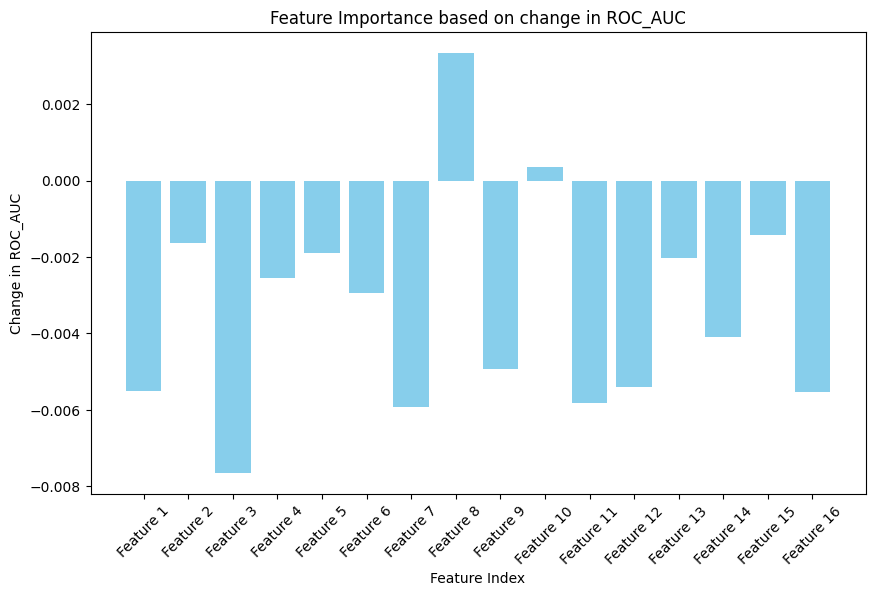

In [ ]:
feature_importances_exp_2 = feature_ablation(
    train_sequences_2,
    train_labels_2,
    test_sequences_2,
    test_labels_2,
    best_model_2,
    best_hyperparams_2,
    device
)

for feature_idx, importance in feature_importances_exp_2.items():
    print(f"Feature {feature_idx + 1} importance: {importance}")

plot_feature_importance(feature_importances_exp_2, metric='roc_auc')

We need to know which features are being referred to here.

Feature labels get lost when sequences are created and so need to be saved.

I have extracted the list of feature labels from the training and test data and we will amend the feature ablation function to consider the names as well.

In [ ]:
# Load feature names from pickle file
names_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_names_v1.pkl'

with open(names_path, 'rb') as f:
    feature_names_1 = pickle.load(f)

feature_names_1

['EtCO2',
 'Inspired O2 Fraction',
 'Minute Volume',
 'O2 saturation pulseoxymetry',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Arterial CO2 Pressure',
 'Arterial O2 pressure',
 'PH (Arterial)',
 'Ventilator Mode',
 'Hemoglobin',
 'Plateau Pressure',
 'SpO2:FiO2',
 'P:F ratio']

In [ ]:
# Amended feature_ablation function to incporate the featur names
def feature_ablation_with_names(train_sequences, train_labels, test_sequences, test_labels, model, best_hyperparams, device, feature_names):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained LSTM model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    feature_names (list): List of feature names.

    Returns:
    feature_importances (dict): Dictionary containing the importance of each feature.
    """
    feature_importances = {}
    input_dim = train_sequences.shape[2]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(TimeSeriesDataset(test_sequences, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    for feature_idx in range(input_dim):
        feature_name = feature_names[feature_idx]
        print(f"Ablating feature {feature_name} ({feature_idx + 1}/{input_dim})")

        # Remove the feature from the sequences
        train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
        test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences_ablation, train_labels,
            train_sequences_ablation, train_labels,
            test_sequences_ablation, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = LSTMModel(
            input_dim=input_dim - 1,
            hidden_dim=best_hyperparams['hidden_dim'],
            layer_dim=best_hyperparams['layer_dim'],
            output_dim=1,
            dropout_prob=best_hyperparams['dropout_prob']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances[feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Convert feature importances to a DataFrame for better readability
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
    feature_importances_df = feature_importances_df.sort_values(by='roc_auc', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances_df.index, feature_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances_df

In [ ]:
# Run feature ablation with the relevant names
feature_importances_exp_2_v2 = feature_ablation_with_names(
    train_sequences_2,
    train_labels_2,
    test_sequences_2,
    test_labels_2,
    best_model_2,
    best_hyperparams_2,
    device,
    feature_names_1
)

for feature_idx, importance in feature_importances_exp_2_v2.items():
    print(f"Feature {feature_idx + 1} importance: {importance}")

NameError: name 'train_sequences_2' is not defined

In [ ]:
feature_importances_exp_2_v2

accuracy  precision    recall        f1  \
Arterial O2 pressure        -0.193411  -0.147249  0.672078  0.404176   
Inspired O2 Fraction        -0.198725  -0.278828  0.668831  0.397448   
Peak Insp. Pressure         -0.196599  -0.262634  0.681818  0.420998   
Ventilator Mode             -0.198725  -0.266297  0.665584  0.391815   
Arterial CO2 Pressure       -0.195537  -0.192704  0.668831  0.398115   
Plateau Pressure            -0.196599  -0.262634  0.681818  0.420998   
SpO2:FiO2                   -0.195537  -0.173565  0.642857  0.355235   
P:F ratio                   -0.198725  -0.202805  0.626623  0.329199   
Minute Volume               -0.199787  -0.215431  0.626623  0.328797   
Tidal Volume (spontaneous)  -0.196599  -0.192704  0.649351  0.365270   
PH (Arterial)               -0.197662  -0.192704  0.629870  0.334479   
Hemoglobin                  -0.197662  -0.197249  0.636364  0.344406   
Respiratory Rate            -0.194474  -0.159444  0.639610  0.350498   
O2 saturation pulseoxymetry -0.198725  -0.266297  0.665584  0.391815   
EtCO2                       -0.198725  -0.194419  0.613636  0.310178   
Tidal Volume (observed)     -0.196599  -0.226197  0.672078  0.403564   

                              roc_auc  specificity  
Arterial O2 pressure         0.000300    -0.672078  
Inspired O2 Fraction        -0.000498    -0.668831  
Peak Insp. Pressure         -0.001770    -0.681818  
Ventilator Mode             -0.001898    -0.665584  
Arterial CO2 Pressure       -0.001939    -0.668831  
Plateau Pressure            -0.002324    -0.681818  
SpO2:FiO2                   -0.003203    -0.642857  
P:F ratio                   -0.004196    -0.626623  
Minute Volume               -0.004827    -0.626623  
Tidal Volume (spontaneous)  -0.005422    -0.649351  
PH (Arterial)               -0.006293    -0.629870  
Hemoglobin                  -0.006452    -0.636364  
Respiratory Rate            -0.006576    -0.639610  
O2 saturation pulseoxymetry -0.006850    -0.665584  
EtCO2                       -0.008407    -0.613636  
Tidal Volume (observed)     -0.010310    -0.672078

Larger negative changes indicative of more important feature.

Tidal volume (observed) seems to be the most important and Artieral O2 pressure the least important.

Most Important Features:

- Tidal Volume (observed): This feature has the largest negative change in ROC AUC (-0.010310), indicating it is the most critical feature for model performance.
- EtCO2: This feature also shows a significant negative impact on ROC AUC (-0.008407), making it highly important.
O2 saturation pulseoxymetry: This feature has a substantial negative change in ROC AUC (-0.006850).
- Respiratory Rate: This feature has a significant negative change in ROC AUC (-0.006576).

Least Important Features:
- Arterial O2 pressure: This feature has a small positive change in ROC AUC (0.000300), indicating that the model performs slightly better without it.
- Inspired O2 Fraction: This feature has a minimal negative change in ROC AUC (-0.000498), indicating it has a relatively low impact on model performance.


The one caveat is that the changes are very small and so we cannot read into these too much.

We cannot look at Correlation analysis as it is time-series data. Only really works for one time point.

### **Experiment 2 - SHAP and LIME**

We can now look at interpreting our results using SHAP and LIME to see feature importances and whether that correlates to our feature ablation study.

In [ ]:
!pip install shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 40.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3d999391f98842e3585af45375b8a3f0ca97ac1095c1603062e8ac4986849d18
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


**SHAP analysis**

SHAP requires data to be inputted as 2D rather than the 3D sequences we have at the moment.

We can input our sequences and summarise the SHAP values over the time steps by taking the sum. It is tricky to show SHAP values varying with time as SHAP only produces one plot.

In [ ]:
import shap

In [ ]:
best_model_2_copy = best_model_2

best_model_2_copy

LSTMModel(
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Interpret results using SHAP across the time series

# Ensure the model is in training mode
best_model_2_copy.train()
assert best_model_2_copy.training, "Model is not in training mode!"
# Set up the explainer
explainer = shap.DeepExplainer(best_model_2_copy, torch.tensor(train_sequences_2, dtype=torch.float32).to(device))

# Explain the model's predictions on the test data
shap_values = explainer.shap_values(torch.tensor(test_sequences_2, dtype=torch.float32).to(device))

# Convert SHAP values to numpy array for visualisation
# best_model_2_copy.eval()

shap_values = np.array(shap_values)

# Summarise the SHAP values over the time steps
shap_values_sum = np.sum(shap_values, axis=1)

# Visualise the SHAP values
shap.summary_plot(shap_values_sum, np.mean(test_sequences, axis=1), feature_names=feature_names_1)

RuntimeError: cudnn RNN backward can only be called in training mode

The issue persists because of how PyTorch handles RNNs, particularly when running in evaluation mode. Since this approach with SHAP isn't working due to the backward pass limitations of cuDNN with RNNs in evaluation mode, another method must be adopted to analyze feature importance.

We will try an alternative and use Kernel SHAP for Time Series Data.

Kernel SHAP is a model-agnostic approach, meaning it doesn't rely on gradients and can be used with any model, including RNNs. This method uses a different strategy but can handle the time series data as required.

# **Experiment 3**

We will now train the model again using updated hyperparameters and incorporating regularisation.

- try larger range of epochs
- try fewer layer dim of 1 to 3
- more hidden dim given the preference of 128 dim being the highest performer
- Incorporate L2 regularisation

In [ ]:
# Load the train and test sequences
train_sequences_3 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/train_sequences_v04.npy', allow_pickle=True).astype(np.float32)
train_labels_3 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/train_labels_v04.npy', allow_pickle=True).astype(np.float32)
test_sequences_3 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/test_sequences_v04.npy', allow_pickle=True).astype(np.float32)
test_labels_3 = np.load('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/test_labels_v04.npy', allow_pickle=True).astype(np.float32)

print(train_sequences_3.shape)
print(train_labels_3.shape)
print(test_sequences_3.shape)
print(test_labels_3.shape)

(3760, 13, 16)
(3760,)
(941, 13, 16)
(941,)


In [ ]:
import itertools

In [ ]:
best_hyperparams_2

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.25,
 'learning_rate': 0.0005,
 'batch_size': 32,
 'num_epochs': 20,
 'sampling_method': 'oversample',
 'loss': 'weighted'}

To add **L2 regularisation** we will need to add a weight decay hyperparamter and incpirate this into our Adam optmizer.

In [ ]:
refined_param_grid_2 = {
    'hidden_dim': [32, 64, 128, 256],  # Focus on mid-range complexity
    'layer_dim': [1, 2, 3],  # Stick to the best performing layer dimensions
    'dropout_prob': [0.25, 0.5],  # Regularization around mid-values
    'learning_rate': [0.001, 0.0005, 0.0001],  # Fine-tune around the best performing learning rates
    'batch_size': [32, 64],  # Smaller and moderate batch sizesg
    'num_epochs': [20, 30, 40],  # Increase the number of epochs to allow the model to learn more
    'sampling_method': ['normal', 'undersample', 'oversample'],  # Keep sampling methods for handling imbalance
    'loss': ['normal', 'weighted'],  # Use weighted loss only with normal sampling
    'weight_decay': [0.0001, 0.001, 0.01]  # Add L2 regularisation - relatively high to prevent overfitting
}

refined_param_combinations_2 = list(itertools.product(*refined_param_grid_2.values()))

refined_param_combinations_2 = [
    dict(zip(refined_param_grid_2.keys(), params))
    for params in refined_param_combinations_2
]

# Filter out combinations where weighted loss is used with undersampling or oversampling
refined_param_combinations_2 = [
    params for params in refined_param_combinations_2
    if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')
]

print(f"Total hyperparameter combinations: {len(refined_param_combinations_2)}")

NameError: name 'itertools' is not defined

To refine our hyperparameters we will carry out three random searches and see if any patterns emerge.

**Experiment 3 - Random Search 1**

In [ ]:
from sklearn.model_selection import ParameterSampler

In [ ]:
# Sample paramter combinations
n_iter_search = 50
random_search_1 = list(ParameterSampler(refined_param_grid_2, n_iter=n_iter_search))

print(f"Total hyperparameter combinations: {len(random_search_1)}")

Total hyperparameter combinations: 50


In [ ]:
random_search_1[0]

{'weight_decay': 0.001,
 'sampling_method': 'undersample',
 'num_epochs': 20,
 'loss': 'weighted',
 'learning_rate': 0.001,
 'layer_dim': 3,
 'hidden_dim': 32,
 'dropout_prob': 0.5,
 'batch_size': 64}

Epoch 0/19, Loss: 0.6934, Val Loss: 0.6943, Val AUC: 0.5346
Epoch 1/19, Loss: 0.6933, Val Loss: 0.6909, Val AUC: 0.5740
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6930, Val AUC: 0.5697
Epoch 3/19, Loss: 0.6933, Val Loss: 0.6952, Val AUC: 0.5680
Epoch 4/19, Loss: 0.6933, Val Loss: 0.6906, Val AUC: 0.5688
Epoch 5/19, Loss: 0.6933, Val Loss: 0.6884, Val AUC: 0.5702
Epoch 6/19, Loss: 0.6932, Val Loss: 0.6935, Val AUC: 0.5712
Early stopping
Params: {'weight_decay': 0.001, 'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 64}, Val AUC: 0.5712
Epoch 0/19, Loss: 0.8852, Val Loss: 0.8793, Val AUC: 0.4156
Epoch 1/19, Loss: 0.8793, Val Loss: 0.8725, Val AUC: 0.4387
Epoch 2/19, Loss: 0.8689, Val Loss: 0.8595, Val AUC: 0.4555
Epoch 3/19, Loss: 0.8499, Val Loss: 0.8405, Val AUC: 0.4776
Epoch 4/19, Loss: 0.8325, Val Loss: 0.8305, Val AUC: 0.5069
Epoch 5/19, Loss: 0.8245, Val Loss: 0.8267, Val

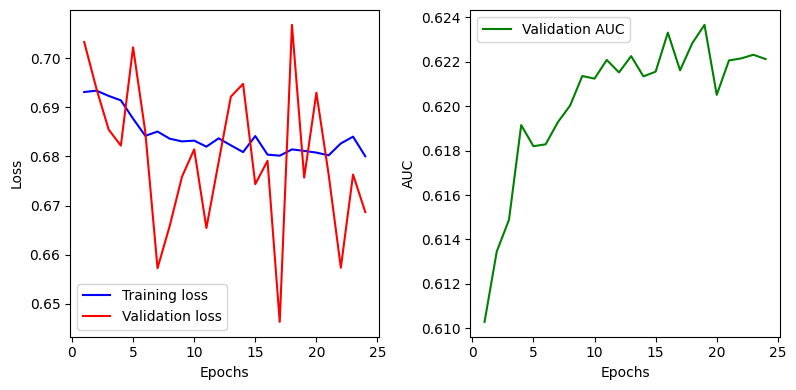

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 40, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 2, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 64}
Best validation AUC: 0.6221


In [ ]:
# Train the model on random parameters
model_exp_3_random_1, hyperparams_exp_3_random_1, auc_exp_3_random_1 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    random_search_1,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {hyperparams_exp_3_random_1}")
print(f"Best validation AUC: {auc_exp_3_random_1:.4f}")

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 40, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 2, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 64}


Looks like the model is still overfitting.

**Experiment 3 - Random Search 2**

In [ ]:
n_iter = 50
random_search_2 = list(ParameterSampler(refined_param_grid_2, n_iter=n_iter_search))

print(f"Total hyperparameter combinations: {len(random_search_2)}")

Total hyperparameter combinations: 50


Epoch 0/29, Loss: 0.6815, Val Loss: 0.6760, Val AUC: 0.5489
Epoch 1/29, Loss: 0.6685, Val Loss: 0.6650, Val AUC: 0.5525
Epoch 2/29, Loss: 0.6574, Val Loss: 0.6562, Val AUC: 0.5516
Epoch 3/29, Loss: 0.6476, Val Loss: 0.6484, Val AUC: 0.5523
Epoch 4/29, Loss: 0.6397, Val Loss: 0.6431, Val AUC: 0.5547
Epoch 5/29, Loss: 0.6356, Val Loss: 0.6413, Val AUC: 0.5557
Epoch 6/29, Loss: 0.6340, Val Loss: 0.6406, Val AUC: 0.5568
Epoch 7/29, Loss: 0.6330, Val Loss: 0.6405, Val AUC: 0.5589
Epoch 8/29, Loss: 0.6330, Val Loss: 0.6403, Val AUC: 0.5613
Epoch 9/29, Loss: 0.6324, Val Loss: 0.6402, Val AUC: 0.5605
Epoch 10/29, Loss: 0.6322, Val Loss: 0.6402, Val AUC: 0.5618
Epoch 11/29, Loss: 0.6323, Val Loss: 0.6401, Val AUC: 0.5625
Epoch 12/29, Loss: 0.6319, Val Loss: 0.6401, Val AUC: 0.5622
Epoch 13/29, Loss: 0.6319, Val Loss: 0.6401, Val AUC: 0.5641
Epoch 14/29, Loss: 0.6323, Val Loss: 0.6402, Val AUC: 0.5658
Epoch 15/29, Loss: 0.6317, Val Loss: 0.6400, Val AUC: 0.5650
Epoch 16/29, Loss: 0.6317, Val Los

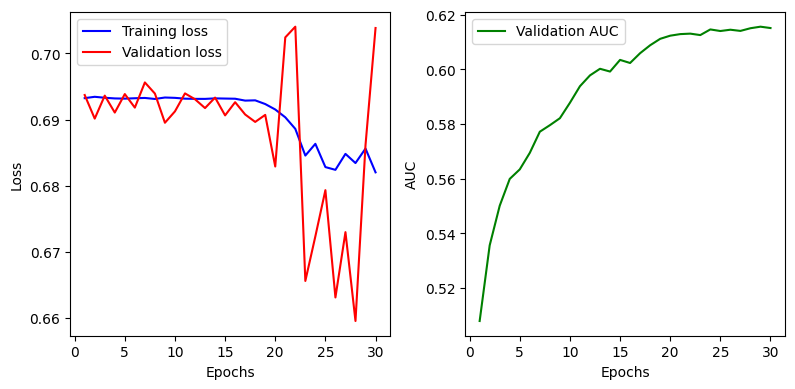

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 3, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 64}
Best validation AUC: 0.6151


In [ ]:
# Run a second random search
model_exp_3_random_2, hyperparams_exp_3_random_2, auc_exp_3_random_2 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    random_search_2,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {hyperparams_exp_3_random_2}")
print(f"Best validation AUC: {auc_exp_3_random_2:.4f}")

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'undersample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 3, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 64}


**Experiment 3 - Random Search 3**

In [ ]:
random_search_3 = list(ParameterSampler(refined_param_grid_2, n_iter=n_iter_search))

print(f"Total hyperparameter combinations: {len(random_search_3)}")

Total hyperparameter combinations: 50


Epoch 0/29, Loss: 0.6485, Val Loss: 0.6314, Val AUC: 0.6033
Epoch 1/29, Loss: 0.6336, Val Loss: 0.6311, Val AUC: 0.6095
Epoch 2/29, Loss: 0.6336, Val Loss: 0.6312, Val AUC: 0.6126
Epoch 3/29, Loss: 0.6328, Val Loss: 0.6316, Val AUC: 0.6166
Epoch 4/29, Loss: 0.6336, Val Loss: 0.6303, Val AUC: 0.6172
Epoch 5/29, Loss: 0.6329, Val Loss: 0.6293, Val AUC: 0.6195
Epoch 6/29, Loss: 0.6319, Val Loss: 0.6280, Val AUC: 0.6237
Epoch 7/29, Loss: 0.6314, Val Loss: 0.6266, Val AUC: 0.6302
Epoch 8/29, Loss: 0.6287, Val Loss: 0.6299, Val AUC: 0.6241
Epoch 9/29, Loss: 0.6288, Val Loss: 0.6177, Val AUC: 0.6235
Epoch 10/29, Loss: 0.6283, Val Loss: 0.6177, Val AUC: 0.6255
Epoch 11/29, Loss: 0.6269, Val Loss: 0.6170, Val AUC: 0.6240
Epoch 12/29, Loss: 0.6283, Val Loss: 0.6218, Val AUC: 0.6257
Early stopping
Params: {'weight_decay': 0.0001, 'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 2, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 32}, Val A

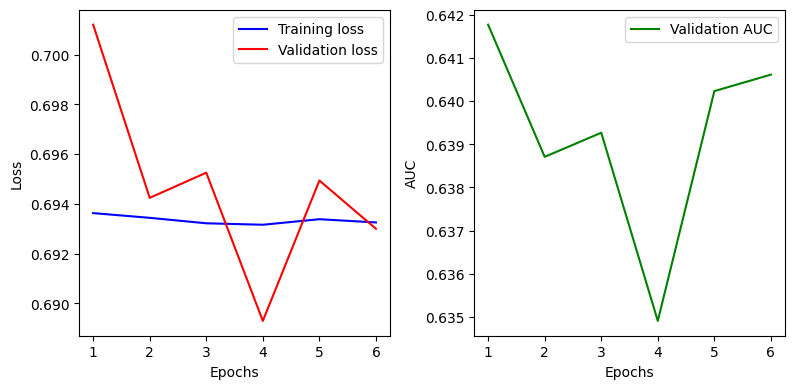

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 64, 'dropout_prob': 0.25, 'batch_size': 64}
Best validation AUC: 0.6406


In [ ]:
model_exp_3_random_3, hyperparams_exp_3_random_3, auc_exp_3_random_3 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    random_search_3,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {hyperparams_exp_3_random_3}")
print(f"Best validation AUC: {auc_exp_3_random_3:.4f}")

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 64, 'dropout_prob': 0.25, 'batch_size': 64}
Best validation AUC: 0.6406

In [ ]:
best_hyperparams_2

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.25,
 'learning_rate': 0.0005,
 'batch_size': 32,
 'num_epochs': 20,
 'sampling_method': 'oversample',
 'loss': 'weighted'}

The optimal hyperparamters from each run are outlined below.

Run 1: Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 40, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 2, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 64}

Run 2: Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 40, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 2, 'hidden_dim': 64, 'dropout_prob': 0.5, 'batch_size': 64}

Run 3: Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 3, 'hidden_dim': 64, 'dropout_prob': 0.25, 'batch_size': 64}

Weight decay 0.0001, batch_size = 64 and hidden_dim = 64 seem to be common throughout. Layers seem to be best performing with 2 or 3. The number of epochs seems to vary.

**However, I realise I was not looking at all possibilities and with weighted loss only applied on normal sampling so the values may be skewed a little.**

**Experiment 3 - Random Search 4**

We will run further small searches and see what it lookslike.

In [ ]:
random_search_4 = list(ParameterSampler(refined_param_grid_2, n_iter=80))

# Remove where los is weighted and sampling method is not normal
random_search_4 = [params for params in random_search_4 if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')]

print(f"Total hyperparameter combinations: {len(random_search_4)}")

Total hyperparameter combinations: 49


In [ ]:
# Print some of the valid combinations to verify
for params in random_search_4[:10]:
    print(params)

{'weight_decay': 0.0001, 'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'weighted', 'learning_rate': 0.001, 'layer_dim': 2, 'hidden_dim': 32, 'dropout_prob': 0.5, 'batch_size': 32}
{'weight_decay': 0.01, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 64}
{'weight_decay': 0.01, 'sampling_method': 'oversample', 'num_epochs': 30, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 2, 'hidden_dim': 256, 'dropout_prob': 0.5, 'batch_size': 64}
{'weight_decay': 0.01, 'sampling_method': 'normal', 'num_epochs': 30, 'loss': 'weighted', 'learning_rate': 0.0001, 'layer_dim': 3, 'hidden_dim': 64, 'dropout_prob': 0.25, 'batch_size': 64}
{'weight_decay': 0.01, 'sampling_method': 'normal', 'num_epochs': 40, 'loss': 'weighted', 'learning_rate': 0.0001, 'layer_dim': 1, 'hidden_dim': 256, 'dropout_prob': 0.5, 'batch_size': 32}
{'weight_decay': 0.0001, 'sampling_method': 'norma

Epoch 0/29, Loss: 0.8286, Val Loss: 0.7970, Val AUC: 0.5377
Epoch 1/29, Loss: 0.8079, Val Loss: 0.7961, Val AUC: 0.5498
Epoch 2/29, Loss: 0.8076, Val Loss: 0.7958, Val AUC: 0.5538
Epoch 3/29, Loss: 0.8074, Val Loss: 0.7956, Val AUC: 0.5584
Epoch 4/29, Loss: 0.8073, Val Loss: 0.7955, Val AUC: 0.5606
Epoch 5/29, Loss: 0.8073, Val Loss: 0.7954, Val AUC: 0.5617
Epoch 6/29, Loss: 0.8072, Val Loss: 0.7954, Val AUC: 0.5627
Epoch 7/29, Loss: 0.8072, Val Loss: 0.7953, Val AUC: 0.5664
Epoch 8/29, Loss: 0.8072, Val Loss: 0.7952, Val AUC: 0.5656
Epoch 9/29, Loss: 0.8071, Val Loss: 0.7953, Val AUC: 0.5685
Epoch 10/29, Loss: 0.8071, Val Loss: 0.7952, Val AUC: 0.5693
Epoch 11/29, Loss: 0.8071, Val Loss: 0.7952, Val AUC: 0.5698
Epoch 12/29, Loss: 0.8071, Val Loss: 0.7952, Val AUC: 0.5711
Epoch 13/29, Loss: 0.8071, Val Loss: 0.7952, Val AUC: 0.5714
Epoch 14/29, Loss: 0.8071, Val Loss: 0.7952, Val AUC: 0.5716
Epoch 15/29, Loss: 0.8071, Val Loss: 0.7952, Val AUC: 0.5715
Epoch 16/29, Loss: 0.8071, Val Los

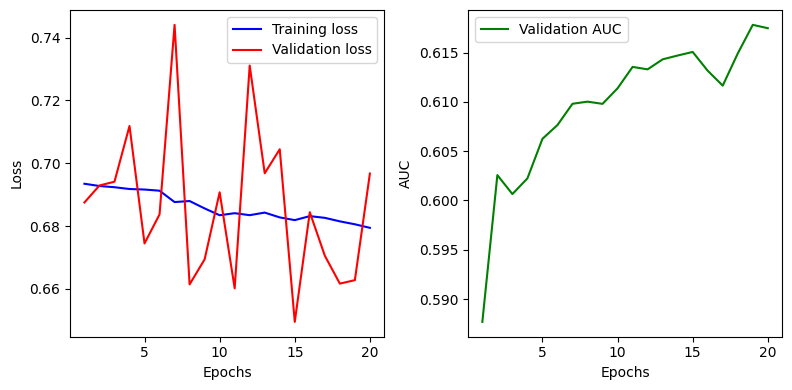

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}
Best validation AUC: 0.6175


In [ ]:
model_exp_3_random_4, hyperparams_exp_3_random_4, auc_exp_3_random_4 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    random_search_4,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {hyperparams_exp_3_random_4}")
print(f"Best validation AUC: {auc_exp_3_random_4:.4f}")

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}


**Experiment 3 - Random Search 5**

In [ ]:
random_search_5 = list(ParameterSampler(refined_param_grid_2, n_iter=50))

random_search_5 = [params for params in random_search_5 if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')]

print(f"Total hyperparameter combinations: {len(random_search_5)}")

Total hyperparameter combinations: 26


Epoch 0/19, Loss: 0.6933, Val Loss: 0.6939, Val AUC: 0.5136
Epoch 1/19, Loss: 0.6932, Val Loss: 0.6922, Val AUC: 0.5447
Epoch 2/19, Loss: 0.6929, Val Loss: 0.6922, Val AUC: 0.5687
Epoch 3/19, Loss: 0.6930, Val Loss: 0.6940, Val AUC: 0.5787
Epoch 4/19, Loss: 0.6928, Val Loss: 0.6906, Val AUC: 0.5841
Epoch 5/19, Loss: 0.6926, Val Loss: 0.6919, Val AUC: 0.5843
Epoch 6/19, Loss: 0.6925, Val Loss: 0.6921, Val AUC: 0.5819
Epoch 7/19, Loss: 0.6923, Val Loss: 0.6912, Val AUC: 0.5864
Epoch 8/19, Loss: 0.6921, Val Loss: 0.6907, Val AUC: 0.5840
Epoch 9/19, Loss: 0.6918, Val Loss: 0.6910, Val AUC: 0.5851
Epoch 10/19, Loss: 0.6916, Val Loss: 0.6894, Val AUC: 0.5851
Epoch 11/19, Loss: 0.6912, Val Loss: 0.6898, Val AUC: 0.5868
Epoch 12/19, Loss: 0.6906, Val Loss: 0.6902, Val AUC: 0.5924
Epoch 13/19, Loss: 0.6902, Val Loss: 0.6928, Val AUC: 0.5949
Epoch 14/19, Loss: 0.6891, Val Loss: 0.6857, Val AUC: 0.5940
Epoch 15/19, Loss: 0.6877, Val Loss: 0.6847, Val AUC: 0.5950
Epoch 16/19, Loss: 0.6865, Val Los

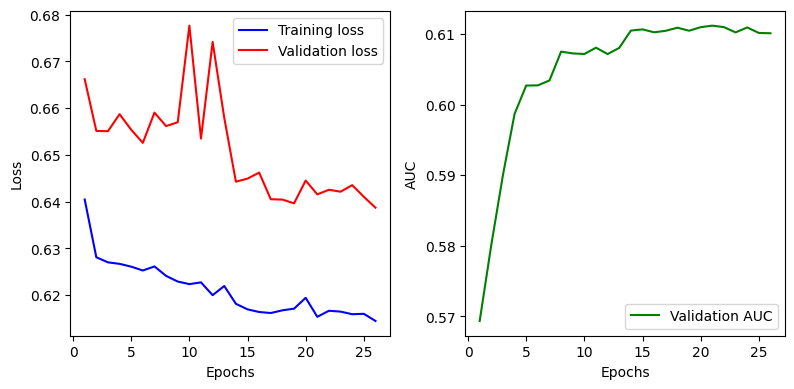

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'normal', 'num_epochs': 40, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 2, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}
Best validation AUC: 0.6101


In [ ]:
model_exp_3_random_5, hyperparams_exp_3_random_5, auc_exp_3_random_5 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    random_search_5,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {hyperparams_exp_3_random_5}")
print(f"Best validation AUC: {auc_exp_3_random_5:.4f}")

Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'normal', 'num_epochs': 40, 'loss': 'normal', 'learning_rate': 0.0001, 'layer_dim': 2, 'hidden_dim': 256, 'dropout_prob': 0.25, 'batch_size': 32}


**Experiment 3 - Random Search 5**


In [ ]:
random_search_6 = list(ParameterSampler(refined_param_grid_2, n_iter=50))

random_search_6 = [params for params in random_search_6 if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')]

print(f"Total hyperparameter combinations: {len(random_search_6)}")

Total hyperparameter combinations: 35


Epoch 0/29, Loss: 0.6936, Val Loss: 0.6898, Val AUC: 0.4673
Epoch 1/29, Loss: 0.6936, Val Loss: 0.6904, Val AUC: 0.4750
Epoch 2/29, Loss: 0.6934, Val Loss: 0.6920, Val AUC: 0.5000
Epoch 3/29, Loss: 0.6933, Val Loss: 0.6899, Val AUC: 0.5000
Epoch 4/29, Loss: 0.6932, Val Loss: 0.6892, Val AUC: 0.5000
Epoch 5/29, Loss: 0.6933, Val Loss: 0.6889, Val AUC: 0.5000
Epoch 6/29, Loss: 0.6932, Val Loss: 0.6882, Val AUC: 0.5000
Epoch 7/29, Loss: 0.6933, Val Loss: 0.6887, Val AUC: 0.5000
Epoch 8/29, Loss: 0.6933, Val Loss: 0.6884, Val AUC: 0.5000
Epoch 9/29, Loss: 0.6932, Val Loss: 0.6882, Val AUC: 0.5000
Epoch 10/29, Loss: 0.6932, Val Loss: 0.6887, Val AUC: 0.5000
Epoch 11/29, Loss: 0.6933, Val Loss: 0.6888, Val AUC: 0.5000
Epoch 12/29, Loss: 0.6932, Val Loss: 0.6891, Val AUC: 0.5000
Epoch 13/29, Loss: 0.6932, Val Loss: 0.6892, Val AUC: 0.5000
Epoch 14/29, Loss: 0.6933, Val Loss: 0.6890, Val AUC: 0.5000
Epoch 15/29, Loss: 0.6932, Val Loss: 0.6897, Val AUC: 0.5000
Epoch 16/29, Loss: 0.6932, Val Los

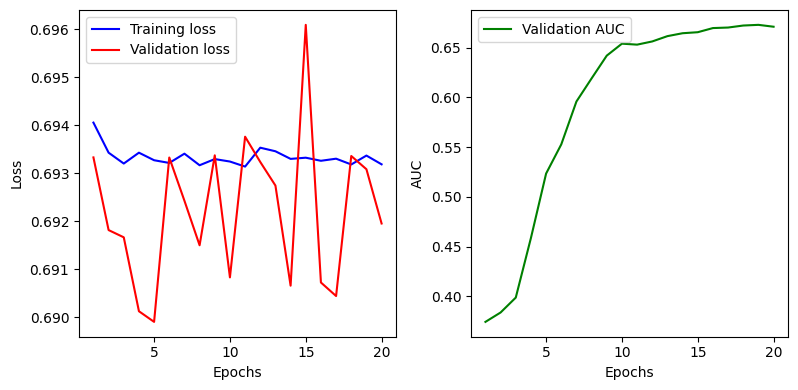

Best hyperparameters: {'weight_decay': 0.001, 'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 2, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 64}
Best validation AUC: 0.6711


In [ ]:
model_exp_3_random_6, hyperparams_exp_3_random_6, auc_exp_3_random_6 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    random_search_6,
    num_folds=5,
    patience=5,
    output_path="None"
)

print(f"Best hyperparameters: {hyperparams_exp_3_random_6}")
print(f"Best validation AUC: {auc_exp_3_random_6:.4f}")

Best hyperparameters: {'weight_decay': 0.001, 'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 2, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 64}
Best validation AUC: 0.6711

**Experiment 3 - Main Run**

We will now refine our parameters based on the random search results.

Run 1: Best hyperparameters: {'weight_decay': 0.0001, 'sampling_method': 'oversample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.0005, 'layer_dim': 1, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 32}

Run 2: Best hyperparameters: {'weight_decay': 0.001, 'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 2, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 64}

Run 3: Best hyperparameters: {'weight_decay': 0.001, 'sampling_method': 'undersample', 'num_epochs': 20, 'loss': 'normal', 'learning_rate': 0.001, 'layer_dim': 2, 'hidden_dim': 32, 'dropout_prob': 0.25, 'batch_size': 64}

The learning rate seems to be fixed around 0.0001 or 0.001, num epochs seems to be 20, learning rate varies between 0.001 and 0.0005. The lower layer dims seem to be preferred now. Hidden dim is now 32 and dropout prob is fixed at 0.25, batch size is either 32 or 64.

Compared to running the model without L2 regularisation, it seems fewer hidden_dim is preferable now (32 vs 128). The regularisation penalises large weights, encouraging the model to find simpler patterns in the data.

Regularization effectively controls the complexity of the model, encouraging it to learn simpler and more generalizable patterns rather than memorizing the training data.

With regularization, the model with a smaller hidden dimension (32 or 64) is likely sufficient to capture the essential patterns in the data without overfitting.

In [ ]:
refined_param_grid_3 = {
    'hidden_dim': [32, 64],  # Focus on mid-range complexity
    'layer_dim': [1, 2, 3],  # Stick to the best performing layer dimensions
    'dropout_prob': [0.25, 0.5],  # Regularization around mid-values
    'learning_rate': [0.001, 0.0005],  # Fine-tune around the best performing learning rates
    'batch_size': [32, 64],  # Smaller and moderate batch sizesg
    'num_epochs': [20, 30, 40],  # 20 epochs seems ideal so no need to go much higher
    'sampling_method': ['normal', 'undersample', 'oversample'],  # Keep sampling methods for handling imbalance
    'loss': ['normal', 'weighted'],  # Use weighted loss only with normal sampling
    'weight_decay': [0.0001, 0.001]  # Refined weight decay values
}

refined_param_combinations_3 = list(itertools.product(*refined_param_grid_3.values()))

refined_param_combinations_3 = [
    dict(zip(refined_param_grid_3.keys(), params))
    for params in refined_param_combinations_3
]

# Filter out combinations where weighted loss is used with undersampling or oversampling
refined_param_combinations_3 = [
    params for params in refined_param_combinations_3
    if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')
]

print(f"Total hyperparameter combinations: {len(refined_param_combinations_3)}")

Total hyperparameter combinations: 1152


In [ ]:
import pickle
import json

Streaming output truncated to the last 5000 lines.
Epoch 19/29, Loss: 0.6816, Val Loss: 0.6632, Val AUC: 0.5985
Epoch 20/29, Loss: 0.6827, Val Loss: 0.7105, Val AUC: 0.6002
Epoch 21/29, Loss: 0.6809, Val Loss: 0.6959, Val AUC: 0.5989
Epoch 22/29, Loss: 0.6819, Val Loss: 0.6629, Val AUC: 0.5990
Epoch 23/29, Loss: 0.6812, Val Loss: 0.6776, Val AUC: 0.5984
Epoch 24/29, Loss: 0.6797, Val Loss: 0.6733, Val AUC: 0.5995
Epoch 25/29, Loss: 0.6801, Val Loss: 0.6939, Val AUC: 0.6004
Epoch 26/29, Loss: 0.6795, Val Loss: 0.6867, Val AUC: 0.6011
Epoch 27/29, Loss: 0.6797, Val Loss: 0.6470, Val AUC: 0.5988
Epoch 28/29, Loss: 0.6803, Val Loss: 0.6675, Val AUC: 0.5989
Epoch 29/29, Loss: 0.6801, Val Loss: 0.7067, Val AUC: 0.6001
Params: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 30, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 0.0001}, Val AUC: 0.6001
Epoch 0/29, Loss: 0.6938, Val Loss: 0.6878, Val AUC: 0.5870


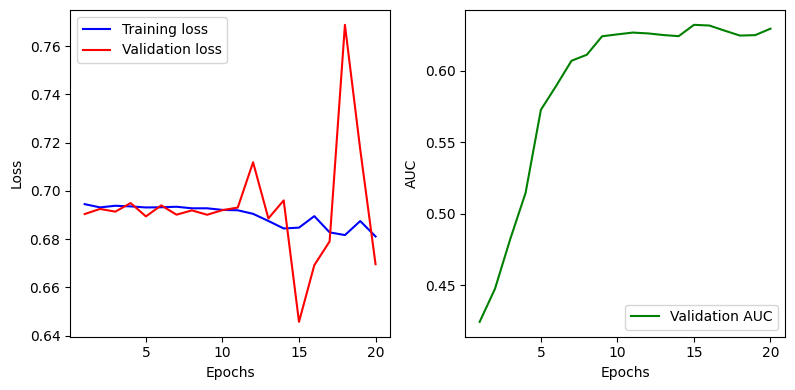

Best hyperparameters: {'hidden_dim': 32, 'layer_dim': 2, 'dropout_prob': 0.5, 'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001}
Best validation AUC: 0.6295


In [ ]:
# Run the cross validation on the refined parameters
best_model_3, best_hyperparams_3, best_auc_3 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    refined_param_combinations_3,
    num_folds=5,
    patience=5,
    output_path='checkpoints.pth'
)

print(f"Best hyperparameters: {best_hyperparams_3}")
print(f"Best validation AUC: {best_auc_3:.4f}")

# Save best model into pickle file
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_3/best_model_3.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_3, f)

# Save the best hyperparameters in a json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_3/best_hyperparams_3.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_3, f)

Best hyperparameters: {'hidden_dim': 32, 'layer_dim': 2, 'dropout_prob': 0.5, 'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001}

Best validation AUC: 0.6295


**Analysis**

The model is overfitting and poorly predicting.

It is likley due to poor quality data.

**Experiment 3 - Evaluate best model on the test set**

We can now evaluate this model on the test set

In [ ]:
import pickle
import json

In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_3/best_model_3.pkl'
with open(model_path, 'rb') as f:
    best_model_3 = pickle.load(f)

best_model_3

LSTMModel(
  (lstm): LSTM(16, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Load the best hyperparams
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_3/best_hyperparams_3.json'
with open(params_path, 'r') as f:
    best_hyperparams_3 = json.load(f)

best_hyperparams_3

{'hidden_dim': 32,
 'layer_dim': 2,
 'dropout_prob': 0.5,
 'learning_rate': 0.0005,
 'batch_size': 64,
 'num_epochs': 20,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 0.0001}

In [ ]:
# Create test data loader
_, _, test_loader_3 = create_data_loaders(
    test_sequences_3, test_labels_3,
    test_sequences_3, test_labels_3,
    test_sequences_3, test_labels_3,
    batch_size=best_hyperparams_3['batch_size']
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
best_model_3.to(device)

LSTMModel(
  (lstm): LSTM(16, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Evaluate the model on the test data
evaluate_model(best_model_3, test_loader, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4388
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.43882716809257094,
 0.0)

This model has generally worse performance on all metrics with the test data highlihting that it does not generalise well.

This performance is worse than the model without L2 regularisation. That model had more hidden dims and hence the larger complexity may have benefitted.

We will continue with our interpretability of feature ablation, SHAP and LIME but I want to run an Experiment 4 that has a proper cross validation with all parameter possibilities and do a proper Random Search to narrow down based on a 5-10% of the total combinations of a much larger parameter grid.

**Experiment 3 - Feature ablation**

In [ ]:
import pickle
import json

In [ ]:
# Load feature names
feature_names_2 = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_names_v2.pkl'

with open(feature_names_2, 'rb') as f:
    feature_names_2 = pickle.load(f)

feature_names_2

['EtCO2',
 'Inspired O2 Fraction',
 'Minute Volume',
 'O2 saturation pulseoxymetry',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Arterial CO2 Pressure',
 'Arterial O2 pressure',
 'PH (Arterial)',
 'Ventilator Mode',
 'Hemoglobin',
 'Plateau Pressure',
 'SpO2:FiO2',
 'P:F ratio']

Ablating feature EtCO2 (1/16)
Epoch 0/19, Loss: 0.6466, Val Loss: 0.6331, Val AUC: 0.5637
Epoch 1/19, Loss: 0.6343, Val Loss: 0.6332, Val AUC: 0.5701
Epoch 2/19, Loss: 0.6337, Val Loss: 0.6334, Val AUC: 0.5742
Epoch 3/19, Loss: 0.6330, Val Loss: 0.6339, Val AUC: 0.5788
Epoch 4/19, Loss: 0.6332, Val Loss: 0.6319, Val AUC: 0.5828
Epoch 5/19, Loss: 0.6321, Val Loss: 0.6327, Val AUC: 0.5848
Epoch 6/19, Loss: 0.6322, Val Loss: 0.6307, Val AUC: 0.5866
Epoch 7/19, Loss: 0.6304, Val Loss: 0.6287, Val AUC: 0.5877
Epoch 8/19, Loss: 0.6300, Val Loss: 0.6276, Val AUC: 0.5874
Epoch 9/19, Loss: 0.6303, Val Loss: 0.6260, Val AUC: 0.5875
Epoch 10/19, Loss: 0.6264, Val Loss: 0.6232, Val AUC: 0.5876
Epoch 11/19, Loss: 0.6269, Val Loss: 0.6231, Val AUC: 0.5887
Epoch 12/19, Loss: 0.6257, Val Loss: 0.6243, Val AUC: 0.5889
Epoch 13/19, Loss: 0.6243, Val Loss: 0.6214, Val AUC: 0.5889
Epoch 14/19, Loss: 0.6236, Val Loss: 0.6275, Val AUC: 0.5894
Epoch 15/19, Loss: 0.6222, Val Loss: 0.6224, Val AUC: 0.5891
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/19, Loss: 0.6641, Val Loss: 0.6348, Val AUC: 0.5602
Epoch 1/19, Loss: 0.6336, Val Loss: 0.6332, Val AUC: 0.5725
Epoch 2/19, Loss: 0.6334, Val Loss: 0.6326, Val AUC: 0.5785
Epoch 3/19, Loss: 0.6342, Val Loss: 0.6320, Val AUC: 0.5814
Epoch 4/19, Loss: 0.6318, Val Loss: 0.6304, Val AUC: 0.5852
Epoch 5/19, Loss: 0.6297, Val Loss: 0.6399, Val AUC: 0.5822
Epoch 6/19, Loss: 0.6272, Val Loss: 0.6226, Val AUC: 0.5832
Epoch 7/19, Loss: 0.6252, Val Loss: 0.6223, Val AUC: 0.5833
Epoch 8/19, Loss: 0.6245, Val Loss: 0.6219, Val AUC: 0.5843
Epoch 9/19, Loss: 0.6253, Val Loss: 0.6229, Val AUC: 0.5848
Early stopping
Ablating feature Respiratory Rate (6/16)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0/19, Loss: 0.6412, Val Loss: 0.6333, Val AUC: 0.5624
Epoch 1/19, Loss: 0.6334, Val Loss: 0.6327, Val AUC: 0.5806
Epoch 2/19, Loss: 0.6329, Val Loss: 0.6326, Val AUC: 0.5820
Epoch 3/19, Loss: 0.6320, Val Loss: 0.6307, Val AUC: 0.5831
Epoch 4/19, Loss: 0.6324, Val Loss: 0.6295, Val AUC: 0.5826
Epoch 5/19, Loss: 0.6311, Val Loss: 0.6288, Val AUC: 0.5838
Epoch 6/19, Loss: 0.6301, Val Loss: 0.6287, Val AUC: 0.5823
Epoch 7/19, Loss: 0.6267, Val Loss: 0.6243, Val AUC: 0.5829
Epoch 8/19, Loss: 0.6267, Val Loss: 0.6249, Val AUC: 0.5838
Epoch 9/19, Loss: 0.6245, Val Loss: 0.6254, Val AUC: 0.5831
Epoch 10/19, Loss: 0.6256, Val Loss: 0.6232, Val AUC: 0.5830
Epoch 11/19, Loss: 0.6246, Val Loss: 0.6259, Val AUC: 0.5830
Epoch 12/19, Loss: 0.6228, Val Loss: 0.6232, Val AUC: 0.5840
Epoch 13/19, Loss: 0.6252, Val Loss: 0.6223, Val AUC: 0.5832
Epoch 14/19, Loss: 0.6274, Val Loss: 0.6236, Val AUC: 0.5833
Epoch 15/19, Loss: 0.6245, Val Loss: 0.6224, Val AUC: 0.5835
Epoch 16/19, Loss: 0.6226, Val Los

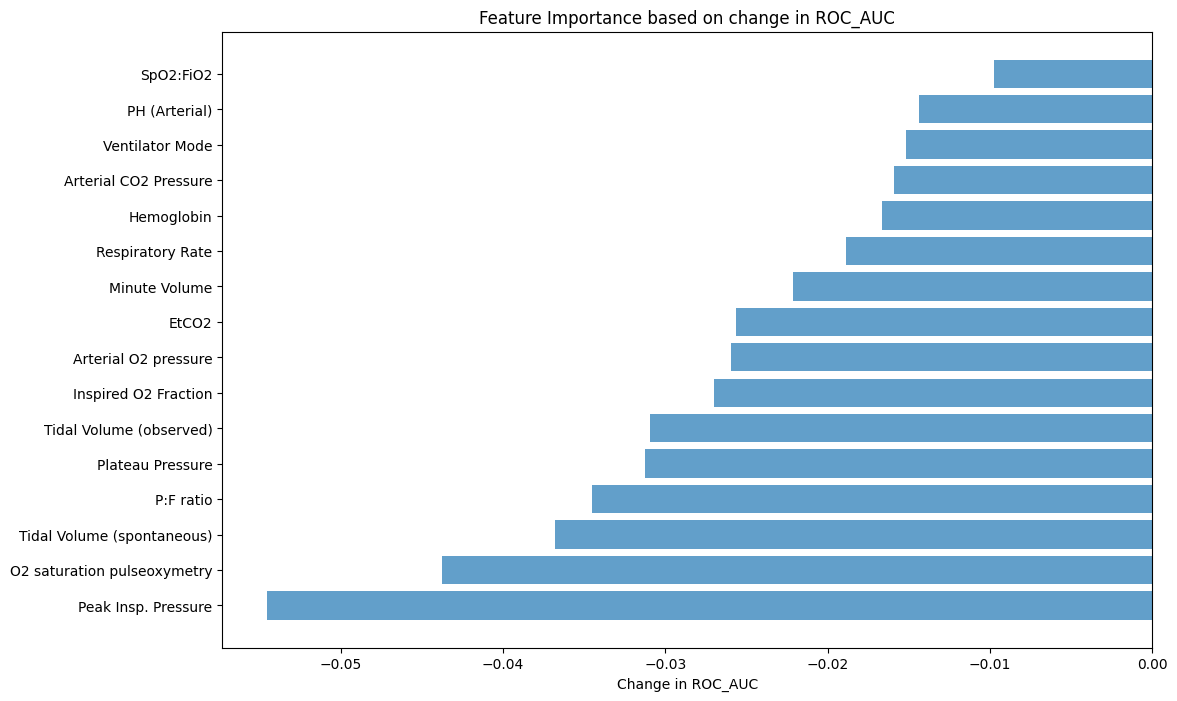

In [ ]:
# Run feature ablation
feature_importances_exp_3 = feature_ablation_with_names(
    train_sequences_3,
    train_labels_3,
    test_sequences_3,
    test_labels_3,
    best_model_3,
    best_hyperparams_3,
    device,
    feature_names_2
)

In this instance, peak insp pressure is the most influential and SpO2:FiO2 the least influential.

**Experiment 3 - Calculating F1 on the minority (failure) class**

Looking to see if the model is predicting better than random chance.

In [ ]:
best_model_3

LSTMModel(
  (lstm): LSTM(16, 32, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(sequences)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
# Create test data loader
_, _, test_loader_3 = create_data_loaders(
    test_sequences_3, test_labels_3,
    test_sequences_3, test_labels_3,
    test_sequences_3, test_labels_3,
    batch_size=best_hyperparams_3['batch_size']
)

In [ ]:
calculate_f1_minority(best_model_3, test_loader_3, device)

0.49319455564451564

Given the F1 score is below 0.5 it insinuates that the model is predicting worse than random guessing.

This highlights the fact that the model is overfitting and that the data is poor quality.

As such, we will do a systematic hyperparameter tuning. Further feature engineering past this point is not possible as the data was lacking to start hence required significant preprocessing.

We have laready implemented means of handling class imbalance and are tuning through model complexities.

To tackle data quality:
- FIlled in missing data
- Removed outliers
- Emsured data is consistent
- Resampled and interpolated to get into correct format
- Engineered new features

We can use y-data-profiling to generate an EDA profile.

# **Experiment 4**

Here we will try a much larger set of hyperparameters as the optimal network in Experiment 3 was quite small.

We will define a larger set of hyperparameters and run Bayesian Optimisation to help narrow down the hyperparameter space rather than Random Search (reference to show Bayesian optimisation is better).

In [ ]:
import itertools

In [ ]:
# Defining extensive parameter grid
param_grid_exp_4 = {
    'hidden_dim': [32, 64, 128, 256, 512],  # Focus on mid-range complexity
    'layer_dim': [1, 2, 3, 4],  # Stick to the best performing layer dimensions
    'dropout_prob': [0.0, 0.25, 0.5, 0.75],  # Regularization around mid-values
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],  # Fine-tune around the best performing learning rates
    'batch_size': [16, 32, 64, 128],  # Smaller and moderate batch sizesg
    'num_epochs': [10, 20, 30, 40, 50],  # 20 epochs seems ideal so no need to go much higher
    'sampling_method': ['normal', 'undersample', 'oversample'],  # Keep sampling methods for handling imbalance
    'loss': ['normal', 'weighted'],  # Use weighted loss only with normal sampling
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]  # Refined weight decay values
}

param_exp_4_combinations = list(itertools.product(*param_grid_exp_4.values()))

param_exp_4_combinations = [
    dict(zip(param_grid_exp_4.keys(), params))
    for params in param_exp_4_combinations
]

print(f"Total hyperparameter combinations: {len(param_exp_4_combinations)}")

Total hyperparameter combinations: 153600


For Bayesian Optimisation we will use the Optuna library

https://medium.com/@becaye-balde/bayesian-sorcery-for-hyperparameter-optimization-using-optuna-1ee4517e89a

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.0 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
def objective_wrapper(train_sequences, train_labels):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
        layer_dim = trial.suggest_categorical('layer_dim', [1, 2, 3, 4])
        dropout_prob = trial.suggest_categorical('dropout_prob', [0.0, 0.25, 0.5, 0.75])
        learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
        num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
        sampling_method = trial.suggest_categorical('sampling_method', ['normal', 'undersample', 'oversample'])
        loss = trial.suggest_categorical('loss', ['normal', 'weighted'])
        weight_decay = trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3, 1e-2])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
          raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

We will run Bayesian Optimisation for 100 trials - a medium range given the size of the search space we have in the parameter grid.

In [ ]:
# Run Optuna optimisation
study = optuna.create_study(direction='minimize')
study.optimize(objective_wrapper(train_sequences_3, train_labels_3), n_trials=100)

best_hyperparameters = study.best_params

print("Best hyperparameters:")
print(study.best_params)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
bayesian_optimised_params = best_hyperparameters
bayesian_optimised_params

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.5,
 'learning_rate': 0.0010410520665281547,
 'batch_size': 128,
 'num_epochs': 30,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 0.00011730803500835323}

Best hyperparam AUCROC: 0.637223055139097

The above represents the best hyperparameters based on a Bayesian Optimisation run of 100 trials.

We will now redefine the parameter grid based on this and train the model using Grid Search.

In [ ]:
bayesian_optimised_params = {'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.5,
 'learning_rate': 0.0010410520665281547,
 'batch_size': 128,
 'num_epochs': 30,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 0.00011730803500835323
}
bayesian_optimised_params

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.5,
 'learning_rate': 0.0010410520665281547,
 'batch_size': 128,
 'num_epochs': 30,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 0.00011730803500835323}

In [ ]:
# Save best hyperparams as json for later use if needed
import json
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_runs/bayesian_optimisation/bayesian_params.json'

with open(params_path, 'w') as f:
    json.dump(bayesian_optimised_params, f)

In [ ]:
def nearest_power_of_ten(x):
  return 10 ** np.round(np.log10(x))

In [ ]:
# Define new hyperparameter grid based on Bayesian Optimisation
bayesian_optimised_param_grid = {
    'hidden_dim': [bayesian_optimised_params['hidden_dim'] // 2, bayesian_optimised_params['hidden_dim'], bayesian_optimised_params['hidden_dim'] * 2],
    'layer_dim': [max(1, bayesian_optimised_params['layer_dim'] - 1), bayesian_optimised_params['layer_dim'], bayesian_optimised_params['layer_dim'] + 1],
    'dropout_prob': [max(0, bayesian_optimised_params['dropout_prob'] - 0.25), bayesian_optimised_params['dropout_prob'], min(1, bayesian_optimised_params['dropout_prob'] + 0.25)],
    'learning_rate': [
        nearest_power_of_ten(bayesian_optimised_params['learning_rate'] / 10),
        nearest_power_of_ten(bayesian_optimised_params['learning_rate']),
        nearest_power_of_ten(bayesian_optimised_params['learning_rate'] * 10)
    ],
    'batch_size': [max(16, bayesian_optimised_params['batch_size'] // 2), bayesian_optimised_params['batch_size'], min(128, bayesian_optimised_params['batch_size'] * 2)],
    'num_epochs': [max(10, bayesian_optimised_params['num_epochs'] - 10), bayesian_optimised_params['num_epochs'], bayesian_optimised_params['num_epochs'] + 10],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [
        nearest_power_of_ten(bayesian_optimised_params['weight_decay'] / 10),
        nearest_power_of_ten(bayesian_optimised_params['weight_decay']),
        nearest_power_of_ten(bayesian_optimised_params['weight_decay'] * 10)
    ]
}

bayesian_optimised_param_grid

{'hidden_dim': [64, 128, 256],
 'layer_dim': [1, 2, 3],
 'dropout_prob': [0.25, 0.5, 0.75],
 'learning_rate': [0.0001, 0.001, 0.01],
 'batch_size': [64, 128, 128],
 'num_epochs': [20, 30, 40],
 'sampling_method': ['normal', 'undersample', 'oversample'],
 'loss': ['normal', 'weighted'],
 'weight_decay': [1e-05, 0.0001, 0.001]}

In [ ]:
# Define all the parameter combinations
bayesian_optimised_param_combinations = list(itertools.product(*bayesian_optimised_param_grid.values()))

bayesian_optimised_param_combinations = [
    dict(zip(bayesian_optimised_param_grid.keys(), params))
    for params in bayesian_optimised_param_combinations
]

# Filter out combinations where weighted loss is used with undersampling or oversampling
bayesian_optimised_param_combinations = [
    params for params in bayesian_optimised_param_combinations
    if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')
]

print(f"Total hyperparameter combinations: {len(bayesian_optimised_param_combinations)}")

Total hyperparameter combinations: 8748


In terms of computational requirements to run 8748 combinations through Grid Search, this would be too extensive and given we are using colab we cannot run a notebook for longer than 24 hours without the runtime disconnecting.

As such, we need to further refine our hyperparameter grid.

Given that from previous runs we know the model is overfitting (highlighted by the high fluctuation in the validation loss), we can tune our param grid to try and prevent making the model overly complex.

In [ ]:
bayesian_optimised_param_grid_refined = {
    'hidden_dim': [64, 128, 256], # Focus on the best performing dimensions
    'layer_dim': [1, 2, 3], # Stick to the best performing layer dimensions
    'dropout_prob': [0.25, 0.5], # Regularization around mid-values
    'learning_rate': [0.001, 0.0005], # Fine-tune around the best performing learning rate
    'batch_size': [32, 64, 128], # Moderate batch sizes
    'num_epochs': [20, 30, 40], # Explore around 30 epochs
    'sampling_method': ['normal', 'undersample', 'oversample'], # Keep sampling methods for handling imbalance
    'loss': ['normal', 'weighted'], # Use weighted loss only with normal sampling
    'weight_decay': [0.0001, 0.001] # Refined weight decay values
}

bayesian_optimised_param_grid_refined_combinations = list(itertools.product(*bayesian_optimised_param_grid_refined.values()))

bayesian_optimised_param_combinations_refined = [
    dict(zip(bayesian_optimised_param_grid_refined.keys(), params))
    for params in bayesian_optimised_param_grid_refined_combinations
]

# Filter out combinations where weighted loss is used with undersampling or oversampling
bayesian_optimised_param_combinations_refined = [
    params for params in bayesian_optimised_param_combinations_refined
    if not (params['loss'] == 'weighted' and params['sampling_method'] != 'normal')
]

print(f"Total hyperparameter combinations: {len(bayesian_optimised_param_combinations_refined)}")

Total hyperparameter combinations: 2592


Streaming output truncated to the last 5000 lines.
Epoch 2/19, Loss: 0.8103, Val Loss: 0.8055, Val AUC: 0.5510
Epoch 3/19, Loss: 0.8104, Val Loss: 0.8048, Val AUC: 0.5534
Epoch 4/19, Loss: 0.8102, Val Loss: 0.8050, Val AUC: 0.5536
Epoch 5/19, Loss: 0.8102, Val Loss: 0.8048, Val AUC: 0.5536
Epoch 6/19, Loss: 0.8102, Val Loss: 0.8046, Val AUC: 0.5544
Epoch 7/19, Loss: 0.8102, Val Loss: 0.8046, Val AUC: 0.5574
Epoch 8/19, Loss: 0.8101, Val Loss: 0.8048, Val AUC: 0.5574
Epoch 9/19, Loss: 0.8101, Val Loss: 0.8049, Val AUC: 0.5580
Epoch 10/19, Loss: 0.8102, Val Loss: 0.8048, Val AUC: 0.5571
Epoch 11/19, Loss: 0.8101, Val Loss: 0.8048, Val AUC: 0.5570
Epoch 12/19, Loss: 0.8101, Val Loss: 0.8048, Val AUC: 0.5572
Early stopping
Params: {'hidden_dim': 256, 'layer_dim': 2, 'dropout_prob': 0.5, 'learning_rate': 0.0005, 'batch_size': 64, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted', 'weight_decay': 0.001}, Val AUC: 0.5572
Epoch 0/19, Loss: 0.6939, Val Loss: 0.6979, Val AUC: 0.6

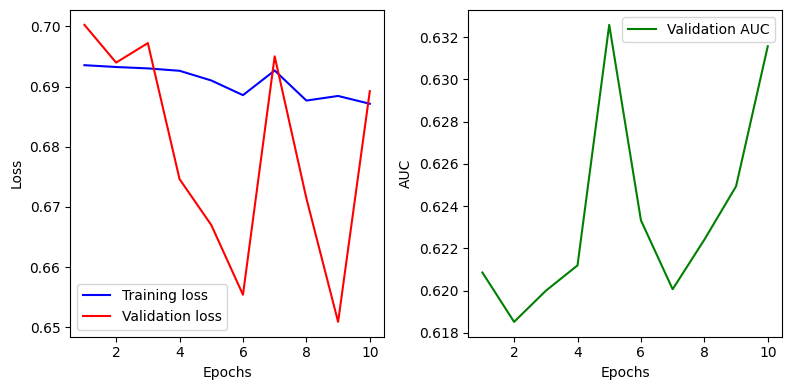

Best hyperparameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001}
Best validation AUC: 0.6316


In [ ]:
# Implement five-fold cross validation on the refined parameter set
best_model_4, best_hyperparams_4, best_auc_4 = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    bayesian_optimised_param_combinations_refined,
    num_folds=5,
    patience=5,
    output_path='checkpoints.pth'
)

print(f"Best hyperparameters: {best_hyperparams_4}")
print(f"Best validation AUC: {best_auc_4:.4f}")

# Save the best model and the best hyperparams
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_4/best_model_4.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model_4, f)

params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_4/best_hyperparams_4.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparams_4, f)

The model is still seemingly overfitting but this is clearly due to data quality.

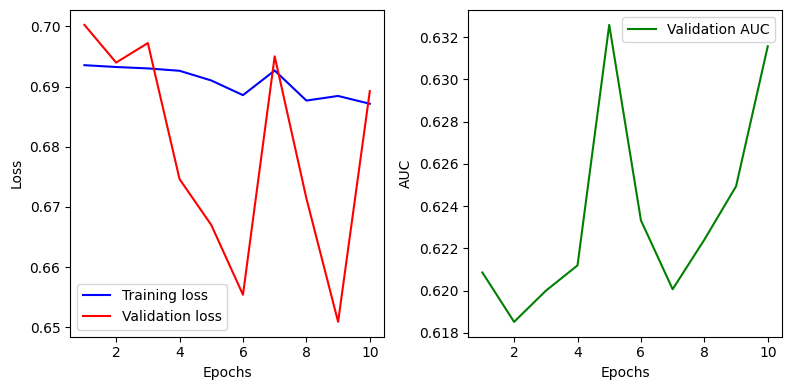

Best hyperparameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001}


**Experiment 4 - Model evaluation**

In [ ]:
# Load the best model
best_model_4 = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_4/best_model_4.pkl'
with open(best_model_4, 'rb') as f:
    best_model_4 = pickle.load(f)

best_model_4

LSTMModel(
  (lstm): LSTM(16, 64, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Load the best hyperparams
best_hyperparams_4 = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_4/best_hyperparams_4.json'
with open(best_hyperparams_4, 'r') as f:
    best_hyperparams_4 = json.load(f)

best_hyperparams_4

{'hidden_dim': 64,
 'layer_dim': 2,
 'dropout_prob': 0.25,
 'learning_rate': 0.001,
 'batch_size': 32,
 'num_epochs': 30,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 0.0001}

In [ ]:
# Create the test loader
_, _, test_loader_4 = create_data_loaders(
    test_sequences_3, test_labels_3,
    test_sequences_3, test_labels_3,
    test_sequences_3, test_labels_3,
    batch_size=best_hyperparams_4['batch_size']
)

In [ ]:
# Evaluate the model
evaluate_model(best_model_4, test_loader_4, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4561
Specificity: 0.0000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:911: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.45605086067171374,
 0.0)

The warning is more about how PyTorch implements LSTM and does not influence evaluation.

In [ ]:
def evaluate_model_2(model, test_loader, criterion, device):
    """
    Evaluate the model on the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    criterion (nn.Module): Loss function.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * sequences.size(0)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_scores)
    specificity = recall_score(y_true, y_pred, pos_label=0)

    return test_loss, accuracy, precision, recall, f1, roc_auc, specificity

# Usage example
criterion = nn.BCELoss()
test_loss, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_2(best_model_4, test_loader_4, criterion, device)

print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Specificity: {specificity:.4f}")

NameError: name 'best_model_4' is not defined

The fact that recall/sensitivity is 1 and specificity is 0 indicates that the model is only predicting the majority class or all 1s for all inputs.

This indicates that the model is not learning and is very likely overfitting significantly.

**Calculate the F1 score on the minority class**

In [ ]:
calculate_f1_minority(best_model_4, test_loader_4, device)

0.49319455564451564

Again the F1 score is below random guessing.

**Experiment 4 - Check for data imbalances and how they are handled**



In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
def analyze_class_distribution(sequences, labels):
    """
    Analyze the class distribution of the labels.

    Parameters:
    sequences (np.array): 3D numpy array of sequences.
    labels (np.array): 1D numpy array of labels.

    Returns:
    dict: A dictionary containing the count of each class.
    """
    # Flatten the sequences to get individual labels
    all_labels = labels.flatten()

    # Count the occurrences of each class
    class_counts = Counter(all_labels)

    return class_counts

def plot_class_distribution(class_counts):
    """
    Plot the class distribution.

    Parameters:
    class_counts (dict): A dictionary containing the count of each class.
    """
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(8, 6))
    plt.bar(classes, counts, color='blue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

In [ ]:
class_counts = analyze_class_distribution(test_sequences_3, test_labels_3)
print("Class Distribution:")
print(class_counts)

Class Distribution:
Counter({0.0: 633, 1.0: 308})


In [ ]:
class_counts = analyze_class_distribution(train_sequences_3, train_labels_3)
print("Class Distribution:")
print(class_counts)

Class Distribution:
Counter({0.0: 2524, 1.0: 1236})


Now lets see what happens when we under and oversample the data

In [ ]:
original_class_counts = analyze_class_distribution(test_sequences_3, test_labels_3)
print("Normal sampling distribution", original_class_counts)

oversampled_sequences, oversampled_labels = oversample_data(test_sequences_3, test_labels_3)
oversampled_class_counts = analyze_class_distribution(oversampled_sequences, oversampled_labels)
print("Oversampling distribution", oversampled_class_counts)

undersampled_sequences, undersampled_labels = undersample_data(test_sequences_3, test_labels_3)
undersampled_class_counts = analyze_class_distribution(undersampled_sequences, undersampled_labels)
print("Undersampling distribution", undersampled_class_counts)

Normal sampling distribution Counter({0.0: 633, 1.0: 308})
Oversampling distribution Counter({0.0: 633, 1.0: 633})
Undersampling distribution Counter({0.0: 308, 1.0: 308})


My under and oversampling is functioning correctly.

The low accuracy and ROC AUC could indicate the model is overfitting the training data and failing to generalize to the test data. Regularization techniques such as dropout, weight decay, and early stopping can help mitigate overfitting (these are all being applied).



**Experiment 4 - Visualise predictions with confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)


In [ ]:
y_true, y_pred, y_scores = get_model_predictions(best_model_4, test_loader_4, device)

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  0 633]
 [  0 308]]


In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xtclaicklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['Success', 'Failure']  # Replace with your actual class names if different

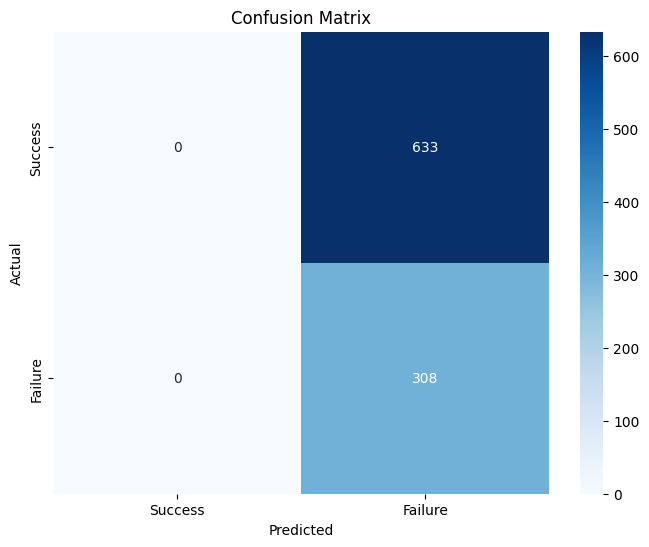

**Addendum - Trying the hyperparameters found using Bayesian optimisation**

In practice it has shown that Grid Search is empircially worse than randomly chosen trials (Random Search for Hyper-Parameter Optimization: https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf).

It has also been shown that Bayesian optmisation is better than random search (https://arxiv.org/abs/2104.10201)


Step 1 - Evaluate the model developed on the Bayesian recommended params

In [ ]:
bayesian_optimised_params

{'hidden_dim': 128,
 'layer_dim': 2,
 'dropout_prob': 0.5,
 'learning_rate': 0.0010410520665281547,
 'batch_size': 128,
 'num_epochs': 30,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 0.00011730803500835323}

In [ ]:
# Create a model from these optimised params
bayes_hyperparameters = {
    'hidden_dim': 128,
    'layer_dim': 2,
    'dropout_prob': 0.5,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'num_epochs': 30,
    'sampling_method': 'oversample',
    'loss': 'normal',
    'weight_decay': 1e-4
}

In [ ]:
bayes_model = LSTMModel(
    input_dim=16,
    hidden_dim=bayes_hyperparameters['hidden_dim'],
    layer_dim=bayes_hyperparameters['layer_dim'],
    output_dim=1,
    dropout_prob=bayes_hyperparameters['dropout_prob']
).to(device)

bayes_model

LSTMModel(
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Evaluate the Bayes model
evaluate_model(bayes_model, test_loader_4, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4722
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.4721538335282411,
 0.0)

In [ ]:
calculate_f1_minority(bayes_model, test_loader_4, device)

0.49319455564451564

In [ ]:
# Grid search defined model
best_model_4

LSTMModel(
  (lstm): LSTM(16, 64, num_layers=2, batch_first=True, dropout=0.25)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Evaluate the grid search model
evaluate_model(best_model_4, test_loader_4, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4561
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.45605086067171374,
 0.0)

In [ ]:
calculate_f1_minority(best_model_4, test_loader_4, device)

0.49319455564451564

With sensitivity being so high it highlights that the model did not have enough time to learn anything.

Maybe changing the min_delta for early stoping affected this, meaning it stopped too soon before it could learn anything.

Prevention of Overfitting: A higher min_delta can help in preventing overfitting by stopping the training earlier. It ensures that only significant improvements are considered, potentially avoiding excessive training on noise in the data.

Insufficient Learning: Conversely, if min_delta is set too high, the training might stop too early, before the model has had a chance to converge sufficiently. This can result in underfitting, where the model does not capture the underlying patterns in the training data effectively.

Given the inherent complexity of the dataset as dynamic time-series data, the min-delta may need to be set back to 0.

Let's change it back and re-run the bayes optimisation

**Interesting point**

What is interesting is the performance with Bayesian optimisation as a tuning technique after 100 trials is essentially the same as that of full Grid Search with c. 2500 combinations.

Bayesian optimisation is significantly less computationally expensive and would be worth using in further experiments over grid search for efficiency purposes.

# **Experiment 5**


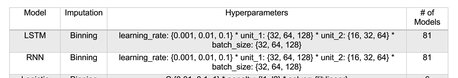

Paper by Fenske et al. (https://www.medrxiv.org/content/10.1101/2024.06.28.24309547v1.full#T5) only uses a few parameters to do hyperparameter tuning (Developing and validating a machine learning model to predict successful next-day extubation in the ICU). This is not very informative.

**This paper was only published last month**

Zhao et al. used Neural Network Intelligence with the Tree-structured Parzen Extimator which is a Bayesian technique for hyperparameter tuning (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8165178/).

"One hundred trials were carried out and the parameters with the greatest area under the receiver operating characteristic (AUROC) were saved"

Reference paper Zeng (LSTM extubation) used Grid Search (https://biodatamining.biomedcentral.com/articles/10.1186/s13040-022-00309-7) for hyperparameter tuning.

**Step 1: Set up parameter grid**

In [ ]:
param_grid_exp_5 = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_exp_5_combinations = list(itertools.product(*param_grid_exp_5.values()))

param_exp_5_combinations = [
    dict(zip(param_grid_exp_5.keys(), params))
    for params in param_exp_5_combinations
]

print(f"Total hyperparameter combinations: {len(param_exp_5_combinations)}")

Total hyperparameter combinations: 153600


There are far too many hyperparameter combinations here to even consider a grid search.

As such, Bayesian optimisation is more efficient as a means of hyperparameter tuning. Furthermore, with the Optuna package, very little change is required in my code for the objective function as we can use the cross validation we have already defined.

Previously, 100 trials was sufficient to produce a model that had comparable and sligthly better performance to an extensive Grid Search procedure. Thus, we will continue with this number of trials.

**Experiment 5 - Implement Bayesian Optimisation for Hyperparameter tuning**

The Optuna package will be implemented for ease of use and trials run with 5-fold cross validation with early stopping implemented (min_delta = 0).

In [ ]:
# Run bayesian optimisation
def objective_wrapper(train_sequences, train_labels):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
        layer_dim = trial.suggest_categorical('layer_dim', [1, 2, 3, 4])
        dropout_prob = trial.suggest_categorical('dropout_prob', [0.0, 0.25, 0.5, 0.75])
        learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
        num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
        sampling_method = trial.suggest_categorical('sampling_method', ['normal', 'undersample', 'oversample'])
        loss = trial.suggest_categorical('loss', ['normal', 'weighted'])
        weight_decay = trial.suggest_categorical('weight_decay', [1e-5, 1e-4, 1e-3, 1e-2])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
          raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

In [ ]:
import json

In [ ]:
# Execute an optuna study to run bayesian optimisation
study_exp_5 = optuna.create_study(direction='minimize')
study_exp_5.optimize(objective_wrapper(train_sequences_3, train_labels_3), n_trials=100)

best_hyperparameters = study_exp_5.best_params
best_score = study_exp_5.best_value

# Save the best hyperparameters to json file
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_5/best_hyperparameters.json'
with open(params_path, 'w') as f:
    json.dump(best_hyperparameters, f)

print("Best hyperparameters:")
print(study_exp_5.best_params)
print("Best score:", best_score)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'hidden_dim': 256, 'layer_dim': 2, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 1e-05}

Best score: -0.6449322709163346

**Step 2: Retrain the model with the best hyperparameters on the full training data**

In [ ]:
import pickle
import json

In [ ]:
# Load best hyperparams from bayesian optimisation
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_5/best_hyperparameters.json'

with open(params_path, 'r') as f:
    bayesian_params = json.load(f)

bayesian_params

{'hidden_dim': 256,
 'layer_dim': 2,
 'dropout_prob': 0.5,
 'learning_rate': 0.0001,
 'batch_size': 32,
 'num_epochs': 10,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 1e-05}

In [ ]:
# Create final model
input_dim = train_sequences_3.shape[2]
output_dim = 1

# Define the final model
final_model = LSTMModel(
    input_dim=input_dim,
    hidden_dim=bayesian_params['hidden_dim'],
    layer_dim=bayesian_params['layer_dim'],
    output_dim=output_dim,
    dropout_prob=bayesian_params['dropout_prob']
)

In [ ]:
# Define the loss function
if bayesian_params['loss'] == 'normal':
    criterion = nn.BCELoss()
else:
    pos_weight = torch.tensor([2.0])
    criterion = nn.BCELoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(
    final_model.parameters(),
    lr=bayesian_params['learning_rate'],
    weight_decay=bayesian_params['weight_decay']
)

In [ ]:
# Handle sampling method
if bayesian_params['sampling_method'] == 'undersample':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences_3, train_labels_3)
elif bayesian_params['sampling_method'] == 'oversample':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences_3, train_labels_3)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences_3, train_labels_3

In [ ]:
# Create data loader for train and test data
train_loader_5, val_loader_5, test_loader_5 = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    train_sequences_resampled, train_labels_resampled,
    test_sequences_3, test_labels_3,
    batch_size=bayesian_params['batch_size']
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Train the model with early stopping
trained_model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
    final_model,
    train_loader_5,
    val_loader_5,
    criterion,
    optimizer,
    bayesian_params['num_epochs'],
    device,
    patience=5,
    output_path="None"
)

Epoch 0/9, Loss: 0.6935, Val Loss: 0.6929, Val AUC: 0.5794
Epoch 1/9, Loss: 0.6930, Val Loss: 0.6925, Val AUC: 0.5880
Epoch 2/9, Loss: 0.6925, Val Loss: 0.6919, Val AUC: 0.5885
Epoch 3/9, Loss: 0.6929, Val Loss: 0.6912, Val AUC: 0.5900
Epoch 4/9, Loss: 0.6893, Val Loss: 0.6881, Val AUC: 0.5892
Epoch 5/9, Loss: 0.6850, Val Loss: 0.6814, Val AUC: 0.5893
Epoch 6/9, Loss: 0.6850, Val Loss: 0.6837, Val AUC: 0.5900
Epoch 7/9, Loss: 0.6818, Val Loss: 0.6802, Val AUC: 0.5885
Epoch 8/9, Loss: 0.6821, Val Loss: 0.6793, Val AUC: 0.5905
Epoch 9/9, Loss: 0.6827, Val Loss: 0.6792, Val AUC: 0.5904


In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_5/trained_model.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(trained_model, f)

**Step 3: Evaluate the final model on the test set**

In [ ]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader_5, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4667
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.46666820541228127,
 0.0)

## **Addendum**

The model still has the exact same performance with sensitivity - 1 and specificity - 0.

This didnt seem to be the case when using train_sequences_2 so we will quickly compare train_sequences_2 and 3

In [ ]:
print("Shape of train_sequences_2:", train_sequences_2.shape)
print("Shape of train_sequences_3:", train_sequences_3.shape)

print("Shape of test_sequences_2:", test_sequences_2.shape)
print("Shape of test_sequences_3:", test_sequences_3.shape)

print("Shape of train_labels_2:", train_labels_2.shape)
print("Shape of train_labels_3:", train_labels_3.shape)

print("Shape of test_labels_2:", test_labels_2.shape)
print("Shape of test_labels_3:", test_labels_3.shape)

Shape of train_sequences_2: (3760, 13, 16)
Shape of train_sequences_3: (3760, 13, 16)
Shape of test_sequences_2: (941, 13, 16)
Shape of test_sequences_3: (941, 13, 16)
Shape of train_labels_2: (3760,)
Shape of train_labels_3: (3760,)
Shape of test_labels_2: (941,)
Shape of test_labels_3: (941,)


In [ ]:
from collections import Counter
print("Counts of train_labels_2:", Counter(train_labels_2))
print("Counts of train_labels_3:", Counter(train_labels_3))

print("Counts of test_labels_2:", Counter(test_labels_2))
print("Counts of test_labels_3:", Counter(test_labels_3))

Counts of train_labels_2: Counter({0.0: 2524, 1.0: 1236})
Counts of train_labels_3: Counter({0.0: 2524, 1.0: 1236})
Counts of test_labels_2: Counter({0.0: 633, 1.0: 308})
Counts of test_labels_3: Counter({0.0: 633, 1.0: 308})


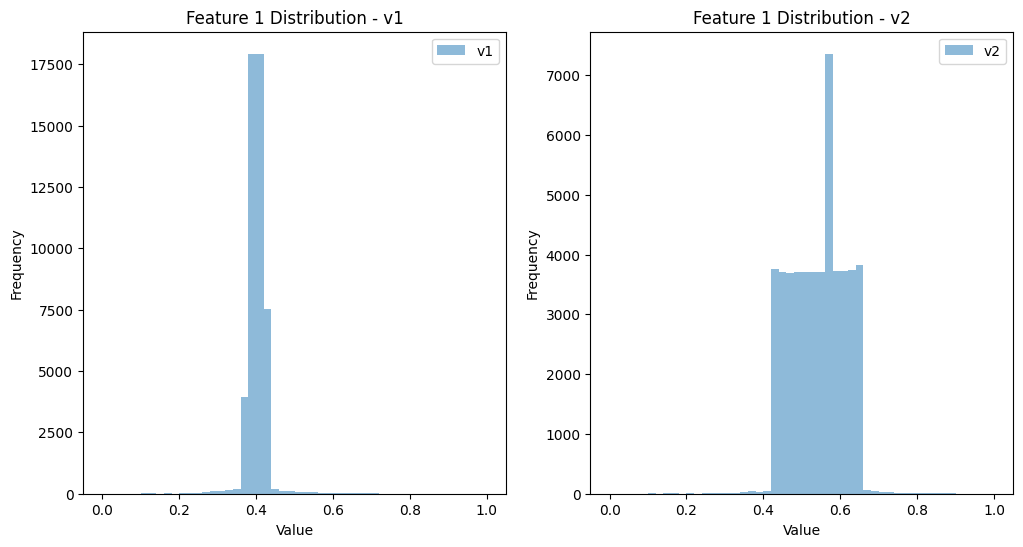

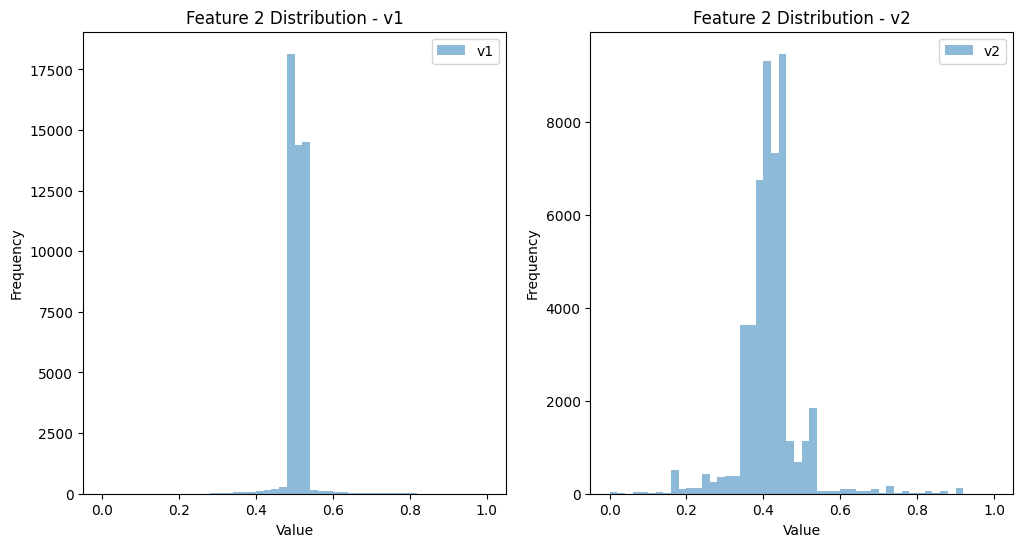

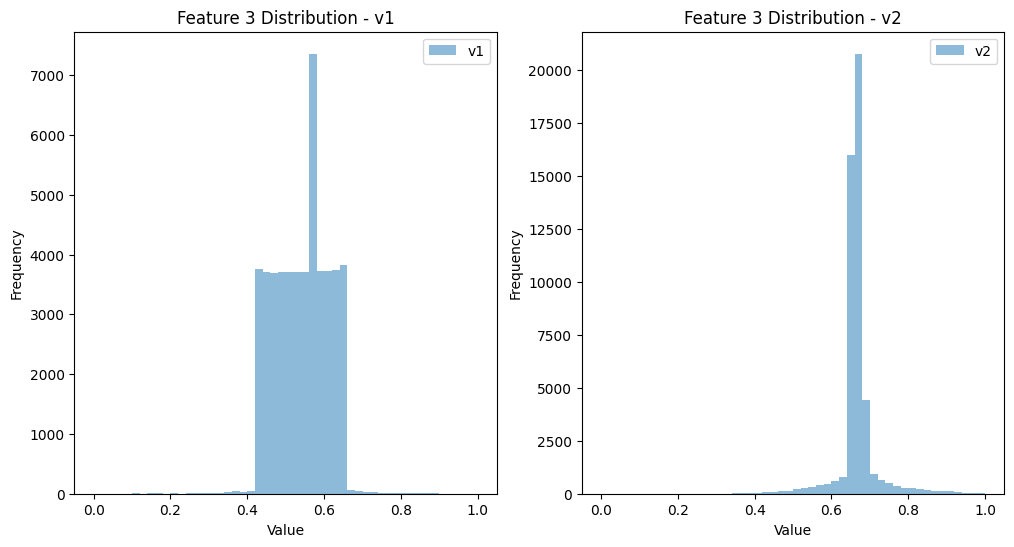

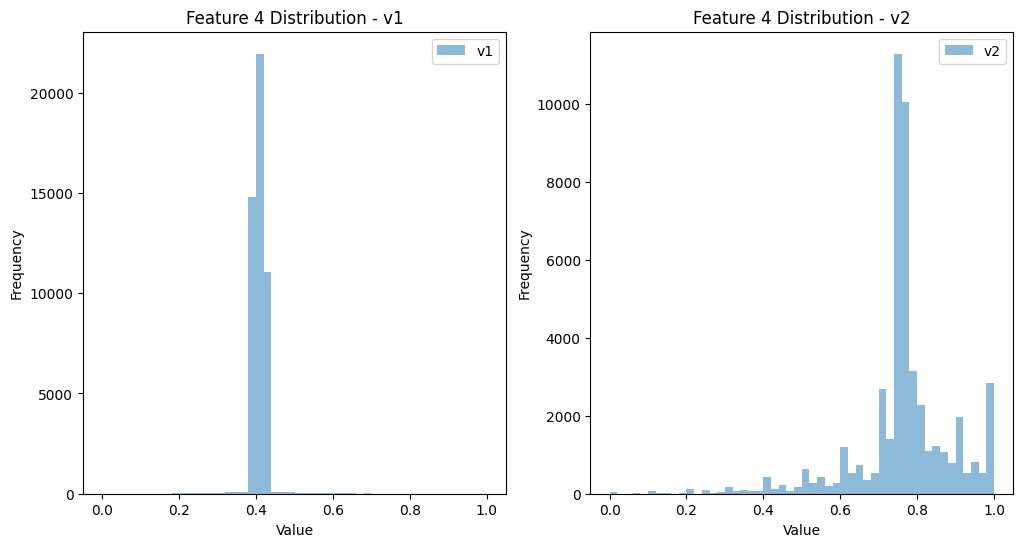

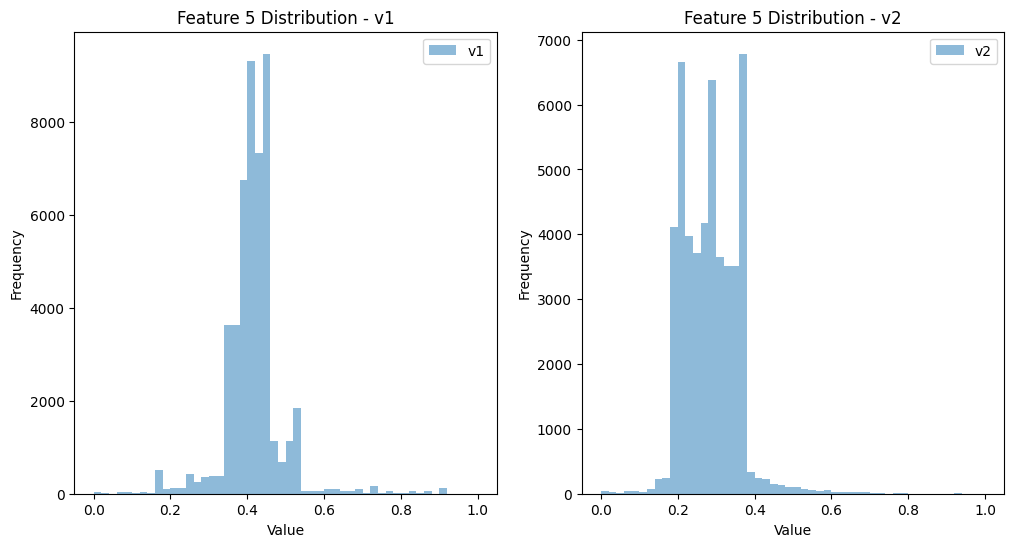

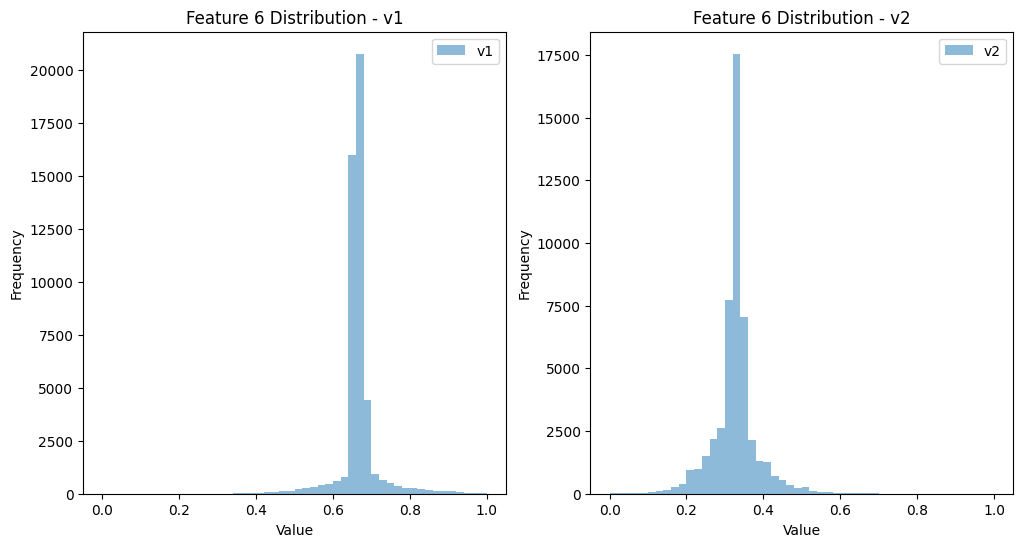

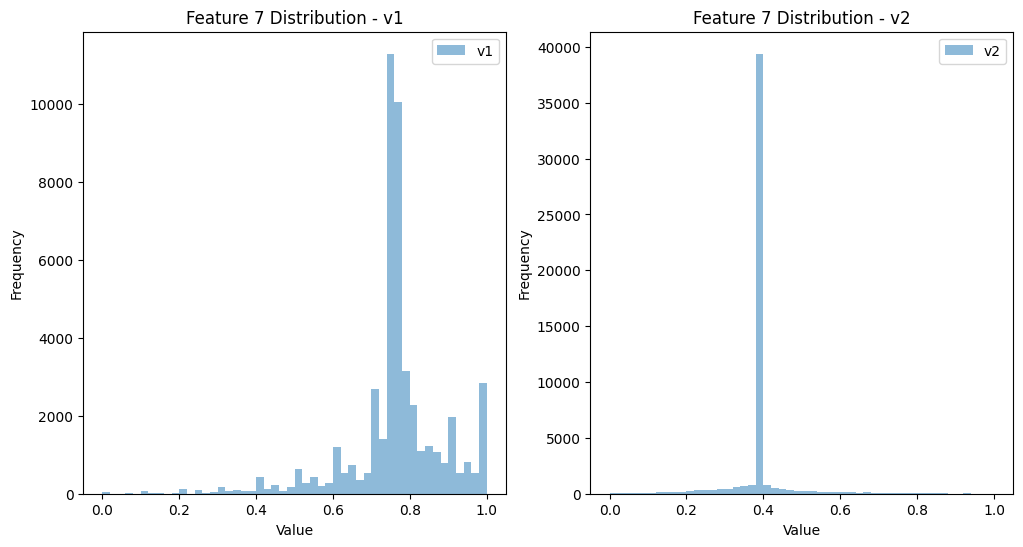

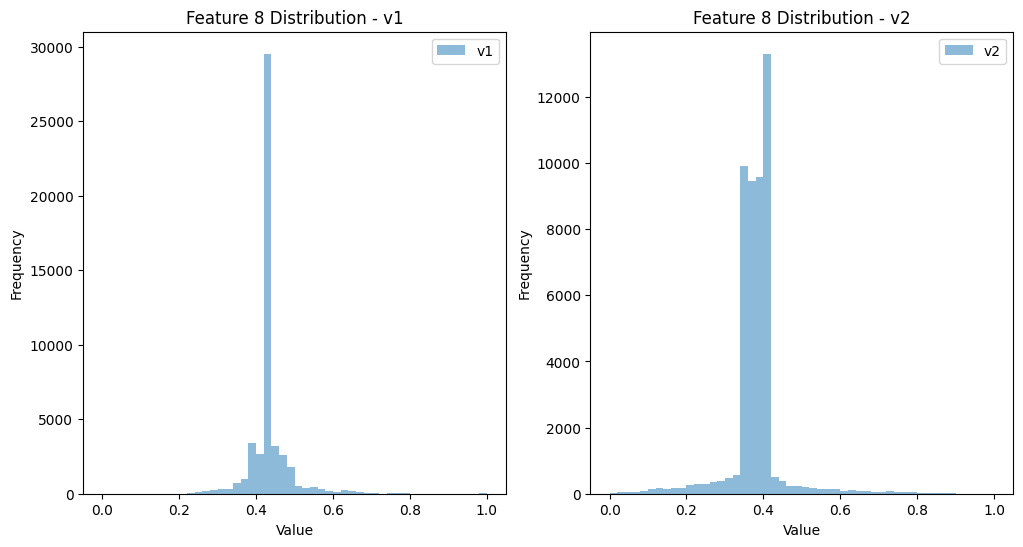

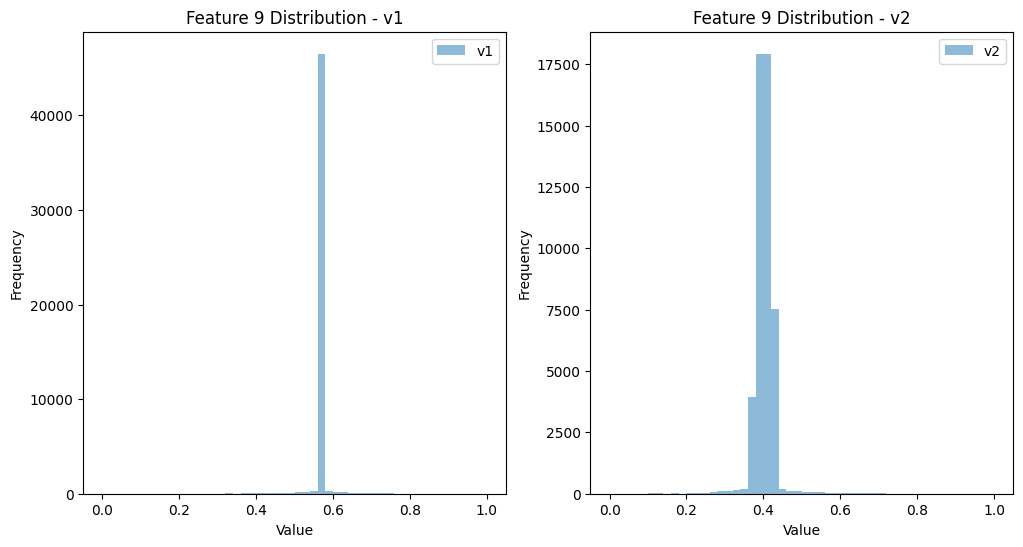

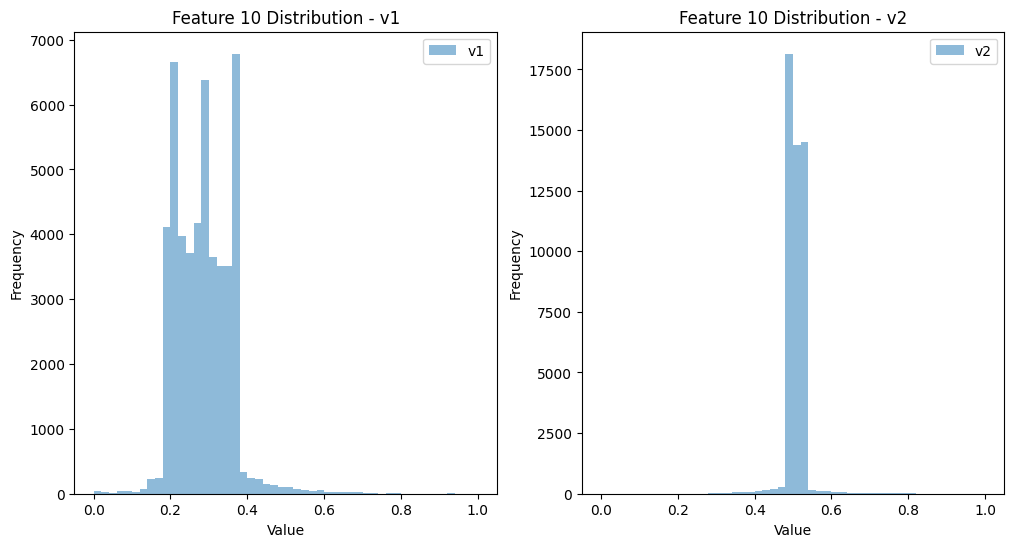

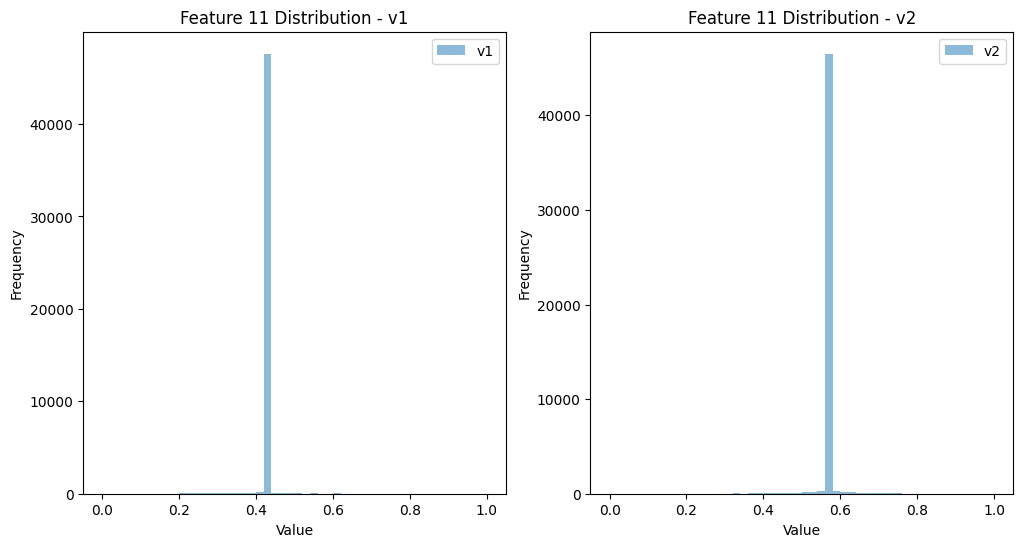

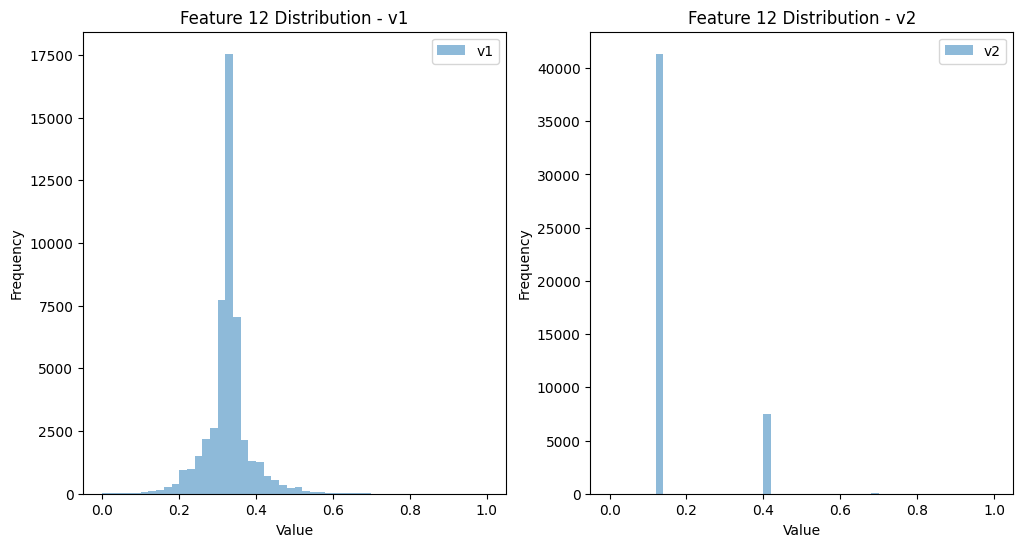

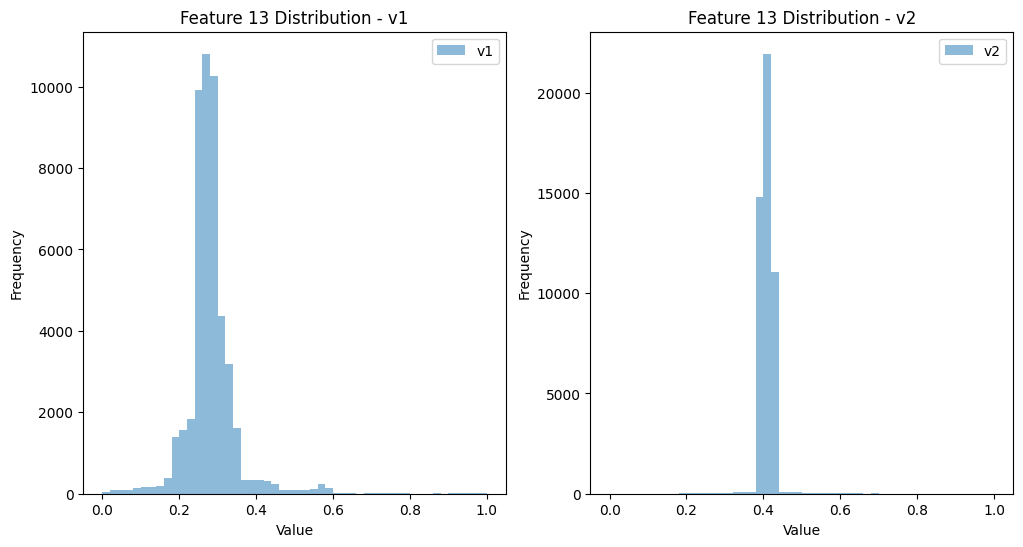

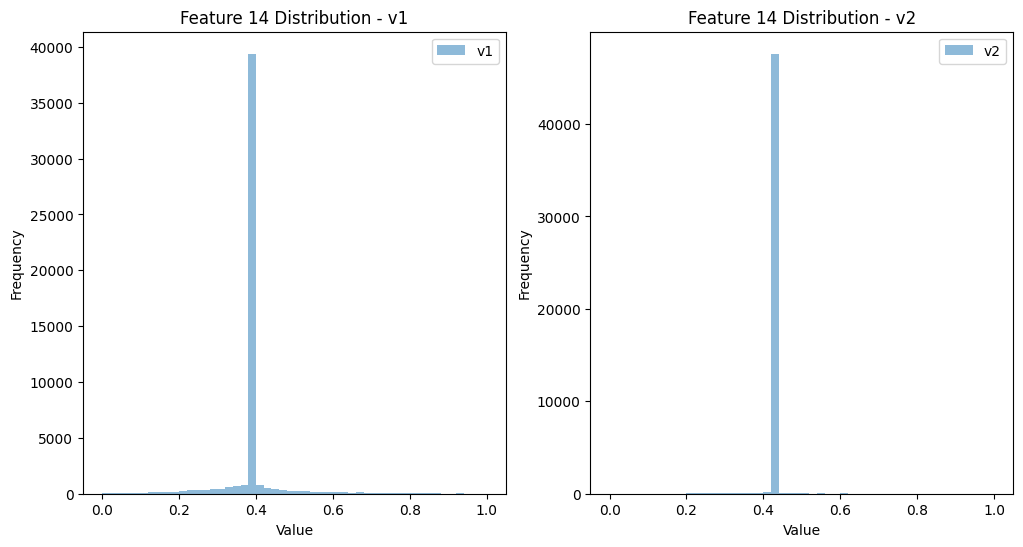

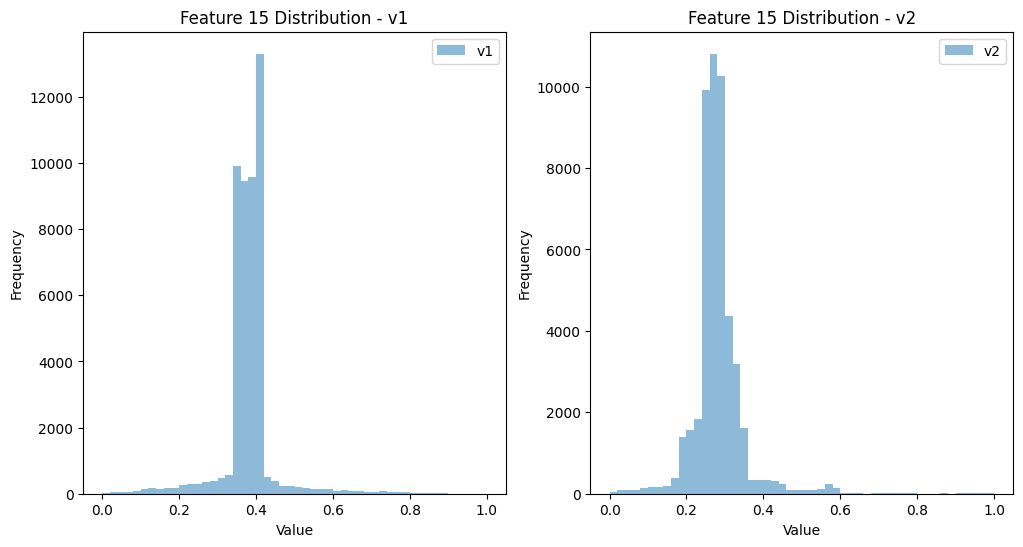

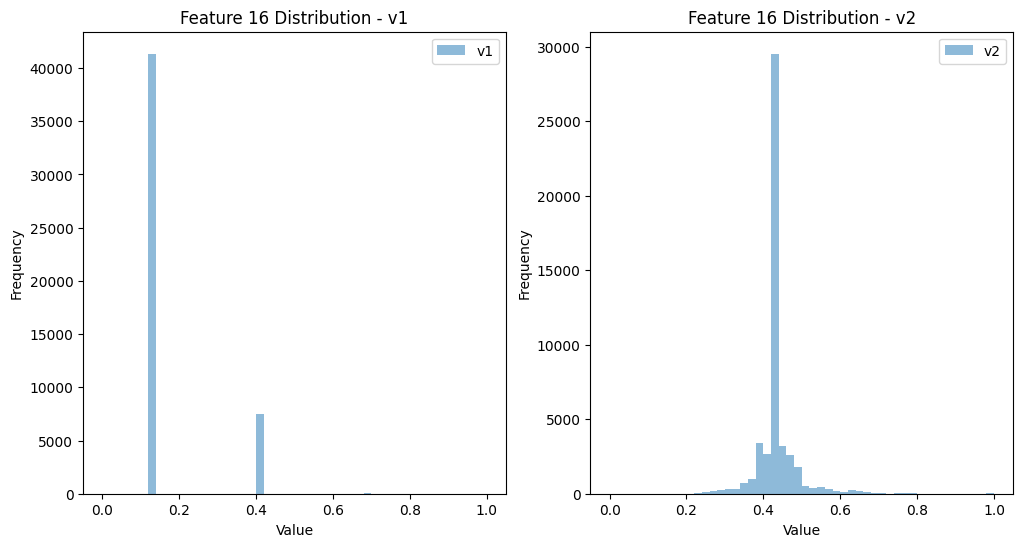

In [ ]:
num_features = train_sequences_2.shape[2]

for i in range(num_features):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(train_sequences_2[:, :, i].flatten(), bins=50, alpha=0.5, label='v1')
    plt.title(f'Feature {i+1} Distribution - v1')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(train_sequences_3[:, :, i].flatten(), bins=50, alpha=0.5, label='v2')
    plt.title(f'Feature {i+1} Distribution - v2')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.show()

The order of the features do not correlate but the distributions of the data is the same.

**Step 4: Interpretability - Ablation, SHAP and LIME**

**Step 5: Save the model**

# **Experiment 6 - Bayesian Optimisation on train_sequences_2**

**Experiment 6a - try on test_sequences_2**

We will try training the model on train_sequences_2 and see if there is a difference.

Then we will try and do without L2 regularisation.

In [ ]:
import itertools

In [ ]:
param_grid_exp_6 = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_exp_6_combinations = list(itertools.product(*param_grid_exp_6.values()))

param_exp_6_combinations = [
    dict(zip(param_grid_exp_6.keys(), params))
    for params in param_exp_6_combinations
]

print(f"Total hyperparameter combinations: {len(param_exp_6_combinations)}")

Total hyperparameter combinations: 153600


Initially we will just tune with 10 trials just to see if there is a change in Sensitivity and Specificity.

In [ ]:
# Run Bayesian Optimisation
study_exp_6 = optuna.create_study(direction='minimize')
study_exp_6.optimize(objective_wrapper(train_sequences_2, train_labels_2), n_trials=100)

best_hyperparameters = study_exp_6.best_params

print("Best hyperparameters:")
print(study_exp_6.best_params)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
best_hyperparameters = study_exp_6.best_params
best_score = study_exp_6.best_value

print("Best hyperparameters:")
print(study_exp_6.best_params)
print("Best score:", best_score)

Best hyperparameters:
{'hidden_dim': 256, 'layer_dim': 3, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.0001}
Best score: -0.6284074022947439


In [ ]:
bayesian_params_exp_6 = best_hyperparameters
bayesian_params_exp_6

{'hidden_dim': 256,
 'layer_dim': 3,
 'dropout_prob': 0.5,
 'learning_rate': 0.001,
 'batch_size': 128,
 'num_epochs': 40,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 0.0001}

In [ ]:
# Create final model
input_dim = train_sequences_3.shape[2]
output_dim = 1

# Define the final model
model_exp_6 = LSTMModel(
    input_dim=input_dim,
    hidden_dim=bayesian_params_exp_6['hidden_dim'],
    layer_dim=bayesian_params_exp_6['layer_dim'],
    output_dim=output_dim,
    dropout_prob=bayesian_params_exp_6['dropout_prob']
)

# Define the loss function
if bayesian_params_exp_6['loss'] == 'normal':
    criterion = nn.BCELoss()
else:
    pos_weight = torch.tensor([2.0])
    criterion = nn.BCELoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(
    model_exp_6.parameters(),
    lr=bayesian_params_exp_6['learning_rate'],
    weight_decay=bayesian_params_exp_6['weight_decay']
)

# Handle sampling method
if bayesian_params_exp_6['sampling_method'] == 'undersample':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences_2, train_labels_2)
elif bayesian_params_exp_6['sampling_method'] == 'oversample':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences_2, train_labels_2)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences_2, train_labels_2

# Create data loader for train and test data
train_loader_6, val_loader_6, test_loader_6 = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    train_sequences_resampled, train_labels_resampled,
    test_sequences_2, test_labels_2,
    batch_size=bayesian_params_exp_6['batch_size']
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Retrain model
trained_model_exp_6, train_losses_exp_6, val_losses_exp_6, val_aucs_exp_6 = train_model_with_early_stopping_logging(
    model_exp_6,
    train_loader_6,
    val_loader_6,
    criterion,
    optimizer,
    bayesian_params_exp_6['num_epochs'],
    device,
    patience=5,
    output_path="None"
)

Epoch 0/39, Loss: 0.6227, Val Loss: 0.6180, Val AUC: 0.5972
Epoch 1/39, Loss: 0.6196, Val Loss: 0.6177, Val AUC: 0.5983
Epoch 2/39, Loss: 0.6205, Val Loss: 0.6180, Val AUC: 0.5980
Epoch 3/39, Loss: 0.6221, Val Loss: 0.6239, Val AUC: 0.5967
Epoch 4/39, Loss: 0.6225, Val Loss: 0.6186, Val AUC: 0.5985
Epoch 5/39, Loss: 0.6226, Val Loss: 0.6178, Val AUC: 0.5985
Epoch 6/39, Loss: 0.6213, Val Loss: 0.6187, Val AUC: 0.5986
Epoch 7/39, Loss: 0.6208, Val Loss: 0.6187, Val AUC: 0.5989
Epoch 8/39, Loss: 0.6208, Val Loss: 0.6211, Val AUC: 0.5984
Epoch 9/39, Loss: 0.6219, Val Loss: 0.6192, Val AUC: 0.5990
Epoch 10/39, Loss: 0.6218, Val Loss: 0.6218, Val AUC: 0.5990
Epoch 11/39, Loss: 0.6243, Val Loss: 0.6194, Val AUC: 0.5996
Epoch 12/39, Loss: 0.6199, Val Loss: 0.6174, Val AUC: 0.5998
Epoch 13/39, Loss: 0.6218, Val Loss: 0.6180, Val AUC: 0.5995
Epoch 14/39, Loss: 0.6233, Val Loss: 0.6240, Val AUC: 0.5980
Epoch 15/39, Loss: 0.6217, Val Loss: 0.6267, Val AUC: 0.5976
Epoch 16/39, Loss: 0.6269, Val Los

In [ ]:
evaluate_model(trained_model_exp_6, test_loader_6, device)

Accuracy: 0.6759
Precision: 0.5190
Recall (Sensitivity): 0.1331
F1 Score: 0.2119
ROC AUC: 0.5613
Specificity: 0.9400


(0.6758767268862912,
 0.5189873417721519,
 0.1331168831168831,
 0.2118863049095607,
 0.5613164481647894,
 0.9399684044233807)

In [ ]:
# Save this model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_6/trained_model_on_sequence_2_v1.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(trained_model_exp_6, f)


**Trained model on 20 trial runs with Bayesian optimisation**

trained_model_on_sequence_2_v1

Hyperparameters:
{'hidden_dim': 256,
 'layer_dim': 3,
 'dropout_prob': 0.5,
 'learning_rate': 0.001,
 'batch_size': 128,
 'num_epochs': 40,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 0.0001}

Evaluation:
Accuracy: 0.6759
Precision: 0.5190
Recall (Sensitivity): 0.1331
F1 Score: 0.2119
ROC AUC: 0.5613
Specificity: 0.9400


**Hyperparameters on run with 100 trials**

In [ ]:
bayesian_params_exp_6a = best_hyperparameters
bayesian_params_exp_6a

{'hidden_dim': 128,
 'layer_dim': 1,
 'dropout_prob': 0.5,
 'learning_rate': 0.001,
 'batch_size': 32,
 'num_epochs': 50,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 1e-05}

In [ ]:
best_score_exp_6a = study_exp_6.best_value
best_score_exp_6a

-0.650697769657258

In [ ]:
# Save best hyperparameters
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/01_lstm_model/dynamic_model_best_models/experiment_6/best_hyperparameters_exp_6a.json'
with open(params_path, 'w') as f:
    json.dump(bayesian_params_exp_6a, f)

In [ ]:
# Create final model
input_dim = train_sequences_2.shape[2]
output_dim = 1

# Define the final model
model_exp_6a = LSTMModel(
    input_dim=input_dim,
    hidden_dim=bayesian_params_exp_6a['hidden_dim'],
    layer_dim=bayesian_params_exp_6a['layer_dim'],
    output_dim=output_dim,
    dropout_prob=bayesian_params_exp_6a['dropout_prob']
)

# Define the loss function
if bayesian_params_exp_6a['loss'] == 'normal':
    criterion = nn.BCELoss()
else:
    pos_weight = torch.tensor([2.0])
    criterion = nn.BCELoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(
    model_exp_6.parameters(),
    lr=bayesian_params_exp_6a['learning_rate'],
    weight_decay=bayesian_params_exp_6a['weight_decay']
)

# Handle sampling method
if bayesian_params_exp_6a['sampling_method'] == 'undersample':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences_2, train_labels_2)
elif bayesian_params_exp_6a['sampling_method'] == 'oversample':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences_2, train_labels_2)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences_2, train_labels_2

# Create data loader for train and test data
train_loader_6a, val_loader_6a, test_loader_6a = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    train_sequences_resampled, train_labels_resampled,
    test_sequences_2, test_labels_2,
    batch_size=bayesian_params_exp_6a['batch_size']
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Retrain model
trained_model_exp_6a, train_losses_exp_6a, val_losses_exp_6a, val_aucs_exp_6a = train_model_with_early_stopping_logging(
    model_exp_6a,
    train_loader_6a,
    val_loader_6a,
    criterion,
    optimizer,
    bayesian_params_exp_6a['num_epochs'],
    device,
    patience=5,
    output_path="None"
)

Epoch 0/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 1/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 2/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 3/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 4/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 5/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 6/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 7/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 8/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 9/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 10/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 11/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 12/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 13/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 14/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 15/49, Loss: 0.6932, Val Loss: 0.6932, Val AUC: 0.4958
Epoch 16/49, Loss: 0.6932, Val Los

In [ ]:
evaluate_model(trained_model_exp_6a, test_loader_6a, device)

Accuracy: 0.6727
Precision: 0.0000
Recall (Sensitivity): 0.0000
F1 Score: 0.0000
ROC AUC: 0.4849
Specificity: 1.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6726886291179596, 0.0, 0.0, 0.0, 0.4849049055210193, 1.0)

The experiment with 100 trial runs seems to not give any better result with specificity of 1 and sensitivity of 0.

We will try now with removing L2 regularisation. While this may encourage overfitting, we can see if there is any change in the performance.

**Experiment 6b - try without L2 regularisation**

Give a hypothesis as to why regularisation may be impacting this.

In [ ]:
def manual_cross_validation_2(sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):

    # Shuffle and split the data
    sequences, labels = shuffle_data(sequences, labels)
    sequences_folds, labels_folds = split_data_into_folds(sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):

        # Separate into train and validation sets
        val_sequences = sequences_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences, train_labels)
            else:
                train_sequences_resampled, train_labels_resampled = train_sequences, train_labels

            # Create data loaders
            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_labels_resampled,
                val_sequences, val_labels,
                val_sequences, val_labels,
                batch_size=params['batch_size']
            )

            # Initialize the model
            model = LSTMModel(
                input_dim=16,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob']
            ).to(device)

            # Define the cross-entropy loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
                    outputs = model(sequences)

                    # print(f"Val: outputs shape: {outputs.shape}, labels shape: {labels.shape}")  # Debugging shapes

                    val_outputs.extend(outputs.cpu().numpy().flatten())  # Flatten the output
                    val_labels.extend(labels.cpu().numpy().flatten())  # Flatten the labels

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()


    return best_model, best_hyperparams, best_auc

In [ ]:
# Run bayesian optimisation
def objective_wrapper_2(train_sequences, train_labels):
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', [32, 64, 128, 256, 512])
        layer_dim = trial.suggest_categorical('layer_dim', [1, 2, 3, 4])
        dropout_prob = trial.suggest_categorical('dropout_prob', [0.0, 0.25, 0.5, 0.75])
        learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 1e-4, 1e-3, 1e-2])
        batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
        num_epochs = trial.suggest_categorical('num_epochs', [10, 20, 30, 40, 50])
        sampling_method = trial.suggest_categorical('sampling_method', ['normal', 'undersample', 'oversample'])
        loss = trial.suggest_categorical('loss', ['normal', 'weighted'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
          raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation_2(
            train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

[I 2024-07-20 00:12:20,230] A new study created in memory with name: no-name-e068cd8a-b190-4a65-b2c5-1610b116c6a8
[I 2024-07-20 00:12:20,234] Trial 0 pruned. 


Epoch 0/49, Loss: 0.6946, Val Loss: 0.6796, Val AUC: 0.6028
Epoch 1/49, Loss: 0.6938, Val Loss: 0.6815, Val AUC: 0.6091
Epoch 2/49, Loss: 0.6939, Val Loss: 0.6835, Val AUC: 0.6083
Epoch 3/49, Loss: 0.6935, Val Loss: 0.6859, Val AUC: 0.6000
Epoch 4/49, Loss: 0.6932, Val Loss: 0.6870, Val AUC: 0.5995
Epoch 5/49, Loss: 0.6934, Val Loss: 0.6887, Val AUC: 0.5968
Epoch 6/49, Loss: 0.6930, Val Loss: 0.6892, Val AUC: 0.6014
Early stopping
Params: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.75, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.6014
Epoch 0/49, Loss: 0.6953, Val Loss: 0.6752, Val AUC: 0.4617
Epoch 1/49, Loss: 0.6944, Val Loss: 0.6782, Val AUC: 0.4638
Epoch 2/49, Loss: 0.6945, Val Loss: 0.6805, Val AUC: 0.4676
Epoch 3/49, Loss: 0.6938, Val Loss: 0.6828, Val AUC: 0.4691
Epoch 4/49, Loss: 0.6934, Val Loss: 0.6847, Val AUC: 0.4701
Epoch 5/49, Loss: 0.6936, Val Loss: 0.6868, Val AUC: 0.4709
Epoch 6/4

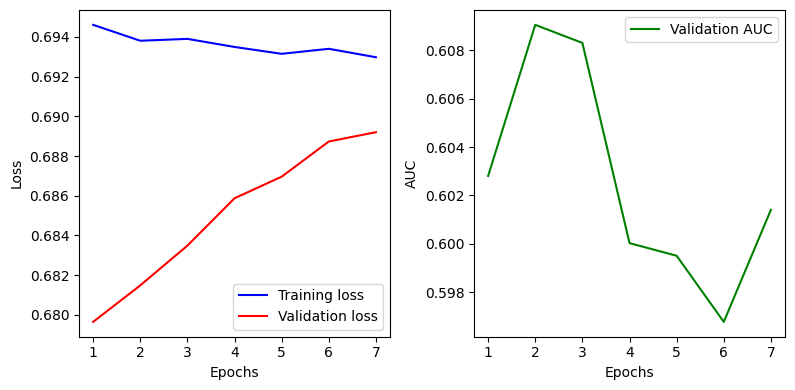

[I 2024-07-20 00:12:30,101] Trial 1 finished with value: -0.6014043898072825 and parameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.75, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal'}. Best is trial 1 with value: -0.6014043898072825.
[I 2024-07-20 00:12:30,104] Trial 2 pruned. 


Epoch 0/29, Loss: 0.8833, Val Loss: 0.8821, Val AUC: 0.5387
Epoch 1/29, Loss: 0.8747, Val Loss: 0.8715, Val AUC: 0.5551
Epoch 2/29, Loss: 0.8620, Val Loss: 0.8506, Val AUC: 0.5556
Epoch 3/29, Loss: 0.8343, Val Loss: 0.8140, Val AUC: 0.5533
Epoch 4/29, Loss: 0.8137, Val Loss: 0.8066, Val AUC: 0.5541
Epoch 5/29, Loss: 0.8111, Val Loss: 0.8057, Val AUC: 0.5582
Epoch 6/29, Loss: 0.8106, Val Loss: 0.8053, Val AUC: 0.5593
Epoch 7/29, Loss: 0.8104, Val Loss: 0.8051, Val AUC: 0.5597
Epoch 8/29, Loss: 0.8103, Val Loss: 0.8049, Val AUC: 0.5619
Epoch 9/29, Loss: 0.8102, Val Loss: 0.8048, Val AUC: 0.5617
Epoch 10/29, Loss: 0.8101, Val Loss: 0.8048, Val AUC: 0.5620
Epoch 11/29, Loss: 0.8101, Val Loss: 0.8047, Val AUC: 0.5624
Epoch 12/29, Loss: 0.8100, Val Loss: 0.8047, Val AUC: 0.5620
Epoch 13/29, Loss: 0.8100, Val Loss: 0.8047, Val AUC: 0.5624
Epoch 14/29, Loss: 0.8100, Val Loss: 0.8046, Val AUC: 0.5626
Epoch 15/29, Loss: 0.8100, Val Loss: 0.8046, Val AUC: 0.5627
Epoch 16/29, Loss: 0.8099, Val Los

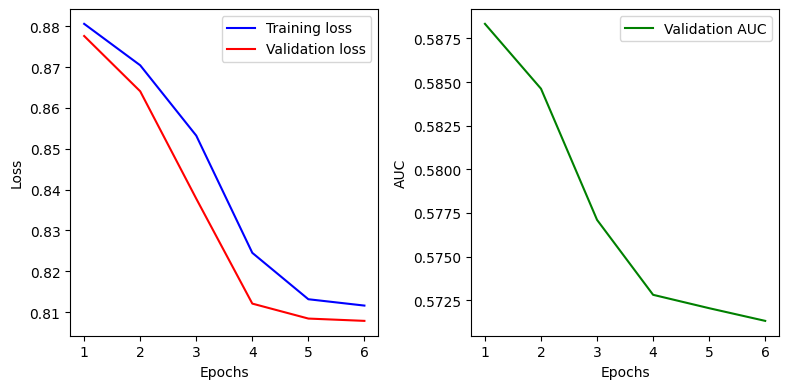

[I 2024-07-20 00:12:39,057] Trial 3 finished with value: -0.5713108297943176 and parameters: {'hidden_dim': 128, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 30, 'sampling_method': 'normal', 'loss': 'weighted'}. Best is trial 1 with value: -0.6014043898072825.
[I 2024-07-20 00:12:39,061] Trial 4 pruned. 


Epoch 0/49, Loss: 0.6931, Val Loss: 0.6946, Val AUC: 0.5906
Epoch 1/49, Loss: 0.6931, Val Loss: 0.6943, Val AUC: 0.5927
Epoch 2/49, Loss: 0.6931, Val Loss: 0.6944, Val AUC: 0.5942
Epoch 3/49, Loss: 0.6931, Val Loss: 0.6941, Val AUC: 0.5933
Epoch 4/49, Loss: 0.6930, Val Loss: 0.6941, Val AUC: 0.5935
Epoch 5/49, Loss: 0.6930, Val Loss: 0.6940, Val AUC: 0.5962
Epoch 6/49, Loss: 0.6930, Val Loss: 0.6939, Val AUC: 0.5968
Epoch 7/49, Loss: 0.6930, Val Loss: 0.6941, Val AUC: 0.5987
Epoch 8/49, Loss: 0.6930, Val Loss: 0.6941, Val AUC: 0.5993
Epoch 9/49, Loss: 0.6930, Val Loss: 0.6939, Val AUC: 0.6008
Epoch 10/49, Loss: 0.6930, Val Loss: 0.6941, Val AUC: 0.6006
Epoch 11/49, Loss: 0.6930, Val Loss: 0.6941, Val AUC: 0.5987
Epoch 12/49, Loss: 0.6930, Val Loss: 0.6939, Val AUC: 0.5986
Epoch 13/49, Loss: 0.6930, Val Loss: 0.6938, Val AUC: 0.5989
Epoch 14/49, Loss: 0.6930, Val Loss: 0.6935, Val AUC: 0.5983
Early stopping
Params: {'hidden_dim': 128, 'layer_dim': 1, 'dropout_prob': 0.0, 'learning_rate'

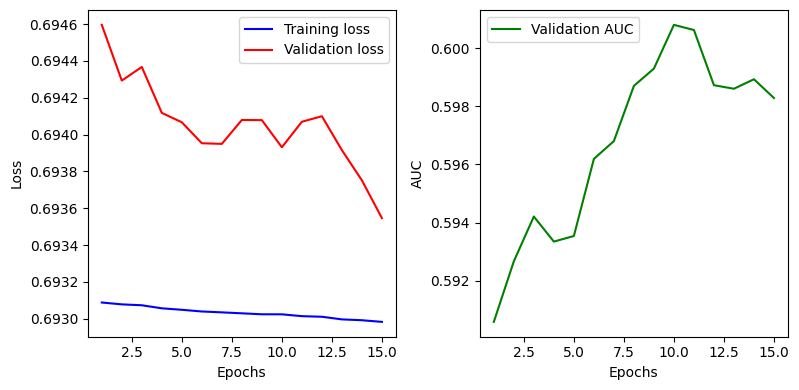

[I 2024-07-20 00:13:00,109] Trial 5 finished with value: -0.5982823525705645 and parameters: {'hidden_dim': 128, 'layer_dim': 1, 'dropout_prob': 0.0, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal'}. Best is trial 1 with value: -0.6014043898072825.


Epoch 0/49, Loss: 0.7164, Val Loss: 0.7147, Val AUC: 0.4266
Epoch 1/49, Loss: 0.7154, Val Loss: 0.7139, Val AUC: 0.4246
Epoch 2/49, Loss: 0.7148, Val Loss: 0.7131, Val AUC: 0.4236
Epoch 3/49, Loss: 0.7139, Val Loss: 0.7124, Val AUC: 0.4246
Epoch 4/49, Loss: 0.7133, Val Loss: 0.7116, Val AUC: 0.4260
Epoch 5/49, Loss: 0.7124, Val Loss: 0.7109, Val AUC: 0.4261
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 3, 'dropout_prob': 0.75, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.4261
Epoch 0/49, Loss: 0.6841, Val Loss: 0.6836, Val AUC: 0.5286
Epoch 1/49, Loss: 0.6832, Val Loss: 0.6829, Val AUC: 0.5294
Epoch 2/49, Loss: 0.6823, Val Loss: 0.6822, Val AUC: 0.5302
Epoch 3/49, Loss: 0.6815, Val Loss: 0.6816, Val AUC: 0.5285
Epoch 4/49, Loss: 0.6810, Val Loss: 0.6809, Val AUC: 0.5289
Epoch 5/49, Loss: 0.6804, Val Loss: 0.6803, Val AUC: 0.5297
Epoch 6/49, Loss: 0.6798, Val Loss: 0.6796, Val AUC: 0.5287
Epoch 7/49, Los

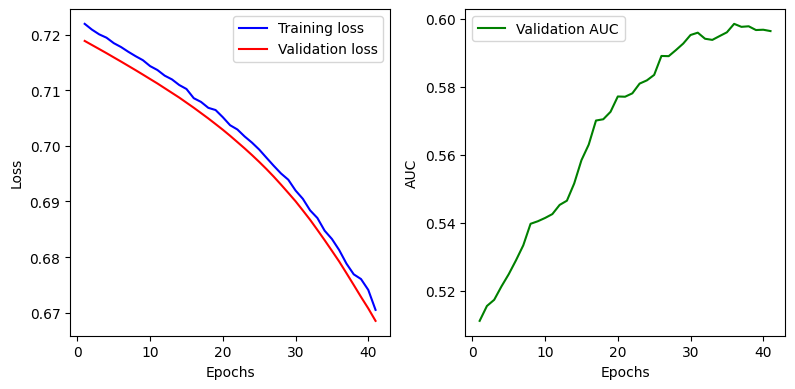

[I 2024-07-20 00:13:09,737] Trial 6 finished with value: -0.5963460753852431 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'dropout_prob': 0.75, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'normal'}. Best is trial 1 with value: -0.6014043898072825.


Epoch 0/49, Loss: 0.8103, Val Loss: 0.8052, Val AUC: 0.5334
Epoch 1/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5158
Epoch 2/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5253
Epoch 3/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5175
Epoch 4/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5361
Epoch 5/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5225
Epoch 6/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5352
Epoch 7/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5112
Epoch 8/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5244
Epoch 9/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5403
Epoch 10/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5094
Epoch 11/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5183
Epoch 12/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5337
Epoch 13/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5118
Epoch 14/49, Loss: 0.8100, Val Loss: 0.8052, Val AUC: 0.5094
Early stopping
Params: {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate'

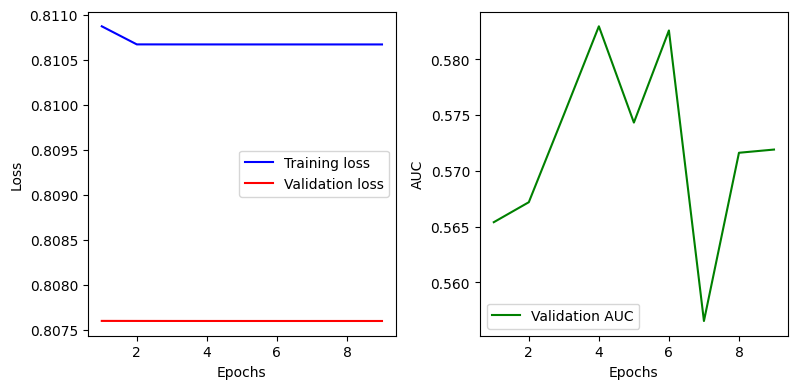

[I 2024-07-20 00:13:39,332] Trial 7 finished with value: -0.5719008264462809 and parameters: {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.01, 'batch_size': 16, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'weighted'}. Best is trial 1 with value: -0.6014043898072825.
[I 2024-07-20 00:13:39,335] Trial 8 pruned. 


Epoch 0/39, Loss: 0.7208, Val Loss: 0.6191, Val AUC: 0.5075
Epoch 1/39, Loss: 0.6513, Val Loss: 0.6261, Val AUC: 0.4988
Epoch 2/39, Loss: 0.6508, Val Loss: 0.6179, Val AUC: 0.4985
Epoch 3/39, Loss: 0.6422, Val Loss: 0.6180, Val AUC: 0.4940
Epoch 4/39, Loss: 0.6413, Val Loss: 0.6551, Val AUC: 0.5034
Epoch 5/39, Loss: 0.6497, Val Loss: 0.6219, Val AUC: 0.4993
Early stopping
Params: {'hidden_dim': 512, 'layer_dim': 4, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.4993
Epoch 0/39, Loss: 0.7286, Val Loss: 0.6273, Val AUC: 0.5022
Epoch 1/39, Loss: 0.6500, Val Loss: 0.6274, Val AUC: 0.4699
Epoch 2/39, Loss: 0.6435, Val Loss: 0.6311, Val AUC: 0.4876
Epoch 3/39, Loss: 0.6397, Val Loss: 0.6416, Val AUC: 0.4700
Epoch 4/39, Loss: 0.6437, Val Loss: 0.6430, Val AUC: 0.5499
Epoch 5/39, Loss: 0.6496, Val Loss: 0.6302, Val AUC: 0.5090
Epoch 6/39, Loss: 0.6391, Val Loss: 0.6320, Val AUC: 0.4790
Epoch 7/39, Loss:

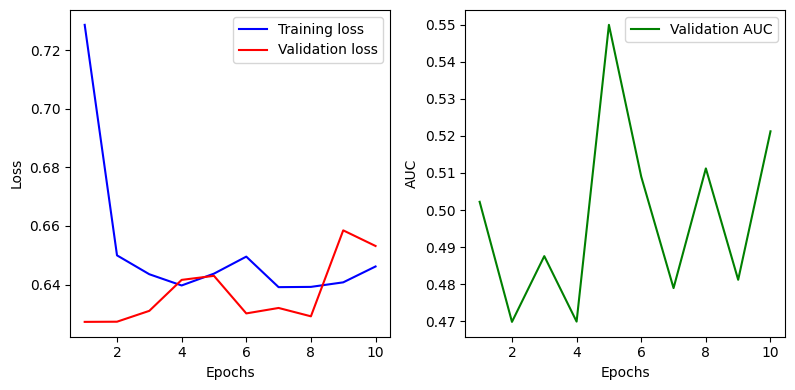

[I 2024-07-20 00:14:10,491] Trial 9 finished with value: -0.5212259746165275 and parameters: {'hidden_dim': 512, 'layer_dim': 4, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'normal'}. Best is trial 1 with value: -0.6014043898072825.


Best hyperparameters:
{'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.75, 'learning_rate': 0.0001, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal'}


In [ ]:
# Run Bayesian optimisation
study_exp_6b = optuna.create_study(direction='minimize')
study_exp_6b.optimize(objective_wrapper_2(train_sequences_2, train_labels_2), n_trials=10)

best_hyperparameters = study_exp_6b.best_params

print("Best hyperparameters:")
print(study_exp_6b.best_params)

In [ ]:
best_hyperparameters_6b = study_exp_6b.best_params
best_hyperparameters_6b

{'hidden_dim': 64,
 'layer_dim': 2,
 'dropout_prob': 0.75,
 'learning_rate': 0.0001,
 'batch_size': 128,
 'num_epochs': 50,
 'sampling_method': 'undersample',
 'loss': 'normal'}

In [ ]:
# Best score
best_score_6b = study_exp_6b.best_value
best_score_6b

-0.6014043898072825

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Create final model
input_dim = train_sequences_3.shape[2]
output_dim = 1

# Define the final model
model_exp_6b = LSTMModel(
    input_dim=input_dim,
    hidden_dim=best_hyperparameters_6b['hidden_dim'],
    layer_dim=best_hyperparameters_6b['layer_dim'],
    output_dim=output_dim,
    dropout_prob=best_hyperparameters_6b['dropout_prob']
)

# Define the loss function
if best_hyperparameters_6b['loss'] == 'normal':
    criterion = nn.BCELoss()
else:
    pos_weight = torch.tensor([2.0])
    criterion = nn.BCELoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(
    model_exp_6.parameters(),
    lr=best_hyperparameters_6b['learning_rate'],
)

# Handle sampling method
if best_hyperparameters_6b['sampling_method'] == 'undersample':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences_2, train_labels_2)
elif best_hyperparameters_6b['sampling_method'] == 'oversample':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences_2, train_labels_2)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences_2, train_labels_2

# Split the tra9ning data into training and validation sets
train_sequences_resampled, train_labels_resampled = shuffle_data(train_sequences_resampled, train_labels_resampled)
train_sequences_resampled, train_labels_resampled, val_sequences_resampled, val_labels_resampled = train_test_split(
    train_sequences_resampled, train_labels_resampled, test_size=0.2, random_state=42
)

# Create data loader for train and test data
train_loader_6b, val_loader_6b, test_loader_6b = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    val_sequences_resampled, val_labels_resampled,
    test_sequences_2, test_labels_2,
    batch_size=best_hyperparameters_6b['batch_size']
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Train the model 6b on the full training set
trained_model_exp_6b, train_losses_exp_6b, val_losses_exp_6b, val_aucs_exp_6b = train_model_with_early_stopping_logging(
    model_exp_6b,
    train_loader_6,
    val_loader_6,
    criterion,
    optimizer,
    best_hyperparameters_6b['num_epochs'],
    device,
    patience=5,
    output_path="None"
)

Epoch 0/49, Loss: 0.6942, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 1/49, Loss: 0.6943, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 2/49, Loss: 0.6944, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 3/49, Loss: 0.6941, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 4/49, Loss: 0.6943, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 5/49, Loss: 0.6943, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 6/49, Loss: 0.6939, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 7/49, Loss: 0.6940, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 8/49, Loss: 0.6940, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 9/49, Loss: 0.6941, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 10/49, Loss: 0.6942, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 11/49, Loss: 0.6943, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 12/49, Loss: 0.6940, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 13/49, Loss: 0.6941, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 14/49, Loss: 0.6944, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 15/49, Loss: 0.6942, Val Loss: 0.6941, Val AUC: 0.5506
Epoch 16/49, Loss: 0.6942, Val Los

In [ ]:
evaluate_model(trained_model_exp_6b, test_loader_6b, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.5521
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.5521403951498739,
 0.0)

In [ ]:
def get_model_predictions(model, test_loader, device):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

model_preds, model_labels = get_model_predictions(trained_model_exp_6b, test_loader_6, device)
print("Model predictions:", model_preds)
print("True labels:", model_labels)


Model predictions: [[0.52266353]
 [0.52231455]
 [0.52267766]
 [0.5225966 ]
 [0.5224054 ]
 [0.5217445 ]
 [0.52220905]
 [0.52290446]
 [0.52286255]
 [0.52270263]
 [0.5222063 ]
 [0.5225681 ]
 [0.52270263]
 [0.5213601 ]
 [0.52238923]
 [0.52274406]
 [0.5225796 ]
 [0.52270263]
 [0.5228037 ]
 [0.5225095 ]
 [0.52279687]
 [0.5225496 ]
 [0.52270067]
 [0.5218034 ]
 [0.52263534]
 [0.5229031 ]
 [0.5227689 ]
 [0.5227146 ]
 [0.52268726]
 [0.52270263]
 [0.52272505]
 [0.5231359 ]
 [0.5221536 ]
 [0.52238387]
 [0.522451  ]
 [0.52282566]
 [0.5225519 ]
 [0.52265006]
 [0.52270263]
 [0.5223462 ]
 [0.52270263]
 [0.52270263]
 [0.5233618 ]
 [0.52270263]
 [0.523425  ]
 [0.52270424]
 [0.5226438 ]
 [0.5227851 ]
 [0.52270263]
 [0.52270263]
 [0.52270263]
 [0.5224642 ]
 [0.5229639 ]
 [0.5223158 ]
 [0.52270263]
 [0.5228303 ]
 [0.52224076]
 [0.5231113 ]
 [0.52270263]
 [0.52270263]
 [0.52274984]
 [0.52304417]
 [0.5231983 ]
 [0.5227297 ]
 [0.5229446 ]
 [0.5228049 ]
 [0.5227502 ]
 [0.5221906 ]
 [0.52264625]
 [0.5226449 ]
 

**Experiment 6c - train_sequences_3 with no L2 regularisation**

[I 2024-07-20 00:30:37,786] A new study created in memory with name: no-name-c6287dd5-b995-4e3b-88ef-4a1ab9254b50
[I 2024-07-20 00:30:37,790] Trial 0 pruned. 
[I 2024-07-20 00:30:37,793] Trial 1 pruned. 


Epoch 0/29, Loss: 0.7635, Val Loss: 0.6959, Val AUC: 0.5219
Epoch 1/29, Loss: 0.6945, Val Loss: 0.7023, Val AUC: 0.5340
Epoch 2/29, Loss: 0.6946, Val Loss: 0.7003, Val AUC: 0.5246
Epoch 3/29, Loss: 0.6946, Val Loss: 0.6707, Val AUC: 0.5242
Epoch 4/29, Loss: 0.6935, Val Loss: 0.6901, Val AUC: 0.5037
Epoch 5/29, Loss: 0.6943, Val Loss: 0.6995, Val AUC: 0.5262
Epoch 6/29, Loss: 0.6934, Val Loss: 0.6888, Val AUC: 0.5283
Early stopping
Params: {'hidden_dim': 512, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.5283
Epoch 0/29, Loss: 0.7829, Val Loss: 0.7645, Val AUC: 0.5579
Epoch 1/29, Loss: 0.6981, Val Loss: 0.7361, Val AUC: 0.5988
Epoch 2/29, Loss: 0.7009, Val Loss: 0.7618, Val AUC: 0.5888
Epoch 3/29, Loss: 0.7212, Val Loss: 0.6981, Val AUC: 0.5120
Epoch 4/29, Loss: 0.7241, Val Loss: 0.7222, Val AUC: 0.5363
Epoch 5/29, Loss: 0.7221, Val Loss: 0.7976, Val AUC: 0.5190
Epoch 6/29, 

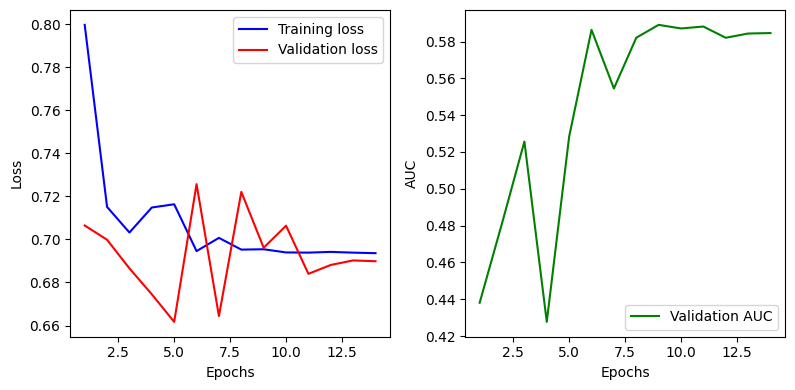

[I 2024-07-20 00:30:51,598] Trial 2 finished with value: -0.5845930118303659 and parameters: {'hidden_dim': 512, 'layer_dim': 1, 'dropout_prob': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal'}. Best is trial 2 with value: -0.5845930118303659.
[I 2024-07-20 00:30:51,601] Trial 3 pruned. 
[I 2024-07-20 00:30:51,604] Trial 4 pruned. 


Epoch 0/29, Loss: 0.6470, Val Loss: 0.6276, Val AUC: 0.5225
Epoch 1/29, Loss: 0.6345, Val Loss: 0.6316, Val AUC: 0.5209
Epoch 2/29, Loss: 0.6322, Val Loss: 0.6279, Val AUC: 0.5269
Epoch 3/29, Loss: 0.6404, Val Loss: 0.6267, Val AUC: 0.5113
Epoch 4/29, Loss: 0.6364, Val Loss: 0.6286, Val AUC: 0.5165
Epoch 5/29, Loss: 0.6359, Val Loss: 0.6285, Val AUC: 0.5224
Epoch 6/29, Loss: 0.6355, Val Loss: 0.6263, Val AUC: 0.5228
Epoch 7/29, Loss: 0.6354, Val Loss: 0.6262, Val AUC: 0.5243
Early stopping
Params: {'hidden_dim': 512, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'sampling_method': 'normal', 'loss': 'normal'}, Val AUC: 0.5243
Epoch 0/29, Loss: 0.6447, Val Loss: 0.6363, Val AUC: 0.5849
Epoch 1/29, Loss: 0.6329, Val Loss: 0.6354, Val AUC: 0.5887
Epoch 2/29, Loss: 0.6322, Val Loss: 0.6367, Val AUC: 0.5882
Epoch 3/29, Loss: 0.6320, Val Loss: 0.6349, Val AUC: 0.5937
Epoch 4/29, Loss: 0.6314, Val Loss: 0.6293, Val AUC: 0.5907
Epoch 5/29, Los

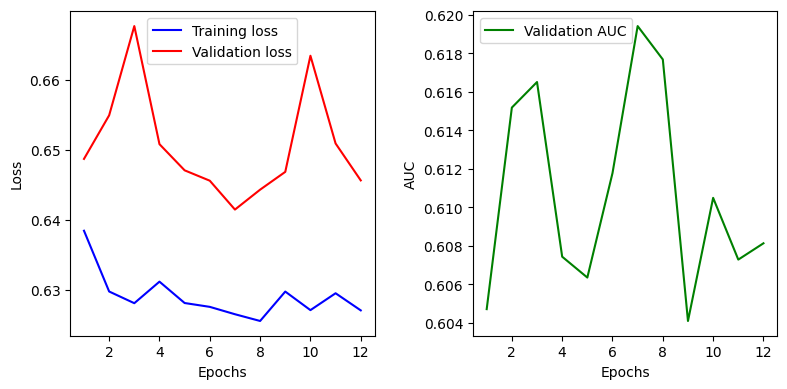

[I 2024-07-20 00:31:12,178] Trial 5 finished with value: -0.6081291190940314 and parameters: {'hidden_dim': 512, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 30, 'sampling_method': 'normal', 'loss': 'normal'}. Best is trial 5 with value: -0.6081291190940314.
[I 2024-07-20 00:31:12,180] Trial 6 pruned. 


Epoch 0/39, Loss: 0.8182, Val Loss: 0.8194, Val AUC: 0.4996
Epoch 1/39, Loss: 0.8140, Val Loss: 0.8193, Val AUC: 0.5038
Epoch 2/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5123
Epoch 3/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5061
Epoch 4/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5110
Epoch 5/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5097
Epoch 6/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5201
Epoch 7/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5121
Epoch 8/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5022
Epoch 9/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.4997
Epoch 10/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.4917
Epoch 11/39, Loss: 0.8139, Val Loss: 0.8193, Val AUC: 0.5074
Early stopping
Params: {'hidden_dim': 32, 'layer_dim': 3, 'dropout_prob': 0.0, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.5074
Epoch 0/39, Loss: 0.8152, Val Loss: 0.8044, Val AUC: 0.5075
Epoch 1/39, Lo

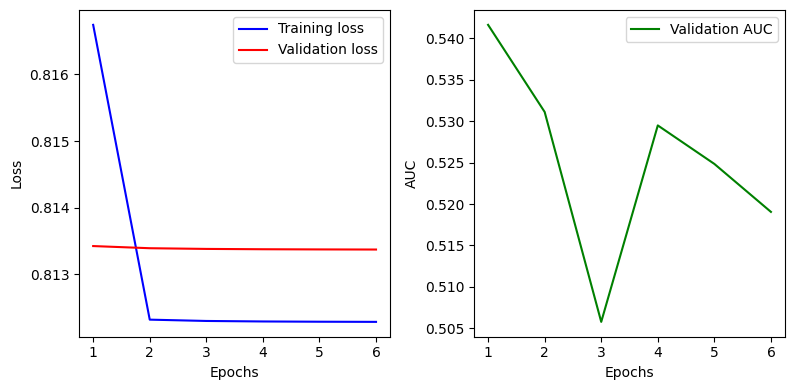

[I 2024-07-20 00:31:24,392] Trial 7 finished with value: -0.5190503564955647 and parameters: {'hidden_dim': 32, 'layer_dim': 3, 'dropout_prob': 0.0, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'weighted'}. Best is trial 5 with value: -0.6081291190940314.


Epoch 0/19, Loss: 0.8174, Val Loss: 0.8272, Val AUC: 0.4700
Epoch 1/19, Loss: 0.8160, Val Loss: 0.8272, Val AUC: 0.4656
Epoch 2/19, Loss: 0.8160, Val Loss: 0.8272, Val AUC: 0.4543
Epoch 3/19, Loss: 0.8160, Val Loss: 0.8272, Val AUC: 0.4519
Epoch 4/19, Loss: 0.8160, Val Loss: 0.8272, Val AUC: 0.4446
Epoch 5/19, Loss: 0.8160, Val Loss: 0.8272, Val AUC: 0.4621
Early stopping
Params: {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}, Val AUC: 0.4621
Epoch 0/19, Loss: 0.8120, Val Loss: 0.8076, Val AUC: 0.4931
Epoch 1/19, Loss: 0.8107, Val Loss: 0.8076, Val AUC: 0.5049
Epoch 2/19, Loss: 0.8107, Val Loss: 0.8076, Val AUC: 0.5005
Epoch 3/19, Loss: 0.8107, Val Loss: 0.8076, Val AUC: 0.4827
Epoch 4/19, Loss: 0.8107, Val Loss: 0.8076, Val AUC: 0.4918
Epoch 5/19, Loss: 0.8107, Val Loss: 0.8076, Val AUC: 0.5023
Epoch 6/19, Loss: 0.8107, Val Loss: 0.8076, Val AUC: 0.5020
Early stopping

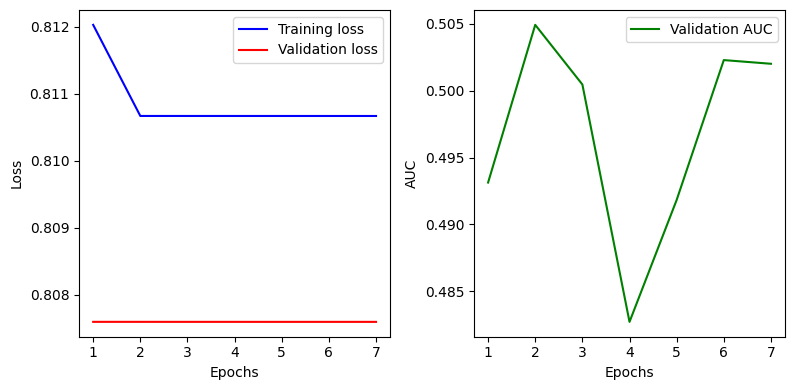

[I 2024-07-20 00:31:38,390] Trial 8 finished with value: -0.5020053475935828 and parameters: {'hidden_dim': 128, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.01, 'batch_size': 32, 'num_epochs': 20, 'sampling_method': 'normal', 'loss': 'weighted'}. Best is trial 5 with value: -0.6081291190940314.


Epoch 0/29, Loss: 0.6936, Val Loss: 0.6778, Val AUC: 0.6059
Epoch 1/29, Loss: 0.6935, Val Loss: 0.6921, Val AUC: 0.6159
Epoch 2/29, Loss: 0.6933, Val Loss: 0.6905, Val AUC: 0.6135
Epoch 3/29, Loss: 0.6935, Val Loss: 0.6955, Val AUC: 0.6159
Epoch 4/29, Loss: 0.6916, Val Loss: 0.7405, Val AUC: 0.6207
Epoch 5/29, Loss: 0.6932, Val Loss: 0.6927, Val AUC: 0.6059
Epoch 6/29, Loss: 0.6927, Val Loss: 0.6955, Val AUC: 0.6126
Epoch 7/29, Loss: 0.6923, Val Loss: 0.6965, Val AUC: 0.6122
Epoch 8/29, Loss: 0.6914, Val Loss: 0.6835, Val AUC: 0.6106
Epoch 9/29, Loss: 0.6916, Val Loss: 0.6993, Val AUC: 0.6136
Early stopping
Params: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal'}, Val AUC: 0.6136
Epoch 0/29, Loss: 0.6948, Val Loss: 0.7015, Val AUC: 0.5904
Epoch 1/29, Loss: 0.6933, Val Loss: 0.6823, Val AUC: 0.5961
Epoch 2/29, Loss: 0.6932, Val Loss: 0.6953, Val AUC: 0.5972
Epoch 3/29,

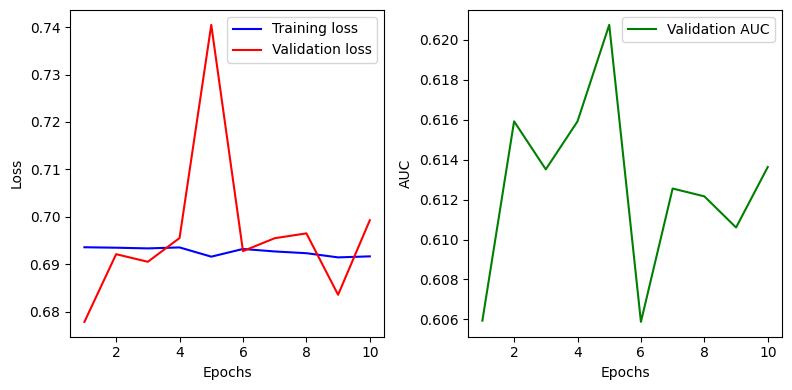

[I 2024-07-20 00:32:06,444] Trial 9 finished with value: -0.6136272806609737 and parameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal'}. Best is trial 9 with value: -0.6136272806609737.


Best hyperparameters:
{'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 16, 'num_epochs': 30, 'sampling_method': 'undersample', 'loss': 'normal'}


In [ ]:
study_exp_6c = optuna.create_study(direction='minimize')
study_exp_6c.optimize(objective_wrapper_2(train_sequences_3, train_labels_3), n_trials=10)

best_hyperparameters_6c = study_exp_6c.best_params

print("Best hyperparameters:")
print(study_exp_6c.best_params)

In [ ]:
# Create final model
input_dim = train_sequences_3.shape[2]
output_dim = 1

# Define the final model
model_exp_6c = LSTMModel(
    input_dim=input_dim,
    hidden_dim=best_hyperparameters_6c['hidden_dim'],
    layer_dim=best_hyperparameters_6c['layer_dim'],
    output_dim=output_dim,
    dropout_prob=best_hyperparameters_6c['dropout_prob']
)

# Define the loss function
if best_hyperparameters_6c['loss'] == 'normal':
    criterion = nn.BCELoss()
else:
    pos_weight = torch.tensor([2.0])
    criterion = nn.BCELoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(
    model_exp_6.parameters(),
    lr=best_hyperparameters_6c['learning_rate'],
)

# Handle sampling method
if best_hyperparameters_6c['sampling_method'] == 'undersample':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences_2, train_labels_2)
elif best_hyperparameters_6c['sampling_method'] == 'oversample':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences_2, train_labels_2)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences_2, train_labels_2

# Split the tra9ning data into training and validation sets
train_sequences_resampled, train_labels_resampled = shuffle_data(train_sequences_resampled, train_labels_resampled)
train_sequences_resampled, train_labels_resampled, val_sequences_resampled, val_labels_resampled = train_test_split(
    train_sequences_resampled, train_labels_resampled, test_size=0.2, random_state=42
)

# Create data loader for train and test data
train_loader_6c, val_loader_6c, test_loader_6c = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    val_sequences_resampled, val_labels_resampled,
    test_sequences_2, test_labels_2,
    batch_size=best_hyperparameters_6c['batch_size']
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
trained_model_exp_6c, train_losses_exp_6c, val_losses_exp_6c, val_aucs_exp_6c = train_model_with_early_stopping_logging(
    model_exp_6c,
    train_loader_6c,
    val_loader_6c,
    criterion,
    optimizer,
    best_hyperparameters_6c['num_epochs'],
    device,
    patience=5,
    output_path="None"
)

IndexError: index 691 is out of bounds for axis 0 with size 495

**Experiment 6d - Just trying a simple training pipeline with grid search**



In [ ]:
print(train_sequences_3.shape)
print(train_labels_3.shape)
print(test_sequences_3.shape)
print(test_labels_3.shape)

(3760, 13, 16)
(3760,)
(941, 13, 16)
(941,)


In [ ]:
# Give me two hyperparameter combinations
hyperparameters_6d = [
    {
        'hidden_dim': 64,
        'layer_dim': 2,
        'dropout_prob': 0.5,
        'learning_rate': 0.001,
        'batch_size': 32,
        'num_epochs': 10,
        'sampling_method': 'normal',
        'loss': 'normal',
        'weight_decay': 0.0001
    },
    {
        'hidden_dim': 128,
        'layer_dim': 3,
        'dropout_prob': 0.25,
        'learning_rate': 0.0001,
        'batch_size': 64,
        'num_epochs': 20,
        'sampling_method': 'undersample',
        'loss': 'normal',
        'weight_decay': 0.0001
    }
]

Epoch 0/9, Loss: 0.6361, Val Loss: 0.6459, Val AUC: 0.5669
Epoch 1/9, Loss: 0.6318, Val Loss: 0.6460, Val AUC: 0.5752
Epoch 2/9, Loss: 0.6308, Val Loss: 0.6463, Val AUC: 0.5806
Epoch 3/9, Loss: 0.6311, Val Loss: 0.6453, Val AUC: 0.5791
Epoch 4/9, Loss: 0.6289, Val Loss: 0.6431, Val AUC: 0.5772
Epoch 5/9, Loss: 0.6289, Val Loss: 0.6419, Val AUC: 0.5790
Epoch 6/9, Loss: 0.6264, Val Loss: 0.6411, Val AUC: 0.5766
Epoch 7/9, Loss: 0.6252, Val Loss: 0.6365, Val AUC: 0.5807
Epoch 8/9, Loss: 0.6280, Val Loss: 0.6398, Val AUC: 0.5772
Epoch 9/9, Loss: 0.6216, Val Loss: 0.6378, Val AUC: 0.5748
Params: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.0001}, Val AUC: 0.5748
Epoch 0/19, Loss: 0.6936, Val Loss: 0.6991, Val AUC: 0.5167
Epoch 1/19, Loss: 0.6932, Val Loss: 0.6945, Val AUC: 0.5701
Epoch 2/19, Loss: 0.6932, Val Loss: 0.6935, Val AUC: 0.5756
Epoch 3/19, Loss: 

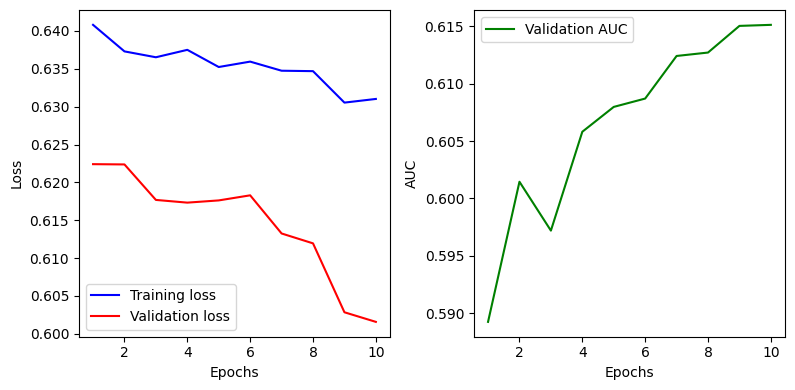

In [ ]:
# Tune hyperparameters with standard grid search
model_6d, best_hyperparameters_6d, best_auc_6d = manual_cross_validation(
    train_sequences_3,
    train_labels_3,
    hyperparameters_6d,
    num_folds=5,
    patience=5,
    output_path="None"
)

In [ ]:
print(best_hyperparameters_6d)
print(best_auc_6d)

{'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.0001}
0.6151355776625567


In [ ]:
_, _, test_loader_6d = create_data_loaders(
    train_sequences_3, train_labels_3,
    train_sequences_3, train_labels_3,
    test_sequences_3, test_labels_3,
    batch_size=best_hyperparameters_6d['batch_size']
)

In [ ]:
evaluate_model(model_6d, test_loader_6d, device)

Accuracy: 0.6036
Precision: 0.2789
Recall (Sensitivity): 0.1331
F1 Score: 0.1802
ROC AUC: 0.4655
Specificity: 0.8325


(0.6036131774707758,
 0.2789115646258503,
 0.1331168831168831,
 0.18021978021978022,
 0.4655244045054472,
 0.8325434439178515)

In [ ]:
# Create and train model with best hyperparameters on training data
input_dim = train_sequences_3.shape[2]
output_dim = 1

# Define the final model
model_exp_6d = LSTMModel(
    input_dim=input_dim,
    hidden_dim=best_hyperparameters_6d['hidden_dim'],
    layer_dim=best_hyperparameters_6d['layer_dim'],
    output_dim=output_dim,
    dropout_prob=best_hyperparameters_6d['dropout_prob']
)

# Define the loss function
if best_hyperparameters_6d['loss'] == 'normal':
    criterion = nn.BCELoss()
else:
    pos_weight = torch.tensor([2.0])
    criterion = nn.BCELoss(pos_weight=pos_weight)

# Define the optimizer
optimizer = optim.Adam(
    model_exp_6d.parameters(),
    lr=best_hyperparameters_6d['learning_rate'],
    weight_decay=best_hyperparameters_6d['weight_decay']
)

# Handle sampling method
if best_hyperparameters_6d['sampling_method'] == 'undersample':
    train_sequences_resampled, train_labels_resampled = undersample_data(train_sequences_3, train_labels_3)
elif best_hyperparameters_6d['sampling_method'] == 'oversample':
    train_sequences_resampled, train_labels_resampled = oversample_data(train_sequences_3, train_labels_3)
else:
    train_sequences_resampled, train_labels_resampled = train_sequences_3, train_labels_3


# Create train and test loaders
train_loader_6d, _, test_loader_6d = create_data_loaders(
    train_sequences_resampled, train_labels_resampled,
    train_sequences_resampled, train_labels_resampled,
    test_sequences_3, test_labels_3,
    batch_size=best_hyperparameters_6d['batch_size']
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
        # Print the data structure to diagnose the issue
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model

In [ ]:
# Train the model
trainied_model_exp_6d = train_model(
    model_exp_6d,
    train_loader_6d,
    criterion,
    optimizer,
    best_hyperparameters_6d['num_epochs'],
    device
)

Epoch 1/10, Loss: 0.6237
Epoch 2/10, Loss: 0.6235
Epoch 3/10, Loss: 0.6224
Epoch 4/10, Loss: 0.6230
Epoch 5/10, Loss: 0.6231
Epoch 6/10, Loss: 0.6220
Epoch 7/10, Loss: 0.6244
Epoch 8/10, Loss: 0.6214
Epoch 9/10, Loss: 0.6224
Epoch 10/10, Loss: 0.6220


In [ ]:
evaluate_model(trainied_model_exp_6d, test_loader_6d, device)

Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4597
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.45966178371391647,
 0.0)

In [ ]:
def evaluate_model_debug(model, test_loader, device):
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            labels = data['label'].to(device)
            outputs = model(sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    print("Predictions:", test_outputs[:10])  # Print first 10 predictions for debugging
    print("True Labels:", test_labels[:10])  # Print first 10 true labels for debugging

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
evaluate_model_debug(trainied_model_exp_6d, test_loader_6d, device)

Predictions: [0.71650594 0.71400994 0.69955075 0.7237755  0.7041998  0.73167354
 0.6835684  0.6113387  0.6951439  0.7029185 ]
True Labels: [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
Accuracy: 0.3273
Precision: 0.3273
Recall (Sensitivity): 1.0000
F1 Score: 0.4932
ROC AUC: 0.4597
Specificity: 0.0000


(0.3273113708820404,
 0.3273113708820404,
 1.0,
 0.49319455564451564,
 0.45966178371391647,
 0.0)

The same issue is happening and the values are exactly the same again.

## **Addendum - Check there is no similaritiy between train and test sets**

In [ ]:
def hash_sequence(sequence):
    """Convert a sequence to a hashable type (tuple of tuples)."""
    return tuple(map(tuple, sequence))

def check_sequence_overlap(train_sequences, test_sequences):
    """Check for overlapping sequences between training and testing datasets."""
    # Convert sequences to hashable types
    train_sequences_hashed = set(map(hash_sequence, train_sequences))
    test_sequences_hashed = set(map(hash_sequence, test_sequences))

    # Find common sequences
    common_sequences = train_sequences_hashed.intersection(test_sequences_hashed)

    # Number of common sequences
    num_common_sequences = len(common_sequences)

    return num_common_sequences, common_sequences

In [ ]:
num_common_sequences, common_sequences = check_sequence_overlap(train_sequences_3, test_sequences_3)
print(f"Number of common sequences: {num_common_sequences}")
if num_common_sequences > 0:
    print("Common sequences:")
    for sequence in common_sequences:
        print(sequence)

Number of common sequences: 0


In [ ]:
def compare_statistics(train_sequences, test_sequences, feature_names):
    """
    Compare the statistics (mean and variance) of features in the training and test datasets.

    Parameters:
    train_sequences (np.ndarray): Training dataset sequences.
    test_sequences (np.ndarray): Test dataset sequences.
    feature_names (list): List of feature names.

    Returns:
    pd.DataFrame: A DataFrame containing the mean and variance of each feature in the training and test datasets.
    """
    # Calculate means and variances for the training data
    train_means = np.mean(train_sequences, axis=(0, 1))
    train_variances = np.var(train_sequences, axis=(0, 1))

    # Calculate means and variances for the test data
    test_means = np.mean(test_sequences, axis=(0, 1))
    test_variances = np.var(test_sequences, axis=(0, 1))

    # Create a DataFrame to compare the statistics
    stats_comparison = pd.DataFrame({
        'Feature': feature_names,
        'Train Mean': train_means,
        'Test Mean': test_means,
        'Train Variance': train_variances,
        'Test Variance': test_variances
    })

    # Print the statistics comparison

    return stats_comparison

In [ ]:
compare_statistics(train_sequences_3, test_sequences_3, feature_names_2)

Feature  Train Mean  Test Mean  Train Variance  \
0                         EtCO2    0.544274   0.401612        0.004910   
1          Inspired O2 Fraction    0.417486   0.507864        0.005854   
2                 Minute Volume    0.666920   0.419104        0.002959   
3   O2 saturation pulseoxymetry    0.762522   0.667771        0.017082   
4           Peak Insp. Pressure    0.284980   0.758359        0.005452   
5              Respiratory Rate    0.327261   0.563284        0.003371   
6       Tidal Volume (observed)    0.386742   0.285590        0.005277   
7    Tidal Volume (spontaneous)    0.381717   0.328262        0.004950   
8         Arterial CO2 Pressure    0.402048   0.388203        0.000888   
9          Arterial O2 pressure    0.508151   0.383146        0.000833   
10                PH (Arterial)    0.563233   0.173027        0.000706   
11              Ventilator Mode    0.173151   0.407857        0.010154   
12                   Hemoglobin    0.407663   0.433750        0.000715   
13             Plateau Pressure    0.433056   0.545824        0.000587   
14                    SpO2:FiO2    0.281099   0.279062        0.004588   
15                    P:F ratio    0.430212   0.428778        0.002873   

    Test Variance  
0        0.001041  
1        0.000848  
2        0.005404  
3        0.002726  
4        0.017794  
5        0.001037  
6        0.005414  
7        0.003054  
8        0.004712  
9        0.004203  
10       0.010067  
11       0.000922  
12       0.000578  
13       0.005215  
14       0.004119  
15       0.002698

In [ ]:
def plot_feature_statistics_comparison(stats_comparison):
    features = stats_comparison['Feature']
    train_means = stats_comparison['Train Mean']
    test_means = stats_comparison['Test Mean']
    train_variances = stats_comparison['Train Variance']
    test_variances = stats_comparison['Test Variance']

    x = range(len(features))

    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    plt.bar(x, train_means, width=0.4, label='Train Mean', align='center')
    plt.bar(x, test_means, width=0.4, label='Test Mean', align='edge')
    plt.xticks(x, features, rotation='vertical')
    plt.ylabel('Mean')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.bar(x, train_variances, width=0.4, label='Train Variance', align='center')
    plt.bar(x, test_variances, width=0.4, label='Test Variance', align='edge')
    plt.xticks(x, features, rotation='vertical')
    plt.ylabel('Variance')
    plt.legend()

    plt.tight_layout()
    plt.show()

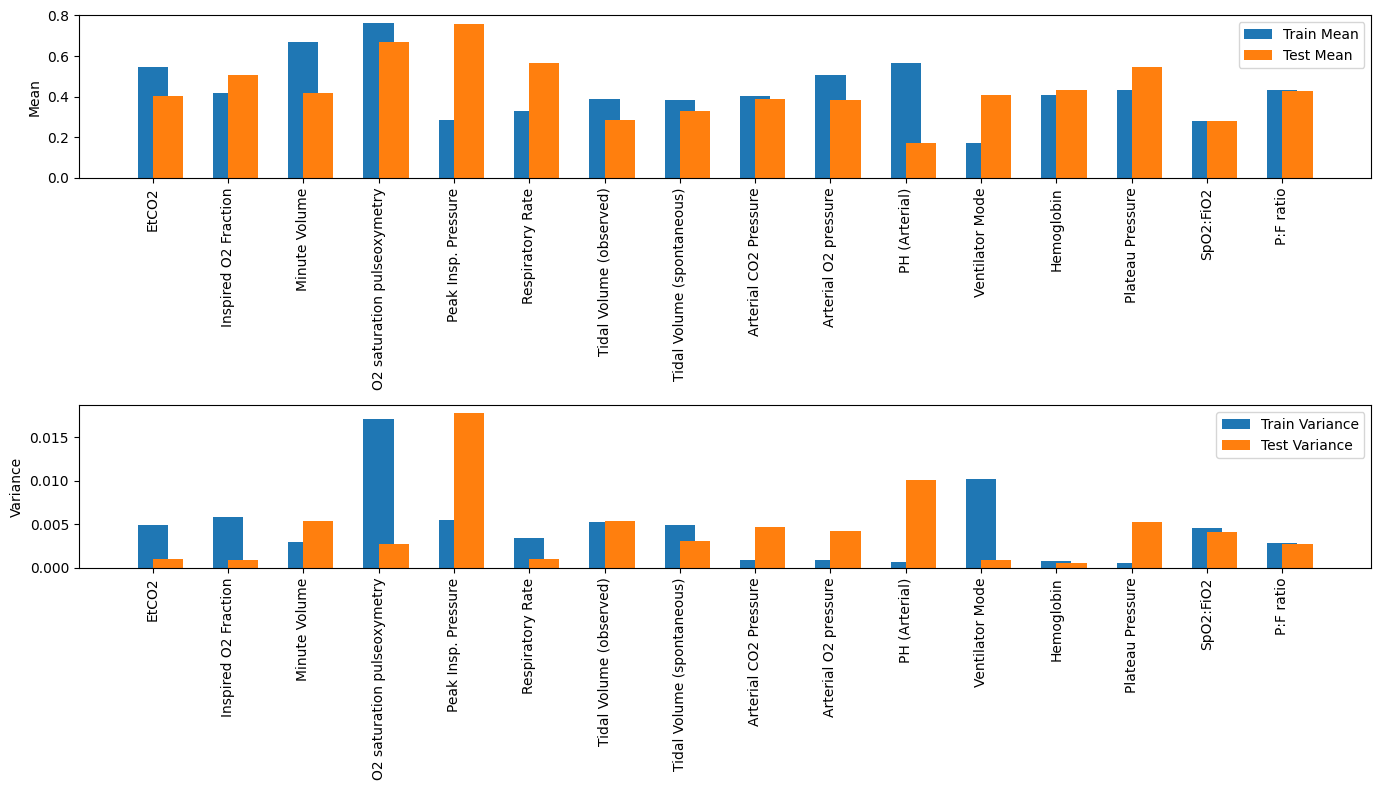

In [ ]:
plot_feature_statistics_comparison(compare_statistics(train_sequences_3, test_sequences_3, feature_names_2))

In [ ]:
def check_for_overlapping_sequences(train_sequences, test_sequences):
    train_sequences_set = {tuple(seq.flatten()) for seq in train_sequences}
    test_sequences_set = {tuple(seq.flatten()) for seq in test_sequences}

    overlap = train_sequences_set.intersection(test_sequences_set)

    if overlap:
        print(f"Found {len(overlap)} overlapping sequences.")
    else:
        print("No overlapping sequences found.")


In [ ]:
check_for_overlapping_sequences(train_sequences_3, test_sequences_3)

No overlapping sequences found.


It seems Peak Inspiratory Pressure, Ventilator mode and Arterial pH seem to have significant differences between the means of the train and test sets.

We will need to investigate the pre-processing logic to see if there has been any shifts in the data or data leakage.

We will need to ensure that the values have been scaled correctly and that the train test split maintains the same distribution of key features.

**Recommendation: Standardize features before splitting the data**

Then we can investigate model performance.